Добавить усредненную валидацию по отдельным фолдам. Усреднять не в конце ансамблем моделей, а усреднять результаты моделей на своих фолдах


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import random
import pickle

import os
import yaml

In [2]:
import optuna
from optuna.trial import Trial
# from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, NMF, SparsePCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import sklearn
from tqdm.notebook import tqdm
from scipy import linalg
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import itertools

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# import warnings
# warnings.filterwarnings('ignore')

/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# from utils import (
#     train_template,
#     get_metrics, 
#     random_forest_train, 
#     xgboost_train, 
#     catboost_train
# )

## Data loading

In [4]:
def data_loading(ga_file, fg_file, needed_data="all"):
    data_ga = pd.read_csv(ga_file)
    data_fg = pd.read_csv(fg_file)
    columns = data_ga.columns.values
    # print(columns)
#     print(f"data with GA samples shape: {data_ga.shape}")
#     print(f"data with FG samples shape: {data_fg.shape}")
    y_fg = data_fg[columns[0]].values
    X_fg = data_fg.drop(columns=columns[0])

    y_ga = data_ga[columns[0]].values
    X_ga = data_ga.drop(columns=columns[0])
#     print(f"shapes of X and y of FG samples respectively is: {X_fg.shape}, {y_fg.shape}")
#     print(f"shapes of X and y of GA samples respectively is: {X_ga.shape}, {y_ga.shape}")
    
    # print(f"old fg classes: {set(y_fg)}")
    for index, element in enumerate(set(y_fg)):
        y_fg[y_fg == element] = index
    # print(f"new fg classes: {set(y_fg)}\n")

    # print(f"old ga classes: {set(y_ga)}")
    for index, element in enumerate(set(y_ga)):
        y_ga[y_ga == element] = index + len(set(y_fg))
    # print(f"new ga classes: {set(y_ga)}")
    
    if needed_data == "all":
        y = np.concatenate((y_fg, y_ga), axis=0)
        X = np.concatenate((X_fg, X_ga), axis=0)
    elif needed_data == "fg":
        y = y_fg
        X = X_fg
    elif needed_data == "ga":
        y = y_ga
        X = X_ga
    else:
        raise Exception(f"needed_data can be ['all', 'fg', 'ga'],  but now needed_data={needed_data}")
    
    return X, y
    
# X, y = data_loading(
#     fg_file="dataSrc/fg3_1-12.csv", 
#     ga_file="dataSrc/ga_2_3_5_6.csv",
# )
# print(X.shape, y.shape)

## Training funtionalaity

### Parameters setting

In [5]:
def get_needed_params(trial, model_name):
    """
    
    Args:
        trial: specific parameter for optimization with optuna
        model_name: {"XGBoost", "RandomForest", "CatBoost", "SVM", "LDA", "LogisticRegression"}

    Returns:
        model: model class corresponding 'model_name' parameter
        parameters: hyperparameters for corresponding model class, that should be optimized
        
    """
    if model_name == "XGBoost": 
        parameters = {
            "n_estimators": trial.suggest_int('n_estimators', 100, 500), 
            'max_depth': trial.suggest_int('max_depth', 2, 10), 
            'reg_alpha': trial.suggest_uniform('reg_alpha',0,6), 
            'reg_lambda': trial.suggest_uniform('reg_lambda',0,2), 
            'min_child_weight': trial.suggest_int('min_child_weight',0,5),
            'gamma': trial.suggest_uniform('gamma', 0, 4), 
            'learning_rate': trial.suggest_uniform('learning_rate', 1e-4, 1e-1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree',0.4,0.9), 
            'subsample': trial.suggest_uniform('subsample',0.4,0.9),
            'nthread': -1
        }
    elif model_name == "RandomForest": 
        parameters = {
            "n_estimators": trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 6),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        }
    elif model_name == "CatBoost": 
        parameters = {
            'iterations': trial.suggest_int("iterations", 100, 1000),
            'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-1),
            'depth': trial.suggest_int("depth", 0, 4),
            'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0),
            'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            # 'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0),
            'verbose': False
        }
    elif model_name == "SVM": 
        parameters = {
            'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'C': trial.suggest_float("C", 1e-8, 100.0, log = True),
        }
    elif model_name == "LDA": 
        parameters = {
            'solver': trial.suggest_categorical('solver',  ['svd', 'lsqr', 'eigen']),
            # 'n_components': trial.suggest_int('n_components', 2, 3),            
        }
    elif model_name == "LogisticRegression":     
        parameters = {
            'penalty': trial.suggest_categorical('penalty',  ['l1', 'l2']),
            'C': trial.suggest_float("C", 1.0, 10.0, log=True),
            'tol': trial.suggest_float("tol", 0.0001, 0.01, log=True),
            'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
            'max_iter': trial.suggest_int("max_iter", 100, 1000),
            'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
        }
    else:
        raise ValueError("model_name can be only ['XGBoost', 'RandomForest', 'CatBoost', 'SVM', 'LDA', 'LogisticRegression']")
    models = {
        "XGBoost": XGBClassifier,
        "RandomForest": RandomForestClassifier,
        "CatBoost": CatBoostClassifier,
        "SVM": SVC,
        "LDA": LinearDiscriminantAnalysis,
        "LogisticRegression": LogisticRegression,
    }
    # print(parameters)
    return models[model_name], parameters


### Training pipeline

In [6]:
# deviding FG data into folds:
def get_mask_for_folds_split(X, y):
    # kfold split for fg data
    fg_mask = []
    split_df = pd.read_csv("dataSrc/points12.csv")
    for i in range(split_df.shape[0]):
        for index, number in enumerate(split_df.iloc[i].values[1:]):
            fg_mask += [index+1]*number
    # kfold split for ga data
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    ga_mask = np.zeros(y[2111:].shape[0])
    for i, (train_index, test_index) in enumerate(cv.split(X[2111:], y[2111:])):
        # print(f"  Test:  index={test_index}")
        ga_mask[test_index] = i+1
    
    return np.array(fg_mask+ga_mask.tolist())
# mask = get_mask_for_folds_split(X, y)
# mask.shape

In [7]:
def ml_class_train_template(
    X,
    y,
    model_class,
    args: dict,
    k_folds:int = 5,
    test_size:float = 0.2,
    method: str = "choice",
    random_state=None,
    custom_folds_strategy=True,
) -> tuple:

    models = {
        f"{i+1}_fold" : None for i in range(k_folds)
    }

    train_indexes, test_indexes = train_test_split(
        np.arange(X.shape[0]),
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    # print(train_indexes)
    scaler = MinMaxScaler()
    X[train_indexes] = scaler.fit_transform(X[train_indexes])
    X[test_indexes] = scaler.transform(X[test_indexes])
    
    if method == "choice":
        y_pred = np.empty((k_folds, y[test_indexes].shape[0]))

    elif method == "proba":
        y_pred = np.empty((k_folds, y[test_indexes].shape[0], np.unique(y).shape[0]))
    
    if not custom_folds_strategy:
        cv = StratifiedKFold(n_splits=k_folds)
            
        for i, (train, test) in enumerate(cv.split(X[train_indexes], y[train_indexes])):
            try:
                model = model_class(random_state=random_state, **args)
            except:
                model = model_class(**args)
            model.fit(X[train_indexes][train], y[train_indexes][train])
            models[f'{i+1}_fold'] = model
            if method == "choice":
                y_pred[i] = model.predict(X[test_indexes]).reshape(-1)

            elif method == "proba":
                y_pred[i] = model.predict_proba(X[test_indexes])

    else:
        folds_mask = get_mask_for_folds_split(X, y)

        for fold_index in range(1, 6):
            # print((folds_mask!=fold_index).shape, train_indexes.shape)
            try:
                model = model_class(random_state=random_state, **args)
            except:
                model = model_class(**args)
            train_folds_mask = folds_mask[train_indexes]
            model.fit(X[train_indexes][train_folds_mask!=fold_index], 
                      y[train_indexes][train_folds_mask!=fold_index])
            models[f'{fold_index}_fold'] = model
            if method == "choice":
                y_pred[fold_index-1] = model.predict(X[test_indexes]).reshape(-1)

            elif method == "proba":
                y_pred[fold_index-1] = model.predict_proba(X[test_indexes])

    # prediction of final results
    if method == "choice":
        y_pred_result = np.empty_like(y[test_indexes])
        for index in range(y_pred_result.shape[0]):
            unique_values, counts = np.unique(y_pred[:, index], return_counts=True)
            y_pred_result[index] = unique_values[counts.argmax()]

    elif method == "proba":
        y_pred = y_pred.sum(axis=0)
        y_pred_result = np.argmax(y_pred, axis=1)
        y_pred_result[y_pred_result == 0] = -1

    accuracy = accuracy_score(y[test_indexes], y_pred_result)
    f1 = f1_score(y[test_indexes], y_pred_result, average="weighted")

    metrics = {
        # "precision": precision,
        # "recall": recall,
        "accuracy": accuracy,
        "f1_score": f1
    }

    return metrics, (models, y_pred_result, test_indexes)

## Decomposition

In [8]:
def get_decomposed_data(fg_file, ga_file, n_components, decomposition_class=PCA, needed_data="all"):
    X, y = data_loading(
        fg_file=fg_file, 
        ga_file=ga_file,
        needed_data=needed_data
    )
    if min(X.shape) < n_components:
        raise Exception(f"min(X.shape) should be less then n_components. But now X.shape={X.shape}, and n_components={n_components}")
    X_decomposed = decomposition_class(n_components=n_components).fit_transform(X)
    return X_decomposed, y

In [9]:
# test
X_decomposed, y = get_decomposed_data(
    fg_file="dataSrc/fg3_1-12.csv", 
    ga_file="dataSrc/ga_2_3_5_6.csv",
    n_components=80,
    needed_data="ga"
)
X_decomposed.shape

(89, 80)

## Optimal parameters search

### FG ALL

In [16]:
models_dict = {
    "XGBoost": XGBClassifier,
    "RandomForest": RandomForestClassifier,
    "CatBoost": CatBoostClassifier,
    "SVM": SVC,
    "LDA": LinearDiscriminantAnalysis,
    "LogisticRegression": LogisticRegression,
}

models = [
    "CatBoost", 
    "RandomForest", 
    "XGBoost", 
    "SVM", 
    "LDA", 
    "LogisticRegression"
]

n_components = [2] + [i*5 for i in range(1, 21)]

metrics_dict = {
    i: dict() for i in n_components
}

In [ ]:
needed_data="fg"

for components in n_components:
    for model_name in models:

        def objective(trial, model_name=model_name, random_state=42, needed_data="all"):
            model_class, parameters = get_needed_params(trial, model_name)
            # print(model_class)
            print(parameters)
            # data loading
            X, y = get_decomposed_data(
                fg_file="dataSrc/fg3_1-12.csv", 
                ga_file="dataSrc/ga_2_3_5_6.csv",
                n_components=components,
                needed_data=needed_data
            )
            metrics, _ = ml_class_train_template(
                X,
                y,
                model_class,
                args=parameters,
                k_folds = 5,
                test_size = 0.2,
                method = "choice",
                random_state=random_state,
                custom_folds_strategy=True,
            )
            return metrics['f1_score']


        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        print(study.best_trial)
        
        if not os.path.exists(f'best_params/{components}/'):
            os.mkdir(f'best_params/{components}/')
        with open(f'best_params/{components}/{needed_data}_{model_name}.yml', 'w') as f:
            yaml.dump(study.best_trial.params, f, default_flow_style=False)
        
        metrics_dict[components][model_name] = study.best_trial.value
        
        with open(f'best_params/metric_dict_pca_{needed_data}.yml', 'w') as f:
            yaml.dump(metrics_dict, f, default_flow_style=False)
        
        print(f"Best score for {model_name} with {needed_data} data decomposed by {components} components is: {study.best_trial.value}")
        print(f"Parameters:\n{study.best_trial.params}")

[I 2023-09-27 22:53:49,644] A new study created in memory with name: no-name-6cfc7efc-df6a-4436-b818-58bb2cf35bc0


{'iterations': 455, 'learning_rate': 0.013999462351267176, 'depth': 2, 'l2_leaf_reg': 21.685283383274538, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:53:53,918] Trial 0 finished with value: 0.2841328082600186 and parameters: {'iterations': 455, 'learning_rate': 0.013999462351267176, 'depth': 2, 'l2_leaf_reg': 21.685283383274538, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.2841328082600186.


{'iterations': 213, 'learning_rate': 0.05681672284590498, 'depth': 3, 'l2_leaf_reg': 83.66002768016148, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:53:56,928] Trial 1 finished with value: 0.310024174183628 and parameters: {'iterations': 213, 'learning_rate': 0.05681672284590498, 'depth': 3, 'l2_leaf_reg': 83.66002768016148, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.310024174183628.


{'iterations': 496, 'learning_rate': 0.049257522291635665, 'depth': 4, 'l2_leaf_reg': 92.66908794035025, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:03,648] Trial 2 finished with value: 0.35403483782937045 and parameters: {'iterations': 496, 'learning_rate': 0.049257522291635665, 'depth': 4, 'l2_leaf_reg': 92.66908794035025, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.35403483782937045.


{'iterations': 666, 'learning_rate': 0.0864958464640098, 'depth': 2, 'l2_leaf_reg': 71.97548423141494, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:09,508] Trial 3 finished with value: 0.3737965459841218 and parameters: {'iterations': 666, 'learning_rate': 0.0864958464640098, 'depth': 2, 'l2_leaf_reg': 71.97548423141494, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.3737965459841218.


{'iterations': 586, 'learning_rate': 0.04385899095320061, 'depth': 4, 'l2_leaf_reg': 40.88432257828275, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:17,597] Trial 4 finished with value: 0.401570276905806 and parameters: {'iterations': 586, 'learning_rate': 0.04385899095320061, 'depth': 4, 'l2_leaf_reg': 40.88432257828275, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.401570276905806.


{'iterations': 449, 'learning_rate': 0.08393092362520387, 'depth': 1, 'l2_leaf_reg': 32.580651389682956, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:21,122] Trial 5 finished with value: 0.3437636382613022 and parameters: {'iterations': 449, 'learning_rate': 0.08393092362520387, 'depth': 1, 'l2_leaf_reg': 32.580651389682956, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.401570276905806.


{'iterations': 925, 'learning_rate': 0.09268117796150872, 'depth': 2, 'l2_leaf_reg': 15.2125900286486, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:29,449] Trial 6 finished with value: 0.3990981862815055 and parameters: {'iterations': 925, 'learning_rate': 0.09268117796150872, 'depth': 2, 'l2_leaf_reg': 15.2125900286486, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.401570276905806.


{'iterations': 642, 'learning_rate': 0.04689277212846265, 'depth': 2, 'l2_leaf_reg': 2.796981266700948, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:35,133] Trial 7 finished with value: 0.4152114486052222 and parameters: {'iterations': 642, 'learning_rate': 0.04689277212846265, 'depth': 2, 'l2_leaf_reg': 2.796981266700948, 'bootstrap_type': 'Bayesian'}. Best is trial 7 with value: 0.4152114486052222.


{'iterations': 809, 'learning_rate': 0.015066440709716761, 'depth': 4, 'l2_leaf_reg': 53.789232839881265, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:45,746] Trial 8 finished with value: 0.33894705671044906 and parameters: {'iterations': 809, 'learning_rate': 0.015066440709716761, 'depth': 4, 'l2_leaf_reg': 53.789232839881265, 'bootstrap_type': 'Bayesian'}. Best is trial 7 with value: 0.4152114486052222.


{'iterations': 430, 'learning_rate': 0.016114120283999188, 'depth': 2, 'l2_leaf_reg': 15.469022816869444, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:50,068] Trial 9 finished with value: 0.31507690040565184 and parameters: {'iterations': 430, 'learning_rate': 0.016114120283999188, 'depth': 2, 'l2_leaf_reg': 15.469022816869444, 'bootstrap_type': 'Bayesian'}. Best is trial 7 with value: 0.4152114486052222.


{'iterations': 112, 'learning_rate': 0.03412148637439368, 'depth': 0, 'l2_leaf_reg': 0.30566332867633195, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:51,201] Trial 10 finished with value: 0.012375859434682963 and parameters: {'iterations': 112, 'learning_rate': 0.03412148637439368, 'depth': 0, 'l2_leaf_reg': 0.30566332867633195, 'bootstrap_type': 'Bayesian'}. Best is trial 7 with value: 0.4152114486052222.


{'iterations': 666, 'learning_rate': 0.04683956700697902, 'depth': 3, 'l2_leaf_reg': 46.042579072368305, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:54:58,119] Trial 11 finished with value: 0.3820597634177883 and parameters: {'iterations': 666, 'learning_rate': 0.04683956700697902, 'depth': 3, 'l2_leaf_reg': 46.042579072368305, 'bootstrap_type': 'Bayesian'}. Best is trial 7 with value: 0.4152114486052222.


{'iterations': 653, 'learning_rate': 0.06542106061099935, 'depth': 3, 'l2_leaf_reg': 2.107797363031189, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:55:04,968] Trial 12 finished with value: 0.42459758926094043 and parameters: {'iterations': 653, 'learning_rate': 0.06542106061099935, 'depth': 3, 'l2_leaf_reg': 2.107797363031189, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.42459758926094043.


{'iterations': 816, 'learning_rate': 0.06660577943616337, 'depth': 3, 'l2_leaf_reg': 1.2763699119276013, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:55:13,666] Trial 13 finished with value: 0.42312749460287447 and parameters: {'iterations': 816, 'learning_rate': 0.06660577943616337, 'depth': 3, 'l2_leaf_reg': 1.2763699119276013, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.42459758926094043.


{'iterations': 998, 'learning_rate': 0.0686921538786552, 'depth': 3, 'l2_leaf_reg': 0.11190855578797354, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:55:24,514] Trial 14 finished with value: 0.40476580980305277 and parameters: {'iterations': 998, 'learning_rate': 0.0686921538786552, 'depth': 3, 'l2_leaf_reg': 0.11190855578797354, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.42459758926094043.


{'iterations': 803, 'learning_rate': 0.07370202483708474, 'depth': 3, 'l2_leaf_reg': 26.63834901262172, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:55:32,876] Trial 15 finished with value: 0.42122113441185094 and parameters: {'iterations': 803, 'learning_rate': 0.07370202483708474, 'depth': 3, 'l2_leaf_reg': 26.63834901262172, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.42459758926094043.


{'iterations': 814, 'learning_rate': 0.06419147526186812, 'depth': 1, 'l2_leaf_reg': 16.571435471611018, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:55:38,817] Trial 16 finished with value: 0.3583635376456322 and parameters: {'iterations': 814, 'learning_rate': 0.06419147526186812, 'depth': 1, 'l2_leaf_reg': 16.571435471611018, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.42459758926094043.


{'iterations': 310, 'learning_rate': 0.07642610142462058, 'depth': 3, 'l2_leaf_reg': 11.01230387903135, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:55:42,486] Trial 17 finished with value: 0.4200105717763124 and parameters: {'iterations': 310, 'learning_rate': 0.07642610142462058, 'depth': 3, 'l2_leaf_reg': 11.01230387903135, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.42459758926094043.


{'iterations': 757, 'learning_rate': 0.09858259702603034, 'depth': 1, 'l2_leaf_reg': 28.36150210324905, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:55:48,140] Trial 18 finished with value: 0.37007881107151436 and parameters: {'iterations': 757, 'learning_rate': 0.09858259702603034, 'depth': 1, 'l2_leaf_reg': 28.36150210324905, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.42459758926094043.


{'iterations': 903, 'learning_rate': 0.0607615930084206, 'depth': 4, 'l2_leaf_reg': 10.080895252333555, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:56:00,098] Trial 19 finished with value: 0.42893994452189294 and parameters: {'iterations': 903, 'learning_rate': 0.0607615930084206, 'depth': 4, 'l2_leaf_reg': 10.080895252333555, 'bootstrap_type': 'Bayesian'}. Best is trial 19 with value: 0.42893994452189294.


{'iterations': 923, 'learning_rate': 0.05945602852462678, 'depth': 4, 'l2_leaf_reg': 34.85305581940043, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:56:12,109] Trial 20 finished with value: 0.4113308484951014 and parameters: {'iterations': 923, 'learning_rate': 0.05945602852462678, 'depth': 4, 'l2_leaf_reg': 34.85305581940043, 'bootstrap_type': 'Bayesian'}. Best is trial 19 with value: 0.42893994452189294.


{'iterations': 732, 'learning_rate': 0.0688998677069411, 'depth': 4, 'l2_leaf_reg': 9.117691575097332, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:56:21,869] Trial 21 finished with value: 0.4342532103627398 and parameters: {'iterations': 732, 'learning_rate': 0.0688998677069411, 'depth': 4, 'l2_leaf_reg': 9.117691575097332, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.4342532103627398.


{'iterations': 717, 'learning_rate': 0.07620440427171565, 'depth': 4, 'l2_leaf_reg': 9.148521866341099, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:56:31,303] Trial 22 finished with value: 0.4261348920043509 and parameters: {'iterations': 717, 'learning_rate': 0.07620440427171565, 'depth': 4, 'l2_leaf_reg': 9.148521866341099, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.4342532103627398.


{'iterations': 732, 'learning_rate': 0.07966758713045062, 'depth': 4, 'l2_leaf_reg': 11.948785171801212, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:56:41,684] Trial 23 finished with value: 0.4189546945598712 and parameters: {'iterations': 732, 'learning_rate': 0.07966758713045062, 'depth': 4, 'l2_leaf_reg': 11.948785171801212, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.4342532103627398.


{'iterations': 936, 'learning_rate': 0.07434004377232847, 'depth': 4, 'l2_leaf_reg': 22.81158455310876, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:56:53,862] Trial 24 finished with value: 0.43402522119869397 and parameters: {'iterations': 936, 'learning_rate': 0.07434004377232847, 'depth': 4, 'l2_leaf_reg': 22.81158455310876, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.4342532103627398.


{'iterations': 905, 'learning_rate': 0.057855013389078946, 'depth': 4, 'l2_leaf_reg': 23.17059832319546, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:57:06,022] Trial 25 finished with value: 0.42032477113072547 and parameters: {'iterations': 905, 'learning_rate': 0.057855013389078946, 'depth': 4, 'l2_leaf_reg': 23.17059832319546, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.4342532103627398.


{'iterations': 885, 'learning_rate': 0.07161861367020637, 'depth': 4, 'l2_leaf_reg': 22.227269358909595, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:57:17,588] Trial 26 finished with value: 0.4352120935528987 and parameters: {'iterations': 885, 'learning_rate': 0.07161861367020637, 'depth': 4, 'l2_leaf_reg': 22.227269358909595, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 967, 'learning_rate': 0.08670987132582134, 'depth': 4, 'l2_leaf_reg': 20.972267679588164, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:57:30,242] Trial 27 finished with value: 0.42544056065032465 and parameters: {'iterations': 967, 'learning_rate': 0.08670987132582134, 'depth': 4, 'l2_leaf_reg': 20.972267679588164, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 857, 'learning_rate': 0.07225446600290113, 'depth': 0, 'l2_leaf_reg': 32.92520131123939, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:57:35,407] Trial 28 finished with value: 0.012375859434682963 and parameters: {'iterations': 857, 'learning_rate': 0.07225446600290113, 'depth': 0, 'l2_leaf_reg': 32.92520131123939, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 555, 'learning_rate': 0.08013814237901398, 'depth': 4, 'l2_leaf_reg': 20.619985834379353, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:57:42,811] Trial 29 finished with value: 0.421304549940423 and parameters: {'iterations': 555, 'learning_rate': 0.08013814237901398, 'depth': 4, 'l2_leaf_reg': 20.619985834379353, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 874, 'learning_rate': 0.07147018417878559, 'depth': 3, 'l2_leaf_reg': 25.09157750424274, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:57:51,880] Trial 30 finished with value: 0.4169220564304311 and parameters: {'iterations': 874, 'learning_rate': 0.07147018417878559, 'depth': 3, 'l2_leaf_reg': 25.09157750424274, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 965, 'learning_rate': 0.061251706080397955, 'depth': 4, 'l2_leaf_reg': 11.052684175697832, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:58:04,423] Trial 31 finished with value: 0.434182247729844 and parameters: {'iterations': 965, 'learning_rate': 0.061251706080397955, 'depth': 4, 'l2_leaf_reg': 11.052684175697832, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 999, 'learning_rate': 0.05390536932094618, 'depth': 4, 'l2_leaf_reg': 18.66219634005309, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:58:17,436] Trial 32 finished with value: 0.42266077956024983 and parameters: {'iterations': 999, 'learning_rate': 0.05390536932094618, 'depth': 4, 'l2_leaf_reg': 18.66219634005309, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 962, 'learning_rate': 0.06885782605405513, 'depth': 4, 'l2_leaf_reg': 8.729045034145159, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:58:29,829] Trial 33 finished with value: 0.4256429338986573 and parameters: {'iterations': 962, 'learning_rate': 0.06885782605405513, 'depth': 4, 'l2_leaf_reg': 8.729045034145159, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 766, 'learning_rate': 0.053915717342570786, 'depth': 3, 'l2_leaf_reg': 7.512976567939617, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:58:37,790] Trial 34 finished with value: 0.4189830067554895 and parameters: {'iterations': 766, 'learning_rate': 0.053915717342570786, 'depth': 3, 'l2_leaf_reg': 7.512976567939617, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 873, 'learning_rate': 0.08246237438211744, 'depth': 4, 'l2_leaf_reg': 19.09101284046948, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:58:49,208] Trial 35 finished with value: 0.42737797404109196 and parameters: {'iterations': 873, 'learning_rate': 0.08246237438211744, 'depth': 4, 'l2_leaf_reg': 19.09101284046948, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 844, 'learning_rate': 0.06254210624758708, 'depth': 4, 'l2_leaf_reg': 28.41179913811513, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:59:00,261] Trial 36 finished with value: 0.42561652173858405 and parameters: {'iterations': 844, 'learning_rate': 0.06254210624758708, 'depth': 4, 'l2_leaf_reg': 28.41179913811513, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 953, 'learning_rate': 0.07587301576803122, 'depth': 4, 'l2_leaf_reg': 37.718241981180896, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:59:12,729] Trial 37 finished with value: 0.41516182391253736 and parameters: {'iterations': 953, 'learning_rate': 0.07587301576803122, 'depth': 4, 'l2_leaf_reg': 37.718241981180896, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 702, 'learning_rate': 0.08619276121529244, 'depth': 3, 'l2_leaf_reg': 16.222972345001033, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:59:20,037] Trial 38 finished with value: 0.4101233506841617 and parameters: {'iterations': 702, 'learning_rate': 0.08619276121529244, 'depth': 3, 'l2_leaf_reg': 16.222972345001033, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 772, 'learning_rate': 0.06915459843345668, 'depth': 3, 'l2_leaf_reg': 6.328070710725184, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:59:28,516] Trial 39 finished with value: 0.41785068924866214 and parameters: {'iterations': 772, 'learning_rate': 0.06915459843345668, 'depth': 3, 'l2_leaf_reg': 6.328070710725184, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 489, 'learning_rate': 0.05334979002421696, 'depth': 4, 'l2_leaf_reg': 14.288062565927163, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:59:35,232] Trial 40 finished with value: 0.4236169060347706 and parameters: {'iterations': 489, 'learning_rate': 0.05334979002421696, 'depth': 4, 'l2_leaf_reg': 14.288062565927163, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 912, 'learning_rate': 0.06278329293463039, 'depth': 4, 'l2_leaf_reg': 5.867825036873583, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:59:47,083] Trial 41 finished with value: 0.4285636593464618 and parameters: {'iterations': 912, 'learning_rate': 0.06278329293463039, 'depth': 4, 'l2_leaf_reg': 5.867825036873583, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 884, 'learning_rate': 0.06035075184264001, 'depth': 4, 'l2_leaf_reg': 11.377696441787336, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 22:59:58,531] Trial 42 finished with value: 0.4297648515900498 and parameters: {'iterations': 884, 'learning_rate': 0.06035075184264001, 'depth': 4, 'l2_leaf_reg': 11.377696441787336, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 852, 'learning_rate': 0.07165294328500463, 'depth': 4, 'l2_leaf_reg': 13.810535660051464, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:00:09,573] Trial 43 finished with value: 0.42724920318831183 and parameters: {'iterations': 852, 'learning_rate': 0.07165294328500463, 'depth': 4, 'l2_leaf_reg': 13.810535660051464, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 594, 'learning_rate': 0.05868180624324556, 'depth': 4, 'l2_leaf_reg': 21.71649206384965, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:00:17,423] Trial 44 finished with value: 0.4212157632143728 and parameters: {'iterations': 594, 'learning_rate': 0.05868180624324556, 'depth': 4, 'l2_leaf_reg': 21.71649206384965, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 944, 'learning_rate': 0.06580211128655744, 'depth': 4, 'l2_leaf_reg': 4.644309968179519, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:00:29,655] Trial 45 finished with value: 0.4165019114909336 and parameters: {'iterations': 944, 'learning_rate': 0.06580211128655744, 'depth': 4, 'l2_leaf_reg': 4.644309968179519, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 390, 'learning_rate': 0.04741499989717718, 'depth': 3, 'l2_leaf_reg': 29.37817834693313, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:00:33,969] Trial 46 finished with value: 0.35833667573584344 and parameters: {'iterations': 390, 'learning_rate': 0.04741499989717718, 'depth': 3, 'l2_leaf_reg': 29.37817834693313, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 892, 'learning_rate': 0.04134953726240352, 'depth': 2, 'l2_leaf_reg': 12.999060220426177, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:00:41,664] Trial 47 finished with value: 0.4060989474438335 and parameters: {'iterations': 892, 'learning_rate': 0.04134953726240352, 'depth': 2, 'l2_leaf_reg': 12.999060220426177, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 1000, 'learning_rate': 0.06379677846883254, 'depth': 4, 'l2_leaf_reg': 24.271516607615343, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:00:54,597] Trial 48 finished with value: 0.4286226008519057 and parameters: {'iterations': 1000, 'learning_rate': 0.06379677846883254, 'depth': 4, 'l2_leaf_reg': 24.271516607615343, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.


{'iterations': 802, 'learning_rate': 0.0681454576828697, 'depth': 4, 'l2_leaf_reg': 42.782236845702826, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:01:05,067] Trial 49 finished with value: 0.4086327327416596 and parameters: {'iterations': 802, 'learning_rate': 0.0681454576828697, 'depth': 4, 'l2_leaf_reg': 42.782236845702826, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.4352120935528987.
[I 2023-09-27 23:01:05,070] A new study created in memory with name: no-name-8e2ea0a8-f9fd-4455-b969-a0a528a5b452


FrozenTrial(number=26, state=1, values=[0.4352120935528987], datetime_start=datetime.datetime(2023, 9, 27, 22, 57, 6, 22771), datetime_complete=datetime.datetime(2023, 9, 27, 22, 57, 17, 588593), params={'iterations': 885, 'learning_rate': 0.07161861367020637, 'depth': 4, 'l2_leaf_reg': 22.227269358909595, 'bootstrap_type': 'Bayesian'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None), 'depth': IntDistribution(high=4, log=False, low=0, step=1), 'l2_leaf_reg': FloatDistribution(high=100.0, log=False, low=1e-08, step=None), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',))}, trial_id=26, value=None)
Best score for CatBoost with fg data decomposed by 2 components is: 0.4352120935528987
Parameters:
{'iterations': 885, 'learning_rate': 0.07161861367020637, 'depth': 4, 'l2_leaf_reg': 22.227269358909595, 'boot

[I 2023-09-27 23:01:22,536] Trial 0 finished with value: 0.4170117332879619 and parameters: {'n_estimators': 709, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.4170117332879619.


{'n_estimators': 313, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:01:30,558] Trial 1 finished with value: 0.4245560160650532 and parameters: {'n_estimators': 313, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 901, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-27 23:01:55,851] Trial 2 finished with value: 0.41436824604354866 and parameters: {'n_estimators': 901, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 558, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-27 23:02:11,210] Trial 3 finished with value: 0.4244274945986881 and parameters: {'n_estimators': 558, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 922, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-27 23:02:34,390] Trial 4 finished with value: 0.41714983963264274 and parameters: {'n_estimators': 922, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 303, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-27 23:02:38,163] Trial 5 finished with value: 0.39927171553098745 and parameters: {'n_estimators': 303, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 242, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:02:41,102] Trial 6 finished with value: 0.37362528823392427 and parameters: {'n_estimators': 242, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 627, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-09-27 23:02:48,908] Trial 7 finished with value: 0.41177247081742224 and parameters: {'n_estimators': 627, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 645, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-27 23:03:01,799] Trial 8 finished with value: 0.36458976686177375 and parameters: {'n_estimators': 645, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 332, 'max_depth': 3, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-27 23:03:07,154] Trial 9 finished with value: 0.2711855522220482 and parameters: {'n_estimators': 332, 'max_depth': 3, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 121, 'max_depth': 2, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:03:09,065] Trial 10 finished with value: 0.17407715374989985 and parameters: {'n_estimators': 121, 'max_depth': 2, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 492, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:03:22,041] Trial 11 finished with value: 0.420525473713403 and parameters: {'n_estimators': 492, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 469, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-27 23:03:34,661] Trial 12 finished with value: 0.419484362102239 and parameters: {'n_estimators': 469, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 408, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:03:42,943] Trial 13 finished with value: 0.3692353292033144 and parameters: {'n_estimators': 408, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 763, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:04:01,554] Trial 14 finished with value: 0.41542680486756156 and parameters: {'n_estimators': 763, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 120, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-27 23:04:05,397] Trial 15 finished with value: 0.4104089287520977 and parameters: {'n_estimators': 120, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 551, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:04:18,547] Trial 16 finished with value: 0.4045951320618623 and parameters: {'n_estimators': 551, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 249, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-27 23:04:24,784] Trial 17 finished with value: 0.4159453136335123 and parameters: {'n_estimators': 249, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 812, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:04:45,909] Trial 18 finished with value: 0.4195045547713568 and parameters: {'n_estimators': 812, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 395, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-27 23:04:50,314] Trial 19 finished with value: 0.37194577357387515 and parameters: {'n_estimators': 395, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 571, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-27 23:05:05,727] Trial 20 finished with value: 0.412721596904361 and parameters: {'n_estimators': 571, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 486, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:05:18,051] Trial 21 finished with value: 0.42392413328676143 and parameters: {'n_estimators': 486, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 461, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:05:29,786] Trial 22 finished with value: 0.4243647287974281 and parameters: {'n_estimators': 461, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 410, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:05:38,951] Trial 23 finished with value: 0.3902109813766347 and parameters: {'n_estimators': 410, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4245560160650532.


{'n_estimators': 206, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:05:44,617] Trial 24 finished with value: 0.42862587268083896 and parameters: {'n_estimators': 206, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 24 with value: 0.42862587268083896.


{'n_estimators': 164, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:05:49,234] Trial 25 finished with value: 0.4250524602887625 and parameters: {'n_estimators': 164, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 24 with value: 0.42862587268083896.


{'n_estimators': 197, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:05:54,701] Trial 26 finished with value: 0.42680410002317604 and parameters: {'n_estimators': 197, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 24 with value: 0.42862587268083896.


{'n_estimators': 206, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-27 23:06:00,201] Trial 27 finished with value: 0.42175955674773835 and parameters: {'n_estimators': 206, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 24 with value: 0.42862587268083896.


{'n_estimators': 173, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:06:04,928] Trial 28 finished with value: 0.42706837014864735 and parameters: {'n_estimators': 173, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 24 with value: 0.42862587268083896.


{'n_estimators': 208, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:06:10,531] Trial 29 finished with value: 0.43247995794247124 and parameters: {'n_estimators': 208, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 267, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:06:17,616] Trial 30 finished with value: 0.42848547695235767 and parameters: {'n_estimators': 267, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 267, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:06:24,677] Trial 31 finished with value: 0.42848547695235767 and parameters: {'n_estimators': 267, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 289, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:06:32,302] Trial 32 finished with value: 0.42984232488495394 and parameters: {'n_estimators': 289, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 343, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:06:41,324] Trial 33 finished with value: 0.4194567597154614 and parameters: {'n_estimators': 343, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 265, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-27 23:06:49,125] Trial 34 finished with value: 0.41896721687164645 and parameters: {'n_estimators': 265, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:06:51,819] Trial 35 finished with value: 0.41547016624587174 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 357, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:07:01,427] Trial 36 finished with value: 0.41809947593319097 and parameters: {'n_estimators': 357, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 227, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-09-27 23:07:04,528] Trial 37 finished with value: 0.4125522692933682 and parameters: {'n_estimators': 227, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 161, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:07:09,053] Trial 38 finished with value: 0.42491619814851206 and parameters: {'n_estimators': 161, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 304, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-27 23:07:14,694] Trial 39 finished with value: 0.343407774186366 and parameters: {'n_estimators': 304, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 295, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-27 23:07:18,382] Trial 40 finished with value: 0.39912188218231276 and parameters: {'n_estimators': 295, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 262, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:07:25,278] Trial 41 finished with value: 0.4302815596575313 and parameters: {'n_estimators': 262, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 371, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:07:34,517] Trial 42 finished with value: 0.42618730805992366 and parameters: {'n_estimators': 371, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 211, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:07:40,149] Trial 43 finished with value: 0.43247995794247124 and parameters: {'n_estimators': 211, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 211, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:07:45,777] Trial 44 finished with value: 0.43247995794247124 and parameters: {'n_estimators': 211, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 156, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:07:50,043] Trial 45 finished with value: 0.427834632520949 and parameters: {'n_estimators': 156, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 324, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-27 23:07:58,052] Trial 46 finished with value: 0.4163386922868383 and parameters: {'n_estimators': 324, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 961, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-27 23:08:10,100] Trial 47 finished with value: 0.417995428977108 and parameters: {'n_estimators': 961, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 236, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:08:16,071] Trial 48 finished with value: 0.38130512988918963 and parameters: {'n_estimators': 236, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.


{'n_estimators': 136, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:08:19,849] Trial 49 finished with value: 0.4283285961794315 and parameters: {'n_estimators': 136, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 29 with value: 0.43247995794247124.
[I 2023-09-27 23:08:19,852] A new study created in memory with name: no-name-47ae6b9d-566b-4dda-8614-b42eba0c95ce
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548369.py:20: FutureWarning: suggest_uniform

FrozenTrial(number=29, state=1, values=[0.43247995794247124], datetime_start=datetime.datetime(2023, 9, 27, 23, 6, 4, 928795), datetime_complete=datetime.datetime(2023, 9, 27, 23, 6, 10, 530728), params={'n_estimators': 208, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=29, value=None)
Best score for RandomForest with fg data decomposed by 2 components is: 0.43247995794247124
Parameters:
{'n_estimators': 208, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}
{'n_estimators': 1

[I 2023-09-27 23:08:27,076] Trial 0 finished with value: 0.29923791009239686 and parameters: {'n_estimators': 177, 'max_depth': 7, 'reg_alpha': 2.9458098037102225, 'reg_lambda': 0.5994067310727609, 'min_child_weight': 3, 'gamma': 1.7010402319116182, 'learning_rate': 0.04861975004133537, 'colsample_bytree': 0.8147699857520647, 'subsample': 0.8395456308101584}. Best is trial 0 with value: 0.29923791009239686.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 474, 'max_depth': 6, 'reg_alpha': 4.109711641710787, 'reg_lambda': 0.34978614038419353, 'min_child_weight': 0, 'gamma': 0.5727891969988241, 'learning_rate': 0.01377533001707393, 'colsample_bytree': 0.8210612026661186, 'subsample': 0.4641269642352553, 'nthread': -1}


[I 2023-09-27 23:08:40,907] Trial 1 finished with value: 0.3136406068349305 and parameters: {'n_estimators': 474, 'max_depth': 6, 'reg_alpha': 4.109711641710787, 'reg_lambda': 0.34978614038419353, 'min_child_weight': 0, 'gamma': 0.5727891969988241, 'learning_rate': 0.01377533001707393, 'colsample_bytree': 0.8210612026661186, 'subsample': 0.4641269642352553}. Best is trial 1 with value: 0.3136406068349305.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 124, 'max_depth': 8, 'reg_alpha': 2.1959175072656096, 'reg_lambda': 1.344817632407536, 'min_child_weight': 0, 'gamma': 1.8585975881353396, 'learning_rate': 0.031838924758756965, 'colsample_bytree': 0.7676948166471624, 'subsample': 0.8531745588030551, 'nthread': -1}


[I 2023-09-27 23:08:47,548] Trial 2 finished with value: 0.29331122356862366 and parameters: {'n_estimators': 124, 'max_depth': 8, 'reg_alpha': 2.1959175072656096, 'reg_lambda': 1.344817632407536, 'min_child_weight': 0, 'gamma': 1.8585975881353396, 'learning_rate': 0.031838924758756965, 'colsample_bytree': 0.7676948166471624, 'subsample': 0.8531745588030551}. Best is trial 1 with value: 0.3136406068349305.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 245, 'max_depth': 10, 'reg_alpha': 5.765343293891239, 'reg_lambda': 0.9035120773703655, 'min_child_weight': 2, 'gamma': 0.06170535896355611, 'learning_rate': 0.09022841924938661, 'colsample_bytree': 0.4798183875601057, 'subsample': 0.6675553796136428, 'nthread': -1}


[I 2023-09-27 23:08:54,063] Trial 3 finished with value: 0.3389218150117821 and parameters: {'n_estimators': 245, 'max_depth': 10, 'reg_alpha': 5.765343293891239, 'reg_lambda': 0.9035120773703655, 'min_child_weight': 2, 'gamma': 0.06170535896355611, 'learning_rate': 0.09022841924938661, 'colsample_bytree': 0.4798183875601057, 'subsample': 0.6675553796136428}. Best is trial 3 with value: 0.3389218150117821.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 132, 'max_depth': 4, 'reg_alpha': 4.4638616176387185, 'reg_lambda': 0.04683018346329293, 'min_child_weight': 5, 'gamma': 0.872677484452363, 'learning_rate': 0.06906608119531092, 'colsample_bytree': 0.5896643180437575, 'subsample': 0.7168903137048432, 'nthread': -1}


[I 2023-09-27 23:08:58,270] Trial 4 finished with value: 0.3222738067490852 and parameters: {'n_estimators': 132, 'max_depth': 4, 'reg_alpha': 4.4638616176387185, 'reg_lambda': 0.04683018346329293, 'min_child_weight': 5, 'gamma': 0.872677484452363, 'learning_rate': 0.06906608119531092, 'colsample_bytree': 0.5896643180437575, 'subsample': 0.7168903137048432}. Best is trial 3 with value: 0.3389218150117821.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 255, 'max_depth': 8, 'reg_alpha': 5.867606586973534, 'reg_lambda': 0.057373546423861166, 'min_child_weight': 5, 'gamma': 0.7308805955209907, 'learning_rate': 0.025393282073926264, 'colsample_bytree': 0.5804114722944017, 'subsample': 0.6613280910356534, 'nthread': -1}


[I 2023-09-27 23:09:05,489] Trial 5 finished with value: 0.2913968131953292 and parameters: {'n_estimators': 255, 'max_depth': 8, 'reg_alpha': 5.867606586973534, 'reg_lambda': 0.057373546423861166, 'min_child_weight': 5, 'gamma': 0.7308805955209907, 'learning_rate': 0.025393282073926264, 'colsample_bytree': 0.5804114722944017, 'subsample': 0.6613280910356534}. Best is trial 3 with value: 0.3389218150117821.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 116, 'max_depth': 9, 'reg_alpha': 0.9379623823153853, 'reg_lambda': 1.7866322888864554, 'min_child_weight': 1, 'gamma': 3.707554649104885, 'learning_rate': 0.07009068113685944, 'colsample_bytree': 0.5525704041727515, 'subsample': 0.5162365439235821, 'nthread': -1}


[I 2023-09-27 23:09:11,286] Trial 6 finished with value: 0.2978197635478985 and parameters: {'n_estimators': 116, 'max_depth': 9, 'reg_alpha': 0.9379623823153853, 'reg_lambda': 1.7866322888864554, 'min_child_weight': 1, 'gamma': 3.707554649104885, 'learning_rate': 0.07009068113685944, 'colsample_bytree': 0.5525704041727515, 'subsample': 0.5162365439235821}. Best is trial 3 with value: 0.3389218150117821.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548

{'n_estimators': 319, 'max_depth': 10, 'reg_alpha': 4.9918863291262285, 'reg_lambda': 1.1797851805903268, 'min_child_weight': 5, 'gamma': 2.8303638361060783, 'learning_rate': 0.059677455706547984, 'colsample_bytree': 0.8259416464315402, 'subsample': 0.6231602450287792, 'nthread': -1}


[I 2023-09-27 23:09:20,316] Trial 7 finished with value: 0.28099578009524545 and parameters: {'n_estimators': 319, 'max_depth': 10, 'reg_alpha': 4.9918863291262285, 'reg_lambda': 1.1797851805903268, 'min_child_weight': 5, 'gamma': 2.8303638361060783, 'learning_rate': 0.059677455706547984, 'colsample_bytree': 0.8259416464315402, 'subsample': 0.6231602450287792}. Best is trial 3 with value: 0.3389218150117821.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 391, 'max_depth': 4, 'reg_alpha': 1.396362865463156, 'reg_lambda': 1.8045911871287863, 'min_child_weight': 1, 'gamma': 0.34370421748257707, 'learning_rate': 0.040602418126873145, 'colsample_bytree': 0.722517650243453, 'subsample': 0.6741205216827721, 'nthread': -1}


[I 2023-09-27 23:09:33,331] Trial 8 finished with value: 0.3385176304205575 and parameters: {'n_estimators': 391, 'max_depth': 4, 'reg_alpha': 1.396362865463156, 'reg_lambda': 1.8045911871287863, 'min_child_weight': 1, 'gamma': 0.34370421748257707, 'learning_rate': 0.040602418126873145, 'colsample_bytree': 0.722517650243453, 'subsample': 0.6741205216827721}. Best is trial 3 with value: 0.3389218150117821.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 372, 'max_depth': 3, 'reg_alpha': 0.04374619076570552, 'reg_lambda': 1.5441195687047944, 'min_child_weight': 3, 'gamma': 1.3258557091646104, 'learning_rate': 0.09007432786863448, 'colsample_bytree': 0.619688087628034, 'subsample': 0.7003623443433735, 'nthread': -1}


[I 2023-09-27 23:09:43,526] Trial 9 finished with value: 0.34078874215470745 and parameters: {'n_estimators': 372, 'max_depth': 3, 'reg_alpha': 0.04374619076570552, 'reg_lambda': 1.5441195687047944, 'min_child_weight': 3, 'gamma': 1.3258557091646104, 'learning_rate': 0.09007432786863448, 'colsample_bytree': 0.619688087628034, 'subsample': 0.7003623443433735}. Best is trial 9 with value: 0.34078874215470745.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 482, 'max_depth': 2, 'reg_alpha': 0.06885196355518328, 'reg_lambda': 1.460836622542441, 'min_child_weight': 3, 'gamma': 1.3899224268836239, 'learning_rate': 0.09980105970296338, 'colsample_bytree': 0.4062740736904292, 'subsample': 0.4041437356282653, 'nthread': -1}


[I 2023-09-27 23:09:52,780] Trial 10 finished with value: 0.3737581600025304 and parameters: {'n_estimators': 482, 'max_depth': 2, 'reg_alpha': 0.06885196355518328, 'reg_lambda': 1.460836622542441, 'min_child_weight': 3, 'gamma': 1.3899224268836239, 'learning_rate': 0.09980105970296338, 'colsample_bytree': 0.4062740736904292, 'subsample': 0.4041437356282653}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 477, 'max_depth': 2, 'reg_alpha': 0.0011900219099812148, 'reg_lambda': 1.4581593299245434, 'min_child_weight': 3, 'gamma': 1.2773890220260358, 'learning_rate': 0.09992417779579674, 'colsample_bytree': 0.42784458969608363, 'subsample': 0.4060164397915065, 'nthread': -1}


[I 2023-09-27 23:10:02,149] Trial 11 finished with value: 0.35841202887121615 and parameters: {'n_estimators': 477, 'max_depth': 2, 'reg_alpha': 0.0011900219099812148, 'reg_lambda': 1.4581593299245434, 'min_child_weight': 3, 'gamma': 1.2773890220260358, 'learning_rate': 0.09992417779579674, 'colsample_bytree': 0.42784458969608363, 'subsample': 0.4060164397915065}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748

{'n_estimators': 497, 'max_depth': 2, 'reg_alpha': 0.12109938251762205, 'reg_lambda': 1.4578046955351844, 'min_child_weight': 4, 'gamma': 1.2548927145672117, 'learning_rate': 0.09919224457107897, 'colsample_bytree': 0.4117125393438671, 'subsample': 0.40848340577021625, 'nthread': -1}


[I 2023-09-27 23:10:11,457] Trial 12 finished with value: 0.3539390940193756 and parameters: {'n_estimators': 497, 'max_depth': 2, 'reg_alpha': 0.12109938251762205, 'reg_lambda': 1.4578046955351844, 'min_child_weight': 4, 'gamma': 1.2548927145672117, 'learning_rate': 0.09919224457107897, 'colsample_bytree': 0.4117125393438671, 'subsample': 0.40848340577021625}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 432, 'max_depth': 2, 'reg_alpha': 1.060984942036266, 'reg_lambda': 0.9421478281773568, 'min_child_weight': 2, 'gamma': 2.3278326527633544, 'learning_rate': 0.09999174789594713, 'colsample_bytree': 0.40767228093880864, 'subsample': 0.4012452090718079, 'nthread': -1}


[I 2023-09-27 23:10:20,182] Trial 13 finished with value: 0.3507887569319679 and parameters: {'n_estimators': 432, 'max_depth': 2, 'reg_alpha': 1.060984942036266, 'reg_lambda': 0.9421478281773568, 'min_child_weight': 2, 'gamma': 2.3278326527633544, 'learning_rate': 0.09999174789594713, 'colsample_bytree': 0.40767228093880864, 'subsample': 0.4012452090718079}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 432, 'max_depth': 5, 'reg_alpha': 0.2585453730606956, 'reg_lambda': 1.9533077014891451, 'min_child_weight': 4, 'gamma': 1.2967600579286562, 'learning_rate': 0.08054558808683066, 'colsample_bytree': 0.4848212792179121, 'subsample': 0.5134758495756326, 'nthread': -1}


[I 2023-09-27 23:10:33,906] Trial 14 finished with value: 0.35523456822763405 and parameters: {'n_estimators': 432, 'max_depth': 5, 'reg_alpha': 0.2585453730606956, 'reg_lambda': 1.9533077014891451, 'min_child_weight': 4, 'gamma': 1.2967600579286562, 'learning_rate': 0.08054558808683066, 'colsample_bytree': 0.4848212792179121, 'subsample': 0.5134758495756326}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 349, 'max_depth': 3, 'reg_alpha': 1.6810232847469295, 'reg_lambda': 1.1873362207328446, 'min_child_weight': 3, 'gamma': 2.08264155679073, 'learning_rate': 0.0792880514960957, 'colsample_bytree': 0.6856352837158615, 'subsample': 0.4655415338636145, 'nthread': -1}


[I 2023-09-27 23:10:43,424] Trial 15 finished with value: 0.3350457415237014 and parameters: {'n_estimators': 349, 'max_depth': 3, 'reg_alpha': 1.6810232847469295, 'reg_lambda': 1.1873362207328446, 'min_child_weight': 3, 'gamma': 2.08264155679073, 'learning_rate': 0.0792880514960957, 'colsample_bytree': 0.6856352837158615, 'subsample': 0.4655415338636145}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548

{'n_estimators': 441, 'max_depth': 2, 'reg_alpha': 0.6652570350054121, 'reg_lambda': 1.6291559492915662, 'min_child_weight': 4, 'gamma': 0.9547398022445002, 'learning_rate': 0.0576338441156385, 'colsample_bytree': 0.8989742147735761, 'subsample': 0.5820642192583552, 'nthread': -1}


[I 2023-09-27 23:10:52,568] Trial 16 finished with value: 0.36100317377977675 and parameters: {'n_estimators': 441, 'max_depth': 2, 'reg_alpha': 0.6652570350054121, 'reg_lambda': 1.6291559492915662, 'min_child_weight': 4, 'gamma': 0.9547398022445002, 'learning_rate': 0.0576338441156385, 'colsample_bytree': 0.8989742147735761, 'subsample': 0.5820642192583552}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 422, 'max_depth': 4, 'reg_alpha': 0.7470849984233998, 'reg_lambda': 1.6651767936889172, 'min_child_weight': 4, 'gamma': 0.21175760456110382, 'learning_rate': 0.05517862374635351, 'colsample_bytree': 0.8944311607986095, 'subsample': 0.5829443085453955, 'nthread': -1}


[I 2023-09-27 23:11:05,508] Trial 17 finished with value: 0.3634267513170993 and parameters: {'n_estimators': 422, 'max_depth': 4, 'reg_alpha': 0.7470849984233998, 'reg_lambda': 1.6651767936889172, 'min_child_weight': 4, 'gamma': 0.21175760456110382, 'learning_rate': 0.05517862374635351, 'colsample_bytree': 0.8944311607986095, 'subsample': 0.5829443085453955}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 401, 'max_depth': 5, 'reg_alpha': 1.8717219096986937, 'reg_lambda': 1.9585523116109758, 'min_child_weight': 4, 'gamma': 0.13596163480103618, 'learning_rate': 0.006404707574475685, 'colsample_bytree': 0.6469815474466942, 'subsample': 0.5618018699494648, 'nthread': -1}


[I 2023-09-27 23:11:18,278] Trial 18 finished with value: 0.2822957403748751 and parameters: {'n_estimators': 401, 'max_depth': 5, 'reg_alpha': 1.8717219096986937, 'reg_lambda': 1.9585523116109758, 'min_child_weight': 4, 'gamma': 0.13596163480103618, 'learning_rate': 0.006404707574475685, 'colsample_bytree': 0.6469815474466942, 'subsample': 0.5618018699494648}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 285, 'max_depth': 4, 'reg_alpha': 0.7019706617458478, 'reg_lambda': 1.6902333167768686, 'min_child_weight': 2, 'gamma': 0.5250241480052015, 'learning_rate': 0.047184547547660875, 'colsample_bytree': 0.7096537362836561, 'subsample': 0.563647621292892, 'nthread': -1}


[I 2023-09-27 23:11:27,444] Trial 19 finished with value: 0.3317765663187938 and parameters: {'n_estimators': 285, 'max_depth': 4, 'reg_alpha': 0.7019706617458478, 'reg_lambda': 1.6902333167768686, 'min_child_weight': 2, 'gamma': 0.5250241480052015, 'learning_rate': 0.047184547547660875, 'colsample_bytree': 0.7096537362836561, 'subsample': 0.563647621292892}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 347, 'max_depth': 3, 'reg_alpha': 2.3097546136417835, 'reg_lambda': 1.329880036594239, 'min_child_weight': 4, 'gamma': 0.10026163609385359, 'learning_rate': 0.06431933891861932, 'colsample_bytree': 0.6645235404325442, 'subsample': 0.47773823358934403, 'nthread': -1}


[I 2023-09-27 23:11:35,944] Trial 20 finished with value: 0.3478068757135454 and parameters: {'n_estimators': 347, 'max_depth': 3, 'reg_alpha': 2.3097546136417835, 'reg_lambda': 1.329880036594239, 'min_child_weight': 4, 'gamma': 0.10026163609385359, 'learning_rate': 0.06431933891861932, 'colsample_bytree': 0.6645235404325442, 'subsample': 0.47773823358934403}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 437, 'max_depth': 2, 'reg_alpha': 0.6661802951288959, 'reg_lambda': 1.624158842668099, 'min_child_weight': 4, 'gamma': 0.9272595869971328, 'learning_rate': 0.056904817302603626, 'colsample_bytree': 0.8708645787069361, 'subsample': 0.5973394989240047, 'nthread': -1}


[I 2023-09-27 23:11:45,089] Trial 21 finished with value: 0.35588401891417293 and parameters: {'n_estimators': 437, 'max_depth': 2, 'reg_alpha': 0.6661802951288959, 'reg_lambda': 1.624158842668099, 'min_child_weight': 4, 'gamma': 0.9272595869971328, 'learning_rate': 0.056904817302603626, 'colsample_bytree': 0.8708645787069361, 'subsample': 0.5973394989240047}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 455, 'max_depth': 3, 'reg_alpha': 1.3002799779057084, 'reg_lambda': 1.6531173354198556, 'min_child_weight': 4, 'gamma': 0.4496876075804006, 'learning_rate': 0.05678172513971571, 'colsample_bytree': 0.8584170864530923, 'subsample': 0.5918198468316637, 'nthread': -1}


[I 2023-09-27 23:11:57,263] Trial 22 finished with value: 0.35481291036686446 and parameters: {'n_estimators': 455, 'max_depth': 3, 'reg_alpha': 1.3002799779057084, 'reg_lambda': 1.6531173354198556, 'min_child_weight': 4, 'gamma': 0.4496876075804006, 'learning_rate': 0.05678172513971571, 'colsample_bytree': 0.8584170864530923, 'subsample': 0.5918198468316637}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 499, 'max_depth': 5, 'reg_alpha': 0.6482424010819141, 'reg_lambda': 1.7877770146081704, 'min_child_weight': 3, 'gamma': 0.9165104259071915, 'learning_rate': 0.07453811539915332, 'colsample_bytree': 0.8857421868250694, 'subsample': 0.5285300246577399, 'nthread': -1}


[I 2023-09-27 23:12:14,120] Trial 23 finished with value: 0.3455403072825797 and parameters: {'n_estimators': 499, 'max_depth': 5, 'reg_alpha': 0.6482424010819141, 'reg_lambda': 1.7877770146081704, 'min_child_weight': 3, 'gamma': 0.9165104259071915, 'learning_rate': 0.07453811539915332, 'colsample_bytree': 0.8857421868250694, 'subsample': 0.5285300246577399}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 406, 'max_depth': 4, 'reg_alpha': 0.6060970858325064, 'reg_lambda': 1.523016185472257, 'min_child_weight': 5, 'gamma': 0.35154703452446456, 'learning_rate': 0.03978874732290785, 'colsample_bytree': 0.781478746318594, 'subsample': 0.6136682394691865, 'nthread': -1}


[I 2023-09-27 23:12:25,977] Trial 24 finished with value: 0.3644873873338085 and parameters: {'n_estimators': 406, 'max_depth': 4, 'reg_alpha': 0.6060970858325064, 'reg_lambda': 1.523016185472257, 'min_child_weight': 5, 'gamma': 0.35154703452446456, 'learning_rate': 0.03978874732290785, 'colsample_bytree': 0.781478746318594, 'subsample': 0.6136682394691865}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 395, 'max_depth': 6, 'reg_alpha': 1.3377919961810762, 'reg_lambda': 1.4526623837642831, 'min_child_weight': 5, 'gamma': 0.34607279148260917, 'learning_rate': 0.04081817354894165, 'colsample_bytree': 0.7527223484978764, 'subsample': 0.636561164521076, 'nthread': -1}


[I 2023-09-27 23:12:39,755] Trial 25 finished with value: 0.34076002670485933 and parameters: {'n_estimators': 395, 'max_depth': 6, 'reg_alpha': 1.3377919961810762, 'reg_lambda': 1.4526623837642831, 'min_child_weight': 5, 'gamma': 0.34607279148260917, 'learning_rate': 0.04081817354894165, 'colsample_bytree': 0.7527223484978764, 'subsample': 0.636561164521076}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 411, 'max_depth': 4, 'reg_alpha': 0.49141603059230493, 'reg_lambda': 1.1699562637182768, 'min_child_weight': 5, 'gamma': 0.5932057732006188, 'learning_rate': 0.027312319745413222, 'colsample_bytree': 0.7826259143940949, 'subsample': 0.7467323643175923, 'nthread': -1}


[I 2023-09-27 23:12:52,392] Trial 26 finished with value: 0.3261065476585552 and parameters: {'n_estimators': 411, 'max_depth': 4, 'reg_alpha': 0.49141603059230493, 'reg_lambda': 1.1699562637182768, 'min_child_weight': 5, 'gamma': 0.5932057732006188, 'learning_rate': 0.027312319745413222, 'colsample_bytree': 0.7826259143940949, 'subsample': 0.7467323643175923}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 362, 'max_depth': 5, 'reg_alpha': 1.039522030449539, 'reg_lambda': 1.3428566127378545, 'min_child_weight': 5, 'gamma': 0.0063714620932288635, 'learning_rate': 0.06643737544392625, 'colsample_bytree': 0.7387032573415733, 'subsample': 0.6223607456122027, 'nthread': -1}


[I 2023-09-27 23:13:03,957] Trial 27 finished with value: 0.3507596293469974 and parameters: {'n_estimators': 362, 'max_depth': 5, 'reg_alpha': 1.039522030449539, 'reg_lambda': 1.3428566127378545, 'min_child_weight': 5, 'gamma': 0.0063714620932288635, 'learning_rate': 0.06643737544392625, 'colsample_bytree': 0.7387032573415733, 'subsample': 0.6223607456122027}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 314, 'max_depth': 3, 'reg_alpha': 0.3756013507973603, 'reg_lambda': 1.9767132563566028, 'min_child_weight': 3, 'gamma': 1.554348748064832, 'learning_rate': 0.050103469399903205, 'colsample_bytree': 0.7814934343642223, 'subsample': 0.5368600003130943, 'nthread': -1}


[I 2023-09-27 23:13:12,200] Trial 28 finished with value: 0.3417034479406217 and parameters: {'n_estimators': 314, 'max_depth': 3, 'reg_alpha': 0.3756013507973603, 'reg_lambda': 1.9767132563566028, 'min_child_weight': 3, 'gamma': 1.554348748064832, 'learning_rate': 0.050103469399903205, 'colsample_bytree': 0.7814934343642223, 'subsample': 0.5368600003130943}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 202, 'max_depth': 7, 'reg_alpha': 2.732979290004235, 'reg_lambda': 1.0105595557576261, 'min_child_weight': 3, 'gamma': 0.3323887206447506, 'learning_rate': 0.04686485088233384, 'colsample_bytree': 0.8389908375998841, 'subsample': 0.8045994869893494, 'nthread': -1}


[I 2023-09-27 23:13:20,193] Trial 29 finished with value: 0.31800353507952583 and parameters: {'n_estimators': 202, 'max_depth': 7, 'reg_alpha': 2.732979290004235, 'reg_lambda': 1.0105595557576261, 'min_child_weight': 3, 'gamma': 0.3323887206447506, 'learning_rate': 0.04686485088233384, 'colsample_bytree': 0.8389908375998841, 'subsample': 0.8045994869893494}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 469, 'max_depth': 7, 'reg_alpha': 1.6498733547390003, 'reg_lambda': 1.5450022328795325, 'min_child_weight': 4, 'gamma': 0.7299675861103249, 'learning_rate': 0.03467837357852728, 'colsample_bytree': 0.8048651798938906, 'subsample': 0.6006204310489185, 'nthread': -1}


[I 2023-09-27 23:13:37,436] Trial 30 finished with value: 0.3495224886147706 and parameters: {'n_estimators': 469, 'max_depth': 7, 'reg_alpha': 1.6498733547390003, 'reg_lambda': 1.5450022328795325, 'min_child_weight': 4, 'gamma': 0.7299675861103249, 'learning_rate': 0.03467837357852728, 'colsample_bytree': 0.8048651798938906, 'subsample': 0.6006204310489185}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 438, 'max_depth': 2, 'reg_alpha': 0.7759654532793285, 'reg_lambda': 1.665244869814245, 'min_child_weight': 4, 'gamma': 1.0103931723800677, 'learning_rate': 0.05597793876324696, 'colsample_bytree': 0.8920677691238654, 'subsample': 0.569949313861806, 'nthread': -1}


[I 2023-09-27 23:13:46,489] Trial 31 finished with value: 0.36230131180879344 and parameters: {'n_estimators': 438, 'max_depth': 2, 'reg_alpha': 0.7759654532793285, 'reg_lambda': 1.665244869814245, 'min_child_weight': 4, 'gamma': 1.0103931723800677, 'learning_rate': 0.05597793876324696, 'colsample_bytree': 0.8920677691238654, 'subsample': 0.569949313861806}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 415, 'max_depth': 3, 'reg_alpha': 0.9484092177075817, 'reg_lambda': 1.7650744279172876, 'min_child_weight': 5, 'gamma': 1.0764294448932032, 'learning_rate': 0.05147917091994056, 'colsample_bytree': 0.8588805022068985, 'subsample': 0.5565813991917934, 'nthread': -1}


[I 2023-09-27 23:13:56,801] Trial 32 finished with value: 0.3620834607420734 and parameters: {'n_estimators': 415, 'max_depth': 3, 'reg_alpha': 0.9484092177075817, 'reg_lambda': 1.7650744279172876, 'min_child_weight': 5, 'gamma': 1.0764294448932032, 'learning_rate': 0.05147917091994056, 'colsample_bytree': 0.8588805022068985, 'subsample': 0.5565813991917934}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 466, 'max_depth': 4, 'reg_alpha': 0.2631421213732239, 'reg_lambda': 1.8300215578854886, 'min_child_weight': 4, 'gamma': 0.5959212197366597, 'learning_rate': 0.022410832281224, 'colsample_bytree': 0.8950949707375991, 'subsample': 0.49471653314515557, 'nthread': -1}


[I 2023-09-27 23:14:10,582] Trial 33 finished with value: 0.3416186878648698 and parameters: {'n_estimators': 466, 'max_depth': 4, 'reg_alpha': 0.2631421213732239, 'reg_lambda': 1.8300215578854886, 'min_child_weight': 4, 'gamma': 0.5959212197366597, 'learning_rate': 0.022410832281224, 'colsample_bytree': 0.8950949707375991, 'subsample': 0.49471653314515557}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 375, 'max_depth': 2, 'reg_alpha': 0.48010661387894993, 'reg_lambda': 1.5578004462103976, 'min_child_weight': 3, 'gamma': 1.6148745128419404, 'learning_rate': 0.040925144498070304, 'colsample_bytree': 0.8069296593701012, 'subsample': 0.44777741281535804, 'nthread': -1}


[I 2023-09-27 23:14:18,249] Trial 34 finished with value: 0.3518665505330883 and parameters: {'n_estimators': 375, 'max_depth': 2, 'reg_alpha': 0.48010661387894993, 'reg_lambda': 1.5578004462103976, 'min_child_weight': 3, 'gamma': 1.6148745128419404, 'learning_rate': 0.040925144498070304, 'colsample_bytree': 0.8069296593701012, 'subsample': 0.44777741281535804}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 483, 'max_depth': 6, 'reg_alpha': 3.2852773444123784, 'reg_lambda': 0.7019160643536846, 'min_child_weight': 2, 'gamma': 0.3203165926646123, 'learning_rate': 0.062244200722200334, 'colsample_bytree': 0.844033677047155, 'subsample': 0.4988948291020624, 'nthread': -1}


[I 2023-09-27 23:14:31,867] Trial 35 finished with value: 0.3454823293615762 and parameters: {'n_estimators': 483, 'max_depth': 6, 'reg_alpha': 3.2852773444123784, 'reg_lambda': 0.7019160643536846, 'min_child_weight': 2, 'gamma': 0.3203165926646123, 'learning_rate': 0.062244200722200334, 'colsample_bytree': 0.844033677047155, 'subsample': 0.4988948291020624}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 455, 'max_depth': 4, 'reg_alpha': 0.8731637439029151, 'reg_lambda': 1.6741934090503432, 'min_child_weight': 5, 'gamma': 0.696951436413408, 'learning_rate': 0.06857863753244543, 'colsample_bytree': 0.869635418326984, 'subsample': 0.4369657699425673, 'nthread': -1}


[I 2023-09-27 23:14:43,627] Trial 36 finished with value: 0.35070540106987197 and parameters: {'n_estimators': 455, 'max_depth': 4, 'reg_alpha': 0.8731637439029151, 'reg_lambda': 1.6741934090503432, 'min_child_weight': 5, 'gamma': 0.696951436413408, 'learning_rate': 0.06857863753244543, 'colsample_bytree': 0.869635418326984, 'subsample': 0.4369657699425673}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 426, 'max_depth': 3, 'reg_alpha': 0.011371972419312204, 'reg_lambda': 1.4086469354991185, 'min_child_weight': 4, 'gamma': 1.0941040705481913, 'learning_rate': 0.014872836267920658, 'colsample_bytree': 0.8193659624816357, 'subsample': 0.5391170932405607, 'nthread': -1}


[I 2023-09-27 23:14:54,809] Trial 37 finished with value: 0.32405690392472597 and parameters: {'n_estimators': 426, 'max_depth': 3, 'reg_alpha': 0.011371972419312204, 'reg_lambda': 1.4086469354991185, 'min_child_weight': 4, 'gamma': 1.0941040705481913, 'learning_rate': 0.014872836267920658, 'colsample_bytree': 0.8193659624816357, 'subsample': 0.5391170932405607}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/

{'n_estimators': 336, 'max_depth': 6, 'reg_alpha': 0.3776549303003772, 'reg_lambda': 1.279073843644486, 'min_child_weight': 5, 'gamma': 0.843691225343359, 'learning_rate': 0.03443021409966884, 'colsample_bytree': 0.775243651447102, 'subsample': 0.6373298851071919, 'nthread': -1}


[I 2023-09-27 23:15:07,249] Trial 38 finished with value: 0.3301454549037226 and parameters: {'n_estimators': 336, 'max_depth': 6, 'reg_alpha': 0.3776549303003772, 'reg_lambda': 1.279073843644486, 'min_child_weight': 5, 'gamma': 0.843691225343359, 'learning_rate': 0.03443021409966884, 'colsample_bytree': 0.775243651447102, 'subsample': 0.6373298851071919}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548

{'n_estimators': 268, 'max_depth': 2, 'reg_alpha': 1.2847592118759747, 'reg_lambda': 1.8744056643976346, 'min_child_weight': 1, 'gamma': 0.7673044962192508, 'learning_rate': 0.053213090843092496, 'colsample_bytree': 0.8400829983342363, 'subsample': 0.4860561434988309, 'nthread': -1}


[I 2023-09-27 23:15:13,269] Trial 39 finished with value: 0.3433394870939487 and parameters: {'n_estimators': 268, 'max_depth': 2, 'reg_alpha': 1.2847592118759747, 'reg_lambda': 1.8744056643976346, 'min_child_weight': 1, 'gamma': 0.7673044962192508, 'learning_rate': 0.053213090843092496, 'colsample_bytree': 0.8400829983342363, 'subsample': 0.4860561434988309}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 383, 'max_depth': 8, 'reg_alpha': 0.9408813243591921, 'reg_lambda': 1.7143360599161304, 'min_child_weight': 0, 'gamma': 0.2702269645990931, 'learning_rate': 0.06330753310490903, 'colsample_bytree': 0.8001386040583237, 'subsample': 0.6598524164037306, 'nthread': -1}


[I 2023-09-27 23:15:33,395] Trial 40 finished with value: 0.34635757893455305 and parameters: {'n_estimators': 383, 'max_depth': 8, 'reg_alpha': 0.9408813243591921, 'reg_lambda': 1.7143360599161304, 'min_child_weight': 0, 'gamma': 0.2702269645990931, 'learning_rate': 0.06330753310490903, 'colsample_bytree': 0.8001386040583237, 'subsample': 0.6598524164037306}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 410, 'max_depth': 3, 'reg_alpha': 0.8645240839955641, 'reg_lambda': 1.715636098808117, 'min_child_weight': 5, 'gamma': 1.098511578494125, 'learning_rate': 0.051335173341708305, 'colsample_bytree': 0.8579047228175894, 'subsample': 0.5628244585316151, 'nthread': -1}


[I 2023-09-27 23:15:43,638] Trial 41 finished with value: 0.3517644520281463 and parameters: {'n_estimators': 410, 'max_depth': 3, 'reg_alpha': 0.8645240839955641, 'reg_lambda': 1.715636098808117, 'min_child_weight': 5, 'gamma': 1.098511578494125, 'learning_rate': 0.051335173341708305, 'colsample_bytree': 0.8579047228175894, 'subsample': 0.5628244585316151}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 452, 'max_depth': 3, 'reg_alpha': 1.1113319598527698, 'reg_lambda': 1.8666544202454707, 'min_child_weight': 5, 'gamma': 1.422124027292883, 'learning_rate': 0.04367432780009728, 'colsample_bytree': 0.8800599749969753, 'subsample': 0.5489405289084205, 'nthread': -1}


[I 2023-09-27 23:15:55,295] Trial 42 finished with value: 0.34425700941485904 and parameters: {'n_estimators': 452, 'max_depth': 3, 'reg_alpha': 1.1113319598527698, 'reg_lambda': 1.8666544202454707, 'min_child_weight': 5, 'gamma': 1.422124027292883, 'learning_rate': 0.04367432780009728, 'colsample_bytree': 0.8800599749969753, 'subsample': 0.5489405289084205}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 414, 'max_depth': 4, 'reg_alpha': 0.5307257943631629, 'reg_lambda': 1.571173825338608, 'min_child_weight': 5, 'gamma': 1.096241964686003, 'learning_rate': 0.05160703922506629, 'colsample_bytree': 0.8337137806153598, 'subsample': 0.515999409381631, 'nthread': -1}


[I 2023-09-27 23:16:07,131] Trial 43 finished with value: 0.36048399499532136 and parameters: {'n_estimators': 414, 'max_depth': 4, 'reg_alpha': 0.5307257943631629, 'reg_lambda': 1.571173825338608, 'min_child_weight': 5, 'gamma': 1.096241964686003, 'learning_rate': 0.05160703922506629, 'colsample_bytree': 0.8337137806153598, 'subsample': 0.515999409381631}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 151, 'max_depth': 2, 'reg_alpha': 0.2710511842286797, 'reg_lambda': 1.7532775528028257, 'min_child_weight': 4, 'gamma': 0.5136579185962868, 'learning_rate': 0.03696214471213912, 'colsample_bytree': 0.8981278270750962, 'subsample': 0.6151355864876602, 'nthread': -1}


[I 2023-09-27 23:16:10,810] Trial 44 finished with value: 0.3362108402845645 and parameters: {'n_estimators': 151, 'max_depth': 2, 'reg_alpha': 0.2710511842286797, 'reg_lambda': 1.7532775528028257, 'min_child_weight': 4, 'gamma': 0.5136579185962868, 'learning_rate': 0.03696214471213912, 'colsample_bytree': 0.8981278270750962, 'subsample': 0.6151355864876602}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 229, 'max_depth': 3, 'reg_alpha': 0.00011140730752923211, 'reg_lambda': 1.5618355822008179, 'min_child_weight': 5, 'gamma': 1.5182537880235878, 'learning_rate': 0.047160590088356054, 'colsample_bytree': 0.8641870107315117, 'subsample': 0.5773490216290287, 'nthread': -1}


[I 2023-09-27 23:16:16,857] Trial 45 finished with value: 0.3244377001993217 and parameters: {'n_estimators': 229, 'max_depth': 3, 'reg_alpha': 0.00011140730752923211, 'reg_lambda': 1.5618355822008179, 'min_child_weight': 5, 'gamma': 1.5182537880235878, 'learning_rate': 0.047160590088356054, 'colsample_bytree': 0.8641870107315117, 'subsample': 0.5773490216290287}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748

{'n_estimators': 475, 'max_depth': 2, 'reg_alpha': 0.7460229575487384, 'reg_lambda': 1.4743965178753624, 'min_child_weight': 4, 'gamma': 1.7450323911481798, 'learning_rate': 0.060013287842721044, 'colsample_bytree': 0.8240973594989698, 'subsample': 0.5479269559226675, 'nthread': -1}


[I 2023-09-27 23:16:26,677] Trial 46 finished with value: 0.3483694377124734 and parameters: {'n_estimators': 475, 'max_depth': 2, 'reg_alpha': 0.7460229575487384, 'reg_lambda': 1.4743965178753624, 'min_child_weight': 4, 'gamma': 1.7450323911481798, 'learning_rate': 0.060013287842721044, 'colsample_bytree': 0.8240973594989698, 'subsample': 0.5479269559226675}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 417, 'max_depth': 4, 'reg_alpha': 1.505197057428477, 'reg_lambda': 1.768759936845432, 'min_child_weight': 3, 'gamma': 1.1807156492847768, 'learning_rate': 0.07086040270003015, 'colsample_bytree': 0.847156328560971, 'subsample': 0.6800383743295564, 'nthread': -1}


[I 2023-09-27 23:16:39,760] Trial 47 finished with value: 0.3588126669569233 and parameters: {'n_estimators': 417, 'max_depth': 4, 'reg_alpha': 1.505197057428477, 'reg_lambda': 1.768759936845432, 'min_child_weight': 3, 'gamma': 1.1807156492847768, 'learning_rate': 0.07086040270003015, 'colsample_bytree': 0.847156328560971, 'subsample': 0.6800383743295564}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548

{'n_estimators': 445, 'max_depth': 5, 'reg_alpha': 1.1395915299467323, 'reg_lambda': 1.8621008216733699, 'min_child_weight': 5, 'gamma': 1.3944323042910884, 'learning_rate': 0.05436242570659163, 'colsample_bytree': 0.8763833593423594, 'subsample': 0.6454733247015971, 'nthread': -1}


[I 2023-09-27 23:16:54,310] Trial 48 finished with value: 0.3389232466813771 and parameters: {'n_estimators': 445, 'max_depth': 5, 'reg_alpha': 1.1395915299467323, 'reg_lambda': 1.8621008216733699, 'min_child_weight': 5, 'gamma': 1.3944323042910884, 'learning_rate': 0.05436242570659163, 'colsample_bytree': 0.8763833593423594, 'subsample': 0.6454733247015971}. Best is trial 10 with value: 0.3737581600025304.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 489, 'max_depth': 3, 'reg_alpha': 0.3058830542840605, 'reg_lambda': 1.6443086509900093, 'min_child_weight': 2, 'gamma': 0.18162859969876927, 'learning_rate': 0.08776849830149891, 'colsample_bytree': 0.5640362381994252, 'subsample': 0.610389749850617, 'nthread': -1}


[I 2023-09-27 23:17:07,225] Trial 49 finished with value: 0.36342222763954624 and parameters: {'n_estimators': 489, 'max_depth': 3, 'reg_alpha': 0.3058830542840605, 'reg_lambda': 1.6443086509900093, 'min_child_weight': 2, 'gamma': 0.18162859969876927, 'learning_rate': 0.08776849830149891, 'colsample_bytree': 0.5640362381994252, 'subsample': 0.610389749850617}. Best is trial 10 with value: 0.3737581600025304.
[I 2023-09-27 23:17:07,228] A new study created in memory with name: no-name-fe2c6d10-7e17-4e3c-ba09-5a8d8d7b4a44


FrozenTrial(number=10, state=1, values=[0.3737581600025304], datetime_start=datetime.datetime(2023, 9, 27, 23, 9, 43, 527118), datetime_complete=datetime.datetime(2023, 9, 27, 23, 9, 52, 779672), params={'n_estimators': 482, 'max_depth': 2, 'reg_alpha': 0.06885196355518328, 'reg_lambda': 1.460836622542441, 'min_child_weight': 3, 'gamma': 1.3899224268836239, 'learning_rate': 0.09980105970296338, 'colsample_bytree': 0.4062740736904292, 'subsample': 0.4041437356282653}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'reg_alpha': FloatDistribution(high=6.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=2.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=5, log=False, low=0, step=1), 'gamma': FloatDistribution(high=4.0, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution

[I 2023-09-27 23:17:08,805] Trial 0 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 1.263530208367775e-07}. Best is trial 0 with value: 0.012375859434682963.


{'kernel': 'rbf', 'C': 0.14460068790482816}


[I 2023-09-27 23:17:09,773] Trial 1 finished with value: 0.29353017456383007 and parameters: {'kernel': 'rbf', 'C': 0.14460068790482816}. Best is trial 1 with value: 0.29353017456383007.


{'kernel': 'rbf', 'C': 0.002099505222834719}


[I 2023-09-27 23:17:11,499] Trial 2 finished with value: 0.012375859434682963 and parameters: {'kernel': 'rbf', 'C': 0.002099505222834719}. Best is trial 1 with value: 0.29353017456383007.


{'kernel': 'sigmoid', 'C': 8.392701617370633}


[I 2023-09-27 23:17:12,877] Trial 3 finished with value: 0.05032809887625752 and parameters: {'kernel': 'sigmoid', 'C': 8.392701617370633}. Best is trial 1 with value: 0.29353017456383007.


{'kernel': 'sigmoid', 'C': 0.02422821350209662}


[I 2023-09-27 23:17:14,242] Trial 4 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.02422821350209662}. Best is trial 1 with value: 0.29353017456383007.


{'kernel': 'sigmoid', 'C': 0.00019618401348191734}


[I 2023-09-27 23:17:15,608] Trial 5 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.00019618401348191734}. Best is trial 1 with value: 0.29353017456383007.


{'kernel': 'poly', 'C': 0.0001753588491604387}


[I 2023-09-27 23:17:16,387] Trial 6 finished with value: 0.122672393250265 and parameters: {'kernel': 'poly', 'C': 0.0001753588491604387}. Best is trial 1 with value: 0.29353017456383007.


{'kernel': 'linear', 'C': 4.827900917386772}


[I 2023-09-27 23:17:17,049] Trial 7 finished with value: 0.3038082416653794 and parameters: {'kernel': 'linear', 'C': 4.827900917386772}. Best is trial 7 with value: 0.3038082416653794.


{'kernel': 'poly', 'C': 1.0458044791857066e-08}


[I 2023-09-27 23:17:17,870] Trial 8 finished with value: 0.012375859434682963 and parameters: {'kernel': 'poly', 'C': 1.0458044791857066e-08}. Best is trial 7 with value: 0.3038082416653794.


{'kernel': 'linear', 'C': 0.28168685280303496}


[I 2023-09-27 23:17:18,770] Trial 9 finished with value: 0.13059282428037103 and parameters: {'kernel': 'linear', 'C': 0.28168685280303496}. Best is trial 7 with value: 0.3038082416653794.


{'kernel': 'linear', 'C': 8.6262586942771}


[I 2023-09-27 23:17:19,434] Trial 10 finished with value: 0.3215962476389435 and parameters: {'kernel': 'linear', 'C': 8.6262586942771}. Best is trial 10 with value: 0.3215962476389435.


{'kernel': 'linear', 'C': 20.674063577160062}


[I 2023-09-27 23:17:20,075] Trial 11 finished with value: 0.3754076042641346 and parameters: {'kernel': 'linear', 'C': 20.674063577160062}. Best is trial 11 with value: 0.3754076042641346.


{'kernel': 'linear', 'C': 37.285642837956445}


[I 2023-09-27 23:17:20,719] Trial 12 finished with value: 0.4006812554330041 and parameters: {'kernel': 'linear', 'C': 37.285642837956445}. Best is trial 12 with value: 0.4006812554330041.


{'kernel': 'linear', 'C': 77.23921292813102}


[I 2023-09-27 23:17:21,520] Trial 13 finished with value: 0.40985197670196694 and parameters: {'kernel': 'linear', 'C': 77.23921292813102}. Best is trial 13 with value: 0.40985197670196694.


{'kernel': 'linear', 'C': 45.049748604989624}


[I 2023-09-27 23:17:22,163] Trial 14 finished with value: 0.40270000673988887 and parameters: {'kernel': 'linear', 'C': 45.049748604989624}. Best is trial 13 with value: 0.40985197670196694.


{'kernel': 'linear', 'C': 61.75187623025684}


[I 2023-09-27 23:17:22,801] Trial 15 finished with value: 0.40748120393229653 and parameters: {'kernel': 'linear', 'C': 61.75187623025684}. Best is trial 13 with value: 0.40985197670196694.


{'kernel': 'linear', 'C': 92.70532097575139}


[I 2023-09-27 23:17:23,439] Trial 16 finished with value: 0.4121182190987044 and parameters: {'kernel': 'linear', 'C': 92.70532097575139}. Best is trial 16 with value: 0.4121182190987044.


{'kernel': 'linear', 'C': 0.8589056067688536}


[I 2023-09-27 23:17:24,173] Trial 17 finished with value: 0.21013568213104472 and parameters: {'kernel': 'linear', 'C': 0.8589056067688536}. Best is trial 16 with value: 0.4121182190987044.


{'kernel': 'rbf', 'C': 2.0073511570277844}


[I 2023-09-27 23:17:24,988] Trial 18 finished with value: 0.40866208542315186 and parameters: {'kernel': 'rbf', 'C': 2.0073511570277844}. Best is trial 16 with value: 0.4121182190987044.


{'kernel': 'poly', 'C': 0.04277356004558812}


[I 2023-09-27 23:17:25,648] Trial 19 finished with value: 0.40082818724591324 and parameters: {'kernel': 'poly', 'C': 0.04277356004558812}. Best is trial 16 with value: 0.4121182190987044.


{'kernel': 'linear', 'C': 84.36175657134142}


[I 2023-09-27 23:17:26,279] Trial 20 finished with value: 0.4153032881464415 and parameters: {'kernel': 'linear', 'C': 84.36175657134142}. Best is trial 20 with value: 0.4153032881464415.


{'kernel': 'linear', 'C': 87.5583885455983}


[I 2023-09-27 23:17:26,911] Trial 21 finished with value: 0.4135701364190696 and parameters: {'kernel': 'linear', 'C': 87.5583885455983}. Best is trial 20 with value: 0.4153032881464415.


{'kernel': 'linear', 'C': 1.5633119130707365}


[I 2023-09-27 23:17:27,621] Trial 22 finished with value: 0.24918278564249105 and parameters: {'kernel': 'linear', 'C': 1.5633119130707365}. Best is trial 20 with value: 0.4153032881464415.


{'kernel': 'linear', 'C': 85.83486517447278}


[I 2023-09-27 23:17:28,260] Trial 23 finished with value: 0.4135701364190696 and parameters: {'kernel': 'linear', 'C': 85.83486517447278}. Best is trial 20 with value: 0.4153032881464415.


{'kernel': 'linear', 'C': 3.921903049562997}


[I 2023-09-27 23:17:28,930] Trial 24 finished with value: 0.28560947465221315 and parameters: {'kernel': 'linear', 'C': 3.921903049562997}. Best is trial 20 with value: 0.4153032881464415.


{'kernel': 'linear', 'C': 9.603889870407603}


[I 2023-09-27 23:17:29,581] Trial 25 finished with value: 0.3318267341500231 and parameters: {'kernel': 'linear', 'C': 9.603889870407603}. Best is trial 20 with value: 0.4153032881464415.


{'kernel': 'linear', 'C': 0.6833442732979614}


[I 2023-09-27 23:17:30,304] Trial 26 finished with value: 0.1822967880650464 and parameters: {'kernel': 'linear', 'C': 0.6833442732979614}. Best is trial 20 with value: 0.4153032881464415.


{'kernel': 'poly', 'C': 91.5294087439772}


[I 2023-09-27 23:17:37,090] Trial 27 finished with value: 0.4253149390922347 and parameters: {'kernel': 'poly', 'C': 91.5294087439772}. Best is trial 27 with value: 0.4253149390922347.


{'kernel': 'poly', 'C': 15.50455194819093}


[I 2023-09-27 23:17:38,862] Trial 28 finished with value: 0.42366107625006466 and parameters: {'kernel': 'poly', 'C': 15.50455194819093}. Best is trial 27 with value: 0.4253149390922347.


{'kernel': 'poly', 'C': 10.177491764392606}


[I 2023-09-27 23:17:40,261] Trial 29 finished with value: 0.42340301192547247 and parameters: {'kernel': 'poly', 'C': 10.177491764392606}. Best is trial 27 with value: 0.4253149390922347.


{'kernel': 'poly', 'C': 2.5248366945699385}


[I 2023-09-27 23:17:41,144] Trial 30 finished with value: 0.4327819146923041 and parameters: {'kernel': 'poly', 'C': 2.5248366945699385}. Best is trial 30 with value: 0.4327819146923041.


{'kernel': 'poly', 'C': 11.434375164535158}


[I 2023-09-27 23:17:42,638] Trial 31 finished with value: 0.42370679005223466 and parameters: {'kernel': 'poly', 'C': 11.434375164535158}. Best is trial 30 with value: 0.4327819146923041.


{'kernel': 'poly', 'C': 1.3507746804992873}


[I 2023-09-27 23:17:43,424] Trial 32 finished with value: 0.4265709269149392 and parameters: {'kernel': 'poly', 'C': 1.3507746804992873}. Best is trial 30 with value: 0.4327819146923041.


{'kernel': 'poly', 'C': 0.2082988570798322}


[I 2023-09-27 23:17:44,101] Trial 33 finished with value: 0.4206217842494503 and parameters: {'kernel': 'poly', 'C': 0.2082988570798322}. Best is trial 30 with value: 0.4327819146923041.


{'kernel': 'poly', 'C': 1.7767353638004058}


[I 2023-09-27 23:17:44,922] Trial 34 finished with value: 0.43168261668664054 and parameters: {'kernel': 'poly', 'C': 1.7767353638004058}. Best is trial 30 with value: 0.4327819146923041.


{'kernel': 'poly', 'C': 1.8060467853027575}


[I 2023-09-27 23:17:45,752] Trial 35 finished with value: 0.43329134396562685 and parameters: {'kernel': 'poly', 'C': 1.8060467853027575}. Best is trial 35 with value: 0.43329134396562685.


{'kernel': 'poly', 'C': 0.03924433759701582}


[I 2023-09-27 23:17:46,475] Trial 36 finished with value: 0.39754629036058264 and parameters: {'kernel': 'poly', 'C': 0.03924433759701582}. Best is trial 35 with value: 0.43329134396562685.


{'kernel': 'poly', 'C': 0.3554925687313911}


[I 2023-09-27 23:17:47,206] Trial 37 finished with value: 0.43441488468123285 and parameters: {'kernel': 'poly', 'C': 0.3554925687313911}. Best is trial 37 with value: 0.43441488468123285.


{'kernel': 'rbf', 'C': 0.011934334458174935}


[I 2023-09-27 23:17:48,348] Trial 38 finished with value: 0.11158206440094612 and parameters: {'kernel': 'rbf', 'C': 0.011934334458174935}. Best is trial 37 with value: 0.43441488468123285.


{'kernel': 'sigmoid', 'C': 0.28948901196764304}


[I 2023-09-27 23:17:49,725] Trial 39 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.28948901196764304}. Best is trial 37 with value: 0.43441488468123285.


{'kernel': 'poly', 'C': 0.1291757087178187}


[I 2023-09-27 23:17:50,401] Trial 40 finished with value: 0.41514679927143305 and parameters: {'kernel': 'poly', 'C': 0.1291757087178187}. Best is trial 37 with value: 0.43441488468123285.


{'kernel': 'poly', 'C': 1.2010107469459834}


[I 2023-09-27 23:17:51,310] Trial 41 finished with value: 0.43232786423223724 and parameters: {'kernel': 'poly', 'C': 1.2010107469459834}. Best is trial 37 with value: 0.43441488468123285.


{'kernel': 'poly', 'C': 3.4112032444532168}


[I 2023-09-27 23:17:52,271] Trial 42 finished with value: 0.43133307485056044 and parameters: {'kernel': 'poly', 'C': 3.4112032444532168}. Best is trial 37 with value: 0.43441488468123285.


{'kernel': 'poly', 'C': 0.592636551743541}


[I 2023-09-27 23:17:52,986] Trial 43 finished with value: 0.42965530018388515 and parameters: {'kernel': 'poly', 'C': 0.592636551743541}. Best is trial 37 with value: 0.43441488468123285.


{'kernel': 'poly', 'C': 2.6498790564576824}


[I 2023-09-27 23:17:53,884] Trial 44 finished with value: 0.4349744359601765 and parameters: {'kernel': 'poly', 'C': 2.6498790564576824}. Best is trial 44 with value: 0.4349744359601765.


{'kernel': 'poly', 'C': 3.735055092585265}


[I 2023-09-27 23:17:54,865] Trial 45 finished with value: 0.43154854876610427 and parameters: {'kernel': 'poly', 'C': 3.735055092585265}. Best is trial 44 with value: 0.4349744359601765.


{'kernel': 'sigmoid', 'C': 0.46534384628229225}


[I 2023-09-27 23:17:56,232] Trial 46 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.46534384628229225}. Best is trial 44 with value: 0.4349744359601765.


{'kernel': 'poly', 'C': 0.09118457206897611}


[I 2023-09-27 23:17:56,884] Trial 47 finished with value: 0.4137250328210619 and parameters: {'kernel': 'poly', 'C': 0.09118457206897611}. Best is trial 44 with value: 0.4349744359601765.


{'kernel': 'poly', 'C': 0.010940803443275433}


[I 2023-09-27 23:17:57,561] Trial 48 finished with value: 0.39024682989435605 and parameters: {'kernel': 'poly', 'C': 0.010940803443275433}. Best is trial 44 with value: 0.4349744359601765.


{'kernel': 'rbf', 'C': 18.695428205311867}


[I 2023-09-27 23:17:58,380] Trial 49 finished with value: 0.4335561991037994 and parameters: {'kernel': 'rbf', 'C': 18.695428205311867}. Best is trial 44 with value: 0.4349744359601765.
[I 2023-09-27 23:17:58,382] A new study created in memory with name: no-name-6c2b51e2-c969-4b51-870f-704eb733567e


FrozenTrial(number=44, state=1, values=[0.4349744359601765], datetime_start=datetime.datetime(2023, 9, 27, 23, 17, 52, 987472), datetime_complete=datetime.datetime(2023, 9, 27, 23, 17, 53, 883861), params={'kernel': 'poly', 'C': 2.6498790564576824}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'C': FloatDistribution(high=100.0, log=True, low=1e-08, step=None)}, trial_id=44, value=None)
Best score for SVM with fg data decomposed by 2 components is: 0.4349744359601765
Parameters:
{'kernel': 'poly', 'C': 2.6498790564576824}
{'solver': 'eigen'}


[I 2023-09-27 23:17:58,736] Trial 0 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:17:59,109] Trial 1 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:17:59,463] Trial 2 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:17:59,823] Trial 3 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:00,204] Trial 4 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:00,566] Trial 5 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:00,970] Trial 6 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:01,422] Trial 7 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:01,859] Trial 8 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:02,394] Trial 9 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:02,758] Trial 10 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:03,137] Trial 11 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:03,516] Trial 12 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:03,898] Trial 13 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:04,273] Trial 14 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:04,654] Trial 15 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:05,037] Trial 16 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:05,418] Trial 17 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:05,800] Trial 18 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:06,182] Trial 19 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:06,562] Trial 20 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:06,919] Trial 21 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:07,292] Trial 22 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:07,663] Trial 23 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:08,044] Trial 24 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:08,414] Trial 25 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:08,803] Trial 26 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:09,193] Trial 27 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:09,552] Trial 28 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:09,945] Trial 29 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:10,303] Trial 30 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:10,677] Trial 31 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:11,055] Trial 32 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:11,430] Trial 33 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:11,824] Trial 34 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:12,187] Trial 35 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:12,591] Trial 36 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:12,949] Trial 37 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:13,340] Trial 38 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:13,718] Trial 39 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'svd'}


[I 2023-09-27 23:18:14,078] Trial 40 finished with value: 0.4175624263551083 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:14,470] Trial 41 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:14,845] Trial 42 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:15,224] Trial 43 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:15,608] Trial 44 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:15,991] Trial 45 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:16,372] Trial 46 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:16,747] Trial 47 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'lsqr'}


[I 2023-09-27 23:18:17,130] Trial 48 finished with value: 0.4175624263551083 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.4175624263551083.


{'solver': 'eigen'}


[I 2023-09-27 23:18:17,512] Trial 49 finished with value: 0.4175624263551083 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.4175624263551083.
[I 2023-09-27 23:18:17,519] A new study created in memory with name: no-name-e6a5da9c-e6c5-4814-9f5d-1ff8b3d7ea3d


FrozenTrial(number=0, state=1, values=[0.4175624263551083], datetime_start=datetime.datetime(2023, 9, 27, 23, 17, 58, 383786), datetime_complete=datetime.datetime(2023, 9, 27, 23, 17, 58, 736369), params={'solver': 'eigen'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'solver': CategoricalDistribution(choices=('svd', 'lsqr', 'eigen'))}, trial_id=0, value=None)
Best score for LDA with fg data decomposed by 2 components is: 0.4175624263551083
Parameters:
{'solver': 'eigen'}
{'penalty': 'l2', 'C': 3.722670973268148, 'tol': 0.0005652109336109158, 'fit_intercept': True, 'max_iter': 772, 'solver': 'saga'}


[I 2023-09-27 23:18:18,089] Trial 0 finished with value: 0.27390976801592104 and parameters: {'penalty': 'l2', 'C': 3.722670973268148, 'tol': 0.0005652109336109158, 'fit_intercept': True, 'max_iter': 772, 'solver': 'saga'}. Best is trial 0 with value: 0.27390976801592104.


{'penalty': 'l2', 'C': 5.251279327849875, 'tol': 0.004414424917170124, 'fit_intercept': True, 'max_iter': 383, 'solver': 'saga'}


[I 2023-09-27 23:18:18,583] Trial 1 finished with value: 0.29294973819932935 and parameters: {'penalty': 'l2', 'C': 5.251279327849875, 'tol': 0.004414424917170124, 'fit_intercept': True, 'max_iter': 383, 'solver': 'saga'}. Best is trial 1 with value: 0.29294973819932935.


{'penalty': 'l2', 'C': 5.595719232373817, 'tol': 0.002748075243529265, 'fit_intercept': False, 'max_iter': 800, 'solver': 'liblinear'}


[I 2023-09-27 23:18:19,000] Trial 2 finished with value: 0.1528545157088703 and parameters: {'penalty': 'l2', 'C': 5.595719232373817, 'tol': 0.002748075243529265, 'fit_intercept': False, 'max_iter': 800, 'solver': 'liblinear'}. Best is trial 1 with value: 0.29294973819932935.


{'penalty': 'l2', 'C': 3.7673043267591675, 'tol': 0.0031004215795536, 'fit_intercept': True, 'max_iter': 164, 'solver': 'liblinear'}


[I 2023-09-27 23:18:19,431] Trial 3 finished with value: 0.26714612564847207 and parameters: {'penalty': 'l2', 'C': 3.7673043267591675, 'tol': 0.0031004215795536, 'fit_intercept': True, 'max_iter': 164, 'solver': 'liblinear'}. Best is trial 1 with value: 0.29294973819932935.


{'penalty': 'l2', 'C': 7.426320001087318, 'tol': 0.005936394244124496, 'fit_intercept': True, 'max_iter': 831, 'solver': 'liblinear'}


[I 2023-09-27 23:18:19,869] Trial 4 finished with value: 0.280576060470661 and parameters: {'penalty': 'l2', 'C': 7.426320001087318, 'tol': 0.005936394244124496, 'fit_intercept': True, 'max_iter': 831, 'solver': 'liblinear'}. Best is trial 1 with value: 0.29294973819932935.


{'penalty': 'l2', 'C': 2.6350064498974244, 'tol': 0.00028256417724444553, 'fit_intercept': True, 'max_iter': 778, 'solver': 'saga'}


[I 2023-09-27 23:18:20,406] Trial 5 finished with value: 0.2671864990647584 and parameters: {'penalty': 'l2', 'C': 2.6350064498974244, 'tol': 0.00028256417724444553, 'fit_intercept': True, 'max_iter': 778, 'solver': 'saga'}. Best is trial 1 with value: 0.29294973819932935.


{'penalty': 'l1', 'C': 1.444689839198682, 'tol': 0.0029487013264611903, 'fit_intercept': False, 'max_iter': 436, 'solver': 'liblinear'}


[I 2023-09-27 23:18:20,856] Trial 6 finished with value: 0.17487828047124435 and parameters: {'penalty': 'l1', 'C': 1.444689839198682, 'tol': 0.0029487013264611903, 'fit_intercept': False, 'max_iter': 436, 'solver': 'liblinear'}. Best is trial 1 with value: 0.29294973819932935.


{'penalty': 'l2', 'C': 5.689796920088927, 'tol': 0.00021408279896786302, 'fit_intercept': False, 'max_iter': 406, 'solver': 'liblinear'}


[I 2023-09-27 23:18:21,274] Trial 7 finished with value: 0.1528545157088703 and parameters: {'penalty': 'l2', 'C': 5.689796920088927, 'tol': 0.00021408279896786302, 'fit_intercept': False, 'max_iter': 406, 'solver': 'liblinear'}. Best is trial 1 with value: 0.29294973819932935.


{'penalty': 'l1', 'C': 1.1495844406383702, 'tol': 0.00019139929194864395, 'fit_intercept': False, 'max_iter': 474, 'solver': 'liblinear'}


[I 2023-09-27 23:18:21,752] Trial 8 finished with value: 0.17717952981535592 and parameters: {'penalty': 'l1', 'C': 1.1495844406383702, 'tol': 0.00019139929194864395, 'fit_intercept': False, 'max_iter': 474, 'solver': 'liblinear'}. Best is trial 1 with value: 0.29294973819932935.


{'penalty': 'l1', 'C': 1.7628839826691898, 'tol': 0.0013914310164785965, 'fit_intercept': False, 'max_iter': 908, 'solver': 'liblinear'}


[I 2023-09-27 23:18:22,216] Trial 9 finished with value: 0.17273027691815246 and parameters: {'penalty': 'l1', 'C': 1.7628839826691898, 'tol': 0.0013914310164785965, 'fit_intercept': False, 'max_iter': 908, 'solver': 'liblinear'}. Best is trial 1 with value: 0.29294973819932935.


{'penalty': 'l1', 'C': 9.332863117920335, 'tol': 0.009646505216226611, 'fit_intercept': True, 'max_iter': 192, 'solver': 'saga'}


[I 2023-09-27 23:18:22,970] Trial 10 finished with value: 0.38970522237187194 and parameters: {'penalty': 'l1', 'C': 9.332863117920335, 'tol': 0.009646505216226611, 'fit_intercept': True, 'max_iter': 192, 'solver': 'saga'}. Best is trial 10 with value: 0.38970522237187194.


{'penalty': 'l1', 'C': 9.998847442901992, 'tol': 0.009858339449201397, 'fit_intercept': True, 'max_iter': 176, 'solver': 'saga'}


[I 2023-09-27 23:18:23,722] Trial 11 finished with value: 0.3899292940748169 and parameters: {'penalty': 'l1', 'C': 9.998847442901992, 'tol': 0.009858339449201397, 'fit_intercept': True, 'max_iter': 176, 'solver': 'saga'}. Best is trial 11 with value: 0.3899292940748169.


{'penalty': 'l1', 'C': 9.5294834477554, 'tol': 0.009666002180038366, 'fit_intercept': True, 'max_iter': 117, 'solver': 'saga'}


[I 2023-09-27 23:18:24,514] Trial 12 finished with value: 0.39146062717675895 and parameters: {'penalty': 'l1', 'C': 9.5294834477554, 'tol': 0.009666002180038366, 'fit_intercept': True, 'max_iter': 117, 'solver': 'saga'}. Best is trial 12 with value: 0.39146062717675895.


{'penalty': 'l1', 'C': 9.914849376682525, 'tol': 0.009073496710151436, 'fit_intercept': True, 'max_iter': 262, 'solver': 'saga'}


[I 2023-09-27 23:18:25,279] Trial 13 finished with value: 0.39455786616260163 and parameters: {'penalty': 'l1', 'C': 9.914849376682525, 'tol': 0.009073496710151436, 'fit_intercept': True, 'max_iter': 262, 'solver': 'saga'}. Best is trial 13 with value: 0.39455786616260163.


{'penalty': 'l1', 'C': 7.610327551396706, 'tol': 0.0015629674364479604, 'fit_intercept': True, 'max_iter': 291, 'solver': 'saga'}


[I 2023-09-27 23:18:27,054] Trial 14 finished with value: 0.4224104959655198 and parameters: {'penalty': 'l1', 'C': 7.610327551396706, 'tol': 0.0015629674364479604, 'fit_intercept': True, 'max_iter': 291, 'solver': 'saga'}. Best is trial 14 with value: 0.4224104959655198.


{'penalty': 'l1', 'C': 7.038679275105851, 'tol': 0.0012908571837097335, 'fit_intercept': True, 'max_iter': 295, 'solver': 'saga'}


[I 2023-09-27 23:18:28,929] Trial 15 finished with value: 0.42017373346456516 and parameters: {'penalty': 'l1', 'C': 7.038679275105851, 'tol': 0.0012908571837097335, 'fit_intercept': True, 'max_iter': 295, 'solver': 'saga'}. Best is trial 14 with value: 0.4224104959655198.


{'penalty': 'l1', 'C': 6.762170562869909, 'tol': 0.0013309149007336468, 'fit_intercept': True, 'max_iter': 593, 'solver': 'saga'}


[I 2023-09-27 23:18:30,783] Trial 16 finished with value: 0.4153288136906078 and parameters: {'penalty': 'l1', 'C': 6.762170562869909, 'tol': 0.0013309149007336468, 'fit_intercept': True, 'max_iter': 593, 'solver': 'saga'}. Best is trial 14 with value: 0.4224104959655198.


{'penalty': 'l1', 'C': 4.129411764380629, 'tol': 0.00088957031165092, 'fit_intercept': True, 'max_iter': 313, 'solver': 'saga'}


[I 2023-09-27 23:18:32,864] Trial 17 finished with value: 0.40287880851810703 and parameters: {'penalty': 'l1', 'C': 4.129411764380629, 'tol': 0.00088957031165092, 'fit_intercept': True, 'max_iter': 313, 'solver': 'saga'}. Best is trial 14 with value: 0.4224104959655198.


{'penalty': 'l1', 'C': 7.1590528329492615, 'tol': 0.00010498430138844921, 'fit_intercept': True, 'max_iter': 600, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 2.5746624286885327, 'tol': 0.00012169499403915595, 'fit_intercept': True, 'max_iter': 608, 'solver': 'saga'}


[I 2023-09-27 23:18:40,525] Trial 19 finished with value: 0.38095434473113393 and parameters: {'penalty': 'l1', 'C': 2.5746624286885327, 'tol': 0.00012169499403915595, 'fit_intercept': True, 'max_iter': 608, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 5.049650263449739, 'tol': 0.00010428995591340963, 'fit_intercept': True, 'max_iter': 681, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:18:45,003] Trial 20 finished with value: 0.42272675571920504 and parameters: {'penalty': 'l1', 'C': 5.049650263449739, 'tol': 0.00010428995591340963, 'fit_intercept': True, 'max_iter': 681, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 4.795626515770822, 'tol': 0.0001239013390610853, 'fit_intercept': True, 'max_iter': 698, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:18:49,355] Trial 21 finished with value: 0.42272675571920504 and parameters: {'penalty': 'l1', 'C': 4.795626515770822, 'tol': 0.0001239013390610853, 'fit_intercept': True, 'max_iter': 698, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 4.881898696601943, 'tol': 0.00012794147486041115, 'fit_intercept': True, 'max_iter': 689, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:18:53,683] Trial 22 finished with value: 0.42272675571920504 and parameters: {'penalty': 'l1', 'C': 4.881898696601943, 'tol': 0.00012794147486041115, 'fit_intercept': True, 'max_iter': 689, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 4.686532274718052, 'tol': 0.00010090291149396478, 'fit_intercept': True, 'max_iter': 677, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:18:58,164] Trial 23 finished with value: 0.4208481978417042 and parameters: {'penalty': 'l1', 'C': 4.686532274718052, 'tol': 0.00010090291149396478, 'fit_intercept': True, 'max_iter': 677, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 6.090412256571271, 'tol': 0.00015849233776772518, 'fit_intercept': True, 'max_iter': 999, 'solver': 'saga'}


[I 2023-09-27 23:19:02,529] Trial 24 finished with value: 0.43334917916200566 and parameters: {'penalty': 'l1', 'C': 6.090412256571271, 'tol': 0.00015849233776772518, 'fit_intercept': True, 'max_iter': 999, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 6.222897973338888, 'tol': 0.0003715028527759333, 'fit_intercept': True, 'max_iter': 998, 'solver': 'saga'}


[I 2023-09-27 23:19:05,744] Trial 25 finished with value: 0.4266538750835274 and parameters: {'penalty': 'l1', 'C': 6.222897973338888, 'tol': 0.0003715028527759333, 'fit_intercept': True, 'max_iter': 998, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 6.1617314685707365, 'tol': 0.00033929710031084347, 'fit_intercept': False, 'max_iter': 994, 'solver': 'saga'}


[I 2023-09-27 23:19:07,366] Trial 26 finished with value: 0.18292146655471558 and parameters: {'penalty': 'l1', 'C': 6.1617314685707365, 'tol': 0.00033929710031084347, 'fit_intercept': False, 'max_iter': 994, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 6.4955512679575795, 'tol': 0.00018574362566818562, 'fit_intercept': True, 'max_iter': 964, 'solver': 'saga'}


[I 2023-09-27 23:19:11,547] Trial 27 finished with value: 0.43334917916200566 and parameters: {'penalty': 'l1', 'C': 6.4955512679575795, 'tol': 0.00018574362566818562, 'fit_intercept': True, 'max_iter': 964, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 7.359448483191966, 'tol': 0.00016440047274031018, 'fit_intercept': True, 'max_iter': 906, 'solver': 'saga'}


[I 2023-09-27 23:19:16,019] Trial 28 finished with value: 0.4319034144674573 and parameters: {'penalty': 'l1', 'C': 7.359448483191966, 'tol': 0.00016440047274031018, 'fit_intercept': True, 'max_iter': 906, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 8.258056892660537, 'tol': 0.0005769829327384323, 'fit_intercept': True, 'max_iter': 894, 'solver': 'saga'}


[I 2023-09-27 23:19:18,814] Trial 29 finished with value: 0.42754927675338594 and parameters: {'penalty': 'l1', 'C': 8.258056892660537, 'tol': 0.0005769829327384323, 'fit_intercept': True, 'max_iter': 894, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 8.265063638829472, 'tol': 0.0001866751370669764, 'fit_intercept': True, 'max_iter': 855, 'solver': 'saga'}


[I 2023-09-27 23:19:23,162] Trial 30 finished with value: 0.42884591794888094 and parameters: {'penalty': 'l1', 'C': 8.265063638829472, 'tol': 0.0001866751370669764, 'fit_intercept': True, 'max_iter': 855, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 6.250842799984973, 'tol': 0.00016019363043204597, 'fit_intercept': True, 'max_iter': 928, 'solver': 'saga'}


[I 2023-09-27 23:19:27,521] Trial 31 finished with value: 0.43334917916200566 and parameters: {'penalty': 'l1', 'C': 6.250842799984973, 'tol': 0.00016019363043204597, 'fit_intercept': True, 'max_iter': 928, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 6.3231444398900996, 'tol': 0.0001629436912127375, 'fit_intercept': True, 'max_iter': 955, 'solver': 'saga'}


[I 2023-09-27 23:19:31,875] Trial 32 finished with value: 0.43334917916200566 and parameters: {'penalty': 'l1', 'C': 6.3231444398900996, 'tol': 0.0001629436912127375, 'fit_intercept': True, 'max_iter': 955, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 5.922967099522958, 'tol': 0.00024217679905573516, 'fit_intercept': True, 'max_iter': 743, 'solver': 'saga'}


[I 2023-09-27 23:19:35,614] Trial 33 finished with value: 0.4277235822667129 and parameters: {'penalty': 'l1', 'C': 5.922967099522958, 'tol': 0.00024217679905573516, 'fit_intercept': True, 'max_iter': 743, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l2', 'C': 5.420684394398807, 'tol': 0.0001546005892984367, 'fit_intercept': True, 'max_iter': 932, 'solver': 'saga'}


[I 2023-09-27 23:19:36,292] Trial 34 finished with value: 0.29264353673849297 and parameters: {'penalty': 'l2', 'C': 5.420684394398807, 'tol': 0.0001546005892984367, 'fit_intercept': True, 'max_iter': 932, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l2', 'C': 4.161954878287237, 'tol': 0.00026537919832514715, 'fit_intercept': True, 'max_iter': 844, 'solver': 'saga'}


[I 2023-09-27 23:19:36,905] Trial 35 finished with value: 0.28207291619197716 and parameters: {'penalty': 'l2', 'C': 4.161954878287237, 'tol': 0.00026537919832514715, 'fit_intercept': True, 'max_iter': 844, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 8.332120539190663, 'tol': 0.00014128533520434312, 'fit_intercept': True, 'max_iter': 516, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 6.693810399298338, 'tol': 0.00010104670446597868, 'fit_intercept': False, 'max_iter': 797, 'solver': 'liblinear'}


[I 2023-09-27 23:19:41,055] Trial 37 finished with value: 0.15467089165863934 and parameters: {'penalty': 'l2', 'C': 6.693810399298338, 'tol': 0.00010104670446597868, 'fit_intercept': False, 'max_iter': 797, 'solver': 'liblinear'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 5.381639719811092, 'tol': 0.00020773776167017414, 'fit_intercept': True, 'max_iter': 966, 'solver': 'saga'}


[I 2023-09-27 23:19:44,929] Trial 38 finished with value: 0.42272675571920504 and parameters: {'penalty': 'l1', 'C': 5.381639719811092, 'tol': 0.00020773776167017414, 'fit_intercept': True, 'max_iter': 966, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l2', 'C': 3.3955589581318635, 'tol': 0.0003248862888088993, 'fit_intercept': False, 'max_iter': 878, 'solver': 'liblinear'}


[I 2023-09-27 23:19:45,373] Trial 39 finished with value: 0.13270199021932902 and parameters: {'penalty': 'l2', 'C': 3.3955589581318635, 'tol': 0.0003248862888088993, 'fit_intercept': False, 'max_iter': 878, 'solver': 'liblinear'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 5.816803886248572, 'tol': 0.00021911165494482913, 'fit_intercept': True, 'max_iter': 751, 'solver': 'saga'}


[I 2023-09-27 23:19:49,238] Trial 40 finished with value: 0.4277235822667129 and parameters: {'penalty': 'l1', 'C': 5.816803886248572, 'tol': 0.00021911165494482913, 'fit_intercept': True, 'max_iter': 751, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 6.49783576762218, 'tol': 0.00016199774154358645, 'fit_intercept': True, 'max_iter': 954, 'solver': 'saga'}


[I 2023-09-27 23:19:53,626] Trial 41 finished with value: 0.43334917916200566 and parameters: {'penalty': 'l1', 'C': 6.49783576762218, 'tol': 0.00016199774154358645, 'fit_intercept': True, 'max_iter': 954, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 7.296056082504473, 'tol': 0.00017637652744475715, 'fit_intercept': True, 'max_iter': 941, 'solver': 'saga'}


[I 2023-09-27 23:19:57,984] Trial 42 finished with value: 0.4319034144674573 and parameters: {'penalty': 'l1', 'C': 7.296056082504473, 'tol': 0.00017637652744475715, 'fit_intercept': True, 'max_iter': 941, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 6.1918436772804535, 'tol': 0.00013973211474455614, 'fit_intercept': True, 'max_iter': 996, 'solver': 'saga'}


[I 2023-09-27 23:20:02,546] Trial 43 finished with value: 0.43334917916200566 and parameters: {'penalty': 'l1', 'C': 6.1918436772804535, 'tol': 0.00013973211474455614, 'fit_intercept': True, 'max_iter': 996, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 8.481663073557309, 'tol': 0.00025938647610440635, 'fit_intercept': True, 'max_iter': 832, 'solver': 'liblinear'}


[I 2023-09-27 23:20:04,304] Trial 44 finished with value: 0.3638134423676488 and parameters: {'penalty': 'l1', 'C': 8.481663073557309, 'tol': 0.00025938647610440635, 'fit_intercept': True, 'max_iter': 832, 'solver': 'liblinear'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 5.512392817381685, 'tol': 0.0001871024092805637, 'fit_intercept': True, 'max_iter': 927, 'solver': 'saga'}


[I 2023-09-27 23:20:08,336] Trial 45 finished with value: 0.4231184980398119 and parameters: {'penalty': 'l1', 'C': 5.512392817381685, 'tol': 0.0001871024092805637, 'fit_intercept': True, 'max_iter': 927, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 7.494290849667286, 'tol': 0.00013654391522647426, 'fit_intercept': False, 'max_iter': 806, 'solver': 'saga'}


[I 2023-09-27 23:20:10,420] Trial 46 finished with value: 0.18795654770535153 and parameters: {'penalty': 'l1', 'C': 7.494290849667286, 'tol': 0.00013654391522647426, 'fit_intercept': False, 'max_iter': 806, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 8.93891363482588, 'tol': 0.00021138549913191405, 'fit_intercept': True, 'max_iter': 870, 'solver': 'saga'}


[I 2023-09-27 23:20:14,657] Trial 47 finished with value: 0.43079117676765455 and parameters: {'penalty': 'l1', 'C': 8.93891363482588, 'tol': 0.00021138549913191405, 'fit_intercept': True, 'max_iter': 870, 'solver': 'saga'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l2', 'C': 6.726526503945688, 'tol': 0.00043332438797973456, 'fit_intercept': True, 'max_iter': 970, 'solver': 'liblinear'}


[I 2023-09-27 23:20:15,139] Trial 48 finished with value: 0.275802540296508 and parameters: {'penalty': 'l2', 'C': 6.726526503945688, 'tol': 0.00043332438797973456, 'fit_intercept': True, 'max_iter': 970, 'solver': 'liblinear'}. Best is trial 18 with value: 0.43367163696618394.


{'penalty': 'l1', 'C': 7.665300321105275, 'tol': 0.0002680946870003682, 'fit_intercept': True, 'max_iter': 456, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

FrozenTrial(number=18, state=1, values=[0.43367163696618394], datetime_start=datetime.datetime(2023, 9, 27, 23, 18, 32, 865626), datetime_complete=datetime.datetime(2023, 9, 27, 23, 18, 37, 43220), params={'penalty': 'l1', 'C': 7.1590528329492615, 'tol': 0.00010498430138844921, 'fit_intercept': True, 'max_iter': 600, 'solver': 'saga'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'max_iter': IntDistribution(high=1000, log=False, low=100, step=1), 'solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, trial_id=18, value=None)
Best score for LogisticRegression with fg data decomposed by 2 components is: 0.43367163696618394
Parameters:
{'penalty': 'l1', 'C': 7.1590528329492615, 'tol': 0.00010498430

[I 2023-09-27 23:20:25,444] Trial 0 finished with value: 0.6515651565151791 and parameters: {'iterations': 454, 'learning_rate': 0.06468176711671124, 'depth': 4, 'l2_leaf_reg': 66.37106434043189, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.6515651565151791.


{'iterations': 501, 'learning_rate': 0.01789456828291911, 'depth': 0, 'l2_leaf_reg': 44.56813248570532, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:20:29,227] Trial 1 finished with value: 0.012375859434682963 and parameters: {'iterations': 501, 'learning_rate': 0.01789456828291911, 'depth': 0, 'l2_leaf_reg': 44.56813248570532, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.6515651565151791.


{'iterations': 159, 'learning_rate': 0.05978027859754295, 'depth': 0, 'l2_leaf_reg': 75.70101821493215, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:20:31,657] Trial 2 finished with value: 0.012375859434682963 and parameters: {'iterations': 159, 'learning_rate': 0.05978027859754295, 'depth': 0, 'l2_leaf_reg': 75.70101821493215, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.6515651565151791.


{'iterations': 868, 'learning_rate': 0.045461049728552035, 'depth': 4, 'l2_leaf_reg': 44.246878204214674, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:20:44,983] Trial 3 finished with value: 0.6613601535609476 and parameters: {'iterations': 868, 'learning_rate': 0.045461049728552035, 'depth': 4, 'l2_leaf_reg': 44.246878204214674, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.6613601535609476.


{'iterations': 335, 'learning_rate': 0.053208163935398144, 'depth': 2, 'l2_leaf_reg': 63.93312114145346, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:20:49,244] Trial 4 finished with value: 0.5962889492629045 and parameters: {'iterations': 335, 'learning_rate': 0.053208163935398144, 'depth': 2, 'l2_leaf_reg': 63.93312114145346, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.6613601535609476.


{'iterations': 647, 'learning_rate': 0.09467402970879063, 'depth': 0, 'l2_leaf_reg': 55.230822611017864, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:20:54,205] Trial 5 finished with value: 0.012375859434682963 and parameters: {'iterations': 647, 'learning_rate': 0.09467402970879063, 'depth': 0, 'l2_leaf_reg': 55.230822611017864, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.6613601535609476.


{'iterations': 114, 'learning_rate': 0.0604489392286353, 'depth': 0, 'l2_leaf_reg': 58.15784235474938, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:20:55,459] Trial 6 finished with value: 0.012375859434682963 and parameters: {'iterations': 114, 'learning_rate': 0.0604489392286353, 'depth': 0, 'l2_leaf_reg': 58.15784235474938, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.6613601535609476.


{'iterations': 663, 'learning_rate': 0.014764013062893096, 'depth': 0, 'l2_leaf_reg': 85.21962260486917, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:21:00,164] Trial 7 finished with value: 0.012375859434682963 and parameters: {'iterations': 663, 'learning_rate': 0.014764013062893096, 'depth': 0, 'l2_leaf_reg': 85.21962260486917, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.6613601535609476.


{'iterations': 882, 'learning_rate': 0.07429057324896263, 'depth': 2, 'l2_leaf_reg': 56.18663540171168, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:21:08,845] Trial 8 finished with value: 0.6403526611742977 and parameters: {'iterations': 882, 'learning_rate': 0.07429057324896263, 'depth': 2, 'l2_leaf_reg': 56.18663540171168, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.6613601535609476.


{'iterations': 605, 'learning_rate': 0.035173159956862377, 'depth': 3, 'l2_leaf_reg': 69.89332623935485, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:21:15,960] Trial 9 finished with value: 0.6321165842666591 and parameters: {'iterations': 605, 'learning_rate': 0.035173159956862377, 'depth': 3, 'l2_leaf_reg': 69.89332623935485, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.6613601535609476.


{'iterations': 982, 'learning_rate': 0.03430313039983353, 'depth': 4, 'l2_leaf_reg': 20.520029130741626, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:21:31,186] Trial 10 finished with value: 0.674783250105936 and parameters: {'iterations': 982, 'learning_rate': 0.03430313039983353, 'depth': 4, 'l2_leaf_reg': 20.520029130741626, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.674783250105936.


{'iterations': 984, 'learning_rate': 0.03427241761854093, 'depth': 4, 'l2_leaf_reg': 20.785036753282856, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:21:46,501] Trial 11 finished with value: 0.6791182721984986 and parameters: {'iterations': 984, 'learning_rate': 0.03427241761854093, 'depth': 4, 'l2_leaf_reg': 20.785036753282856, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 990, 'learning_rate': 0.03027235545284649, 'depth': 3, 'l2_leaf_reg': 17.3267971726537, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:21:58,298] Trial 12 finished with value: 0.6694567768687915 and parameters: {'iterations': 990, 'learning_rate': 0.03027235545284649, 'depth': 3, 'l2_leaf_reg': 17.3267971726537, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 784, 'learning_rate': 0.003829811269790727, 'depth': 4, 'l2_leaf_reg': 4.85043051607431, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:22:10,594] Trial 13 finished with value: 0.6014585960172903 and parameters: {'iterations': 784, 'learning_rate': 0.003829811269790727, 'depth': 4, 'l2_leaf_reg': 4.85043051607431, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 972, 'learning_rate': 0.03637612136751947, 'depth': 3, 'l2_leaf_reg': 29.42896418369733, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:22:21,681] Trial 14 finished with value: 0.6557916396973448 and parameters: {'iterations': 972, 'learning_rate': 0.03637612136751947, 'depth': 3, 'l2_leaf_reg': 29.42896418369733, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 770, 'learning_rate': 0.028770722290986074, 'depth': 2, 'l2_leaf_reg': 0.13512849137515204, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:22:29,073] Trial 15 finished with value: 0.672928732438495 and parameters: {'iterations': 770, 'learning_rate': 0.028770722290986074, 'depth': 2, 'l2_leaf_reg': 0.13512849137515204, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 768, 'learning_rate': 0.04484259514562991, 'depth': 3, 'l2_leaf_reg': 28.290953367997368, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:22:37,970] Trial 16 finished with value: 0.6561857784116596 and parameters: {'iterations': 768, 'learning_rate': 0.04484259514562991, 'depth': 3, 'l2_leaf_reg': 28.290953367997368, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 878, 'learning_rate': 0.020781135597007613, 'depth': 1, 'l2_leaf_reg': 19.687495033664643, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:22:44,967] Trial 17 finished with value: 0.577853699933117 and parameters: {'iterations': 878, 'learning_rate': 0.020781135597007613, 'depth': 1, 'l2_leaf_reg': 19.687495033664643, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 994, 'learning_rate': 0.043155158668493385, 'depth': 4, 'l2_leaf_reg': 37.52211067245426, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:23:00,323] Trial 18 finished with value: 0.6689830611998936 and parameters: {'iterations': 994, 'learning_rate': 0.043155158668493385, 'depth': 4, 'l2_leaf_reg': 37.52211067245426, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 360, 'learning_rate': 0.002902556007680253, 'depth': 4, 'l2_leaf_reg': 11.86657397839757, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:23:06,085] Trial 19 finished with value: 0.5718315618913964 and parameters: {'iterations': 360, 'learning_rate': 0.002902556007680253, 'depth': 4, 'l2_leaf_reg': 11.86657397839757, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 712, 'learning_rate': 0.02511118242137956, 'depth': 1, 'l2_leaf_reg': 30.0705773601042, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:23:11,695] Trial 20 finished with value: 0.5425841144732345 and parameters: {'iterations': 712, 'learning_rate': 0.02511118242137956, 'depth': 1, 'l2_leaf_reg': 30.0705773601042, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 840, 'learning_rate': 0.02989867278643824, 'depth': 2, 'l2_leaf_reg': 0.1147696071016403, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:23:19,913] Trial 21 finished with value: 0.6767169476496082 and parameters: {'iterations': 840, 'learning_rate': 0.02989867278643824, 'depth': 2, 'l2_leaf_reg': 0.1147696071016403, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 893, 'learning_rate': 0.032521762687640204, 'depth': 1, 'l2_leaf_reg': 9.285859909710936, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:23:26,877] Trial 22 finished with value: 0.6128868456101613 and parameters: {'iterations': 893, 'learning_rate': 0.032521762687640204, 'depth': 1, 'l2_leaf_reg': 9.285859909710936, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.6791182721984986.


{'iterations': 924, 'learning_rate': 0.04092117617957455, 'depth': 3, 'l2_leaf_reg': 0.6971378354716506, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:23:37,593] Trial 23 finished with value: 0.7055717799162703 and parameters: {'iterations': 924, 'learning_rate': 0.04092117617957455, 'depth': 3, 'l2_leaf_reg': 0.6971378354716506, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.7055717799162703.


{'iterations': 823, 'learning_rate': 0.04124240773875607, 'depth': 3, 'l2_leaf_reg': 1.1691181549449192, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:23:47,847] Trial 24 finished with value: 0.7041712942023713 and parameters: {'iterations': 823, 'learning_rate': 0.04124240773875607, 'depth': 3, 'l2_leaf_reg': 1.1691181549449192, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.7055717799162703.


{'iterations': 920, 'learning_rate': 0.042425613547046964, 'depth': 3, 'l2_leaf_reg': 10.866706195249861, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:23:59,142] Trial 25 finished with value: 0.6766121675812624 and parameters: {'iterations': 920, 'learning_rate': 0.042425613547046964, 'depth': 3, 'l2_leaf_reg': 10.866706195249861, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.7055717799162703.


{'iterations': 824, 'learning_rate': 0.052848110218823345, 'depth': 3, 'l2_leaf_reg': 4.962194996107543, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:24:09,204] Trial 26 finished with value: 0.6964631221119266 and parameters: {'iterations': 824, 'learning_rate': 0.052848110218823345, 'depth': 3, 'l2_leaf_reg': 4.962194996107543, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.7055717799162703.


{'iterations': 810, 'learning_rate': 0.05179892010870601, 'depth': 3, 'l2_leaf_reg': 6.216214848514903, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:24:19,294] Trial 27 finished with value: 0.6934530874442839 and parameters: {'iterations': 810, 'learning_rate': 0.05179892010870601, 'depth': 3, 'l2_leaf_reg': 6.216214848514903, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.7055717799162703.


{'iterations': 738, 'learning_rate': 0.0505037915611735, 'depth': 3, 'l2_leaf_reg': 0.1235190758275726, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:24:27,838] Trial 28 finished with value: 0.7081232256664691 and parameters: {'iterations': 738, 'learning_rate': 0.0505037915611735, 'depth': 3, 'l2_leaf_reg': 0.1235190758275726, 'bootstrap_type': 'Bayesian'}. Best is trial 28 with value: 0.7081232256664691.


{'iterations': 559, 'learning_rate': 0.06942802700439743, 'depth': 2, 'l2_leaf_reg': 0.2883106358474982, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:24:33,802] Trial 29 finished with value: 0.692595025289484 and parameters: {'iterations': 559, 'learning_rate': 0.06942802700439743, 'depth': 2, 'l2_leaf_reg': 0.2883106358474982, 'bootstrap_type': 'Bayesian'}. Best is trial 28 with value: 0.7081232256664691.


{'iterations': 732, 'learning_rate': 0.05647310888791536, 'depth': 3, 'l2_leaf_reg': 13.484355459552447, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:24:42,660] Trial 30 finished with value: 0.6739604051925713 and parameters: {'iterations': 732, 'learning_rate': 0.05647310888791536, 'depth': 3, 'l2_leaf_reg': 13.484355459552447, 'bootstrap_type': 'Bayesian'}. Best is trial 28 with value: 0.7081232256664691.


{'iterations': 689, 'learning_rate': 0.05019108040299757, 'depth': 3, 'l2_leaf_reg': 5.680659455091272, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:24:50,621] Trial 31 finished with value: 0.6894362856902179 and parameters: {'iterations': 689, 'learning_rate': 0.05019108040299757, 'depth': 3, 'l2_leaf_reg': 5.680659455091272, 'bootstrap_type': 'Bayesian'}. Best is trial 28 with value: 0.7081232256664691.


{'iterations': 826, 'learning_rate': 0.041445869388801654, 'depth': 3, 'l2_leaf_reg': 12.275025118034446, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:25:00,223] Trial 32 finished with value: 0.6698075468782099 and parameters: {'iterations': 826, 'learning_rate': 0.041445869388801654, 'depth': 3, 'l2_leaf_reg': 12.275025118034446, 'bootstrap_type': 'Bayesian'}. Best is trial 28 with value: 0.7081232256664691.


{'iterations': 933, 'learning_rate': 0.06298908410358901, 'depth': 2, 'l2_leaf_reg': 6.248271024288655, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:25:09,868] Trial 33 finished with value: 0.6765455436956461 and parameters: {'iterations': 933, 'learning_rate': 0.06298908410358901, 'depth': 2, 'l2_leaf_reg': 6.248271024288655, 'bootstrap_type': 'Bayesian'}. Best is trial 28 with value: 0.7081232256664691.


{'iterations': 598, 'learning_rate': 0.04778459706317363, 'depth': 3, 'l2_leaf_reg': 17.148662710461704, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:25:16,970] Trial 34 finished with value: 0.6614854890763409 and parameters: {'iterations': 598, 'learning_rate': 0.04778459706317363, 'depth': 3, 'l2_leaf_reg': 17.148662710461704, 'bootstrap_type': 'Bayesian'}. Best is trial 28 with value: 0.7081232256664691.


{'iterations': 471, 'learning_rate': 0.05547268208361247, 'depth': 3, 'l2_leaf_reg': 3.738193455597198, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:25:23,627] Trial 35 finished with value: 0.7001387625456204 and parameters: {'iterations': 471, 'learning_rate': 0.05547268208361247, 'depth': 3, 'l2_leaf_reg': 3.738193455597198, 'bootstrap_type': 'Bayesian'}. Best is trial 28 with value: 0.7081232256664691.


{'iterations': 470, 'learning_rate': 0.05661903361172696, 'depth': 4, 'l2_leaf_reg': 0.04943052483093302, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:25:31,960] Trial 36 finished with value: 0.7135741615975387 and parameters: {'iterations': 470, 'learning_rate': 0.05661903361172696, 'depth': 4, 'l2_leaf_reg': 0.04943052483093302, 'bootstrap_type': 'Bayesian'}. Best is trial 36 with value: 0.7135741615975387.


{'iterations': 377, 'learning_rate': 0.03861538772201062, 'depth': 4, 'l2_leaf_reg': 9.881892369137706, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:25:38,921] Trial 37 finished with value: 0.6630920938149568 and parameters: {'iterations': 377, 'learning_rate': 0.03861538772201062, 'depth': 4, 'l2_leaf_reg': 9.881892369137706, 'bootstrap_type': 'Bayesian'}. Best is trial 36 with value: 0.7135741615975387.


{'iterations': 212, 'learning_rate': 0.058796245128723945, 'depth': 4, 'l2_leaf_reg': 15.335331891639003, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:25:43,483] Trial 38 finished with value: 0.6477931190136277 and parameters: {'iterations': 212, 'learning_rate': 0.058796245128723945, 'depth': 4, 'l2_leaf_reg': 15.335331891639003, 'bootstrap_type': 'Bayesian'}. Best is trial 36 with value: 0.7135741615975387.


{'iterations': 523, 'learning_rate': 0.04830742280974352, 'depth': 4, 'l2_leaf_reg': 0.04510638691486313, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:25:52,634] Trial 39 finished with value: 0.7025616460516723 and parameters: {'iterations': 523, 'learning_rate': 0.04830742280974352, 'depth': 4, 'l2_leaf_reg': 0.04510638691486313, 'bootstrap_type': 'Bayesian'}. Best is trial 36 with value: 0.7135741615975387.


{'iterations': 414, 'learning_rate': 0.06962558329237234, 'depth': 2, 'l2_leaf_reg': 47.49300657392043, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:25:56,816] Trial 40 finished with value: 0.6313508873836903 and parameters: {'iterations': 414, 'learning_rate': 0.06962558329237234, 'depth': 2, 'l2_leaf_reg': 47.49300657392043, 'bootstrap_type': 'Bayesian'}. Best is trial 36 with value: 0.7135741615975387.


{'iterations': 519, 'learning_rate': 0.04791864224595434, 'depth': 4, 'l2_leaf_reg': 0.9449403487650443, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:26:05,027] Trial 41 finished with value: 0.7183090474533846 and parameters: {'iterations': 519, 'learning_rate': 0.04791864224595434, 'depth': 4, 'l2_leaf_reg': 0.9449403487650443, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.7183090474533846.


{'iterations': 293, 'learning_rate': 0.0468349413766243, 'depth': 4, 'l2_leaf_reg': 7.528082159544152, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:26:09,927] Trial 42 finished with value: 0.6664189952072904 and parameters: {'iterations': 293, 'learning_rate': 0.0468349413766243, 'depth': 4, 'l2_leaf_reg': 7.528082159544152, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.7183090474533846.


{'iterations': 453, 'learning_rate': 0.039495314297246426, 'depth': 4, 'l2_leaf_reg': 9.342369114442848, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:26:17,098] Trial 43 finished with value: 0.6785921522301617 and parameters: {'iterations': 453, 'learning_rate': 0.039495314297246426, 'depth': 4, 'l2_leaf_reg': 9.342369114442848, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.7183090474533846.


{'iterations': 607, 'learning_rate': 0.053412214978654206, 'depth': 4, 'l2_leaf_reg': 23.802001189344722, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:26:26,815] Trial 44 finished with value: 0.6796432282398673 and parameters: {'iterations': 607, 'learning_rate': 0.053412214978654206, 'depth': 4, 'l2_leaf_reg': 23.802001189344722, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.7183090474533846.


{'iterations': 512, 'learning_rate': 0.060895202475251375, 'depth': 3, 'l2_leaf_reg': 12.3504458336559, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:26:32,930] Trial 45 finished with value: 0.6744007215294403 and parameters: {'iterations': 512, 'learning_rate': 0.060895202475251375, 'depth': 3, 'l2_leaf_reg': 12.3504458336559, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.7183090474533846.


{'iterations': 565, 'learning_rate': 0.03959566622812378, 'depth': 4, 'l2_leaf_reg': 15.312434639779969, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:26:41,643] Trial 46 finished with value: 0.674723168317418 and parameters: {'iterations': 565, 'learning_rate': 0.03959566622812378, 'depth': 4, 'l2_leaf_reg': 15.312434639779969, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.7183090474533846.


{'iterations': 438, 'learning_rate': 0.05119887436576588, 'depth': 4, 'l2_leaf_reg': 2.056927048239045, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:26:48,502] Trial 47 finished with value: 0.7042031285325584 and parameters: {'iterations': 438, 'learning_rate': 0.05119887436576588, 'depth': 4, 'l2_leaf_reg': 2.056927048239045, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.7183090474533846.


{'iterations': 292, 'learning_rate': 0.056839071403212676, 'depth': 4, 'l2_leaf_reg': 4.047192258029007, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:26:53,352] Trial 48 finished with value: 0.6874713328166093 and parameters: {'iterations': 292, 'learning_rate': 0.056839071403212676, 'depth': 4, 'l2_leaf_reg': 4.047192258029007, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.7183090474533846.


{'iterations': 429, 'learning_rate': 0.04975890143531166, 'depth': 4, 'l2_leaf_reg': 7.6918058060759344, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:27:00,104] Trial 49 finished with value: 0.6893007144570852 and parameters: {'iterations': 429, 'learning_rate': 0.04975890143531166, 'depth': 4, 'l2_leaf_reg': 7.6918058060759344, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.7183090474533846.
[I 2023-09-27 23:27:00,108] A new study created in memory with name: no-name-db4554cb-c072-4f47-ab78-14597d3ae163


FrozenTrial(number=41, state=1, values=[0.7183090474533846], datetime_start=datetime.datetime(2023, 9, 27, 23, 25, 56, 817487), datetime_complete=datetime.datetime(2023, 9, 27, 23, 26, 5, 27378), params={'iterations': 519, 'learning_rate': 0.04791864224595434, 'depth': 4, 'l2_leaf_reg': 0.9449403487650443, 'bootstrap_type': 'Bayesian'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None), 'depth': IntDistribution(high=4, log=False, low=0, step=1), 'l2_leaf_reg': FloatDistribution(high=100.0, log=False, low=1e-08, step=None), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',))}, trial_id=41, value=None)
Best score for CatBoost with fg data decomposed by 5 components is: 0.7183090474533846
Parameters:
{'iterations': 519, 'learning_rate': 0.04791864224595434, 'depth': 4, 'l2_leaf_reg': 0.9449403487650443, 'boot

[I 2023-09-27 23:27:22,037] Trial 0 finished with value: 0.6874756867481732 and parameters: {'n_estimators': 595, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6874756867481732.


{'n_estimators': 389, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-27 23:27:37,155] Trial 1 finished with value: 0.68946519942124 and parameters: {'n_estimators': 389, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.68946519942124.


{'n_estimators': 721, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:27:56,819] Trial 2 finished with value: 0.5667956847785025 and parameters: {'n_estimators': 721, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.68946519942124.


{'n_estimators': 153, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-27 23:28:00,018] Trial 3 finished with value: 0.3887094093990988 and parameters: {'n_estimators': 153, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 1 with value: 0.68946519942124.


{'n_estimators': 182, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:28:06,859] Trial 4 finished with value: 0.6698396347696609 and parameters: {'n_estimators': 182, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.68946519942124.


{'n_estimators': 916, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:28:42,493] Trial 5 finished with value: 0.6843423787061619 and parameters: {'n_estimators': 916, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.68946519942124.


{'n_estimators': 999, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:29:13,089] Trial 6 finished with value: 0.6211100620210578 and parameters: {'n_estimators': 999, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.68946519942124.


{'n_estimators': 842, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:29:36,052] Trial 7 finished with value: 0.5647477650303324 and parameters: {'n_estimators': 842, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.68946519942124.


{'n_estimators': 943, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-27 23:30:07,626] Trial 8 finished with value: 0.6680684060571893 and parameters: {'n_estimators': 943, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.68946519942124.


{'n_estimators': 292, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-09-27 23:30:11,907] Trial 9 finished with value: 0.6154304475247235 and parameters: {'n_estimators': 292, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 1 with value: 0.68946519942124.


{'n_estimators': 384, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:30:19,167] Trial 10 finished with value: 0.6921848616676266 and parameters: {'n_estimators': 384, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 10 with value: 0.6921848616676266.


{'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:30:27,690] Trial 11 finished with value: 0.6924422757049451 and parameters: {'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 473, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:30:36,389] Trial 12 finished with value: 0.6873429340852272 and parameters: {'n_estimators': 473, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 581, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:30:47,003] Trial 13 finished with value: 0.6906293365055757 and parameters: {'n_estimators': 581, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 345, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:30:53,252] Trial 14 finished with value: 0.6831381055910005 and parameters: {'n_estimators': 345, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 480, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:31:02,155] Trial 15 finished with value: 0.677611983458488 and parameters: {'n_estimators': 480, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 705, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-27 23:31:14,441] Trial 16 finished with value: 0.6678092821085361 and parameters: {'n_estimators': 705, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 259, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:31:19,221] Trial 17 finished with value: 0.6788710087797543 and parameters: {'n_estimators': 259, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 435, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-27 23:31:26,166] Trial 18 finished with value: 0.6563835988661204 and parameters: {'n_estimators': 435, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 679, 'max_depth': 2, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:31:32,874] Trial 19 finished with value: 0.4563080344050601 and parameters: {'n_estimators': 679, 'max_depth': 2, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 107, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-27 23:31:35,003] Trial 20 finished with value: 0.6748808860197488 and parameters: {'n_estimators': 107, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 550, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:31:45,006] Trial 21 finished with value: 0.6906293365055757 and parameters: {'n_estimators': 550, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 573, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:31:55,414] Trial 22 finished with value: 0.6906293365055757 and parameters: {'n_estimators': 573, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 530, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:32:04,754] Trial 23 finished with value: 0.6792022064792061 and parameters: {'n_estimators': 530, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 380, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:32:11,772] Trial 24 finished with value: 0.6896982612049675 and parameters: {'n_estimators': 380, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 620, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-27 23:32:22,518] Trial 25 finished with value: 0.6780531063348747 and parameters: {'n_estimators': 620, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 790, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-27 23:32:35,604] Trial 26 finished with value: 0.6736212165869675 and parameters: {'n_estimators': 790, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 265, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-27 23:32:40,599] Trial 27 finished with value: 0.6920700896496974 and parameters: {'n_estimators': 265, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 255, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-27 23:32:45,204] Trial 28 finished with value: 0.6843735991378387 and parameters: {'n_estimators': 255, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 308, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:32:55,723] Trial 29 finished with value: 0.6665609461196675 and parameters: {'n_estimators': 308, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 11 with value: 0.6924422757049451.


{'n_estimators': 187, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:33:03,035] Trial 30 finished with value: 0.694898147311427 and parameters: {'n_estimators': 187, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 30 with value: 0.694898147311427.


{'n_estimators': 206, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:33:11,057] Trial 31 finished with value: 0.7002140090484624 and parameters: {'n_estimators': 206, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 197, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:33:18,755] Trial 32 finished with value: 0.6946102380590015 and parameters: {'n_estimators': 197, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 177, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-27 23:33:25,352] Trial 33 finished with value: 0.6786745759714445 and parameters: {'n_estimators': 177, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 210, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:33:33,633] Trial 34 finished with value: 0.6952431804194071 and parameters: {'n_estimators': 210, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 218, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:33:42,288] Trial 35 finished with value: 0.6891067744214561 and parameters: {'n_estimators': 218, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 112, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:33:47,188] Trial 36 finished with value: 0.673374276349029 and parameters: {'n_estimators': 112, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-27 23:33:55,090] Trial 37 finished with value: 0.6896095614832933 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 157, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:34:01,067] Trial 38 finished with value: 0.6746034830162863 and parameters: {'n_estimators': 157, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 223, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-27 23:34:08,781] Trial 39 finished with value: 0.6729233379820287 and parameters: {'n_estimators': 223, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 329, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-27 23:34:21,133] Trial 40 finished with value: 0.6984838156085066 and parameters: {'n_estimators': 329, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 319, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-27 23:34:33,146] Trial 41 finished with value: 0.7000564407836314 and parameters: {'n_estimators': 319, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 313, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-27 23:34:44,908] Trial 42 finished with value: 0.6763006228530357 and parameters: {'n_estimators': 313, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 343, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-27 23:34:57,246] Trial 43 finished with value: 0.6899104918533204 and parameters: {'n_estimators': 343, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 130, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-27 23:35:02,181] Trial 44 finished with value: 0.6818420758853845 and parameters: {'n_estimators': 130, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 155, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-27 23:35:07,663] Trial 45 finished with value: 0.6740605288743627 and parameters: {'n_estimators': 155, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 241, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-27 23:35:16,947] Trial 46 finished with value: 0.6968269590820848 and parameters: {'n_estimators': 241, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 403, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-27 23:35:32,198] Trial 47 finished with value: 0.6826261244157856 and parameters: {'n_estimators': 403, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 342, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-27 23:35:45,152] Trial 48 finished with value: 0.6894912979594158 and parameters: {'n_estimators': 342, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 31 with value: 0.7002140090484624.


{'n_estimators': 278, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-27 23:35:53,798] Trial 49 finished with value: 0.6188870421815628 and parameters: {'n_estimators': 278, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 31 with value: 0.7002140090484624.
[I 2023-09-27 23:35:53,801] A new study created in memory with name: no-name-0294d7f8-6b73-4184-a786-b0186d75302d
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548369.py:20: FutureWarning: suggest_uniform

FrozenTrial(number=31, state=1, values=[0.7002140090484624], datetime_start=datetime.datetime(2023, 9, 27, 23, 33, 3, 36205), datetime_complete=datetime.datetime(2023, 9, 27, 23, 33, 11, 57264), params={'n_estimators': 206, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=31, value=None)
Best score for RandomForest with fg data decomposed by 5 components is: 0.7002140090484624
Parameters:
{'n_estimators': 206, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 2}
{'n_estimators': 4

[I 2023-09-27 23:36:09,072] Trial 0 finished with value: 0.6141945035176284 and parameters: {'n_estimators': 499, 'max_depth': 10, 'reg_alpha': 4.571965367654238, 'reg_lambda': 0.2933643618376389, 'min_child_weight': 3, 'gamma': 1.9441791809078506, 'learning_rate': 0.057087121332304716, 'colsample_bytree': 0.8644866834759055, 'subsample': 0.4067366692672515}. Best is trial 0 with value: 0.6141945035176284.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 251, 'max_depth': 4, 'reg_alpha': 0.6696561025168963, 'reg_lambda': 1.3285497376860114, 'min_child_weight': 4, 'gamma': 0.9432553427995711, 'learning_rate': 0.07850407798493342, 'colsample_bytree': 0.5224592966292498, 'subsample': 0.7782705673516384, 'nthread': -1}


[I 2023-09-27 23:36:17,125] Trial 1 finished with value: 0.66883595030923 and parameters: {'n_estimators': 251, 'max_depth': 4, 'reg_alpha': 0.6696561025168963, 'reg_lambda': 1.3285497376860114, 'min_child_weight': 4, 'gamma': 0.9432553427995711, 'learning_rate': 0.07850407798493342, 'colsample_bytree': 0.5224592966292498, 'subsample': 0.7782705673516384}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548369

{'n_estimators': 266, 'max_depth': 6, 'reg_alpha': 2.253912874405433, 'reg_lambda': 0.4278259798243056, 'min_child_weight': 2, 'gamma': 2.4492117692879916, 'learning_rate': 0.09877289369732313, 'colsample_bytree': 0.41271675882257447, 'subsample': 0.6292248413295481, 'nthread': -1}


[I 2023-09-27 23:36:27,914] Trial 2 finished with value: 0.617201260855157 and parameters: {'n_estimators': 266, 'max_depth': 6, 'reg_alpha': 2.253912874405433, 'reg_lambda': 0.4278259798243056, 'min_child_weight': 2, 'gamma': 2.4492117692879916, 'learning_rate': 0.09877289369732313, 'colsample_bytree': 0.41271675882257447, 'subsample': 0.6292248413295481}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554836

{'n_estimators': 240, 'max_depth': 10, 'reg_alpha': 3.4073851810007594, 'reg_lambda': 1.9806546178892477, 'min_child_weight': 1, 'gamma': 0.9948855948944089, 'learning_rate': 0.058115948908103475, 'colsample_bytree': 0.4271709435518654, 'subsample': 0.761148909430587, 'nthread': -1}


[I 2023-09-27 23:36:39,293] Trial 3 finished with value: 0.6424403149498271 and parameters: {'n_estimators': 240, 'max_depth': 10, 'reg_alpha': 3.4073851810007594, 'reg_lambda': 1.9806546178892477, 'min_child_weight': 1, 'gamma': 0.9948855948944089, 'learning_rate': 0.058115948908103475, 'colsample_bytree': 0.4271709435518654, 'subsample': 0.761148909430587}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548

{'n_estimators': 319, 'max_depth': 6, 'reg_alpha': 2.1949754114620132, 'reg_lambda': 1.990551217248974, 'min_child_weight': 2, 'gamma': 3.186098422433543, 'learning_rate': 0.06459762392807616, 'colsample_bytree': 0.7259188784498909, 'subsample': 0.5817225773315529, 'nthread': -1}


[I 2023-09-27 23:36:52,239] Trial 4 finished with value: 0.6385117883195658 and parameters: {'n_estimators': 319, 'max_depth': 6, 'reg_alpha': 2.1949754114620132, 'reg_lambda': 1.990551217248974, 'min_child_weight': 2, 'gamma': 3.186098422433543, 'learning_rate': 0.06459762392807616, 'colsample_bytree': 0.7259188784498909, 'subsample': 0.5817225773315529}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548369

{'n_estimators': 108, 'max_depth': 3, 'reg_alpha': 0.5005047584009721, 'reg_lambda': 1.161643814111584, 'min_child_weight': 4, 'gamma': 2.1835977658637757, 'learning_rate': 0.07965080666374565, 'colsample_bytree': 0.8326956770381132, 'subsample': 0.5075435212558197, 'nthread': -1}


[I 2023-09-27 23:36:56,089] Trial 5 finished with value: 0.6588540632533786 and parameters: {'n_estimators': 108, 'max_depth': 3, 'reg_alpha': 0.5005047584009721, 'reg_lambda': 1.161643814111584, 'min_child_weight': 4, 'gamma': 2.1835977658637757, 'learning_rate': 0.07965080666374565, 'colsample_bytree': 0.8326956770381132, 'subsample': 0.5075435212558197}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554836

{'n_estimators': 134, 'max_depth': 9, 'reg_alpha': 4.413189197336167, 'reg_lambda': 0.9506550305986696, 'min_child_weight': 4, 'gamma': 0.9462253991779304, 'learning_rate': 0.05849196520821256, 'colsample_bytree': 0.6812378567991773, 'subsample': 0.8912767198295832, 'nthread': -1}


[I 2023-09-27 23:37:02,555] Trial 6 finished with value: 0.6483726189648464 and parameters: {'n_estimators': 134, 'max_depth': 9, 'reg_alpha': 4.413189197336167, 'reg_lambda': 0.9506550305986696, 'min_child_weight': 4, 'gamma': 0.9462253991779304, 'learning_rate': 0.05849196520821256, 'colsample_bytree': 0.6812378567991773, 'subsample': 0.8912767198295832}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554836

{'n_estimators': 296, 'max_depth': 2, 'reg_alpha': 5.378912573218458, 'reg_lambda': 1.416941436995385, 'min_child_weight': 4, 'gamma': 2.4268010811745446, 'learning_rate': 0.0391600103176912, 'colsample_bytree': 0.8547794996005453, 'subsample': 0.6438722946819395, 'nthread': -1}


[I 2023-09-27 23:37:10,297] Trial 7 finished with value: 0.6043663492507098 and parameters: {'n_estimators': 296, 'max_depth': 2, 'reg_alpha': 5.378912573218458, 'reg_lambda': 1.416941436995385, 'min_child_weight': 4, 'gamma': 2.4268010811745446, 'learning_rate': 0.0391600103176912, 'colsample_bytree': 0.8547794996005453, 'subsample': 0.6438722946819395}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548369.

{'n_estimators': 287, 'max_depth': 5, 'reg_alpha': 2.3557172018339037, 'reg_lambda': 0.25992933285006425, 'min_child_weight': 2, 'gamma': 3.0492826043463976, 'learning_rate': 0.09786258590379339, 'colsample_bytree': 0.8148908788188938, 'subsample': 0.46951949943761023, 'nthread': -1}


[I 2023-09-27 23:37:20,635] Trial 8 finished with value: 0.6460801000914436 and parameters: {'n_estimators': 287, 'max_depth': 5, 'reg_alpha': 2.3557172018339037, 'reg_lambda': 0.25992933285006425, 'min_child_weight': 2, 'gamma': 3.0492826043463976, 'learning_rate': 0.09786258590379339, 'colsample_bytree': 0.8148908788188938, 'subsample': 0.46951949943761023}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 290, 'max_depth': 10, 'reg_alpha': 4.246728855018323, 'reg_lambda': 1.633024221779487, 'min_child_weight': 1, 'gamma': 0.7700527506244645, 'learning_rate': 0.04655697416248162, 'colsample_bytree': 0.6473694804590093, 'subsample': 0.6015462800169722, 'nthread': -1}


[I 2023-09-27 23:37:32,756] Trial 9 finished with value: 0.6531002122504725 and parameters: {'n_estimators': 290, 'max_depth': 10, 'reg_alpha': 4.246728855018323, 'reg_lambda': 1.633024221779487, 'min_child_weight': 1, 'gamma': 0.7700527506244645, 'learning_rate': 0.04655697416248162, 'colsample_bytree': 0.6473694804590093, 'subsample': 0.6015462800169722}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554836

{'n_estimators': 422, 'max_depth': 4, 'reg_alpha': 0.06532413911191415, 'reg_lambda': 0.8137406160942768, 'min_child_weight': 5, 'gamma': 0.38298741044184537, 'learning_rate': 0.012778174729729516, 'colsample_bytree': 0.5477603146908496, 'subsample': 0.738239462004234, 'nthread': -1}


[I 2023-09-27 23:37:47,704] Trial 10 finished with value: 0.6526768822240696 and parameters: {'n_estimators': 422, 'max_depth': 4, 'reg_alpha': 0.06532413911191415, 'reg_lambda': 0.8137406160942768, 'min_child_weight': 5, 'gamma': 0.38298741044184537, 'learning_rate': 0.012778174729729516, 'colsample_bytree': 0.5477603146908496, 'subsample': 0.738239462004234}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 102, 'max_depth': 2, 'reg_alpha': 0.1427558928621382, 'reg_lambda': 1.2951843597265036, 'min_child_weight': 5, 'gamma': 1.6344645092570023, 'learning_rate': 0.07820798549544807, 'colsample_bytree': 0.5672460720774428, 'subsample': 0.4893078779305799, 'nthread': -1}


[I 2023-09-27 23:37:50,448] Trial 11 finished with value: 0.6307063638620303 and parameters: {'n_estimators': 102, 'max_depth': 2, 'reg_alpha': 0.1427558928621382, 'reg_lambda': 1.2951843597265036, 'min_child_weight': 5, 'gamma': 1.6344645092570023, 'learning_rate': 0.07820798549544807, 'colsample_bytree': 0.5672460720774428, 'subsample': 0.4893078779305799}. Best is trial 1 with value: 0.66883595030923.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548

{'n_estimators': 178, 'max_depth': 4, 'reg_alpha': 1.082135356595953, 'reg_lambda': 1.1836796542139487, 'min_child_weight': 4, 'gamma': 1.4378533207146824, 'learning_rate': 0.07694688313964242, 'colsample_bytree': 0.7591577946565621, 'subsample': 0.7443290914233631, 'nthread': -1}


[I 2023-09-27 23:37:56,544] Trial 12 finished with value: 0.672654927650082 and parameters: {'n_estimators': 178, 'max_depth': 4, 'reg_alpha': 1.082135356595953, 'reg_lambda': 1.1836796542139487, 'min_child_weight': 4, 'gamma': 1.4378533207146824, 'learning_rate': 0.07694688313964242, 'colsample_bytree': 0.7591577946565621, 'subsample': 0.7443290914233631}. Best is trial 12 with value: 0.672654927650082.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548

{'n_estimators': 189, 'max_depth': 4, 'reg_alpha': 1.1907719111258934, 'reg_lambda': 0.7798456860529196, 'min_child_weight': 3, 'gamma': 3.979031149225245, 'learning_rate': 0.07758320422353798, 'colsample_bytree': 0.7640406325533287, 'subsample': 0.7438254067943075, 'nthread': -1}


[I 2023-09-27 23:38:03,384] Trial 13 finished with value: 0.649592318657761 and parameters: {'n_estimators': 189, 'max_depth': 4, 'reg_alpha': 1.1907719111258934, 'reg_lambda': 0.7798456860529196, 'min_child_weight': 3, 'gamma': 3.979031149225245, 'learning_rate': 0.07758320422353798, 'colsample_bytree': 0.7640406325533287, 'subsample': 0.7438254067943075}. Best is trial 12 with value: 0.672654927650082.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548

{'n_estimators': 202, 'max_depth': 8, 'reg_alpha': 1.272254453313477, 'reg_lambda': 1.520246402569871, 'min_child_weight': 0, 'gamma': 0.09664568335967672, 'learning_rate': 0.08744850493978612, 'colsample_bytree': 0.5963655042784742, 'subsample': 0.8295881786480055, 'nthread': -1}


[I 2023-09-27 23:38:14,824] Trial 14 finished with value: 0.6788342212018826 and parameters: {'n_estimators': 202, 'max_depth': 8, 'reg_alpha': 1.272254453313477, 'reg_lambda': 1.520246402569871, 'min_child_weight': 0, 'gamma': 0.09664568335967672, 'learning_rate': 0.08744850493978612, 'colsample_bytree': 0.5963655042784742, 'subsample': 0.8295881786480055}. Best is trial 14 with value: 0.6788342212018826.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 178, 'max_depth': 8, 'reg_alpha': 1.3188199479343963, 'reg_lambda': 1.5984150667433514, 'min_child_weight': 0, 'gamma': 0.00704923676702332, 'learning_rate': 0.09098939098963665, 'colsample_bytree': 0.6313410938596901, 'subsample': 0.8543666525639388, 'nthread': -1}


[I 2023-09-27 23:38:26,215] Trial 15 finished with value: 0.6967850705998057 and parameters: {'n_estimators': 178, 'max_depth': 8, 'reg_alpha': 1.3188199479343963, 'reg_lambda': 1.5984150667433514, 'min_child_weight': 0, 'gamma': 0.00704923676702332, 'learning_rate': 0.09098939098963665, 'colsample_bytree': 0.6313410938596901, 'subsample': 0.8543666525639388}. Best is trial 15 with value: 0.6967850705998057.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 177, 'max_depth': 8, 'reg_alpha': 1.5303786406601128, 'reg_lambda': 1.6980432905758893, 'min_child_weight': 0, 'gamma': 0.024231556904787337, 'learning_rate': 0.09126505172410879, 'colsample_bytree': 0.6149744529774229, 'subsample': 0.8876499114935299, 'nthread': -1}


[I 2023-09-27 23:38:36,651] Trial 16 finished with value: 0.6904958515375034 and parameters: {'n_estimators': 177, 'max_depth': 8, 'reg_alpha': 1.5303786406601128, 'reg_lambda': 1.6980432905758893, 'min_child_weight': 0, 'gamma': 0.024231556904787337, 'learning_rate': 0.09126505172410879, 'colsample_bytree': 0.6149744529774229, 'subsample': 0.8876499114935299}. Best is trial 15 with value: 0.6967850705998057.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 338, 'max_depth': 8, 'reg_alpha': 1.7466709286059754, 'reg_lambda': 1.710166973016898, 'min_child_weight': 0, 'gamma': 0.01567730509198481, 'learning_rate': 0.09994625317975239, 'colsample_bytree': 0.6391727726467002, 'subsample': 0.8892601873171261, 'nthread': -1}


[I 2023-09-27 23:38:52,926] Trial 17 finished with value: 0.6982694225242561 and parameters: {'n_estimators': 338, 'max_depth': 8, 'reg_alpha': 1.7466709286059754, 'reg_lambda': 1.710166973016898, 'min_child_weight': 0, 'gamma': 0.01567730509198481, 'learning_rate': 0.09994625317975239, 'colsample_bytree': 0.6391727726467002, 'subsample': 0.8892601873171261}. Best is trial 17 with value: 0.6982694225242561.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 351, 'max_depth': 8, 'reg_alpha': 3.0489408828331905, 'reg_lambda': 1.790804825253576, 'min_child_weight': 1, 'gamma': 0.5653951588497298, 'learning_rate': 0.09703393924637024, 'colsample_bytree': 0.690606214534974, 'subsample': 0.8253951714857913, 'nthread': -1}


[I 2023-09-27 23:39:09,347] Trial 18 finished with value: 0.6710189005798771 and parameters: {'n_estimators': 351, 'max_depth': 8, 'reg_alpha': 3.0489408828331905, 'reg_lambda': 1.790804825253576, 'min_child_weight': 1, 'gamma': 0.5653951588497298, 'learning_rate': 0.09703393924637024, 'colsample_bytree': 0.690606214534974, 'subsample': 0.8253951714857913}. Best is trial 17 with value: 0.6982694225242561.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 380, 'max_depth': 7, 'reg_alpha': 1.797514839590904, 'reg_lambda': 1.5256725180727362, 'min_child_weight': 0, 'gamma': 0.46841365650800393, 'learning_rate': 0.08858101006051558, 'colsample_bytree': 0.6331833804671205, 'subsample': 0.6957054026400916, 'nthread': -1}


[I 2023-09-27 23:39:29,661] Trial 19 finished with value: 0.696777065149837 and parameters: {'n_estimators': 380, 'max_depth': 7, 'reg_alpha': 1.797514839590904, 'reg_lambda': 1.5256725180727362, 'min_child_weight': 0, 'gamma': 0.46841365650800393, 'learning_rate': 0.08858101006051558, 'colsample_bytree': 0.6331833804671205, 'subsample': 0.6957054026400916}. Best is trial 17 with value: 0.6982694225242561.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 445, 'max_depth': 7, 'reg_alpha': 1.8479128390352673, 'reg_lambda': 1.8499347699098132, 'min_child_weight': 1, 'gamma': 0.1968598095999495, 'learning_rate': 0.06777175687900137, 'colsample_bytree': 0.4992543900512039, 'subsample': 0.8992900366709986, 'nthread': -1}


[I 2023-09-27 23:39:49,979] Trial 20 finished with value: 0.6827804549855953 and parameters: {'n_estimators': 445, 'max_depth': 7, 'reg_alpha': 1.8479128390352673, 'reg_lambda': 1.8499347699098132, 'min_child_weight': 1, 'gamma': 0.1968598095999495, 'learning_rate': 0.06777175687900137, 'colsample_bytree': 0.4992543900512039, 'subsample': 0.8992900366709986}. Best is trial 17 with value: 0.6982694225242561.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 371, 'max_depth': 7, 'reg_alpha': 1.7345600691290208, 'reg_lambda': 1.463419959248969, 'min_child_weight': 0, 'gamma': 0.4524191248884305, 'learning_rate': 0.0873369555168507, 'colsample_bytree': 0.6367631236028146, 'subsample': 0.6909631576137384, 'nthread': -1}


[I 2023-09-27 23:40:10,234] Trial 21 finished with value: 0.6933291992260101 and parameters: {'n_estimators': 371, 'max_depth': 7, 'reg_alpha': 1.7345600691290208, 'reg_lambda': 1.463419959248969, 'min_child_weight': 0, 'gamma': 0.4524191248884305, 'learning_rate': 0.0873369555168507, 'colsample_bytree': 0.6367631236028146, 'subsample': 0.6909631576137384}. Best is trial 17 with value: 0.6982694225242561.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 379, 'max_depth': 7, 'reg_alpha': 2.6260115108696254, 'reg_lambda': 1.5960083481872325, 'min_child_weight': 0, 'gamma': 0.08339293672340879, 'learning_rate': 0.0992251667414485, 'colsample_bytree': 0.6670084059923697, 'subsample': 0.8339820148855954, 'nthread': -1}


[I 2023-09-27 23:40:27,480] Trial 22 finished with value: 0.6953278464977136 and parameters: {'n_estimators': 379, 'max_depth': 7, 'reg_alpha': 2.6260115108696254, 'reg_lambda': 1.5960083481872325, 'min_child_weight': 0, 'gamma': 0.08339293672340879, 'learning_rate': 0.0992251667414485, 'colsample_bytree': 0.6670084059923697, 'subsample': 0.8339820148855954}. Best is trial 17 with value: 0.6982694225242561.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 336, 'max_depth': 9, 'reg_alpha': 0.8781468095900778, 'reg_lambda': 1.728600252468053, 'min_child_weight': 0, 'gamma': 0.48529876691869583, 'learning_rate': 0.09005053332590261, 'colsample_bytree': 0.5942015888615405, 'subsample': 0.6923777450468894, 'nthread': -1}


[I 2023-09-27 23:40:47,509] Trial 23 finished with value: 0.6888695991173573 and parameters: {'n_estimators': 336, 'max_depth': 9, 'reg_alpha': 0.8781468095900778, 'reg_lambda': 1.728600252468053, 'min_child_weight': 0, 'gamma': 0.48529876691869583, 'learning_rate': 0.09005053332590261, 'colsample_bytree': 0.5942015888615405, 'subsample': 0.6923777450468894}. Best is trial 17 with value: 0.6982694225242561.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 412, 'max_depth': 9, 'reg_alpha': 1.7142822131128244, 'reg_lambda': 1.5635583590198405, 'min_child_weight': 1, 'gamma': 0.006000645375823621, 'learning_rate': 0.08737183655778745, 'colsample_bytree': 0.6298321320758288, 'subsample': 0.8420382782913598, 'nthread': -1}


[I 2023-09-27 23:41:05,230] Trial 24 finished with value: 0.7024699844614912 and parameters: {'n_estimators': 412, 'max_depth': 9, 'reg_alpha': 1.7142822131128244, 'reg_lambda': 1.5635583590198405, 'min_child_weight': 1, 'gamma': 0.006000645375823621, 'learning_rate': 0.08737183655778745, 'colsample_bytree': 0.6298321320758288, 'subsample': 0.8420382782913598}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 426, 'max_depth': 9, 'reg_alpha': 1.491126528612478, 'reg_lambda': 1.5855657801631786, 'min_child_weight': 1, 'gamma': 0.025610625579633298, 'learning_rate': 0.06972152477368443, 'colsample_bytree': 0.7121286258196384, 'subsample': 0.8494146368339932, 'nthread': -1}


[I 2023-09-27 23:41:24,159] Trial 25 finished with value: 0.6938047844067168 and parameters: {'n_estimators': 426, 'max_depth': 9, 'reg_alpha': 1.491126528612478, 'reg_lambda': 1.5855657801631786, 'min_child_weight': 1, 'gamma': 0.025610625579633298, 'learning_rate': 0.06972152477368443, 'colsample_bytree': 0.7121286258196384, 'subsample': 0.8494146368339932}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 468, 'max_depth': 9, 'reg_alpha': 0.919765268784841, 'reg_lambda': 1.837494633569805, 'min_child_weight': 1, 'gamma': 1.2176468021757558, 'learning_rate': 0.08381649563132507, 'colsample_bytree': 0.6581439833019809, 'subsample': 0.8033440839724236, 'nthread': -1}


[I 2023-09-27 23:41:51,975] Trial 26 finished with value: 0.6774734156775822 and parameters: {'n_estimators': 468, 'max_depth': 9, 'reg_alpha': 0.919765268784841, 'reg_lambda': 1.837494633569805, 'min_child_weight': 1, 'gamma': 1.2176468021757558, 'learning_rate': 0.08381649563132507, 'colsample_bytree': 0.6581439833019809, 'subsample': 0.8033440839724236}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 400, 'max_depth': 8, 'reg_alpha': 2.7714865672650686, 'reg_lambda': 1.377015846225881, 'min_child_weight': 0, 'gamma': 0.32238837005449383, 'learning_rate': 0.09213675910081277, 'colsample_bytree': 0.5873665771069176, 'subsample': 0.8567945389209978, 'nthread': -1}


[I 2023-09-27 23:42:10,629] Trial 27 finished with value: 0.6693343815332142 and parameters: {'n_estimators': 400, 'max_depth': 8, 'reg_alpha': 2.7714865672650686, 'reg_lambda': 1.377015846225881, 'min_child_weight': 0, 'gamma': 0.32238837005449383, 'learning_rate': 0.09213675910081277, 'colsample_bytree': 0.5873665771069176, 'subsample': 0.8567945389209978}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 224, 'max_depth': 9, 'reg_alpha': 1.998882031252958, 'reg_lambda': 1.730101833734703, 'min_child_weight': 1, 'gamma': 0.8614553049987705, 'learning_rate': 0.09328611281701997, 'colsample_bytree': 0.8986200158036497, 'subsample': 0.7947249905599907, 'nthread': -1}


[I 2023-09-27 23:42:23,123] Trial 28 finished with value: 0.6834630712327436 and parameters: {'n_estimators': 224, 'max_depth': 9, 'reg_alpha': 1.998882031252958, 'reg_lambda': 1.730101833734703, 'min_child_weight': 1, 'gamma': 0.8614553049987705, 'learning_rate': 0.09328611281701997, 'colsample_bytree': 0.8986200158036497, 'subsample': 0.7947249905599907}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 479, 'max_depth': 10, 'reg_alpha': 1.3954396434190224, 'reg_lambda': 1.6215167439006173, 'min_child_weight': 2, 'gamma': 0.6314021798348562, 'learning_rate': 0.09950519397961954, 'colsample_bytree': 0.6298734773481806, 'subsample': 0.8631364879694472, 'nthread': -1}


[I 2023-09-27 23:42:48,028] Trial 29 finished with value: 0.6916998610017593 and parameters: {'n_estimators': 479, 'max_depth': 10, 'reg_alpha': 1.3954396434190224, 'reg_lambda': 1.6215167439006173, 'min_child_weight': 2, 'gamma': 0.6314021798348562, 'learning_rate': 0.09950519397961954, 'colsample_bytree': 0.6298734773481806, 'subsample': 0.8631364879694472}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 327, 'max_depth': 8, 'reg_alpha': 0.6596150830375652, 'reg_lambda': 1.8736083970751432, 'min_child_weight': 0, 'gamma': 0.2690476457182664, 'learning_rate': 0.08106748040342904, 'colsample_bytree': 0.6979174627747836, 'subsample': 0.8074977626167474, 'nthread': -1}


[I 2023-09-27 23:43:09,581] Trial 30 finished with value: 0.6959831096618033 and parameters: {'n_estimators': 327, 'max_depth': 8, 'reg_alpha': 0.6596150830375652, 'reg_lambda': 1.8736083970751432, 'min_child_weight': 0, 'gamma': 0.2690476457182664, 'learning_rate': 0.08106748040342904, 'colsample_bytree': 0.6979174627747836, 'subsample': 0.8074977626167474}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 357, 'max_depth': 7, 'reg_alpha': 1.7656919102589135, 'reg_lambda': 1.4982484373067193, 'min_child_weight': 0, 'gamma': 0.3487355801410392, 'learning_rate': 0.08719222576442988, 'colsample_bytree': 0.6244890629953505, 'subsample': 0.8651461866878449, 'nthread': -1}


[I 2023-09-27 23:43:30,115] Trial 31 finished with value: 0.6866160305524431 and parameters: {'n_estimators': 357, 'max_depth': 7, 'reg_alpha': 1.7656919102589135, 'reg_lambda': 1.4982484373067193, 'min_child_weight': 0, 'gamma': 0.3487355801410392, 'learning_rate': 0.08719222576442988, 'colsample_bytree': 0.6244890629953505, 'subsample': 0.8651461866878449}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 392, 'max_depth': 7, 'reg_alpha': 1.9549642432505576, 'reg_lambda': 1.498242973397616, 'min_child_weight': 0, 'gamma': 0.7032344472498389, 'learning_rate': 0.08589797296322772, 'colsample_bytree': 0.6581618882738962, 'subsample': 0.7837340931988097, 'nthread': -1}


[I 2023-09-27 23:43:51,648] Trial 32 finished with value: 0.6771959101394424 and parameters: {'n_estimators': 392, 'max_depth': 7, 'reg_alpha': 1.9549642432505576, 'reg_lambda': 1.498242973397616, 'min_child_weight': 0, 'gamma': 0.7032344472498389, 'learning_rate': 0.08589797296322772, 'colsample_bytree': 0.6581618882738962, 'subsample': 0.7837340931988097}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 404, 'max_depth': 6, 'reg_alpha': 1.4415568203356224, 'reg_lambda': 1.3160850107029631, 'min_child_weight': 1, 'gamma': 0.0012013542794647725, 'learning_rate': 0.09221040936477927, 'colsample_bytree': 0.6118616860570297, 'subsample': 0.8213847818835739, 'nthread': -1}


[I 2023-09-27 23:44:07,901] Trial 33 finished with value: 0.6891194134312165 and parameters: {'n_estimators': 404, 'max_depth': 6, 'reg_alpha': 1.4415568203356224, 'reg_lambda': 1.3160850107029631, 'min_child_weight': 1, 'gamma': 0.0012013542794647725, 'learning_rate': 0.09221040936477927, 'colsample_bytree': 0.6118616860570297, 'subsample': 0.8213847818835739}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 445, 'max_depth': 8, 'reg_alpha': 2.3584094715291597, 'reg_lambda': 1.7028109687767043, 'min_child_weight': 0, 'gamma': 0.5559195766682092, 'learning_rate': 0.07191956089689167, 'colsample_bytree': 0.5683382831242201, 'subsample': 0.8671562914212042, 'nthread': -1}


[I 2023-09-27 23:44:31,961] Trial 34 finished with value: 0.6736076306770808 and parameters: {'n_estimators': 445, 'max_depth': 8, 'reg_alpha': 2.3584094715291597, 'reg_lambda': 1.7028109687767043, 'min_child_weight': 0, 'gamma': 0.5559195766682092, 'learning_rate': 0.07191956089689167, 'colsample_bytree': 0.5683382831242201, 'subsample': 0.8671562914212042}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 269, 'max_depth': 6, 'reg_alpha': 2.078464718419962, 'reg_lambda': 1.9106503615217492, 'min_child_weight': 3, 'gamma': 0.27598169434132347, 'learning_rate': 0.08308030691315392, 'colsample_bytree': 0.6717284308040921, 'subsample': 0.7792597597002645, 'nthread': -1}


[I 2023-09-27 23:44:42,563] Trial 35 finished with value: 0.6851245193417144 and parameters: {'n_estimators': 269, 'max_depth': 6, 'reg_alpha': 2.078464718419962, 'reg_lambda': 1.9106503615217492, 'min_child_weight': 3, 'gamma': 0.27598169434132347, 'learning_rate': 0.08308030691315392, 'colsample_bytree': 0.6717284308040921, 'subsample': 0.7792597597002645}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 314, 'max_depth': 5, 'reg_alpha': 0.9193162447520327, 'reg_lambda': 1.9838217391461763, 'min_child_weight': 1, 'gamma': 0.7079647533120079, 'learning_rate': 0.07375509421800042, 'colsample_bytree': 0.5286331421786156, 'subsample': 0.8937752606402471, 'nthread': -1}


[I 2023-09-27 23:44:56,793] Trial 36 finished with value: 0.6795768264755899 and parameters: {'n_estimators': 314, 'max_depth': 5, 'reg_alpha': 0.9193162447520327, 'reg_lambda': 1.9838217391461763, 'min_child_weight': 1, 'gamma': 0.7079647533120079, 'learning_rate': 0.07375509421800042, 'colsample_bytree': 0.5286331421786156, 'subsample': 0.8937752606402471}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 348, 'max_depth': 9, 'reg_alpha': 1.6642713805494096, 'reg_lambda': 0.022007401699684515, 'min_child_weight': 2, 'gamma': 1.0670294220023546, 'learning_rate': 0.09424179750033962, 'colsample_bytree': 0.6393547865992633, 'subsample': 0.7637789367441917, 'nthread': -1}


[I 2023-09-27 23:45:14,227] Trial 37 finished with value: 0.6879592537938459 and parameters: {'n_estimators': 348, 'max_depth': 9, 'reg_alpha': 1.6642713805494096, 'reg_lambda': 0.022007401699684515, 'min_child_weight': 2, 'gamma': 1.0670294220023546, 'learning_rate': 0.09424179750033962, 'colsample_bytree': 0.6393547865992633, 'subsample': 0.7637789367441917}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 146, 'max_depth': 10, 'reg_alpha': 0.4391029497086818, 'reg_lambda': 1.2411820732486856, 'min_child_weight': 0, 'gamma': 0.26176004236141176, 'learning_rate': 0.08205196365945258, 'colsample_bytree': 0.7144111422209876, 'subsample': 0.8411025144536995, 'nthread': -1}


[I 2023-09-27 23:45:25,549] Trial 38 finished with value: 0.6967142069514006 and parameters: {'n_estimators': 146, 'max_depth': 10, 'reg_alpha': 0.4391029497086818, 'reg_lambda': 1.2411820732486856, 'min_child_weight': 0, 'gamma': 0.26176004236141176, 'learning_rate': 0.08205196365945258, 'colsample_bytree': 0.7144111422209876, 'subsample': 0.8411025144536995}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 232, 'max_depth': 7, 'reg_alpha': 2.2081990195662002, 'reg_lambda': 1.134351652311921, 'min_child_weight': 0, 'gamma': 0.5021462776479778, 'learning_rate': 0.09970998456887589, 'colsample_bytree': 0.6758035417529596, 'subsample': 0.8024227527542817, 'nthread': -1}


[I 2023-09-27 23:45:38,149] Trial 39 finished with value: 0.6840811915974792 and parameters: {'n_estimators': 232, 'max_depth': 7, 'reg_alpha': 2.2081990195662002, 'reg_lambda': 1.134351652311921, 'min_child_weight': 0, 'gamma': 0.5021462776479778, 'learning_rate': 0.09970998456887589, 'colsample_bytree': 0.6758035417529596, 'subsample': 0.8024227527542817}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 261, 'max_depth': 5, 'reg_alpha': 1.1890302910389903, 'reg_lambda': 1.46862708191093, 'min_child_weight': 1, 'gamma': 0.8710788575174901, 'learning_rate': 0.07501167396376576, 'colsample_bytree': 0.6119518290961095, 'subsample': 0.8701041323816896, 'nthread': -1}


[I 2023-09-27 23:45:49,854] Trial 40 finished with value: 0.6808955401079977 and parameters: {'n_estimators': 261, 'max_depth': 5, 'reg_alpha': 1.1890302910389903, 'reg_lambda': 1.46862708191093, 'min_child_weight': 1, 'gamma': 0.8710788575174901, 'learning_rate': 0.07501167396376576, 'colsample_bytree': 0.6119518290961095, 'subsample': 0.8701041323816896}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 150, 'max_depth': 10, 'reg_alpha': 0.4750332762914098, 'reg_lambda': 1.353643289313975, 'min_child_weight': 0, 'gamma': 0.2243353601947994, 'learning_rate': 0.08087160534233952, 'colsample_bytree': 0.7309719010317647, 'subsample': 0.8299065657314676, 'nthread': -1}


[I 2023-09-27 23:46:02,032] Trial 41 finished with value: 0.6969439555144054 and parameters: {'n_estimators': 150, 'max_depth': 10, 'reg_alpha': 0.4750332762914098, 'reg_lambda': 1.353643289313975, 'min_child_weight': 0, 'gamma': 0.2243353601947994, 'learning_rate': 0.08087160534233952, 'colsample_bytree': 0.7309719010317647, 'subsample': 0.8299065657314676}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 140, 'max_depth': 10, 'reg_alpha': 0.326387642833492, 'reg_lambda': 1.4007363007272127, 'min_child_weight': 0, 'gamma': 0.16976255274526864, 'learning_rate': 0.08860618627615796, 'colsample_bytree': 0.6477547153323745, 'subsample': 0.8429561194950759, 'nthread': -1}


[I 2023-09-27 23:46:13,193] Trial 42 finished with value: 0.7009356730139104 and parameters: {'n_estimators': 140, 'max_depth': 10, 'reg_alpha': 0.326387642833492, 'reg_lambda': 1.4007363007272127, 'min_child_weight': 0, 'gamma': 0.16976255274526864, 'learning_rate': 0.08860618627615796, 'colsample_bytree': 0.6477547153323745, 'subsample': 0.8429561194950759}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 144, 'max_depth': 10, 'reg_alpha': 0.424835907473744, 'reg_lambda': 1.3523482759858296, 'min_child_weight': 0, 'gamma': 0.18790933720232272, 'learning_rate': 0.09602968707968441, 'colsample_bytree': 0.7353078560888767, 'subsample': 0.8407776011395656, 'nthread': -1}


[I 2023-09-27 23:46:24,227] Trial 43 finished with value: 0.7007220865658289 and parameters: {'n_estimators': 144, 'max_depth': 10, 'reg_alpha': 0.424835907473744, 'reg_lambda': 1.3523482759858296, 'min_child_weight': 0, 'gamma': 0.18790933720232272, 'learning_rate': 0.09602968707968441, 'colsample_bytree': 0.7353078560888767, 'subsample': 0.8407776011395656}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 132, 'max_depth': 10, 'reg_alpha': 0.3905899835523947, 'reg_lambda': 1.363829381137012, 'min_child_weight': 1, 'gamma': 0.22695309168694333, 'learning_rate': 0.09546918711415799, 'colsample_bytree': 0.7405902452518398, 'subsample': 0.819657287468837, 'nthread': -1}


[I 2023-09-27 23:46:32,774] Trial 44 finished with value: 0.7010365754960746 and parameters: {'n_estimators': 132, 'max_depth': 10, 'reg_alpha': 0.3905899835523947, 'reg_lambda': 1.363829381137012, 'min_child_weight': 1, 'gamma': 0.22695309168694333, 'learning_rate': 0.09546918711415799, 'colsample_bytree': 0.7405902452518398, 'subsample': 0.819657287468837}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 125, 'max_depth': 10, 'reg_alpha': 0.26041003095340126, 'reg_lambda': 1.3568685844447745, 'min_child_weight': 2, 'gamma': 0.663969452226309, 'learning_rate': 0.09650434872888713, 'colsample_bytree': 0.758260699042649, 'subsample': 0.8723926236406208, 'nthread': -1}


[I 2023-09-27 23:46:40,699] Trial 45 finished with value: 0.68729882488376 and parameters: {'n_estimators': 125, 'max_depth': 10, 'reg_alpha': 0.26041003095340126, 'reg_lambda': 1.3568685844447745, 'min_child_weight': 2, 'gamma': 0.663969452226309, 'learning_rate': 0.09650434872888713, 'colsample_bytree': 0.758260699042649, 'subsample': 0.8723926236406208}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 160, 'max_depth': 10, 'reg_alpha': 0.07784760205128127, 'reg_lambda': 1.4018468477396797, 'min_child_weight': 2, 'gamma': 0.20235158317044696, 'learning_rate': 0.09531892489683355, 'colsample_bytree': 0.7324377067222363, 'subsample': 0.8973515472692126, 'nthread': -1}


[I 2023-09-27 23:46:49,317] Trial 46 finished with value: 0.6846404488086132 and parameters: {'n_estimators': 160, 'max_depth': 10, 'reg_alpha': 0.07784760205128127, 'reg_lambda': 1.4018468477396797, 'min_child_weight': 2, 'gamma': 0.20235158317044696, 'learning_rate': 0.09531892489683355, 'colsample_bytree': 0.7324377067222363, 'subsample': 0.8973515472692126}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 120, 'max_depth': 9, 'reg_alpha': 0.37203248078771267, 'reg_lambda': 1.2454871582566642, 'min_child_weight': 1, 'gamma': 0.3791739778576779, 'learning_rate': 0.09534486976348577, 'colsample_bytree': 0.8058919655045629, 'subsample': 0.8192769438822736, 'nthread': -1}


[I 2023-09-27 23:46:57,167] Trial 47 finished with value: 0.7006167002523053 and parameters: {'n_estimators': 120, 'max_depth': 9, 'reg_alpha': 0.37203248078771267, 'reg_lambda': 1.2454871582566642, 'min_child_weight': 1, 'gamma': 0.3791739778576779, 'learning_rate': 0.09534486976348577, 'colsample_bytree': 0.8058919655045629, 'subsample': 0.8192769438822736}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 116, 'max_depth': 9, 'reg_alpha': 0.6172260303123613, 'reg_lambda': 1.1121840447299138, 'min_child_weight': 1, 'gamma': 1.0308534057963537, 'learning_rate': 0.0619912938247975, 'colsample_bytree': 0.8176698249398232, 'subsample': 0.7700848190689771, 'nthread': -1}


[I 2023-09-27 23:47:04,976] Trial 48 finished with value: 0.6791353803797318 and parameters: {'n_estimators': 116, 'max_depth': 9, 'reg_alpha': 0.6172260303123613, 'reg_lambda': 1.1121840447299138, 'min_child_weight': 1, 'gamma': 1.0308534057963537, 'learning_rate': 0.0619912938247975, 'colsample_bytree': 0.8176698249398232, 'subsample': 0.7700848190689771}. Best is trial 24 with value: 0.7024699844614912.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 101, 'max_depth': 10, 'reg_alpha': 0.3681661429691641, 'reg_lambda': 1.0732621906393618, 'min_child_weight': 1, 'gamma': 0.8299522528319022, 'learning_rate': 0.08529087681852482, 'colsample_bytree': 0.7845661288642141, 'subsample': 0.8165280386945722, 'nthread': -1}


[I 2023-09-27 23:47:12,239] Trial 49 finished with value: 0.6788471566601109 and parameters: {'n_estimators': 101, 'max_depth': 10, 'reg_alpha': 0.3681661429691641, 'reg_lambda': 1.0732621906393618, 'min_child_weight': 1, 'gamma': 0.8299522528319022, 'learning_rate': 0.08529087681852482, 'colsample_bytree': 0.7845661288642141, 'subsample': 0.8165280386945722}. Best is trial 24 with value: 0.7024699844614912.
[I 2023-09-27 23:47:12,243] A new study created in memory with name: no-name-e8f8981f-5ce0-40d4-8ed7-51d5b2fb12be


FrozenTrial(number=24, state=1, values=[0.7024699844614912], datetime_start=datetime.datetime(2023, 9, 27, 23, 40, 47, 510684), datetime_complete=datetime.datetime(2023, 9, 27, 23, 41, 5, 229895), params={'n_estimators': 412, 'max_depth': 9, 'reg_alpha': 1.7142822131128244, 'reg_lambda': 1.5635583590198405, 'min_child_weight': 1, 'gamma': 0.006000645375823621, 'learning_rate': 0.08737183655778745, 'colsample_bytree': 0.6298321320758288, 'subsample': 0.8420382782913598}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'reg_alpha': FloatDistribution(high=6.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=2.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=5, log=False, low=0, step=1), 'gamma': FloatDistribution(high=4.0, log=False, low=0.0, step=None), 'learning_rate': FloatDistribut

[I 2023-09-27 23:47:13,500] Trial 0 finished with value: 0.5997172949796232 and parameters: {'kernel': 'poly', 'C': 0.005089920869773587}. Best is trial 0 with value: 0.5997172949796232.


{'kernel': 'sigmoid', 'C': 24.552131527990642}


[I 2023-09-27 23:47:15,917] Trial 1 finished with value: 0.03748259985009102 and parameters: {'kernel': 'sigmoid', 'C': 24.552131527990642}. Best is trial 0 with value: 0.5997172949796232.


{'kernel': 'rbf', 'C': 3.47634674923765e-08}


[I 2023-09-27 23:47:17,696] Trial 2 finished with value: 0.012375859434682963 and parameters: {'kernel': 'rbf', 'C': 3.47634674923765e-08}. Best is trial 0 with value: 0.5997172949796232.


{'kernel': 'linear', 'C': 13.640151207861289}


[I 2023-09-27 23:47:18,933] Trial 3 finished with value: 0.6450300068707921 and parameters: {'kernel': 'linear', 'C': 13.640151207861289}. Best is trial 3 with value: 0.6450300068707921.


{'kernel': 'poly', 'C': 0.05525197465964407}


[I 2023-09-27 23:47:19,832] Trial 4 finished with value: 0.6917886191106075 and parameters: {'kernel': 'poly', 'C': 0.05525197465964407}. Best is trial 4 with value: 0.6917886191106075.


{'kernel': 'sigmoid', 'C': 2.01081333373691e-05}


[I 2023-09-27 23:47:21,257] Trial 5 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 2.01081333373691e-05}. Best is trial 4 with value: 0.6917886191106075.


{'kernel': 'linear', 'C': 0.13299779032969228}


[I 2023-09-27 23:47:22,021] Trial 6 finished with value: 0.18268611325880527 and parameters: {'kernel': 'linear', 'C': 0.13299779032969228}. Best is trial 4 with value: 0.6917886191106075.


{'kernel': 'linear', 'C': 2.0565971039261366}


[I 2023-09-27 23:47:22,658] Trial 7 finished with value: 0.506284717733598 and parameters: {'kernel': 'linear', 'C': 2.0565971039261366}. Best is trial 4 with value: 0.6917886191106075.


{'kernel': 'rbf', 'C': 0.22690756173133575}


[I 2023-09-27 23:47:23,514] Trial 8 finished with value: 0.5652890379269966 and parameters: {'kernel': 'rbf', 'C': 0.22690756173133575}. Best is trial 4 with value: 0.6917886191106075.


{'kernel': 'rbf', 'C': 0.016336173243053084}


[I 2023-09-27 23:47:24,718] Trial 9 finished with value: 0.20159107959410466 and parameters: {'kernel': 'rbf', 'C': 0.016336173243053084}. Best is trial 4 with value: 0.6917886191106075.


{'kernel': 'poly', 'C': 0.00033874785331892976}


[I 2023-09-27 23:47:25,586] Trial 10 finished with value: 0.28589367000398275 and parameters: {'kernel': 'poly', 'C': 0.00033874785331892976}. Best is trial 4 with value: 0.6917886191106075.


{'kernel': 'linear', 'C': 58.18152460955928}


[I 2023-09-27 23:47:26,158] Trial 11 finished with value: 0.6791213686285588 and parameters: {'kernel': 'linear', 'C': 58.18152460955928}. Best is trial 4 with value: 0.6917886191106075.


{'kernel': 'poly', 'C': 80.5530356674834}


[I 2023-09-27 23:47:30,775] Trial 12 finished with value: 0.770757485074958 and parameters: {'kernel': 'poly', 'C': 80.5530356674834}. Best is trial 12 with value: 0.770757485074958.


{'kernel': 'poly', 'C': 87.15522083736838}


[I 2023-09-27 23:47:35,689] Trial 13 finished with value: 0.7672311315527022 and parameters: {'kernel': 'poly', 'C': 87.15522083736838}. Best is trial 12 with value: 0.770757485074958.


{'kernel': 'poly', 'C': 65.58151112635278}


[I 2023-09-27 23:47:39,292] Trial 14 finished with value: 0.7624592571181141 and parameters: {'kernel': 'poly', 'C': 65.58151112635278}. Best is trial 12 with value: 0.770757485074958.


{'kernel': 'poly', 'C': 0.6539074155244379}


[I 2023-09-27 23:47:39,899] Trial 15 finished with value: 0.73026374939241 and parameters: {'kernel': 'poly', 'C': 0.6539074155244379}. Best is trial 12 with value: 0.770757485074958.


{'kernel': 'poly', 'C': 4.103600522510928}


[I 2023-09-27 23:47:40,740] Trial 16 finished with value: 0.763965875908608 and parameters: {'kernel': 'poly', 'C': 4.103600522510928}. Best is trial 12 with value: 0.770757485074958.


{'kernel': 'poly', 'C': 1.4515790653837561}


[I 2023-09-27 23:47:41,408] Trial 17 finished with value: 0.7472577275573881 and parameters: {'kernel': 'poly', 'C': 1.4515790653837561}. Best is trial 12 with value: 0.770757485074958.


{'kernel': 'poly', 'C': 94.56438742285434}


[I 2023-09-27 23:47:46,543] Trial 18 finished with value: 0.7735144077586474 and parameters: {'kernel': 'poly', 'C': 94.56438742285434}. Best is trial 18 with value: 0.7735144077586474.


{'kernel': 'sigmoid', 'C': 5.408082921268902}


[I 2023-09-27 23:47:47,983] Trial 19 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 5.408082921268902}. Best is trial 18 with value: 0.7735144077586474.


{'kernel': 'poly', 'C': 0.7503252746441706}


[I 2023-09-27 23:47:48,613] Trial 20 finished with value: 0.7373677035236055 and parameters: {'kernel': 'poly', 'C': 0.7503252746441706}. Best is trial 18 with value: 0.7735144077586474.


{'kernel': 'poly', 'C': 79.40451840082832}


[I 2023-09-27 23:47:53,095] Trial 21 finished with value: 0.7686511731432554 and parameters: {'kernel': 'poly', 'C': 79.40451840082832}. Best is trial 18 with value: 0.7735144077586474.


{'kernel': 'poly', 'C': 98.58047489451891}


[I 2023-09-27 23:47:58,140] Trial 22 finished with value: 0.7783359971086626 and parameters: {'kernel': 'poly', 'C': 98.58047489451891}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 8.31129954957562}


[I 2023-09-27 23:47:59,172] Trial 23 finished with value: 0.7659203319819433 and parameters: {'kernel': 'poly', 'C': 8.31129954957562}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 9.598985955744851}


[I 2023-09-27 23:48:00,247] Trial 24 finished with value: 0.7620696256358299 and parameters: {'kernel': 'poly', 'C': 9.598985955744851}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 13.647971225227451}


[I 2023-09-27 23:48:01,541] Trial 25 finished with value: 0.7575949828322729 and parameters: {'kernel': 'poly', 'C': 13.647971225227451}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 0.9779442100210336}


[I 2023-09-27 23:48:02,181] Trial 26 finished with value: 0.745954235751939 and parameters: {'kernel': 'poly', 'C': 0.9779442100210336}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'sigmoid', 'C': 91.00266823067244}


[I 2023-09-27 23:48:03,616] Trial 27 finished with value: 0.023754085934909276 and parameters: {'kernel': 'sigmoid', 'C': 91.00266823067244}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'rbf', 'C': 4.208589054042307}


[I 2023-09-27 23:48:04,308] Trial 28 finished with value: 0.7171416962663463 and parameters: {'kernel': 'rbf', 'C': 4.208589054042307}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 0.2419986646726127}


[I 2023-09-27 23:48:04,897] Trial 29 finished with value: 0.7121450977744839 and parameters: {'kernel': 'poly', 'C': 0.2419986646726127}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 18.61485769957339}


[I 2023-09-27 23:48:06,402] Trial 30 finished with value: 0.7628510417884503 and parameters: {'kernel': 'poly', 'C': 18.61485769957339}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 99.68073608591642}


[I 2023-09-27 23:48:11,450] Trial 31 finished with value: 0.7783359971086626 and parameters: {'kernel': 'poly', 'C': 99.68073608591642}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 22.51934523539409}


[I 2023-09-27 23:48:13,244] Trial 32 finished with value: 0.7593744055990425 and parameters: {'kernel': 'poly', 'C': 22.51934523539409}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 15.814896435838548}


[I 2023-09-27 23:48:14,671] Trial 33 finished with value: 0.7628510417884503 and parameters: {'kernel': 'poly', 'C': 15.814896435838548}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 3.260298554128401}


[I 2023-09-27 23:48:15,437] Trial 34 finished with value: 0.7604445210695946 and parameters: {'kernel': 'poly', 'C': 3.260298554128401}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'sigmoid', 'C': 28.281037041616113}


[I 2023-09-27 23:48:16,875] Trial 35 finished with value: 0.03506554986172765 and parameters: {'kernel': 'sigmoid', 'C': 28.281037041616113}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 34.0481758236962}


[I 2023-09-27 23:48:19,195] Trial 36 finished with value: 0.7611772383705407 and parameters: {'kernel': 'poly', 'C': 34.0481758236962}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'rbf', 'C': 0.035303598902011186}


[I 2023-09-27 23:48:20,318] Trial 37 finished with value: 0.30518058706344264 and parameters: {'kernel': 'rbf', 'C': 0.035303598902011186}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'linear', 'C': 90.9501275524632}


[I 2023-09-27 23:48:20,889] Trial 38 finished with value: 0.6811013057281945 and parameters: {'kernel': 'linear', 'C': 90.9501275524632}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 2.23879912358293}


[I 2023-09-27 23:48:21,604] Trial 39 finished with value: 0.7505402464455405 and parameters: {'kernel': 'poly', 'C': 2.23879912358293}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'sigmoid', 'C': 13.264020136992128}


[I 2023-09-27 23:48:23,048] Trial 40 finished with value: 0.027527012196754075 and parameters: {'kernel': 'sigmoid', 'C': 13.264020136992128}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 93.66914151273991}


[I 2023-09-27 23:48:28,106] Trial 41 finished with value: 0.7705126230354064 and parameters: {'kernel': 'poly', 'C': 93.66914151273991}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 22.879587405474187}


[I 2023-09-27 23:48:29,887] Trial 42 finished with value: 0.7593744055990425 and parameters: {'kernel': 'poly', 'C': 22.879587405474187}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 6.321146006915908}


[I 2023-09-27 23:48:30,879] Trial 43 finished with value: 0.7637682947262122 and parameters: {'kernel': 'poly', 'C': 6.321146006915908}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'linear', 'C': 92.3194727478941}


[I 2023-09-27 23:48:31,453] Trial 44 finished with value: 0.6811013057281945 and parameters: {'kernel': 'linear', 'C': 92.3194727478941}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 35.46117682812216}


[I 2023-09-27 23:48:33,882] Trial 45 finished with value: 0.7636098436100515 and parameters: {'kernel': 'poly', 'C': 35.46117682812216}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'rbf', 'C': 34.881158679271}


[I 2023-09-27 23:48:34,566] Trial 46 finished with value: 0.76964590042501 and parameters: {'kernel': 'rbf', 'C': 34.881158679271}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 0.006383837838769258}


[I 2023-09-27 23:48:35,212] Trial 47 finished with value: 0.6060701680101795 and parameters: {'kernel': 'poly', 'C': 0.006383837838769258}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'poly', 'C': 2.3699204461801338}


[I 2023-09-27 23:48:35,959] Trial 48 finished with value: 0.7505402464455405 and parameters: {'kernel': 'poly', 'C': 2.3699204461801338}. Best is trial 22 with value: 0.7783359971086626.


{'kernel': 'linear', 'C': 0.3326297117560145}


[I 2023-09-27 23:48:36,715] Trial 49 finished with value: 0.3119402440788595 and parameters: {'kernel': 'linear', 'C': 0.3326297117560145}. Best is trial 22 with value: 0.7783359971086626.
[I 2023-09-27 23:48:36,719] A new study created in memory with name: no-name-14a3485b-282f-4203-89c9-07355718bd25


FrozenTrial(number=22, state=1, values=[0.7783359971086626], datetime_start=datetime.datetime(2023, 9, 27, 23, 47, 53, 95908), datetime_complete=datetime.datetime(2023, 9, 27, 23, 47, 58, 140252), params={'kernel': 'poly', 'C': 98.58047489451891}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'C': FloatDistribution(high=100.0, log=True, low=1e-08, step=None)}, trial_id=22, value=None)
Best score for SVM with fg data decomposed by 5 components is: 0.7783359971086626
Parameters:
{'kernel': 'poly', 'C': 98.58047489451891}
{'solver': 'svd'}


[I 2023-09-27 23:48:37,121] Trial 0 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:37,732] Trial 1 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:38,069] Trial 2 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:38,464] Trial 3 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:38,860] Trial 4 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:39,246] Trial 5 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:39,624] Trial 6 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:40,031] Trial 7 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:40,399] Trial 8 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:40,758] Trial 9 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:41,133] Trial 10 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:41,504] Trial 11 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:41,910] Trial 12 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:42,264] Trial 13 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:42,655] Trial 14 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:43,029] Trial 15 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:43,387] Trial 16 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:43,782] Trial 17 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:44,131] Trial 18 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:44,537] Trial 19 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:44,918] Trial 20 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:45,268] Trial 21 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:45,628] Trial 22 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:46,703] Trial 23 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:47,179] Trial 24 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:47,634] Trial 25 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:48,993] Trial 26 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:49,408] Trial 27 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:49,814] Trial 28 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:50,193] Trial 29 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:50,588] Trial 30 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:50,958] Trial 31 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:51,332] Trial 32 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:51,744] Trial 33 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:52,163] Trial 34 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:52,577] Trial 35 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:52,960] Trial 36 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:53,390] Trial 37 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:53,753] Trial 38 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:54,166] Trial 39 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:54,540] Trial 40 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:54,949] Trial 41 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:55,346] Trial 42 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:55,746] Trial 43 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:56,171] Trial 44 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:56,555] Trial 45 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:56,925] Trial 46 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'eigen'}


[I 2023-09-27 23:48:57,336] Trial 47 finished with value: 0.646334777000913 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'lsqr'}


[I 2023-09-27 23:48:58,526] Trial 48 finished with value: 0.646334777000913 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.646334777000913.


{'solver': 'svd'}


[I 2023-09-27 23:48:59,464] Trial 49 finished with value: 0.646334777000913 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.646334777000913.
[I 2023-09-27 23:48:59,479] A new study created in memory with name: no-name-05eeca15-9e7b-451e-8db6-4f1bd6a9ba84


FrozenTrial(number=0, state=1, values=[0.646334777000913], datetime_start=datetime.datetime(2023, 9, 27, 23, 48, 36, 720539), datetime_complete=datetime.datetime(2023, 9, 27, 23, 48, 37, 121012), params={'solver': 'svd'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'solver': CategoricalDistribution(choices=('svd', 'lsqr', 'eigen'))}, trial_id=0, value=None)
Best score for LDA with fg data decomposed by 5 components is: 0.646334777000913
Parameters:
{'solver': 'svd'}
{'penalty': 'l2', 'C': 2.803944301237241, 'tol': 0.0005242515986671676, 'fit_intercept': False, 'max_iter': 593, 'solver': 'liblinear'}


[I 2023-09-27 23:49:00,867] Trial 0 finished with value: 0.36191779773473726 and parameters: {'penalty': 'l2', 'C': 2.803944301237241, 'tol': 0.0005242515986671676, 'fit_intercept': False, 'max_iter': 593, 'solver': 'liblinear'}. Best is trial 0 with value: 0.36191779773473726.


{'penalty': 'l2', 'C': 2.9647327994210984, 'tol': 0.0006358471691089338, 'fit_intercept': False, 'max_iter': 405, 'solver': 'liblinear'}


[I 2023-09-27 23:49:01,601] Trial 1 finished with value: 0.36612413090289186 and parameters: {'penalty': 'l2', 'C': 2.9647327994210984, 'tol': 0.0006358471691089338, 'fit_intercept': False, 'max_iter': 405, 'solver': 'liblinear'}. Best is trial 1 with value: 0.36612413090289186.


{'penalty': 'l1', 'C': 1.5357948547425806, 'tol': 0.0072753921539173705, 'fit_intercept': False, 'max_iter': 274, 'solver': 'liblinear'}


[I 2023-09-27 23:49:02,227] Trial 2 finished with value: 0.4283709405274657 and parameters: {'penalty': 'l1', 'C': 1.5357948547425806, 'tol': 0.0072753921539173705, 'fit_intercept': False, 'max_iter': 274, 'solver': 'liblinear'}. Best is trial 2 with value: 0.4283709405274657.


{'penalty': 'l2', 'C': 6.3964139152928965, 'tol': 0.005706280210259403, 'fit_intercept': True, 'max_iter': 272, 'solver': 'saga'}


[I 2023-09-27 23:49:02,787] Trial 3 finished with value: 0.5721885407530258 and parameters: {'penalty': 'l2', 'C': 6.3964139152928965, 'tol': 0.005706280210259403, 'fit_intercept': True, 'max_iter': 272, 'solver': 'saga'}. Best is trial 3 with value: 0.5721885407530258.


{'penalty': 'l1', 'C': 2.462988419229141, 'tol': 0.004732779329385894, 'fit_intercept': True, 'max_iter': 420, 'solver': 'liblinear'}


[I 2023-09-27 23:49:03,853] Trial 4 finished with value: 0.5388399380630817 and parameters: {'penalty': 'l1', 'C': 2.462988419229141, 'tol': 0.004732779329385894, 'fit_intercept': True, 'max_iter': 420, 'solver': 'liblinear'}. Best is trial 3 with value: 0.5721885407530258.


{'penalty': 'l1', 'C': 1.9813288186584788, 'tol': 0.003049671241017348, 'fit_intercept': False, 'max_iter': 250, 'solver': 'saga'}


[I 2023-09-27 23:49:05,113] Trial 5 finished with value: 0.49200774978184464 and parameters: {'penalty': 'l1', 'C': 1.9813288186584788, 'tol': 0.003049671241017348, 'fit_intercept': False, 'max_iter': 250, 'solver': 'saga'}. Best is trial 3 with value: 0.5721885407530258.


{'penalty': 'l1', 'C': 9.19344880702797, 'tol': 0.00027451744935830935, 'fit_intercept': True, 'max_iter': 601, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 6.660316390260869, 'tol': 0.0011684440465348112, 'fit_intercept': False, 'max_iter': 263, 'solver': 'saga'}


[I 2023-09-27 23:49:11,304] Trial 7 finished with value: 0.4409750166958667 and parameters: {'penalty': 'l2', 'C': 6.660316390260869, 'tol': 0.0011684440465348112, 'fit_intercept': False, 'max_iter': 263, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l2', 'C': 1.8305792463844974, 'tol': 0.00022578492778935834, 'fit_intercept': True, 'max_iter': 320, 'solver': 'saga'}


[I 2023-09-27 23:49:11,969] Trial 8 finished with value: 0.48498874996987557 and parameters: {'penalty': 'l2', 'C': 1.8305792463844974, 'tol': 0.00022578492778935834, 'fit_intercept': True, 'max_iter': 320, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 7.751182830305548, 'tol': 0.00021992195484584392, 'fit_intercept': True, 'max_iter': 688, 'solver': 'liblinear'}


[I 2023-09-27 23:49:15,440] Trial 9 finished with value: 0.6278663258281287 and parameters: {'penalty': 'l1', 'C': 7.751182830305548, 'tol': 0.00021992195484584392, 'fit_intercept': True, 'max_iter': 688, 'solver': 'liblinear'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 1.0388120805980265, 'tol': 0.00010174561234087565, 'fit_intercept': True, 'max_iter': 996, 'solver': 'saga'}


[I 2023-09-27 23:49:19,429] Trial 10 finished with value: 0.5829990379541542 and parameters: {'penalty': 'l1', 'C': 1.0388120805980265, 'tol': 0.00010174561234087565, 'fit_intercept': True, 'max_iter': 996, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 9.571718793365577, 'tol': 0.00025257946550658484, 'fit_intercept': True, 'max_iter': 691, 'solver': 'liblinear'}


[I 2023-09-27 23:49:22,939] Trial 11 finished with value: 0.6290153188896732 and parameters: {'penalty': 'l1', 'C': 9.571718793365577, 'tol': 0.00025257946550658484, 'fit_intercept': True, 'max_iter': 691, 'solver': 'liblinear'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 9.990666115009933, 'tol': 0.00029574583820094554, 'fit_intercept': True, 'max_iter': 781, 'solver': 'liblinear'}


[I 2023-09-27 23:49:26,382] Trial 12 finished with value: 0.6290153188896732 and parameters: {'penalty': 'l1', 'C': 9.990666115009933, 'tol': 0.00029574583820094554, 'fit_intercept': True, 'max_iter': 781, 'solver': 'liblinear'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 4.621712631141979, 'tol': 0.00010424872482665449, 'fit_intercept': True, 'max_iter': 813, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 4.6031711219553495, 'tol': 0.00011584036091574963, 'fit_intercept': True, 'max_iter': 901, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 4.536055987064399, 'tol': 0.00014248299777467217, 'fit_intercept': True, 'max_iter': 994, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:49:49,400] Trial 15 finished with value: 0.6631460815467327 and parameters: {'penalty': 'l1', 'C': 4.536055987064399, 'tol': 0.00014248299777467217, 'fit_intercept': True, 'max_iter': 994, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 3.908956961355429, 'tol': 0.0003829860059533431, 'fit_intercept': True, 'max_iter': 872, 'solver': 'saga'}


[I 2023-09-27 23:49:53,733] Trial 16 finished with value: 0.6701122624398935 and parameters: {'penalty': 'l1', 'C': 3.908956961355429, 'tol': 0.0003829860059533431, 'fit_intercept': True, 'max_iter': 872, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 3.837332725081054, 'tol': 0.00044073394148995827, 'fit_intercept': True, 'max_iter': 527, 'solver': 'saga'}


[I 2023-09-27 23:49:57,674] Trial 17 finished with value: 0.6698811416062969 and parameters: {'penalty': 'l1', 'C': 3.837332725081054, 'tol': 0.00044073394148995827, 'fit_intercept': True, 'max_iter': 527, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 5.909062886762279, 'tol': 0.0009119650243383239, 'fit_intercept': True, 'max_iter': 586, 'solver': 'saga'}


[I 2023-09-27 23:50:00,534] Trial 18 finished with value: 0.6620559023713964 and parameters: {'penalty': 'l1', 'C': 5.909062886762279, 'tol': 0.0009119650243383239, 'fit_intercept': True, 'max_iter': 586, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 3.8129465378070777, 'tol': 0.0003694591673175182, 'fit_intercept': True, 'max_iter': 136, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 8.5500271442107, 'tol': 0.0014444909637687366, 'fit_intercept': True, 'max_iter': 835, 'solver': 'saga'}


[I 2023-09-27 23:50:04,281] Trial 20 finished with value: 0.6600627667591639 and parameters: {'penalty': 'l1', 'C': 8.5500271442107, 'tol': 0.0014444909637687366, 'fit_intercept': True, 'max_iter': 835, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 3.5991590482547546, 'tol': 0.0004151432171830758, 'fit_intercept': True, 'max_iter': 497, 'solver': 'saga'}


[I 2023-09-27 23:50:08,260] Trial 21 finished with value: 0.6601015462533685 and parameters: {'penalty': 'l1', 'C': 3.5991590482547546, 'tol': 0.0004151432171830758, 'fit_intercept': True, 'max_iter': 497, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 5.467911453313522, 'tol': 0.0006454799321862837, 'fit_intercept': True, 'max_iter': 686, 'solver': 'saga'}


[I 2023-09-27 23:50:11,831] Trial 22 finished with value: 0.6589510096456298 and parameters: {'penalty': 'l1', 'C': 5.467911453313522, 'tol': 0.0006454799321862837, 'fit_intercept': True, 'max_iter': 686, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 7.385329478516504, 'tol': 0.00018738000123002496, 'fit_intercept': True, 'max_iter': 531, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 3.47092933586206, 'tol': 0.0003657947840703661, 'fit_intercept': True, 'max_iter': 451, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:50:20,835] Trial 24 finished with value: 0.6597250535730153 and parameters: {'penalty': 'l1', 'C': 3.47092933586206, 'tol': 0.0003657947840703661, 'fit_intercept': True, 'max_iter': 451, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 5.518677355940229, 'tol': 0.00016810768126580014, 'fit_intercept': True, 'max_iter': 624, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 7.60797409951031, 'tol': 0.000290595041019917, 'fit_intercept': False, 'max_iter': 750, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:50:32,612] Trial 26 finished with value: 0.5527907871297238 and parameters: {'penalty': 'l1', 'C': 7.60797409951031, 'tol': 0.000290595041019917, 'fit_intercept': False, 'max_iter': 750, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l2', 'C': 4.295976305561138, 'tol': 0.00043616633928237204, 'fit_intercept': True, 'max_iter': 888, 'solver': 'saga'}


[I 2023-09-27 23:50:33,422] Trial 27 finished with value: 0.5527060631421185 and parameters: {'penalty': 'l2', 'C': 4.295976305561138, 'tol': 0.00043616633928237204, 'fit_intercept': True, 'max_iter': 888, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 5.584376147689438, 'tol': 0.00016630691693695862, 'fit_intercept': True, 'max_iter': 510, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 2.904604654614174, 'tol': 0.0005635628947150762, 'fit_intercept': False, 'max_iter': 644, 'solver': 'saga'}


[I 2023-09-27 23:50:39,119] Trial 29 finished with value: 0.3914596107291078 and parameters: {'penalty': 'l2', 'C': 2.904604654614174, 'tol': 0.0005635628947150762, 'fit_intercept': False, 'max_iter': 644, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 2.63354561386468, 'tol': 0.0002986402628991167, 'fit_intercept': True, 'max_iter': 363, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:50:42,540] Trial 30 finished with value: 0.6475842605742818 and parameters: {'penalty': 'l1', 'C': 2.63354561386468, 'tol': 0.00029

{'penalty': 'l1', 'C': 4.964082778203695, 'tol': 0.0001363254688623194, 'fit_intercept': True, 'max_iter': 906, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:50:50,498] Trial 31 finished with value: 0.6617682711515427 and parameters: {'penalty': 'l1', 'C': 4.964082778203695, 'tol': 0.0001

{'penalty': 'l1', 'C': 3.755055772796778, 'tol': 0.0004708494735984978, 'fit_intercept': True, 'max_iter': 918, 'solver': 'saga'}


[I 2023-09-27 23:50:54,269] Trial 32 finished with value: 0.6579021903541031 and parameters: {'penalty': 'l1', 'C': 3.755055772796778, 'tol': 0.0004708494735984978, 'fit_intercept': True, 'max_iter': 918, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 3.203014545003356, 'tol': 0.00021488646524274043, 'fit_intercept': True, 'max_iter': 863, 'solver': 'saga'}


[I 2023-09-27 23:50:59,611] Trial 33 finished with value: 0.6569823058900761 and parameters: {'penalty': 'l1', 'C': 3.203014545003356, 'tol': 0.00021488646524274043, 'fit_intercept': True, 'max_iter': 863, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l2', 'C': 4.192670386311198, 'tol': 0.0007036520237458562, 'fit_intercept': False, 'max_iter': 770, 'solver': 'liblinear'}


[I 2023-09-27 23:51:00,079] Trial 34 finished with value: 0.377889759638573 and parameters: {'penalty': 'l2', 'C': 4.192670386311198, 'tol': 0.0007036520237458562, 'fit_intercept': False, 'max_iter': 770, 'solver': 'liblinear'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 6.702305838651992, 'tol': 0.00034516613691241, 'fit_intercept': True, 'max_iter': 575, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 5.045489116969115, 'tol': 0.0005138399626402918, 'fit_intercept': True, 'max_iter': 954, 'solver': 'liblinear'}


[I 2023-09-27 23:51:07,931] Trial 36 finished with value: 0.6033035939987589 and parameters: {'penalty': 'l1', 'C': 5.045489116969115, 'tol': 0.0005138399626402918, 'fit_intercept': True, 'max_iter': 954, 'solver': 'liblinear'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 3.203910070438926, 'tol': 0.00026500979822250255, 'fit_intercept': False, 'max_iter': 460, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:51:11,997] Trial 37 finished with value: 0.5094641183115618 and parameters: {'penalty': 'l1', 'C': 3.203910070438926, 'tol': 0.0002

{'penalty': 'l2', 'C': 4.171601122238299, 'tol': 0.00013263089631533693, 'fit_intercept': True, 'max_iter': 732, 'solver': 'saga'}


[I 2023-09-27 23:51:13,428] Trial 38 finished with value: 0.552318092526875 and parameters: {'penalty': 'l2', 'C': 4.171601122238299, 'tol': 0.00013263089631533693, 'fit_intercept': True, 'max_iter': 732, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 6.217359159941906, 'tol': 0.00018321019987285677, 'fit_intercept': False, 'max_iter': 192, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 4.930116727031174, 'tol': 0.0002307004043297554, 'fit_intercept': True, 'max_iter': 362, 'solver': 'liblinear'}


[I 2023-09-27 23:51:16,119] Trial 40 finished with value: 0.4741472342249936 and parameters: {'penalty': 'l2', 'C': 4.930116727031174, 'tol': 0.0002307004043297554, 'fit_intercept': True, 'max_iter': 362, 'solver': 'liblinear'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 4.479361609436528, 'tol': 0.00014679210111786392, 'fit_intercept': True, 'max_iter': 984, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:51:23,899] Trial 41 finished with value: 0.6650932892685884 and parameters: {'penalty': 'l1', 'C': 4.479361609436528, 'tol': 0.00014679210111786392, 'fit_intercept': True, 'max_iter': 984, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 3.9635496820656644, 'tol': 0.0001292962861633132, 'fit_intercept': True, 'max_iter': 946, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-27 23:51:32,470] Trial 42 finished with value: 0.6598700264257773 and parameters: {'penalty': 'l1', 'C': 3.9635496820656644, 'tol': 0.0001292962861633132, 'fit_intercept': True, 'max_iter': 946, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 3.363085499404837, 'tol': 0.00010547467151958957, 'fit_intercept': True, 'max_iter': 831, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 2.846630997564618, 'tol': 0.0002034441023732339, 'fit_intercept': True, 'max_iter': 967, 'solver': 'saga'}


[I 2023-09-27 23:51:44,914] Trial 44 finished with value: 0.6546634238436294 and parameters: {'penalty': 'l1', 'C': 2.846630997564618, 'tol': 0.0002034441023732339, 'fit_intercept': True, 'max_iter': 967, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 2.3334142580338537, 'tol': 0.0003126679186852196, 'fit_intercept': True, 'max_iter': 853, 'solver': 'saga'}


[I 2023-09-27 23:51:48,668] Trial 45 finished with value: 0.6409031976149712 and parameters: {'penalty': 'l1', 'C': 2.3334142580338537, 'tol': 0.0003126679186852196, 'fit_intercept': True, 'max_iter': 853, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 4.415548429387423, 'tol': 0.00017980711919329682, 'fit_intercept': True, 'max_iter': 628, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 3.543640858980682, 'tol': 0.00024919042177000406, 'fit_intercept': True, 'max_iter': 618, 'solver': 'liblinear'}


[I 2023-09-27 23:51:56,833] Trial 47 finished with value: 0.5827730732483231 and parameters: {'penalty': 'l1', 'C': 3.543640858980682, 'tol': 0.00024919042177000406, 'fit_intercept': True, 'max_iter': 618, 'solver': 'liblinear'}. Best is trial 6 with value: 0.6740954901320106.


{'penalty': 'l1', 'C': 6.850528612762469, 'tol': 0.0001712401755748108, 'fit_intercept': True, 'max_iter': 562, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 3.84371434240164, 'tol': 0.000376925914679209, 'fit_intercept': True, 'max_iter': 717, 'solver': 'saga'}


[I 2023-09-27 23:52:06,497] Trial 49 finished with value: 0.6667266202160282 and parameters: {'penalty': 'l1', 'C': 3.84371434240164, 'tol': 0.000376925914679209, 'fit_intercept': True, 'max_iter': 717, 'solver': 'saga'}. Best is trial 6 with value: 0.6740954901320106.
[I 2023-09-27 23:52:06,501] A new study created in memory with name: no-name-3da3664f-eff5-4c9a-8fdd-0a31029ac894


FrozenTrial(number=6, state=1, values=[0.6740954901320106], datetime_start=datetime.datetime(2023, 9, 27, 23, 49, 5, 114393), datetime_complete=datetime.datetime(2023, 9, 27, 23, 49, 10, 651454), params={'penalty': 'l1', 'C': 9.19344880702797, 'tol': 0.00027451744935830935, 'fit_intercept': True, 'max_iter': 601, 'solver': 'saga'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'max_iter': IntDistribution(high=1000, log=False, low=100, step=1), 'solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, trial_id=6, value=None)
Best score for LogisticRegression with fg data decomposed by 5 components is: 0.6740954901320106
Parameters:
{'penalty': 'l1', 'C': 9.19344880702797, 'tol': 0.0002745174493583093

[I 2023-09-27 23:52:18,353] Trial 0 finished with value: 0.7757627760754944 and parameters: {'iterations': 572, 'learning_rate': 0.026279513263163884, 'depth': 4, 'l2_leaf_reg': 71.53565534961803, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.7757627760754944.


{'iterations': 662, 'learning_rate': 0.05324503410835925, 'depth': 2, 'l2_leaf_reg': 56.54208059956289, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:52:25,474] Trial 1 finished with value: 0.7952377126890982 and parameters: {'iterations': 662, 'learning_rate': 0.05324503410835925, 'depth': 2, 'l2_leaf_reg': 56.54208059956289, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.7952377126890982.


{'iterations': 107, 'learning_rate': 0.06923109893908613, 'depth': 3, 'l2_leaf_reg': 88.10132292396439, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:52:27,562] Trial 2 finished with value: 0.6421058873576708 and parameters: {'iterations': 107, 'learning_rate': 0.06923109893908613, 'depth': 3, 'l2_leaf_reg': 88.10132292396439, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.7952377126890982.


{'iterations': 813, 'learning_rate': 0.02693252430919626, 'depth': 2, 'l2_leaf_reg': 9.19899928322233, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:52:36,318] Trial 3 finished with value: 0.8305067477178772 and parameters: {'iterations': 813, 'learning_rate': 0.02693252430919626, 'depth': 2, 'l2_leaf_reg': 9.19899928322233, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.8305067477178772.


{'iterations': 727, 'learning_rate': 0.018458407470340197, 'depth': 0, 'l2_leaf_reg': 80.81621254377758, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:52:40,842] Trial 4 finished with value: 0.012375859434682963 and parameters: {'iterations': 727, 'learning_rate': 0.018458407470340197, 'depth': 0, 'l2_leaf_reg': 80.81621254377758, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.8305067477178772.


{'iterations': 841, 'learning_rate': 0.07334421022874223, 'depth': 4, 'l2_leaf_reg': 85.43785238170334, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:52:57,952] Trial 5 finished with value: 0.84109692039556 and parameters: {'iterations': 841, 'learning_rate': 0.07334421022874223, 'depth': 4, 'l2_leaf_reg': 85.43785238170334, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.84109692039556.


{'iterations': 465, 'learning_rate': 0.0491848656525116, 'depth': 0, 'l2_leaf_reg': 26.84215707051197, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:53:01,020] Trial 6 finished with value: 0.012375859434682963 and parameters: {'iterations': 465, 'learning_rate': 0.0491848656525116, 'depth': 0, 'l2_leaf_reg': 26.84215707051197, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.84109692039556.


{'iterations': 232, 'learning_rate': 0.05817501579631687, 'depth': 2, 'l2_leaf_reg': 56.98099121189119, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:53:04,638] Trial 7 finished with value: 0.6856079767519769 and parameters: {'iterations': 232, 'learning_rate': 0.05817501579631687, 'depth': 2, 'l2_leaf_reg': 56.98099121189119, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.84109692039556.


{'iterations': 582, 'learning_rate': 0.036065182596082594, 'depth': 1, 'l2_leaf_reg': 73.20137744253185, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:53:09,711] Trial 8 finished with value: 0.6502645605509003 and parameters: {'iterations': 582, 'learning_rate': 0.036065182596082594, 'depth': 1, 'l2_leaf_reg': 73.20137744253185, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.84109692039556.


{'iterations': 819, 'learning_rate': 0.09326315146492467, 'depth': 3, 'l2_leaf_reg': 95.02640111168289, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:53:21,691] Trial 9 finished with value: 0.8409111548500494 and parameters: {'iterations': 819, 'learning_rate': 0.09326315146492467, 'depth': 3, 'l2_leaf_reg': 95.02640111168289, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.84109692039556.


{'iterations': 915, 'learning_rate': 0.009182444244303312, 'depth': 4, 'l2_leaf_reg': 41.21278994781658, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:53:40,359] Trial 10 finished with value: 0.7742006692786642 and parameters: {'iterations': 915, 'learning_rate': 0.009182444244303312, 'depth': 4, 'l2_leaf_reg': 41.21278994781658, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.84109692039556.


{'iterations': 987, 'learning_rate': 0.09443194527364182, 'depth': 3, 'l2_leaf_reg': 99.73864464049164, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:53:55,101] Trial 11 finished with value: 0.845033095477286 and parameters: {'iterations': 987, 'learning_rate': 0.09443194527364182, 'depth': 3, 'l2_leaf_reg': 99.73864464049164, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.845033095477286.


{'iterations': 975, 'learning_rate': 0.0929832816991776, 'depth': 3, 'l2_leaf_reg': 99.35025018420774, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:54:09,594] Trial 12 finished with value: 0.846808129241515 and parameters: {'iterations': 975, 'learning_rate': 0.0929832816991776, 'depth': 3, 'l2_leaf_reg': 99.35025018420774, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 996, 'learning_rate': 0.09873969282049425, 'depth': 3, 'l2_leaf_reg': 97.36366175143361, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:54:23,712] Trial 13 finished with value: 0.8449969257916115 and parameters: {'iterations': 996, 'learning_rate': 0.09873969282049425, 'depth': 3, 'l2_leaf_reg': 97.36366175143361, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 982, 'learning_rate': 0.08631382124135392, 'depth': 3, 'l2_leaf_reg': 98.70068748874837, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:54:37,431] Trial 14 finished with value: 0.8407309274103664 and parameters: {'iterations': 982, 'learning_rate': 0.08631382124135392, 'depth': 3, 'l2_leaf_reg': 98.70068748874837, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 734, 'learning_rate': 0.08255011908332076, 'depth': 1, 'l2_leaf_reg': 73.23189018199079, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:54:43,761] Trial 15 finished with value: 0.7701241249463484 and parameters: {'iterations': 734, 'learning_rate': 0.08255011908332076, 'depth': 1, 'l2_leaf_reg': 73.23189018199079, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 385, 'learning_rate': 0.09541403218829797, 'depth': 3, 'l2_leaf_reg': 97.08852168021939, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:54:49,776] Trial 16 finished with value: 0.8063172940601046 and parameters: {'iterations': 385, 'learning_rate': 0.09541403218829797, 'depth': 3, 'l2_leaf_reg': 97.08852168021939, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 904, 'learning_rate': 0.09981001299351432, 'depth': 2, 'l2_leaf_reg': 83.49866439575374, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:54:59,533] Trial 17 finished with value: 0.8224611200340932 and parameters: {'iterations': 904, 'learning_rate': 0.09981001299351432, 'depth': 2, 'l2_leaf_reg': 83.49866439575374, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 425, 'learning_rate': 0.07933959340366309, 'depth': 1, 'l2_leaf_reg': 67.61025526040373, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:55:03,642] Trial 18 finished with value: 0.7229503136922422 and parameters: {'iterations': 425, 'learning_rate': 0.07933959340366309, 'depth': 1, 'l2_leaf_reg': 67.61025526040373, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 901, 'learning_rate': 0.0871868163309526, 'depth': 4, 'l2_leaf_reg': 99.87054723272591, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:55:21,956] Trial 19 finished with value: 0.8446041363830341 and parameters: {'iterations': 901, 'learning_rate': 0.0871868163309526, 'depth': 4, 'l2_leaf_reg': 99.87054723272591, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 722, 'learning_rate': 0.06718055152246738, 'depth': 3, 'l2_leaf_reg': 89.14740325173003, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:55:32,143] Trial 20 finished with value: 0.8247784612909957 and parameters: {'iterations': 722, 'learning_rate': 0.06718055152246738, 'depth': 3, 'l2_leaf_reg': 89.14740325173003, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 986, 'learning_rate': 0.09958813406315829, 'depth': 3, 'l2_leaf_reg': 99.52148745451966, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:55:46,318] Trial 21 finished with value: 0.8449815785527769 and parameters: {'iterations': 986, 'learning_rate': 0.09958813406315829, 'depth': 3, 'l2_leaf_reg': 99.52148745451966, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 989, 'learning_rate': 0.08880481184536725, 'depth': 3, 'l2_leaf_reg': 90.52395759228055, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:56:00,339] Trial 22 finished with value: 0.8430446819639249 and parameters: {'iterations': 989, 'learning_rate': 0.08880481184536725, 'depth': 3, 'l2_leaf_reg': 90.52395759228055, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.846808129241515.


{'iterations': 890, 'learning_rate': 0.0815946378647961, 'depth': 4, 'l2_leaf_reg': 78.16762076885767, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:56:18,459] Trial 23 finished with value: 0.8490314740012257 and parameters: {'iterations': 890, 'learning_rate': 0.0815946378647961, 'depth': 4, 'l2_leaf_reg': 78.16762076885767, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 872, 'learning_rate': 0.0813215985884141, 'depth': 4, 'l2_leaf_reg': 79.5097455074101, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:56:36,309] Trial 24 finished with value: 0.8435213300410094 and parameters: {'iterations': 872, 'learning_rate': 0.0813215985884141, 'depth': 4, 'l2_leaf_reg': 79.5097455074101, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 780, 'learning_rate': 0.09020407709741296, 'depth': 4, 'l2_leaf_reg': 90.74117842708465, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:56:52,734] Trial 25 finished with value: 0.8490258466296905 and parameters: {'iterations': 780, 'learning_rate': 0.09020407709741296, 'depth': 4, 'l2_leaf_reg': 90.74117842708465, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 785, 'learning_rate': 0.07499722251353502, 'depth': 4, 'l2_leaf_reg': 79.22365410144901, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:57:08,693] Trial 26 finished with value: 0.8356264626989305 and parameters: {'iterations': 785, 'learning_rate': 0.07499722251353502, 'depth': 4, 'l2_leaf_reg': 79.22365410144901, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 664, 'learning_rate': 0.08795650464081212, 'depth': 4, 'l2_leaf_reg': 89.22559525759314, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:57:22,837] Trial 27 finished with value: 0.8357170040033848 and parameters: {'iterations': 664, 'learning_rate': 0.08795650464081212, 'depth': 4, 'l2_leaf_reg': 89.22559525759314, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 634, 'learning_rate': 0.07792047833310482, 'depth': 4, 'l2_leaf_reg': 66.58671427553645, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:57:35,995] Trial 28 finished with value: 0.8354871193650457 and parameters: {'iterations': 634, 'learning_rate': 0.07792047833310482, 'depth': 4, 'l2_leaf_reg': 66.58671427553645, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 512, 'learning_rate': 0.06538360090025368, 'depth': 4, 'l2_leaf_reg': 77.29166975661947, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:57:47,196] Trial 29 finished with value: 0.8121353737684913 and parameters: {'iterations': 512, 'learning_rate': 0.06538360090025368, 'depth': 4, 'l2_leaf_reg': 77.29166975661947, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 765, 'learning_rate': 0.09120393606944913, 'depth': 4, 'l2_leaf_reg': 89.69065562894829, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:58:02,740] Trial 30 finished with value: 0.8472377961174377 and parameters: {'iterations': 765, 'learning_rate': 0.09120393606944913, 'depth': 4, 'l2_leaf_reg': 89.69065562894829, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 764, 'learning_rate': 0.09201822324065957, 'depth': 4, 'l2_leaf_reg': 89.70387964380465, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:58:18,525] Trial 31 finished with value: 0.8488884967457849 and parameters: {'iterations': 764, 'learning_rate': 0.09201822324065957, 'depth': 4, 'l2_leaf_reg': 89.70387964380465, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 759, 'learning_rate': 0.08404577055278994, 'depth': 4, 'l2_leaf_reg': 90.02683913006841, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:58:34,062] Trial 32 finished with value: 0.8405843147644929 and parameters: {'iterations': 759, 'learning_rate': 0.08404577055278994, 'depth': 4, 'l2_leaf_reg': 90.02683913006841, 'bootstrap_type': 'Bayesian'}. Best is trial 23 with value: 0.8490314740012257.


{'iterations': 672, 'learning_rate': 0.08990046200717647, 'depth': 4, 'l2_leaf_reg': 83.87919556791385, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:58:48,055] Trial 33 finished with value: 0.8494916832409203 and parameters: {'iterations': 672, 'learning_rate': 0.08990046200717647, 'depth': 4, 'l2_leaf_reg': 83.87919556791385, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.8494916832409203.


{'iterations': 664, 'learning_rate': 0.07539964457583086, 'depth': 4, 'l2_leaf_reg': 82.72761455296805, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:59:02,003] Trial 34 finished with value: 0.8363310814724911 and parameters: {'iterations': 664, 'learning_rate': 0.07539964457583086, 'depth': 4, 'l2_leaf_reg': 82.72761455296805, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.8494916832409203.


{'iterations': 604, 'learning_rate': 0.0831996228867015, 'depth': 4, 'l2_leaf_reg': 66.50530212595974, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:59:14,626] Trial 35 finished with value: 0.8409339212486006 and parameters: {'iterations': 604, 'learning_rate': 0.0831996228867015, 'depth': 4, 'l2_leaf_reg': 66.50530212595974, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.8494916832409203.


{'iterations': 538, 'learning_rate': 0.07147127439431468, 'depth': 4, 'l2_leaf_reg': 85.4666934151905, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:59:25,796] Trial 36 finished with value: 0.8168826637101311 and parameters: {'iterations': 538, 'learning_rate': 0.07147127439431468, 'depth': 4, 'l2_leaf_reg': 85.4666934151905, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.8494916832409203.


{'iterations': 682, 'learning_rate': 0.08965742541310169, 'depth': 4, 'l2_leaf_reg': 76.44334484713987, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:59:40,723] Trial 37 finished with value: 0.8566287578156923 and parameters: {'iterations': 682, 'learning_rate': 0.08965742541310169, 'depth': 4, 'l2_leaf_reg': 76.44334484713987, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 696, 'learning_rate': 0.08043674737838842, 'depth': 2, 'l2_leaf_reg': 73.87158981651714, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-27 23:59:48,325] Trial 38 finished with value: 0.8089692893933498 and parameters: {'iterations': 696, 'learning_rate': 0.08043674737838842, 'depth': 2, 'l2_leaf_reg': 73.87158981651714, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 843, 'learning_rate': 0.0631233789087637, 'depth': 4, 'l2_leaf_reg': 58.75157991515671, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:00:05,597] Trial 39 finished with value: 0.8515808924467551 and parameters: {'iterations': 843, 'learning_rate': 0.0631233789087637, 'depth': 4, 'l2_leaf_reg': 58.75157991515671, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 848, 'learning_rate': 0.06443109111358541, 'depth': 3, 'l2_leaf_reg': 59.18155848117059, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:00:17,714] Trial 40 finished with value: 0.839945634394759 and parameters: {'iterations': 848, 'learning_rate': 0.06443109111358541, 'depth': 3, 'l2_leaf_reg': 59.18155848117059, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 819, 'learning_rate': 0.07150212489722868, 'depth': 4, 'l2_leaf_reg': 75.93999115603195, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:00:35,452] Trial 41 finished with value: 0.8425976126214196 and parameters: {'iterations': 819, 'learning_rate': 0.07150212489722868, 'depth': 4, 'l2_leaf_reg': 75.93999115603195, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 703, 'learning_rate': 0.07777588375628268, 'depth': 4, 'l2_leaf_reg': 84.0262403115974, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:00:49,866] Trial 42 finished with value: 0.8381674386025609 and parameters: {'iterations': 703, 'learning_rate': 0.07777588375628268, 'depth': 4, 'l2_leaf_reg': 84.0262403115974, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 614, 'learning_rate': 0.0879032236493382, 'depth': 4, 'l2_leaf_reg': 69.99546610618769, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:01:02,639] Trial 43 finished with value: 0.8408224106690783 and parameters: {'iterations': 614, 'learning_rate': 0.0879032236493382, 'depth': 4, 'l2_leaf_reg': 69.99546610618769, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 117, 'learning_rate': 0.05079445683644427, 'depth': 4, 'l2_leaf_reg': 78.85756565114144, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:01:06,548] Trial 44 finished with value: 0.6734911278859742 and parameters: {'iterations': 117, 'learning_rate': 0.05079445683644427, 'depth': 4, 'l2_leaf_reg': 78.85756565114144, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 808, 'learning_rate': 0.061008770477360016, 'depth': 3, 'l2_leaf_reg': 63.51264657550494, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:01:17,953] Trial 45 finished with value: 0.8308203743004552 and parameters: {'iterations': 808, 'learning_rate': 0.061008770477360016, 'depth': 3, 'l2_leaf_reg': 63.51264657550494, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 862, 'learning_rate': 0.07039258956509786, 'depth': 4, 'l2_leaf_reg': 71.38045910241338, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:01:35,618] Trial 46 finished with value: 0.8499441896001783 and parameters: {'iterations': 862, 'learning_rate': 0.07039258956509786, 'depth': 4, 'l2_leaf_reg': 71.38045910241338, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 946, 'learning_rate': 0.0692921485284827, 'depth': 0, 'l2_leaf_reg': 62.02312665569318, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:01:41,591] Trial 47 finished with value: 0.012375859434682963 and parameters: {'iterations': 946, 'learning_rate': 0.0692921485284827, 'depth': 0, 'l2_leaf_reg': 62.02312665569318, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 862, 'learning_rate': 0.07379901608368561, 'depth': 4, 'l2_leaf_reg': 75.00037011393216, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:01:59,185] Trial 48 finished with value: 0.8473363708066726 and parameters: {'iterations': 862, 'learning_rate': 0.07379901608368561, 'depth': 4, 'l2_leaf_reg': 75.00037011393216, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.


{'iterations': 942, 'learning_rate': 0.05554484661963263, 'depth': 3, 'l2_leaf_reg': 53.626576476668276, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:02:13,147] Trial 49 finished with value: 0.8334577114033449 and parameters: {'iterations': 942, 'learning_rate': 0.05554484661963263, 'depth': 3, 'l2_leaf_reg': 53.626576476668276, 'bootstrap_type': 'Bayesian'}. Best is trial 37 with value: 0.8566287578156923.
[I 2023-09-28 00:02:13,151] A new study created in memory with name: no-name-db5f119c-0d38-4149-8260-c07d2ebba245


FrozenTrial(number=37, state=1, values=[0.8566287578156923], datetime_start=datetime.datetime(2023, 9, 27, 23, 59, 25, 797378), datetime_complete=datetime.datetime(2023, 9, 27, 23, 59, 40, 723066), params={'iterations': 682, 'learning_rate': 0.08965742541310169, 'depth': 4, 'l2_leaf_reg': 76.44334484713987, 'bootstrap_type': 'Bayesian'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None), 'depth': IntDistribution(high=4, log=False, low=0, step=1), 'l2_leaf_reg': FloatDistribution(high=100.0, log=False, low=1e-08, step=None), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',))}, trial_id=37, value=None)
Best score for CatBoost with fg data decomposed by 10 components is: 0.8566287578156923
Parameters:
{'iterations': 682, 'learning_rate': 0.08965742541310169, 'depth': 4, 'l2_leaf_reg': 76.44334484713987, 'boo

[I 2023-09-28 00:02:45,351] Trial 0 finished with value: 0.8438772169011441 and parameters: {'n_estimators': 612, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8438772169011441.


{'n_estimators': 796, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 00:03:24,383] Trial 1 finished with value: 0.8003916113317271 and parameters: {'n_estimators': 796, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8438772169011441.


{'n_estimators': 452, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-28 00:03:45,610] Trial 2 finished with value: 0.7960929701424696 and parameters: {'n_estimators': 452, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8438772169011441.


{'n_estimators': 992, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-28 00:04:31,728] Trial 3 finished with value: 0.7960735453540189 and parameters: {'n_estimators': 992, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8438772169011441.


{'n_estimators': 671, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-28 00:05:07,031] Trial 4 finished with value: 0.8511559385964156 and parameters: {'n_estimators': 671, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 4 with value: 0.8511559385964156.


{'n_estimators': 169, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-28 00:05:16,546] Trial 5 finished with value: 0.8534300300578206 and parameters: {'n_estimators': 169, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 5 with value: 0.8534300300578206.


{'n_estimators': 177, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-28 00:05:20,766] Trial 6 finished with value: 0.8542839517094866 and parameters: {'n_estimators': 177, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 6 with value: 0.8542839517094866.


{'n_estimators': 372, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-28 00:05:29,492] Trial 7 finished with value: 0.8609675654431517 and parameters: {'n_estimators': 372, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 254, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-28 00:05:43,188] Trial 8 finished with value: 0.8493858281527655 and parameters: {'n_estimators': 254, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 968, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-28 00:05:53,852] Trial 9 finished with value: 0.5461281934344752 and parameters: {'n_estimators': 968, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 392, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-28 00:05:59,204] Trial 10 finished with value: 0.6445022941006628 and parameters: {'n_estimators': 392, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 103, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-28 00:06:01,857] Trial 11 finished with value: 0.8459697179499547 and parameters: {'n_estimators': 103, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 311, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-28 00:06:08,561] Trial 12 finished with value: 0.841120710604469 and parameters: {'n_estimators': 311, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 481, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-09-28 00:06:18,582] Trial 13 finished with value: 0.8346484906239101 and parameters: {'n_estimators': 481, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 290, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-28 00:06:23,207] Trial 14 finished with value: 0.6982093452723412 and parameters: {'n_estimators': 290, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 192, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-28 00:06:27,827] Trial 15 finished with value: 0.8565931239872152 and parameters: {'n_estimators': 192, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 374, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:06:47,249] Trial 16 finished with value: 0.8417423261383794 and parameters: {'n_estimators': 374, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 546, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-28 00:06:59,218] Trial 17 finished with value: 0.846689955301615 and parameters: {'n_estimators': 546, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 198, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-28 00:07:02,858] Trial 18 finished with value: 0.7521218778807907 and parameters: {'n_estimators': 198, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 357, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-28 00:07:10,150] Trial 19 finished with value: 0.8246683371313038 and parameters: {'n_estimators': 357, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 738, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:07:51,870] Trial 20 finished with value: 0.8608594631803449 and parameters: {'n_estimators': 738, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 7 with value: 0.8609675654431517.


{'n_estimators': 712, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:08:32,145] Trial 21 finished with value: 0.8626386804249634 and parameters: {'n_estimators': 712, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 758, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:09:14,183] Trial 22 finished with value: 0.8560275146149664 and parameters: {'n_estimators': 758, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 863, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:10:02,870] Trial 23 finished with value: 0.8582353389885539 and parameters: {'n_estimators': 863, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 678, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:10:40,457] Trial 24 finished with value: 0.8560275146149664 and parameters: {'n_estimators': 678, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 873, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:11:27,468] Trial 25 finished with value: 0.8514994731819698 and parameters: {'n_estimators': 873, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 597, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:12:01,197] Trial 26 finished with value: 0.8625241476107799 and parameters: {'n_estimators': 597, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 600, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 00:12:31,598] Trial 27 finished with value: 0.8465854294861582 and parameters: {'n_estimators': 600, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 506, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:12:59,867] Trial 28 finished with value: 0.8537518106314309 and parameters: {'n_estimators': 506, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 592, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 00:13:31,142] Trial 29 finished with value: 0.8474717441893656 and parameters: {'n_estimators': 592, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 642, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:14:06,617] Trial 30 finished with value: 0.8514259995206287 and parameters: {'n_estimators': 642, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.8626386804249634.


{'n_estimators': 731, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:14:47,912] Trial 31 finished with value: 0.8633068749235314 and parameters: {'n_estimators': 731, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 722, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:15:28,636] Trial 32 finished with value: 0.8628663662588953 and parameters: {'n_estimators': 722, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 833, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:16:14,965] Trial 33 finished with value: 0.855975167672738 and parameters: {'n_estimators': 833, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 707, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:16:54,830] Trial 34 finished with value: 0.8626386804249634 and parameters: {'n_estimators': 707, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 741, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:17:36,535] Trial 35 finished with value: 0.8608231333986941 and parameters: {'n_estimators': 741, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 696, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:18:07,063] Trial 36 finished with value: 0.7559973030976702 and parameters: {'n_estimators': 696, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 797, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-28 00:18:50,458] Trial 37 finished with value: 0.8561368235731173 and parameters: {'n_estimators': 797, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 920, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-28 00:19:38,808] Trial 38 finished with value: 0.8489489524291897 and parameters: {'n_estimators': 920, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 789, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:20:22,238] Trial 39 finished with value: 0.851444146845249 and parameters: {'n_estimators': 789, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 707, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-28 00:21:01,355] Trial 40 finished with value: 0.8606768882552011 and parameters: {'n_estimators': 707, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 644, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:21:37,806] Trial 41 finished with value: 0.8625241476107799 and parameters: {'n_estimators': 644, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 558, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:22:09,480] Trial 42 finished with value: 0.8625817733258028 and parameters: {'n_estimators': 558, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 552, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:22:40,110] Trial 43 finished with value: 0.8519487668247068 and parameters: {'n_estimators': 552, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 647, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:23:16,714] Trial 44 finished with value: 0.8625241476107799 and parameters: {'n_estimators': 647, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 811, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:24:02,441] Trial 45 finished with value: 0.8582353389885539 and parameters: {'n_estimators': 811, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 724, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 00:24:41,250] Trial 46 finished with value: 0.8514994731819698 and parameters: {'n_estimators': 724, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 542, 'max_depth': 2, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 00:24:55,261] Trial 47 finished with value: 0.47476804591648786 and parameters: {'n_estimators': 542, 'max_depth': 2, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 427, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 00:25:18,377] Trial 48 finished with value: 0.8538900456664896 and parameters: {'n_estimators': 427, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 31 with value: 0.8633068749235314.


{'n_estimators': 777, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 00:26:01,340] Trial 49 finished with value: 0.8563735336741151 and parameters: {'n_estimators': 777, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 31 with value: 0.8633068749235314.
[I 2023-09-28 00:26:01,343] A new study created in memory with name: no-name-6fc8a448-b3a3-4637-a478-08629ae9ed53
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548369.py:20: FutureWarning: suggest_uniform

FrozenTrial(number=31, state=1, values=[0.8633068749235314], datetime_start=datetime.datetime(2023, 9, 28, 0, 14, 6, 618830), datetime_complete=datetime.datetime(2023, 9, 28, 0, 14, 47, 912200), params={'n_estimators': 731, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=31, value=None)
Best score for RandomForest with fg data decomposed by 10 components is: 0.8633068749235314
Parameters:
{'n_estimators': 731, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}
{'n_estimators'

[I 2023-09-28 00:26:19,647] Trial 0 finished with value: 0.8151303179719609 and parameters: {'n_estimators': 437, 'max_depth': 6, 'reg_alpha': 2.299437903574793, 'reg_lambda': 0.35365291777726404, 'min_child_weight': 3, 'gamma': 2.183809910217168, 'learning_rate': 0.024353370721381686, 'colsample_bytree': 0.5187124856108634, 'subsample': 0.7300587821182423}. Best is trial 0 with value: 0.8151303179719609.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 164, 'max_depth': 5, 'reg_alpha': 2.4471290893989464, 'reg_lambda': 0.2206078594889196, 'min_child_weight': 0, 'gamma': 1.529496262584614, 'learning_rate': 0.08968491093125201, 'colsample_bytree': 0.6454201559478403, 'subsample': 0.6538314903511235, 'nthread': -1}


[I 2023-09-28 00:26:28,100] Trial 1 finished with value: 0.8220614773093207 and parameters: {'n_estimators': 164, 'max_depth': 5, 'reg_alpha': 2.4471290893989464, 'reg_lambda': 0.2206078594889196, 'min_child_weight': 0, 'gamma': 1.529496262584614, 'learning_rate': 0.08968491093125201, 'colsample_bytree': 0.6454201559478403, 'subsample': 0.6538314903511235}. Best is trial 1 with value: 0.8220614773093207.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548

{'n_estimators': 309, 'max_depth': 5, 'reg_alpha': 5.301142382967634, 'reg_lambda': 0.7635349058339866, 'min_child_weight': 2, 'gamma': 2.1531245283685383, 'learning_rate': 0.08947569157700436, 'colsample_bytree': 0.7592669387248198, 'subsample': 0.5928042720378977, 'nthread': -1}


[I 2023-09-28 00:26:40,070] Trial 2 finished with value: 0.787763671506352 and parameters: {'n_estimators': 309, 'max_depth': 5, 'reg_alpha': 5.301142382967634, 'reg_lambda': 0.7635349058339866, 'min_child_weight': 2, 'gamma': 2.1531245283685383, 'learning_rate': 0.08947569157700436, 'colsample_bytree': 0.7592669387248198, 'subsample': 0.5928042720378977}. Best is trial 1 with value: 0.8220614773093207.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355483

{'n_estimators': 219, 'max_depth': 7, 'reg_alpha': 1.9573942302086689, 'reg_lambda': 1.507816381345819, 'min_child_weight': 5, 'gamma': 2.402759332823999, 'learning_rate': 0.01127703249202457, 'colsample_bytree': 0.4462320437545063, 'subsample': 0.7493075489574547, 'nthread': -1}


[I 2023-09-28 00:26:49,124] Trial 3 finished with value: 0.7972856083239621 and parameters: {'n_estimators': 219, 'max_depth': 7, 'reg_alpha': 1.9573942302086689, 'reg_lambda': 1.507816381345819, 'min_child_weight': 5, 'gamma': 2.402759332823999, 'learning_rate': 0.01127703249202457, 'colsample_bytree': 0.4462320437545063, 'subsample': 0.7493075489574547}. Best is trial 1 with value: 0.8220614773093207.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355483

{'n_estimators': 190, 'max_depth': 8, 'reg_alpha': 0.9182864850702261, 'reg_lambda': 1.226937492399522, 'min_child_weight': 2, 'gamma': 0.22550680601037154, 'learning_rate': 0.02819218708385571, 'colsample_bytree': 0.5992080024990816, 'subsample': 0.4717287420492011, 'nthread': -1}


[I 2023-09-28 00:26:57,346] Trial 4 finished with value: 0.8445953828643508 and parameters: {'n_estimators': 190, 'max_depth': 8, 'reg_alpha': 0.9182864850702261, 'reg_lambda': 1.226937492399522, 'min_child_weight': 2, 'gamma': 0.22550680601037154, 'learning_rate': 0.02819218708385571, 'colsample_bytree': 0.5992080024990816, 'subsample': 0.4717287420492011}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 395, 'max_depth': 3, 'reg_alpha': 0.7982748330918792, 'reg_lambda': 0.05601903283772769, 'min_child_weight': 2, 'gamma': 0.23076195849758507, 'learning_rate': 0.01979899963987683, 'colsample_bytree': 0.4123860686033393, 'subsample': 0.7942502956554087, 'nthread': -1}


[I 2023-09-28 00:27:10,379] Trial 5 finished with value: 0.8445604666947107 and parameters: {'n_estimators': 395, 'max_depth': 3, 'reg_alpha': 0.7982748330918792, 'reg_lambda': 0.05601903283772769, 'min_child_weight': 2, 'gamma': 0.23076195849758507, 'learning_rate': 0.01979899963987683, 'colsample_bytree': 0.4123860686033393, 'subsample': 0.7942502956554087}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 412, 'max_depth': 7, 'reg_alpha': 4.0442888734180285, 'reg_lambda': 1.5453984663448184, 'min_child_weight': 3, 'gamma': 1.434554271887586, 'learning_rate': 0.02991220567877504, 'colsample_bytree': 0.867194811587361, 'subsample': 0.7147791024412946, 'nthread': -1}


[I 2023-09-28 00:27:28,277] Trial 6 finished with value: 0.8154827755747006 and parameters: {'n_estimators': 412, 'max_depth': 7, 'reg_alpha': 4.0442888734180285, 'reg_lambda': 1.5453984663448184, 'min_child_weight': 3, 'gamma': 1.434554271887586, 'learning_rate': 0.02991220567877504, 'colsample_bytree': 0.867194811587361, 'subsample': 0.7147791024412946}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355483

{'n_estimators': 457, 'max_depth': 9, 'reg_alpha': 4.692522866819182, 'reg_lambda': 0.3807874986054953, 'min_child_weight': 5, 'gamma': 2.8830986487132497, 'learning_rate': 0.019368330685083025, 'colsample_bytree': 0.6188906526972704, 'subsample': 0.7928409624973523, 'nthread': -1}


[I 2023-09-28 00:27:46,444] Trial 7 finished with value: 0.7897213502561002 and parameters: {'n_estimators': 457, 'max_depth': 9, 'reg_alpha': 4.692522866819182, 'reg_lambda': 0.3807874986054953, 'min_child_weight': 5, 'gamma': 2.8830986487132497, 'learning_rate': 0.019368330685083025, 'colsample_bytree': 0.6188906526972704, 'subsample': 0.7928409624973523}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 470, 'max_depth': 3, 'reg_alpha': 5.206426758309261, 'reg_lambda': 0.28013990260134247, 'min_child_weight': 4, 'gamma': 0.3490565616765502, 'learning_rate': 0.05174621656698041, 'colsample_bytree': 0.6692984696078228, 'subsample': 0.6863985136724163, 'nthread': -1}


[I 2023-09-28 00:27:58,931] Trial 8 finished with value: 0.8293992877687321 and parameters: {'n_estimators': 470, 'max_depth': 3, 'reg_alpha': 5.206426758309261, 'reg_lambda': 0.28013990260134247, 'min_child_weight': 4, 'gamma': 0.3490565616765502, 'learning_rate': 0.05174621656698041, 'colsample_bytree': 0.6692984696078228, 'subsample': 0.6863985136724163}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 378, 'max_depth': 4, 'reg_alpha': 0.2518945686959624, 'reg_lambda': 0.3762692702008632, 'min_child_weight': 4, 'gamma': 1.8562819985219834, 'learning_rate': 0.08516352926345662, 'colsample_bytree': 0.47099288997277744, 'subsample': 0.7781250903793411, 'nthread': -1}


[I 2023-09-28 00:28:11,276] Trial 9 finished with value: 0.8310972335416678 and parameters: {'n_estimators': 378, 'max_depth': 4, 'reg_alpha': 0.2518945686959624, 'reg_lambda': 0.3762692702008632, 'min_child_weight': 4, 'gamma': 1.8562819985219834, 'learning_rate': 0.08516352926345662, 'colsample_bytree': 0.47099288997277744, 'subsample': 0.7781250903793411}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 132, 'max_depth': 10, 'reg_alpha': 0.9573170799495033, 'reg_lambda': 1.057097514968274, 'min_child_weight': 0, 'gamma': 3.5600246126720827, 'learning_rate': 0.0031750844972805205, 'colsample_bytree': 0.5472502108976646, 'subsample': 0.42046702265327934, 'nthread': -1}


[I 2023-09-28 00:28:19,197] Trial 10 finished with value: 0.8028070091230746 and parameters: {'n_estimators': 132, 'max_depth': 10, 'reg_alpha': 0.9573170799495033, 'reg_lambda': 1.057097514968274, 'min_child_weight': 0, 'gamma': 3.5600246126720827, 'learning_rate': 0.0031750844972805205, 'colsample_bytree': 0.5472502108976646, 'subsample': 0.42046702265327934}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 277, 'max_depth': 2, 'reg_alpha': 0.028496129182819407, 'reg_lambda': 1.9854226727446285, 'min_child_weight': 1, 'gamma': 0.20551158121776097, 'learning_rate': 0.037140533246555495, 'colsample_bytree': 0.4009296930612525, 'subsample': 0.8655230887482656, 'nthread': -1}


[I 2023-09-28 00:28:26,510] Trial 11 finished with value: 0.8166013949354552 and parameters: {'n_estimators': 277, 'max_depth': 2, 'reg_alpha': 0.028496129182819407, 'reg_lambda': 1.9854226727446285, 'min_child_weight': 1, 'gamma': 0.20551158121776097, 'learning_rate': 0.037140533246555495, 'colsample_bytree': 0.4009296930612525, 'subsample': 0.8655230887482656}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 351, 'max_depth': 8, 'reg_alpha': 1.205376298731367, 'reg_lambda': 0.04771484908040535, 'min_child_weight': 2, 'gamma': 0.8406554183320488, 'learning_rate': 0.0013353873050809088, 'colsample_bytree': 0.5501172918429905, 'subsample': 0.5646781873901106, 'nthread': -1}


[I 2023-09-28 00:28:43,012] Trial 12 finished with value: 0.8149439545907863 and parameters: {'n_estimators': 351, 'max_depth': 8, 'reg_alpha': 1.205376298731367, 'reg_lambda': 0.04771484908040535, 'min_child_weight': 2, 'gamma': 0.8406554183320488, 'learning_rate': 0.0013353873050809088, 'colsample_bytree': 0.5501172918429905, 'subsample': 0.5646781873901106}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 216, 'max_depth': 2, 'reg_alpha': 1.3657413023998748, 'reg_lambda': 0.7689784005249497, 'min_child_weight': 1, 'gamma': 0.06967871243769058, 'learning_rate': 0.04258637377507887, 'colsample_bytree': 0.4001882504117681, 'subsample': 0.8799406122578708, 'nthread': -1}


[I 2023-09-28 00:28:48,873] Trial 13 finished with value: 0.8077259978344431 and parameters: {'n_estimators': 216, 'max_depth': 2, 'reg_alpha': 1.3657413023998748, 'reg_lambda': 0.7689784005249497, 'min_child_weight': 1, 'gamma': 0.06967871243769058, 'learning_rate': 0.04258637377507887, 'colsample_bytree': 0.4001882504117681, 'subsample': 0.8799406122578708}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 269, 'max_depth': 8, 'reg_alpha': 3.1066454227819964, 'reg_lambda': 0.024500634378384553, 'min_child_weight': 1, 'gamma': 0.86919214328674, 'learning_rate': 0.05552829067029015, 'colsample_bytree': 0.49761991938743544, 'subsample': 0.4391729855850664, 'nthread': -1}


[I 2023-09-28 00:28:59,342] Trial 14 finished with value: 0.8100068580582545 and parameters: {'n_estimators': 269, 'max_depth': 8, 'reg_alpha': 3.1066454227819964, 'reg_lambda': 0.024500634378384553, 'min_child_weight': 1, 'gamma': 0.86919214328674, 'learning_rate': 0.05552829067029015, 'colsample_bytree': 0.49761991938743544, 'subsample': 0.4391729855850664}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 106, 'max_depth': 10, 'reg_alpha': 0.7003905833862644, 'reg_lambda': 1.0867335995038065, 'min_child_weight': 2, 'gamma': 0.7593012059437786, 'learning_rate': 0.018839180078752238, 'colsample_bytree': 0.5840228288007503, 'subsample': 0.5022962731700021, 'nthread': -1}


[I 2023-09-28 00:29:04,561] Trial 15 finished with value: 0.8328730364239825 and parameters: {'n_estimators': 106, 'max_depth': 10, 'reg_alpha': 0.7003905833862644, 'reg_lambda': 1.0867335995038065, 'min_child_weight': 2, 'gamma': 0.7593012059437786, 'learning_rate': 0.018839180078752238, 'colsample_bytree': 0.5840228288007503, 'subsample': 0.5022962731700021}. Best is trial 4 with value: 0.8445953828643508.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 344, 'max_depth': 4, 'reg_alpha': 1.7424837048026272, 'reg_lambda': 0.6752956077046837, 'min_child_weight': 3, 'gamma': 0.026545327381093387, 'learning_rate': 0.03492666198011929, 'colsample_bytree': 0.4778561883467759, 'subsample': 0.5985399370847075, 'nthread': -1}


[I 2023-09-28 00:29:16,374] Trial 16 finished with value: 0.8449772403064352 and parameters: {'n_estimators': 344, 'max_depth': 4, 'reg_alpha': 1.7424837048026272, 'reg_lambda': 0.6752956077046837, 'min_child_weight': 3, 'gamma': 0.026545327381093387, 'learning_rate': 0.03492666198011929, 'colsample_bytree': 0.4778561883467759, 'subsample': 0.5985399370847075}. Best is trial 16 with value: 0.8449772403064352.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 336, 'max_depth': 5, 'reg_alpha': 1.41497354398408, 'reg_lambda': 0.6765653550037577, 'min_child_weight': 4, 'gamma': 0.031189880619998334, 'learning_rate': 0.03360034106817656, 'colsample_bytree': 0.48289136621484946, 'subsample': 0.5883916295364877, 'nthread': -1}


[I 2023-09-28 00:29:27,900] Trial 17 finished with value: 0.8574136537692376 and parameters: {'n_estimators': 336, 'max_depth': 5, 'reg_alpha': 1.41497354398408, 'reg_lambda': 0.6765653550037577, 'min_child_weight': 4, 'gamma': 0.031189880619998334, 'learning_rate': 0.03360034106817656, 'colsample_bytree': 0.48289136621484946, 'subsample': 0.5883916295364877}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 327, 'max_depth': 5, 'reg_alpha': 1.8953445312590396, 'reg_lambda': 0.7207223351156588, 'min_child_weight': 4, 'gamma': 1.1851671061764044, 'learning_rate': 0.06145767936018631, 'colsample_bytree': 0.46506526071322296, 'subsample': 0.6076607186437768, 'nthread': -1}


[I 2023-09-28 00:29:39,071] Trial 18 finished with value: 0.8198255621305556 and parameters: {'n_estimators': 327, 'max_depth': 5, 'reg_alpha': 1.8953445312590396, 'reg_lambda': 0.7207223351156588, 'min_child_weight': 4, 'gamma': 1.1851671061764044, 'learning_rate': 0.06145767936018631, 'colsample_bytree': 0.46506526071322296, 'subsample': 0.6076607186437768}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 254, 'max_depth': 4, 'reg_alpha': 2.774937078236719, 'reg_lambda': 0.6118122700064217, 'min_child_weight': 3, 'gamma': 0.6078232606373382, 'learning_rate': 0.03681749271806283, 'colsample_bytree': 0.5020614755381981, 'subsample': 0.5315069808054228, 'nthread': -1}


[I 2023-09-28 00:29:47,472] Trial 19 finished with value: 0.8231984509038542 and parameters: {'n_estimators': 254, 'max_depth': 4, 'reg_alpha': 2.774937078236719, 'reg_lambda': 0.6118122700064217, 'min_child_weight': 3, 'gamma': 0.6078232606373382, 'learning_rate': 0.03681749271806283, 'colsample_bytree': 0.5020614755381981, 'subsample': 0.5315069808054228}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 496, 'max_depth': 6, 'reg_alpha': 1.627785735133621, 'reg_lambda': 0.5539827502235537, 'min_child_weight': 4, 'gamma': 0.5070601138091089, 'learning_rate': 0.043977881965010124, 'colsample_bytree': 0.4544511420123738, 'subsample': 0.6296022200856849, 'nthread': -1}


[I 2023-09-28 00:30:03,949] Trial 20 finished with value: 0.8569169032593797 and parameters: {'n_estimators': 496, 'max_depth': 6, 'reg_alpha': 1.627785735133621, 'reg_lambda': 0.5539827502235537, 'min_child_weight': 4, 'gamma': 0.5070601138091089, 'learning_rate': 0.043977881965010124, 'colsample_bytree': 0.4544511420123738, 'subsample': 0.6296022200856849}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 349, 'max_depth': 6, 'reg_alpha': 1.6356717020730611, 'reg_lambda': 0.5382701326581498, 'min_child_weight': 4, 'gamma': 0.036768239977331044, 'learning_rate': 0.04584396025517511, 'colsample_bytree': 0.45569344228150566, 'subsample': 0.6260015357903927, 'nthread': -1}


[I 2023-09-28 00:30:15,730] Trial 21 finished with value: 0.8562815394448317 and parameters: {'n_estimators': 349, 'max_depth': 6, 'reg_alpha': 1.6356717020730611, 'reg_lambda': 0.5382701326581498, 'min_child_weight': 4, 'gamma': 0.036768239977331044, 'learning_rate': 0.04584396025517511, 'colsample_bytree': 0.45569344228150566, 'subsample': 0.6260015357903927}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 494, 'max_depth': 6, 'reg_alpha': 1.3678551948893678, 'reg_lambda': 0.530635850113662, 'min_child_weight': 4, 'gamma': 0.5438836597772865, 'learning_rate': 0.042546314814153066, 'colsample_bytree': 0.43778538713349835, 'subsample': 0.6486464463003705, 'nthread': -1}


[I 2023-09-28 00:30:33,000] Trial 22 finished with value: 0.8566985944393223 and parameters: {'n_estimators': 494, 'max_depth': 6, 'reg_alpha': 1.3678551948893678, 'reg_lambda': 0.530635850113662, 'min_child_weight': 4, 'gamma': 0.5438836597772865, 'learning_rate': 0.042546314814153066, 'colsample_bytree': 0.43778538713349835, 'subsample': 0.6486464463003705}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 498, 'max_depth': 6, 'reg_alpha': 1.4324182669122425, 'reg_lambda': 0.515145260916122, 'min_child_weight': 5, 'gamma': 0.6112977177237596, 'learning_rate': 0.058192680394309734, 'colsample_bytree': 0.5317426072785789, 'subsample': 0.6558883490464776, 'nthread': -1}


[I 2023-09-28 00:30:48,778] Trial 23 finished with value: 0.8543648745495173 and parameters: {'n_estimators': 498, 'max_depth': 6, 'reg_alpha': 1.4324182669122425, 'reg_lambda': 0.515145260916122, 'min_child_weight': 5, 'gamma': 0.6112977177237596, 'learning_rate': 0.058192680394309734, 'colsample_bytree': 0.5317426072785789, 'subsample': 0.6558883490464776}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 494, 'max_depth': 7, 'reg_alpha': 0.3020960139995186, 'reg_lambda': 0.8672718719780071, 'min_child_weight': 4, 'gamma': 1.0027709106312925, 'learning_rate': 0.04594467281328883, 'colsample_bytree': 0.4386584100281189, 'subsample': 0.5494267158703474, 'nthread': -1}


[I 2023-09-28 00:31:06,308] Trial 24 finished with value: 0.8501686345147413 and parameters: {'n_estimators': 494, 'max_depth': 7, 'reg_alpha': 0.3020960139995186, 'reg_lambda': 0.8672718719780071, 'min_child_weight': 4, 'gamma': 1.0027709106312925, 'learning_rate': 0.04594467281328883, 'colsample_bytree': 0.4386584100281189, 'subsample': 0.5494267158703474}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 429, 'max_depth': 6, 'reg_alpha': 2.067143512946281, 'reg_lambda': 0.538630031247713, 'min_child_weight': 5, 'gamma': 0.5358354033764847, 'learning_rate': 0.062288406122828474, 'colsample_bytree': 0.4397338343295372, 'subsample': 0.6778572538297152, 'nthread': -1}


[I 2023-09-28 00:31:20,408] Trial 25 finished with value: 0.8357008800491104 and parameters: {'n_estimators': 429, 'max_depth': 6, 'reg_alpha': 2.067143512946281, 'reg_lambda': 0.538630031247713, 'min_child_weight': 5, 'gamma': 0.5358354033764847, 'learning_rate': 0.062288406122828474, 'colsample_bytree': 0.4397338343295372, 'subsample': 0.6778572538297152}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 466, 'max_depth': 5, 'reg_alpha': 3.0219905195918835, 'reg_lambda': 0.9284306477228972, 'min_child_weight': 4, 'gamma': 0.46741721131013014, 'learning_rate': 0.04080228221944479, 'colsample_bytree': 0.49996049620211724, 'subsample': 0.6288167590433841, 'nthread': -1}


[I 2023-09-28 00:31:35,498] Trial 26 finished with value: 0.8245412349416926 and parameters: {'n_estimators': 466, 'max_depth': 5, 'reg_alpha': 3.0219905195918835, 'reg_lambda': 0.9284306477228972, 'min_child_weight': 4, 'gamma': 0.46741721131013014, 'learning_rate': 0.04080228221944479, 'colsample_bytree': 0.49996049620211724, 'subsample': 0.6288167590433841}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 382, 'max_depth': 7, 'reg_alpha': 1.34147560268696, 'reg_lambda': 0.45382421078301, 'min_child_weight': 5, 'gamma': 1.1561981526655742, 'learning_rate': 0.03112337519566423, 'colsample_bytree': 0.552608154928184, 'subsample': 0.5776855229658802, 'nthread': -1}


[I 2023-09-28 00:31:49,676] Trial 27 finished with value: 0.8298630431775085 and parameters: {'n_estimators': 382, 'max_depth': 7, 'reg_alpha': 1.34147560268696, 'reg_lambda': 0.45382421078301, 'min_child_weight': 5, 'gamma': 1.1561981526655742, 'learning_rate': 0.03112337519566423, 'colsample_bytree': 0.552608154928184, 'subsample': 0.5776855229658802}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554836

{'n_estimators': 443, 'max_depth': 6, 'reg_alpha': 0.5562953269770013, 'reg_lambda': 0.6242150133762369, 'min_child_weight': 3, 'gamma': 0.5059351906293361, 'learning_rate': 0.049405886726438336, 'colsample_bytree': 0.4301344642725622, 'subsample': 0.5290433583201891, 'nthread': -1}


[I 2023-09-28 00:32:04,221] Trial 28 finished with value: 0.8565475727990187 and parameters: {'n_estimators': 443, 'max_depth': 6, 'reg_alpha': 0.5562953269770013, 'reg_lambda': 0.6242150133762369, 'min_child_weight': 3, 'gamma': 0.5059351906293361, 'learning_rate': 0.049405886726438336, 'colsample_bytree': 0.4301344642725622, 'subsample': 0.5290433583201891}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 411, 'max_depth': 5, 'reg_alpha': 2.3343424151886842, 'reg_lambda': 0.22648718339328267, 'min_child_weight': 4, 'gamma': 0.7720040599165316, 'learning_rate': 0.025678922643386354, 'colsample_bytree': 0.5152327144251838, 'subsample': 0.6327784760353712, 'nthread': -1}


[I 2023-09-28 00:32:18,651] Trial 29 finished with value: 0.8273695140448413 and parameters: {'n_estimators': 411, 'max_depth': 5, 'reg_alpha': 2.3343424151886842, 'reg_lambda': 0.22648718339328267, 'min_child_weight': 4, 'gamma': 0.7720040599165316, 'learning_rate': 0.025678922643386354, 'colsample_bytree': 0.5152327144251838, 'subsample': 0.6327784760353712}. Best is trial 17 with value: 0.8574136537692376.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 478, 'max_depth': 6, 'reg_alpha': 0.9966556246494163, 'reg_lambda': 0.43361811902160385, 'min_child_weight': 3, 'gamma': 0.30767013402713816, 'learning_rate': 0.04049562307237374, 'colsample_bytree': 0.46405393904381254, 'subsample': 0.5709230356081813, 'nthread': -1}


[I 2023-09-28 00:32:35,857] Trial 30 finished with value: 0.8637016448633466 and parameters: {'n_estimators': 478, 'max_depth': 6, 'reg_alpha': 0.9966556246494163, 'reg_lambda': 0.43361811902160385, 'min_child_weight': 3, 'gamma': 0.30767013402713816, 'learning_rate': 0.04049562307237374, 'colsample_bytree': 0.46405393904381254, 'subsample': 0.5709230356081813}. Best is trial 30 with value: 0.8637016448633466.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 482, 'max_depth': 6, 'reg_alpha': 1.1956574682016647, 'reg_lambda': 0.4461217489873883, 'min_child_weight': 3, 'gamma': 0.37764446111988004, 'learning_rate': 0.04038248847231609, 'colsample_bytree': 0.4670543395541836, 'subsample': 0.568755727840146, 'nthread': -1}


[I 2023-09-28 00:32:53,274] Trial 31 finished with value: 0.8598782855345283 and parameters: {'n_estimators': 482, 'max_depth': 6, 'reg_alpha': 1.1956574682016647, 'reg_lambda': 0.4461217489873883, 'min_child_weight': 3, 'gamma': 0.37764446111988004, 'learning_rate': 0.04038248847231609, 'colsample_bytree': 0.4670543395541836, 'subsample': 0.568755727840146}. Best is trial 30 with value: 0.8637016448633466.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 433, 'max_depth': 7, 'reg_alpha': 1.0000713603916143, 'reg_lambda': 0.4030347730882078, 'min_child_weight': 3, 'gamma': 0.3081056622403112, 'learning_rate': 0.034992646846463686, 'colsample_bytree': 0.4800581224179853, 'subsample': 0.5759620070804614, 'nthread': -1}


[I 2023-09-28 00:33:08,835] Trial 32 finished with value: 0.8632935461220261 and parameters: {'n_estimators': 433, 'max_depth': 7, 'reg_alpha': 1.0000713603916143, 'reg_lambda': 0.4030347730882078, 'min_child_weight': 3, 'gamma': 0.3081056622403112, 'learning_rate': 0.034992646846463686, 'colsample_bytree': 0.4800581224179853, 'subsample': 0.5759620070804614}. Best is trial 30 with value: 0.8637016448633466.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 434, 'max_depth': 7, 'reg_alpha': 0.5125539607535944, 'reg_lambda': 0.40699187322929853, 'min_child_weight': 3, 'gamma': 0.22406952259142351, 'learning_rate': 0.0315204468336152, 'colsample_bytree': 0.48430485012177343, 'subsample': 0.5749571098894976, 'nthread': -1}


[I 2023-09-28 00:33:25,051] Trial 33 finished with value: 0.8586795871363255 and parameters: {'n_estimators': 434, 'max_depth': 7, 'reg_alpha': 0.5125539607535944, 'reg_lambda': 0.40699187322929853, 'min_child_weight': 3, 'gamma': 0.22406952259142351, 'learning_rate': 0.0315204468336152, 'colsample_bytree': 0.48430485012177343, 'subsample': 0.5749571098894976}. Best is trial 30 with value: 0.8637016448633466.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 429, 'max_depth': 7, 'reg_alpha': 0.49537424088558213, 'reg_lambda': 0.3209565376970982, 'min_child_weight': 3, 'gamma': 0.3468584152416261, 'learning_rate': 0.026080846354264272, 'colsample_bytree': 0.5198126859622921, 'subsample': 0.559993258150631, 'nthread': -1}


[I 2023-09-28 00:33:42,278] Trial 34 finished with value: 0.8699412951956922 and parameters: {'n_estimators': 429, 'max_depth': 7, 'reg_alpha': 0.49537424088558213, 'reg_lambda': 0.3209565376970982, 'min_child_weight': 3, 'gamma': 0.3468584152416261, 'learning_rate': 0.026080846354264272, 'colsample_bytree': 0.5198126859622921, 'subsample': 0.559993258150631}. Best is trial 34 with value: 0.8699412951956922.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 465, 'max_depth': 8, 'reg_alpha': 0.9331628174267323, 'reg_lambda': 0.19862568527096425, 'min_child_weight': 3, 'gamma': 1.0413966382715674, 'learning_rate': 0.024255136011763958, 'colsample_bytree': 0.5222198198449789, 'subsample': 0.5037389120277156, 'nthread': -1}


[I 2023-09-28 00:34:00,082] Trial 35 finished with value: 0.8523538823118778 and parameters: {'n_estimators': 465, 'max_depth': 8, 'reg_alpha': 0.9331628174267323, 'reg_lambda': 0.19862568527096425, 'min_child_weight': 3, 'gamma': 1.0413966382715674, 'learning_rate': 0.024255136011763958, 'colsample_bytree': 0.5222198198449789, 'subsample': 0.5037389120277156}. Best is trial 34 with value: 0.8699412951956922.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 418, 'max_depth': 9, 'reg_alpha': 0.05398011067226327, 'reg_lambda': 0.29985133986202483, 'min_child_weight': 3, 'gamma': 0.2800365119021041, 'learning_rate': 0.012959982743000652, 'colsample_bytree': 0.5817399988043263, 'subsample': 0.5556725461063055, 'nthread': -1}


[I 2023-09-28 00:34:19,033] Trial 36 finished with value: 0.8608401658742777 and parameters: {'n_estimators': 418, 'max_depth': 9, 'reg_alpha': 0.05398011067226327, 'reg_lambda': 0.29985133986202483, 'min_child_weight': 3, 'gamma': 0.2800365119021041, 'learning_rate': 0.012959982743000652, 'colsample_bytree': 0.5817399988043263, 'subsample': 0.5556725461063055}. Best is trial 34 with value: 0.8699412951956922.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 412, 'max_depth': 8, 'reg_alpha': 0.0797925209956446, 'reg_lambda': 0.15744187743563373, 'min_child_weight': 2, 'gamma': 1.2828813017663268, 'learning_rate': 0.010727572806905537, 'colsample_bytree': 0.5743448694024893, 'subsample': 0.5339692652284549, 'nthread': -1}


[I 2023-09-28 00:34:40,236] Trial 37 finished with value: 0.8473277073905432 and parameters: {'n_estimators': 412, 'max_depth': 8, 'reg_alpha': 0.0797925209956446, 'reg_lambda': 0.15744187743563373, 'min_child_weight': 2, 'gamma': 1.2828813017663268, 'learning_rate': 0.010727572806905537, 'colsample_bytree': 0.5743448694024893, 'subsample': 0.5339692652284549}. Best is trial 34 with value: 0.8699412951956922.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 383, 'max_depth': 9, 'reg_alpha': 0.4375111550148352, 'reg_lambda': 0.3006786269405608, 'min_child_weight': 3, 'gamma': 0.3205830635187413, 'learning_rate': 0.014210909791963348, 'colsample_bytree': 0.5258233783860736, 'subsample': 0.49647608202516136, 'nthread': -1}


[I 2023-09-28 00:34:56,039] Trial 38 finished with value: 0.8475803661499652 and parameters: {'n_estimators': 383, 'max_depth': 9, 'reg_alpha': 0.4375111550148352, 'reg_lambda': 0.3006786269405608, 'min_child_weight': 3, 'gamma': 0.3205830635187413, 'learning_rate': 0.014210909791963348, 'colsample_bytree': 0.5258233783860736, 'subsample': 0.49647608202516136}. Best is trial 34 with value: 0.8699412951956922.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 442, 'max_depth': 9, 'reg_alpha': 0.011172278855543394, 'reg_lambda': 0.1561966292423314, 'min_child_weight': 2, 'gamma': 1.4276648672354695, 'learning_rate': 0.028344946798467552, 'colsample_bytree': 0.6264611275340165, 'subsample': 0.5504984568063415, 'nthread': -1}


[I 2023-09-28 00:35:17,026] Trial 39 finished with value: 0.8500185531655237 and parameters: {'n_estimators': 442, 'max_depth': 9, 'reg_alpha': 0.011172278855543394, 'reg_lambda': 0.1561966292423314, 'min_child_weight': 2, 'gamma': 1.4276648672354695, 'learning_rate': 0.028344946798467552, 'colsample_bytree': 0.6264611275340165, 'subsample': 0.5504984568063415}. Best is trial 34 with value: 0.8699412951956922.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 420, 'max_depth': 9, 'reg_alpha': 0.7638067396002333, 'reg_lambda': 0.30039108479405185, 'min_child_weight': 3, 'gamma': 1.7326629568322902, 'learning_rate': 0.0245655749363904, 'colsample_bytree': 0.6610571844285501, 'subsample': 0.46724616319196965, 'nthread': -1}


[I 2023-09-28 00:35:33,794] Trial 40 finished with value: 0.8323750045860978 and parameters: {'n_estimators': 420, 'max_depth': 9, 'reg_alpha': 0.7638067396002333, 'reg_lambda': 0.30039108479405185, 'min_child_weight': 3, 'gamma': 1.7326629568322902, 'learning_rate': 0.0245655749363904, 'colsample_bytree': 0.6610571844285501, 'subsample': 0.46724616319196965}. Best is trial 34 with value: 0.8699412951956922.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 455, 'max_depth': 7, 'reg_alpha': 0.5821839126267006, 'reg_lambda': 0.4274635723211706, 'min_child_weight': 3, 'gamma': 0.32549448514028834, 'learning_rate': 0.022861236083750524, 'colsample_bytree': 0.48967399840698667, 'subsample': 0.5660734076299392, 'nthread': -1}


[I 2023-09-28 00:35:51,095] Trial 41 finished with value: 0.8539081106048126 and parameters: {'n_estimators': 455, 'max_depth': 7, 'reg_alpha': 0.5821839126267006, 'reg_lambda': 0.4274635723211706, 'min_child_weight': 3, 'gamma': 0.32549448514028834, 'learning_rate': 0.022861236083750524, 'colsample_bytree': 0.48967399840698667, 'subsample': 0.5660734076299392}. Best is trial 34 with value: 0.8699412951956922.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 472, 'max_depth': 7, 'reg_alpha': 1.0358228298357615, 'reg_lambda': 0.2995247858204725, 'min_child_weight': 3, 'gamma': 0.31358360854731987, 'learning_rate': 0.039148504562173926, 'colsample_bytree': 0.5712282913567288, 'subsample': 0.5981165047305688, 'nthread': -1}


[I 2023-09-28 00:36:07,844] Trial 42 finished with value: 0.8684917964839116 and parameters: {'n_estimators': 472, 'max_depth': 7, 'reg_alpha': 1.0358228298357615, 'reg_lambda': 0.2995247858204725, 'min_child_weight': 3, 'gamma': 0.31358360854731987, 'learning_rate': 0.039148504562173926, 'colsample_bytree': 0.5712282913567288, 'subsample': 0.5981165047305688}. Best is trial 34 with value: 0.8699412951956922.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 397, 'max_depth': 8, 'reg_alpha': 0.3533303649626276, 'reg_lambda': 0.32411636045020376, 'min_child_weight': 3, 'gamma': 0.2565583614313208, 'learning_rate': 0.028777225548403545, 'colsample_bytree': 0.5737477457866971, 'subsample': 0.5970390229303723, 'nthread': -1}


[I 2023-09-28 00:36:22,904] Trial 43 finished with value: 0.8743114781585959 and parameters: {'n_estimators': 397, 'max_depth': 8, 'reg_alpha': 0.3533303649626276, 'reg_lambda': 0.32411636045020376, 'min_child_weight': 3, 'gamma': 0.2565583614313208, 'learning_rate': 0.028777225548403545, 'colsample_bytree': 0.5737477457866971, 'subsample': 0.5970390229303723}. Best is trial 43 with value: 0.8743114781585959.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 369, 'max_depth': 8, 'reg_alpha': 1.0281348925306244, 'reg_lambda': 0.09791754173162645, 'min_child_weight': 2, 'gamma': 0.7358854073272418, 'learning_rate': 0.03495655339402987, 'colsample_bytree': 0.5575721351561085, 'subsample': 0.6011344164552059, 'nthread': -1}


[I 2023-09-28 00:36:38,865] Trial 44 finished with value: 0.8523808538006478 and parameters: {'n_estimators': 369, 'max_depth': 8, 'reg_alpha': 1.0281348925306244, 'reg_lambda': 0.09791754173162645, 'min_child_weight': 2, 'gamma': 0.7358854073272418, 'learning_rate': 0.03495655339402987, 'colsample_bytree': 0.5575721351561085, 'subsample': 0.6011344164552059}. Best is trial 43 with value: 0.8743114781585959.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 473, 'max_depth': 7, 'reg_alpha': 0.850702564952909, 'reg_lambda': 0.3475905478511881, 'min_child_weight': 3, 'gamma': 0.9197192173477514, 'learning_rate': 0.03091206187893835, 'colsample_bytree': 0.6030415231545627, 'subsample': 0.6039784804737015, 'nthread': -1}


[I 2023-09-28 00:36:57,449] Trial 45 finished with value: 0.8589545102231784 and parameters: {'n_estimators': 473, 'max_depth': 7, 'reg_alpha': 0.850702564952909, 'reg_lambda': 0.3475905478511881, 'min_child_weight': 3, 'gamma': 0.9197192173477514, 'learning_rate': 0.03091206187893835, 'colsample_bytree': 0.6030415231545627, 'subsample': 0.6039784804737015}. Best is trial 43 with value: 0.8743114781585959.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 398, 'max_depth': 7, 'reg_alpha': 0.31471868713073703, 'reg_lambda': 0.2419363738089732, 'min_child_weight': 2, 'gamma': 0.16000890119401304, 'learning_rate': 0.03692781148125088, 'colsample_bytree': 0.5351036067017184, 'subsample': 0.5932244797272395, 'nthread': -1}


[I 2023-09-28 00:37:13,445] Trial 46 finished with value: 0.8694542525763482 and parameters: {'n_estimators': 398, 'max_depth': 7, 'reg_alpha': 0.31471868713073703, 'reg_lambda': 0.2419363738089732, 'min_child_weight': 2, 'gamma': 0.16000890119401304, 'learning_rate': 0.03692781148125088, 'colsample_bytree': 0.5351036067017184, 'subsample': 0.5932244797272395}. Best is trial 43 with value: 0.8743114781585959.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 401, 'max_depth': 8, 'reg_alpha': 0.32781744601144724, 'reg_lambda': 0.008413766866350925, 'min_child_weight': 2, 'gamma': 0.19191248482038364, 'learning_rate': 0.03884869629215661, 'colsample_bytree': 0.5333984127739159, 'subsample': 0.6109416557923545, 'nthread': -1}


[I 2023-09-28 00:37:29,204] Trial 47 finished with value: 0.8748391246054875 and parameters: {'n_estimators': 401, 'max_depth': 8, 'reg_alpha': 0.32781744601144724, 'reg_lambda': 0.008413766866350925, 'min_child_weight': 2, 'gamma': 0.19191248482038364, 'learning_rate': 0.03884869629215661, 'colsample_bytree': 0.5333984127739159, 'subsample': 0.6109416557923545}. Best is trial 47 with value: 0.8748391246054875.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/

{'n_estimators': 315, 'max_depth': 8, 'reg_alpha': 0.3928332194893891, 'reg_lambda': 0.011283113323067334, 'min_child_weight': 1, 'gamma': 0.013438189991402893, 'learning_rate': 0.027542619122479448, 'colsample_bytree': 0.6369227479787453, 'subsample': 0.6097261344415854, 'nthread': -1}


[I 2023-09-28 00:37:44,683] Trial 48 finished with value: 0.8696130642484103 and parameters: {'n_estimators': 315, 'max_depth': 8, 'reg_alpha': 0.3928332194893891, 'reg_lambda': 0.011283113323067334, 'min_child_weight': 1, 'gamma': 0.013438189991402893, 'learning_rate': 0.027542619122479448, 'colsample_bytree': 0.6369227479787453, 'subsample': 0.6097261344415854}. Best is trial 47 with value: 0.8748391246054875.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748

{'n_estimators': 309, 'max_depth': 8, 'reg_alpha': 0.2769384416550784, 'reg_lambda': 0.022540791531243692, 'min_child_weight': 1, 'gamma': 0.13043999110444995, 'learning_rate': 0.029163334002353776, 'colsample_bytree': 0.639713893866059, 'subsample': 0.6885456341420026, 'nthread': -1}


[I 2023-09-28 00:38:00,163] Trial 49 finished with value: 0.8657840748326893 and parameters: {'n_estimators': 309, 'max_depth': 8, 'reg_alpha': 0.2769384416550784, 'reg_lambda': 0.022540791531243692, 'min_child_weight': 1, 'gamma': 0.13043999110444995, 'learning_rate': 0.029163334002353776, 'colsample_bytree': 0.639713893866059, 'subsample': 0.6885456341420026}. Best is trial 47 with value: 0.8748391246054875.
[I 2023-09-28 00:38:00,167] A new study created in memory with name: no-name-7526dd7b-4cc8-4d23-b16e-d99b1af76f09


FrozenTrial(number=47, state=1, values=[0.8748391246054875], datetime_start=datetime.datetime(2023, 9, 28, 0, 37, 13, 446159), datetime_complete=datetime.datetime(2023, 9, 28, 0, 37, 29, 203634), params={'n_estimators': 401, 'max_depth': 8, 'reg_alpha': 0.32781744601144724, 'reg_lambda': 0.008413766866350925, 'min_child_weight': 2, 'gamma': 0.19191248482038364, 'learning_rate': 0.03884869629215661, 'colsample_bytree': 0.5333984127739159, 'subsample': 0.6109416557923545}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'reg_alpha': FloatDistribution(high=6.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=2.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=5, log=False, low=0, step=1), 'gamma': FloatDistribution(high=4.0, log=False, low=0.0, step=None), 'learning_rate': FloatDistribu

[I 2023-09-28 00:38:00,967] Trial 0 finished with value: 0.8328069923702305 and parameters: {'kernel': 'linear', 'C': 6.718690310547686}. Best is trial 0 with value: 0.8328069923702305.


{'kernel': 'sigmoid', 'C': 2.4981029614630996e-07}


[I 2023-09-28 00:38:03,496] Trial 1 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 2.4981029614630996e-07}. Best is trial 0 with value: 0.8328069923702305.


{'kernel': 'rbf', 'C': 62.459931574581425}


[I 2023-09-28 00:38:04,724] Trial 2 finished with value: 0.9249160857863267 and parameters: {'kernel': 'rbf', 'C': 62.459931574581425}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 0.19401784344145273}


[I 2023-09-28 00:38:05,311] Trial 3 finished with value: 0.8773853526694743 and parameters: {'kernel': 'poly', 'C': 0.19401784344145273}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 1.3255816341827778e-07}


[I 2023-09-28 00:38:06,674] Trial 4 finished with value: 0.012375859434682963 and parameters: {'kernel': 'rbf', 'C': 1.3255816341827778e-07}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 2.3715485068600604}


[I 2023-09-28 00:38:07,344] Trial 5 finished with value: 0.9042235863302345 and parameters: {'kernel': 'poly', 'C': 2.3715485068600604}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'linear', 'C': 0.4986015828547036}


[I 2023-09-28 00:38:08,072] Trial 6 finished with value: 0.581230921510689 and parameters: {'kernel': 'linear', 'C': 0.4986015828547036}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'sigmoid', 'C': 1.5738073371010598e-07}


[I 2023-09-28 00:38:09,736] Trial 7 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 1.5738073371010598e-07}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'sigmoid', 'C': 0.0004961320635137141}


[I 2023-09-28 00:38:11,400] Trial 8 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.0004961320635137141}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'sigmoid', 'C': 12.05635867379192}


[I 2023-09-28 00:38:13,065] Trial 9 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 12.05635867379192}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 0.008247858562868275}


[I 2023-09-28 00:38:14,446] Trial 10 finished with value: 0.015687655190305006 and parameters: {'kernel': 'rbf', 'C': 0.008247858562868275}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 88.28546837729338}


[I 2023-09-28 00:38:16,408] Trial 11 finished with value: 0.9228804009333896 and parameters: {'kernel': 'poly', 'C': 88.28546837729338}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 66.70949824853126}


[I 2023-09-28 00:38:18,114] Trial 12 finished with value: 0.9231647756480235 and parameters: {'kernel': 'poly', 'C': 66.70949824853126}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 72.11873443329513}


[I 2023-09-28 00:38:18,807] Trial 13 finished with value: 0.9247965826586806 and parameters: {'kernel': 'rbf', 'C': 72.11873443329513}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 98.73196192819621}


[I 2023-09-28 00:38:19,494] Trial 14 finished with value: 0.9225651748044587 and parameters: {'kernel': 'rbf', 'C': 98.73196192819621}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 0.10192364770505602}


[I 2023-09-28 00:38:20,544] Trial 15 finished with value: 0.6566184140372152 and parameters: {'kernel': 'rbf', 'C': 0.10192364770505602}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 1.5984947896282748}


[I 2023-09-28 00:38:21,432] Trial 16 finished with value: 0.8771936760350637 and parameters: {'kernel': 'rbf', 'C': 1.5984947896282748}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 0.021737643646703934}


[I 2023-09-28 00:38:22,867] Trial 17 finished with value: 0.25933791532275813 and parameters: {'kernel': 'rbf', 'C': 0.021737643646703934}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 5.664403520990654}


[I 2023-09-28 00:38:23,588] Trial 18 finished with value: 0.8981116991762295 and parameters: {'kernel': 'rbf', 'C': 5.664403520990654}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 9.607556902006107e-05}


[I 2023-09-28 00:38:24,951] Trial 19 finished with value: 0.012375859434682963 and parameters: {'kernel': 'rbf', 'C': 9.607556902006107e-05}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'linear', 'C': 0.5288070368527277}


[I 2023-09-28 00:38:25,688] Trial 20 finished with value: 0.5952543186433188 and parameters: {'kernel': 'linear', 'C': 0.5288070368527277}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 87.40290506013656}


[I 2023-09-28 00:38:27,611] Trial 21 finished with value: 0.9228804009333896 and parameters: {'kernel': 'poly', 'C': 87.40290506013656}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 14.702413149354454}


[I 2023-09-28 00:38:28,580] Trial 22 finished with value: 0.9181607021960712 and parameters: {'kernel': 'poly', 'C': 14.702413149354454}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 20.85100959995262}


[I 2023-09-28 00:38:29,615] Trial 23 finished with value: 0.9205569685329607 and parameters: {'kernel': 'poly', 'C': 20.85100959995262}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 2.2912728646428637}


[I 2023-09-28 00:38:30,350] Trial 24 finished with value: 0.885894603392683 and parameters: {'kernel': 'rbf', 'C': 2.2912728646428637}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 34.3824950220323}


[I 2023-09-28 00:38:31,040] Trial 25 finished with value: 0.9220441547029119 and parameters: {'kernel': 'rbf', 'C': 34.3824950220323}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 14.386276641058926}


[I 2023-09-28 00:38:32,016] Trial 26 finished with value: 0.9181607021960712 and parameters: {'kernel': 'poly', 'C': 14.386276641058926}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'linear', 'C': 1.3888715616526952}


[I 2023-09-28 00:38:32,698] Trial 27 finished with value: 0.7588272137832568 and parameters: {'kernel': 'linear', 'C': 1.3888715616526952}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 75.59004926557351}


[I 2023-09-28 00:38:33,394] Trial 28 finished with value: 0.9247965826586806 and parameters: {'kernel': 'rbf', 'C': 75.59004926557351}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 5.286640582710703}


[I 2023-09-28 00:38:34,108] Trial 29 finished with value: 0.8981116991762295 and parameters: {'kernel': 'rbf', 'C': 5.286640582710703}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 8.337546098167657}


[I 2023-09-28 00:38:34,823] Trial 30 finished with value: 0.9007066419904199 and parameters: {'kernel': 'rbf', 'C': 8.337546098167657}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 41.72775737216537}


[I 2023-09-28 00:38:35,506] Trial 31 finished with value: 0.9245572967965806 and parameters: {'kernel': 'rbf', 'C': 41.72775737216537}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 25.482975733755037}


[I 2023-09-28 00:38:36,193] Trial 32 finished with value: 0.9219423170120008 and parameters: {'kernel': 'rbf', 'C': 25.482975733755037}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 93.29673628435405}


[I 2023-09-28 00:38:36,889] Trial 33 finished with value: 0.9225651748044587 and parameters: {'kernel': 'rbf', 'C': 93.29673628435405}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 4.590206936218707}


[I 2023-09-28 00:38:37,623] Trial 34 finished with value: 0.8897084780194505 and parameters: {'kernel': 'rbf', 'C': 4.590206936218707}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 17.06149591508217}


[I 2023-09-28 00:38:38,315] Trial 35 finished with value: 0.9176219666296491 and parameters: {'kernel': 'rbf', 'C': 17.06149591508217}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 0.4270393409772208}


[I 2023-09-28 00:38:39,174] Trial 36 finished with value: 0.83574029501033 and parameters: {'kernel': 'rbf', 'C': 0.4270393409772208}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'linear', 'C': 1.812403745616907}


[I 2023-09-28 00:38:39,830] Trial 37 finished with value: 0.795711867514056 and parameters: {'kernel': 'linear', 'C': 1.812403745616907}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'sigmoid', 'C': 30.506617060182702}


[I 2023-09-28 00:38:41,870] Trial 38 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 30.506617060182702}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 4.499142439649149}


[I 2023-09-28 00:38:42,616] Trial 39 finished with value: 0.8897084780194505 and parameters: {'kernel': 'rbf', 'C': 4.499142439649149}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'sigmoid', 'C': 0.08595949269187247}


[I 2023-09-28 00:38:44,282] Trial 40 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.08595949269187247}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 29.30421620049146}


[I 2023-09-28 00:38:45,458] Trial 41 finished with value: 0.9158075312595371 and parameters: {'kernel': 'poly', 'C': 29.30421620049146}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'poly', 'C': 51.8842607764254}


[I 2023-09-28 00:38:47,049] Trial 42 finished with value: 0.9184897712002941 and parameters: {'kernel': 'poly', 'C': 51.8842607764254}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 42.649615170796494}


[I 2023-09-28 00:38:47,990] Trial 43 finished with value: 0.9245572967965806 and parameters: {'kernel': 'rbf', 'C': 42.649615170796494}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 7.788418806523126}


[I 2023-09-28 00:38:48,704] Trial 44 finished with value: 0.9032361461400246 and parameters: {'kernel': 'rbf', 'C': 7.788418806523126}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 93.22489354539712}


[I 2023-09-28 00:38:49,415] Trial 45 finished with value: 0.9225651748044587 and parameters: {'kernel': 'rbf', 'C': 93.22489354539712}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 26.71085351915912}


[I 2023-09-28 00:38:50,107] Trial 46 finished with value: 0.9195673463139505 and parameters: {'kernel': 'rbf', 'C': 26.71085351915912}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 0.6941594615374563}


[I 2023-09-28 00:38:50,927] Trial 47 finished with value: 0.8566656609499158 and parameters: {'kernel': 'rbf', 'C': 0.6941594615374563}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 3.3884765628833295}


[I 2023-09-28 00:38:51,655] Trial 48 finished with value: 0.8878640175311304 and parameters: {'kernel': 'rbf', 'C': 3.3884765628833295}. Best is trial 2 with value: 0.9249160857863267.


{'kernel': 'rbf', 'C': 10.732037002123707}


[I 2023-09-28 00:38:52,354] Trial 49 finished with value: 0.9055966235416713 and parameters: {'kernel': 'rbf', 'C': 10.732037002123707}. Best is trial 2 with value: 0.9249160857863267.
[I 2023-09-28 00:38:52,358] A new study created in memory with name: no-name-16deb021-f51f-4897-92c1-1b521112fed2


FrozenTrial(number=2, state=1, values=[0.9249160857863267], datetime_start=datetime.datetime(2023, 9, 28, 0, 38, 3, 497169), datetime_complete=datetime.datetime(2023, 9, 28, 0, 38, 4, 723902), params={'kernel': 'rbf', 'C': 62.459931574581425}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'C': FloatDistribution(high=100.0, log=True, low=1e-08, step=None)}, trial_id=2, value=None)
Best score for SVM with fg data decomposed by 10 components is: 0.9249160857863267
Parameters:
{'kernel': 'rbf', 'C': 62.459931574581425}
{'solver': 'eigen'}


[I 2023-09-28 00:38:52,758] Trial 0 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:38:53,292] Trial 1 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:38:53,731] Trial 2 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:38:54,145] Trial 3 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:38:54,532] Trial 4 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:38:54,941] Trial 5 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:38:55,358] Trial 6 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:38:55,794] Trial 7 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:38:56,250] Trial 8 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:38:56,628] Trial 9 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:38:57,061] Trial 10 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:38:57,506] Trial 11 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:38:57,911] Trial 12 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:38:58,362] Trial 13 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:38:58,768] Trial 14 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:38:59,153] Trial 15 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:38:59,592] Trial 16 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:39:00,014] Trial 17 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:00,412] Trial 18 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:39:00,844] Trial 19 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:39:01,284] Trial 20 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:01,684] Trial 21 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:02,089] Trial 22 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:02,500] Trial 23 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:02,922] Trial 24 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:03,340] Trial 25 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:03,748] Trial 26 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:04,157] Trial 27 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:39:04,588] Trial 28 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:39:05,008] Trial 29 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:39:05,432] Trial 30 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:39:05,844] Trial 31 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:39:06,298] Trial 32 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:39:06,930] Trial 33 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:08,205] Trial 34 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:08,613] Trial 35 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:39:09,092] Trial 36 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:39:09,635] Trial 37 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:10,059] Trial 38 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:39:10,481] Trial 39 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:10,882] Trial 40 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:11,310] Trial 41 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:11,902] Trial 42 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:12,283] Trial 43 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:39:12,748] Trial 44 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'lsqr'}


[I 2023-09-28 00:39:13,151] Trial 45 finished with value: 0.8046258645158321 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:13,541] Trial 46 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:39:13,997] Trial 47 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'svd'}


[I 2023-09-28 00:39:14,438] Trial 48 finished with value: 0.8046258645158321 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8046258645158321.


{'solver': 'eigen'}


[I 2023-09-28 00:39:14,913] Trial 49 finished with value: 0.8046258645158321 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8046258645158321.
[I 2023-09-28 00:39:14,916] A new study created in memory with name: no-name-dcba697e-2c60-47dc-9525-9905e61a3f12


FrozenTrial(number=0, state=1, values=[0.8046258645158321], datetime_start=datetime.datetime(2023, 9, 28, 0, 38, 52, 358910), datetime_complete=datetime.datetime(2023, 9, 28, 0, 38, 52, 758579), params={'solver': 'eigen'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'solver': CategoricalDistribution(choices=('svd', 'lsqr', 'eigen'))}, trial_id=0, value=None)
Best score for LDA with fg data decomposed by 10 components is: 0.8046258645158321
Parameters:
{'solver': 'eigen'}
{'penalty': 'l1', 'C': 1.7500216537556468, 'tol': 0.0005858176375082374, 'fit_intercept': True, 'max_iter': 878, 'solver': 'saga'}


[I 2023-09-28 00:39:18,901] Trial 0 finished with value: 0.8069018128779496 and parameters: {'penalty': 'l1', 'C': 1.7500216537556468, 'tol': 0.0005858176375082374, 'fit_intercept': True, 'max_iter': 878, 'solver': 'saga'}. Best is trial 0 with value: 0.8069018128779496.


{'penalty': 'l2', 'C': 2.396340265338066, 'tol': 0.00213418793672767, 'fit_intercept': False, 'max_iter': 939, 'solver': 'liblinear'}


[I 2023-09-28 00:39:19,433] Trial 1 finished with value: 0.6587401069770878 and parameters: {'penalty': 'l2', 'C': 2.396340265338066, 'tol': 0.00213418793672767, 'fit_intercept': False, 'max_iter': 939, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8069018128779496.


{'penalty': 'l1', 'C': 9.172970596698685, 'tol': 0.0004484474017498678, 'fit_intercept': False, 'max_iter': 101, 'solver': 'liblinear'}


[I 2023-09-28 00:39:23,069] Trial 2 finished with value: 0.773169425092142 and parameters: {'penalty': 'l1', 'C': 9.172970596698685, 'tol': 0.0004484474017498678, 'fit_intercept': False, 'max_iter': 101, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8069018128779496.


{'penalty': 'l2', 'C': 5.27832705698713, 'tol': 0.00016435697725049157, 'fit_intercept': False, 'max_iter': 695, 'solver': 'liblinear'}


[I 2023-09-28 00:39:24,189] Trial 3 finished with value: 0.6974195398611042 and parameters: {'penalty': 'l2', 'C': 5.27832705698713, 'tol': 0.00016435697725049157, 'fit_intercept': False, 'max_iter': 695, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8069018128779496.


{'penalty': 'l1', 'C': 1.4265353487659962, 'tol': 0.00017465175551970632, 'fit_intercept': False, 'max_iter': 219, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-28 00:39:28,063] Trial 4 finished with value: 0.771223712188452 and parameters: {'penalty': 'l1', 'C': 1.4265353487659962, 'tol': 0.00017

{'penalty': 'l1', 'C': 2.480903488247141, 'tol': 0.007308839193941357, 'fit_intercept': False, 'max_iter': 623, 'solver': 'saga'}


[I 2023-09-28 00:39:29,948] Trial 5 finished with value: 0.7754007130178066 and parameters: {'penalty': 'l1', 'C': 2.480903488247141, 'tol': 0.007308839193941357, 'fit_intercept': False, 'max_iter': 623, 'solver': 'saga'}. Best is trial 0 with value: 0.8069018128779496.


{'penalty': 'l1', 'C': 1.5329968692319254, 'tol': 0.000440364548363314, 'fit_intercept': False, 'max_iter': 744, 'solver': 'saga'}


[I 2023-09-28 00:39:33,027] Trial 6 finished with value: 0.7760838417105665 and parameters: {'penalty': 'l1', 'C': 1.5329968692319254, 'tol': 0.000440364548363314, 'fit_intercept': False, 'max_iter': 744, 'solver': 'saga'}. Best is trial 0 with value: 0.8069018128779496.


{'penalty': 'l2', 'C': 4.460060122798869, 'tol': 0.001072260977344061, 'fit_intercept': True, 'max_iter': 475, 'solver': 'liblinear'}


[I 2023-09-28 00:39:33,603] Trial 7 finished with value: 0.7164281573237394 and parameters: {'penalty': 'l2', 'C': 4.460060122798869, 'tol': 0.001072260977344061, 'fit_intercept': True, 'max_iter': 475, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8069018128779496.


{'penalty': 'l1', 'C': 6.613135853553554, 'tol': 0.007120320979370572, 'fit_intercept': False, 'max_iter': 743, 'solver': 'saga'}


[I 2023-09-28 00:39:34,647] Trial 8 finished with value: 0.8145394451679904 and parameters: {'penalty': 'l1', 'C': 6.613135853553554, 'tol': 0.007120320979370572, 'fit_intercept': False, 'max_iter': 743, 'solver': 'saga'}. Best is trial 8 with value: 0.8145394451679904.


{'penalty': 'l1', 'C': 8.281339257036949, 'tol': 0.00036336228460762305, 'fit_intercept': False, 'max_iter': 972, 'solver': 'saga'}


[I 2023-09-28 00:39:42,304] Trial 9 finished with value: 0.8380922219419579 and parameters: {'penalty': 'l1', 'C': 8.281339257036949, 'tol': 0.00036336228460762305, 'fit_intercept': False, 'max_iter': 972, 'solver': 'saga'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l2', 'C': 9.95217480738759, 'tol': 0.00014184362756796784, 'fit_intercept': True, 'max_iter': 406, 'solver': 'saga'}


[I 2023-09-28 00:39:44,725] Trial 10 finished with value: 0.7994273987128926 and parameters: {'penalty': 'l2', 'C': 9.95217480738759, 'tol': 0.00014184362756796784, 'fit_intercept': True, 'max_iter': 406, 'solver': 'saga'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l1', 'C': 6.312122409653113, 'tol': 0.006405123714728646, 'fit_intercept': False, 'max_iter': 971, 'solver': 'saga'}


[I 2023-09-28 00:39:45,832] Trial 11 finished with value: 0.8153042169309269 and parameters: {'penalty': 'l1', 'C': 6.312122409653113, 'tol': 0.006405123714728646, 'fit_intercept': False, 'max_iter': 971, 'solver': 'saga'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l1', 'C': 4.147539568343013, 'tol': 0.002778756393425585, 'fit_intercept': False, 'max_iter': 979, 'solver': 'saga'}


[I 2023-09-28 00:39:47,578] Trial 12 finished with value: 0.8170632910699693 and parameters: {'penalty': 'l1', 'C': 4.147539568343013, 'tol': 0.002778756393425585, 'fit_intercept': False, 'max_iter': 979, 'solver': 'saga'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l1', 'C': 3.8340016107080426, 'tol': 0.0027894953972235305, 'fit_intercept': False, 'max_iter': 859, 'solver': 'saga'}


[I 2023-09-28 00:39:49,288] Trial 13 finished with value: 0.8150509255764831 and parameters: {'penalty': 'l1', 'C': 3.8340016107080426, 'tol': 0.0027894953972235305, 'fit_intercept': False, 'max_iter': 859, 'solver': 'saga'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l1', 'C': 3.191344441966316, 'tol': 0.001609921303768477, 'fit_intercept': False, 'max_iter': 985, 'solver': 'saga'}


[I 2023-09-28 00:39:51,525] Trial 14 finished with value: 0.808324966776564 and parameters: {'penalty': 'l1', 'C': 3.191344441966316, 'tol': 0.001609921303768477, 'fit_intercept': False, 'max_iter': 985, 'solver': 'saga'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l1', 'C': 1.0432924145403673, 'tol': 0.0030811455218197176, 'fit_intercept': True, 'max_iter': 829, 'solver': 'saga'}


[I 2023-09-28 00:39:52,981] Trial 15 finished with value: 0.7809012782019956 and parameters: {'penalty': 'l1', 'C': 1.0432924145403673, 'tol': 0.0030811455218197176, 'fit_intercept': True, 'max_iter': 829, 'solver': 'saga'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l1', 'C': 7.388716374531718, 'tol': 0.0008038814342587032, 'fit_intercept': False, 'max_iter': 576, 'solver': 'saga'}


[I 2023-09-28 00:39:57,245] Trial 16 finished with value: 0.8380922219419579 and parameters: {'penalty': 'l1', 'C': 7.388716374531718, 'tol': 0.0008038814342587032, 'fit_intercept': False, 'max_iter': 576, 'solver': 'saga'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l1', 'C': 7.60385859053595, 'tol': 0.00029841526713375897, 'fit_intercept': False, 'max_iter': 396, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 8.075079630431505, 'tol': 0.0008272205208492686, 'fit_intercept': True, 'max_iter': 577, 'solver': 'liblinear'}


[I 2023-09-28 00:40:03,057] Trial 18 finished with value: 0.7460158518941752 and parameters: {'penalty': 'l2', 'C': 8.075079630431505, 'tol': 0.0008272205208492686, 'fit_intercept': True, 'max_iter': 577, 'solver': 'liblinear'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l1', 'C': 5.92305310890894, 'tol': 0.0002640763376859638, 'fit_intercept': False, 'max_iter': 290, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 7.509946077153759, 'tol': 0.0009023692574150041, 'fit_intercept': False, 'max_iter': 512, 'solver': 'saga'}


[I 2023-09-28 00:40:10,963] Trial 20 finished with value: 0.8376504290787875 and parameters: {'penalty': 'l1', 'C': 7.509946077153759, 'tol': 0.0009023692574150041, 'fit_intercept': False, 'max_iter': 512, 'solver': 'saga'}. Best is trial 9 with value: 0.8380922219419579.


{'penalty': 'l1', 'C': 7.838897901162231, 'tol': 0.00029207713218186654, 'fit_intercept': False, 'max_iter': 378, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 9.783361836707641, 'tol': 0.00010088242825820205, 'fit_intercept': False, 'max_iter': 326, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 9.586186192985716, 'tol': 0.0001040040792794091, 'fit_intercept': False, 'max_iter': 271, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 5.079681634729692, 'tol': 0.00010623263558041388, 'fit_intercept': False, 'max_iter': 106, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 6.393936250397175, 'tol': 0.00024417010592555304, 'fit_intercept': False, 'max_iter': 660, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-28 00:40:33,999] Trial 25 finished with value: 0.8337276913180655 and parameters: {'penalty': 'l1', 'C': 6.393936250397175, 'tol': 0.0002

{'penalty': 'l1', 'C': 8.752966985435027, 'tol': 0.0005698912063196652, 'fit_intercept': False, 'max_iter': 182, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 7.25733762092283, 'tol': 0.00020740465227263397, 'fit_intercept': True, 'max_iter': 467, 'solver': 'liblinear'}


[I 2023-09-28 00:40:37,295] Trial 27 finished with value: 0.7366378325166483 and parameters: {'penalty': 'l2', 'C': 7.25733762092283, 'tol': 0.00020740465227263397, 'fit_intercept': True, 'max_iter': 467, 'solver': 'liblinear'}. Best is trial 22 with value: 0.8401850803933444.


{'penalty': 'l1', 'C': 9.916638305295342, 'tol': 0.0003739449766373294, 'fit_intercept': False, 'max_iter': 336, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 9.969154465877839, 'tol': 0.000362618092156698, 'fit_intercept': True, 'max_iter': 346, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 9.864322875693226, 'tol': 0.00014201314370000467, 'fit_intercept': True, 'max_iter': 324, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 9.59551118678189, 'tol': 0.00014365736892260335, 'fit_intercept': True, 'max_iter': 297, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 9.890275201368988, 'tol': 0.00020554630764209835, 'fit_intercept': True, 'max_iter': 350, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 8.532297300044329, 'tol': 0.0001261181764888491, 'fit_intercept': True, 'max_iter': 195, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 8.671693966190393, 'tol': 0.0001910414801442703, 'fit_intercept': True, 'max_iter': 449, 'solver': 'liblinear'}


[I 2023-09-28 00:41:03,643] Trial 34 finished with value: 0.7509232889293448 and parameters: {'penalty': 'l2', 'C': 8.671693966190393, 'tol': 0.0001910414801442703, 'fit_intercept': True, 'max_iter': 449, 'solver': 'liblinear'}. Best is trial 22 with value: 0.8401850803933444.


{'penalty': 'l1', 'C': 9.950480590280383, 'tol': 0.0001557381889218025, 'fit_intercept': True, 'max_iter': 315, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 5.618874524844312, 'tol': 0.00034833968748875535, 'fit_intercept': True, 'max_iter': 255, 'solver': 'liblinear'}


[I 2023-09-28 00:41:13,882] Trial 36 finished with value: 0.7968456739062623 and parameters: {'penalty': 'l1', 'C': 5.618874524844312, 'tol': 0.00034833968748875535, 'fit_intercept': True, 'max_iter': 255, 'solver': 'liblinear'}. Best is trial 22 with value: 0.8401850803933444.


{'penalty': 'l1', 'C': 6.888005913896453, 'tol': 0.00010587881451802733, 'fit_intercept': True, 'max_iter': 342, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 8.556898107066422, 'tol': 0.000212837211734099, 'fit_intercept': True, 'max_iter': 153, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 6.498718077514139, 'tol': 0.000492835045565173, 'fit_intercept': True, 'max_iter': 431, 'solver': 'liblinear'}


[I 2023-09-28 00:41:26,313] Trial 39 finished with value: 0.7986693593081413 and parameters: {'penalty': 'l1', 'C': 6.498718077514139, 'tol': 0.000492835045565173, 'fit_intercept': True, 'max_iter': 431, 'solver': 'liblinear'}. Best is trial 22 with value: 0.8401850803933444.


{'penalty': 'l1', 'C': 4.966778796733132, 'tol': 0.00017033535865473403, 'fit_intercept': True, 'max_iter': 518, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 8.75803707724973, 'tol': 0.00013699999155945957, 'fit_intercept': True, 'max_iter': 235, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 5.110351038601448, 'tol': 0.0001623365642907492, 'fit_intercept': True, 'max_iter': 513, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 5.300382861217735, 'tol': 0.00016725480413569302, 'fit_intercept': True, 'max_iter': 520, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 5.776201870671774, 'tol': 0.000244186484818736, 'fit_intercept': True, 'max_iter': 507, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 4.939034224225131, 'tol': 0.0003974135868387419, 'fit_intercept': True, 'max_iter': 637, 'solver': 'saga'}


[I 2023-09-28 00:42:04,037] Trial 45 finished with value: 0.840638606057128 and parameters: {'penalty': 'l1', 'C': 4.939034224225131, 'tol': 0.0003974135868387419, 'fit_intercept': True, 'max_iter': 637, 'solver': 'saga'}. Best is trial 42 with value: 0.8408356889789596.


{'penalty': 'l1', 'C': 4.901653989015492, 'tol': 0.00018199640745175056, 'fit_intercept': True, 'max_iter': 633, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 4.537377364758451, 'tol': 0.0003466967147709007, 'fit_intercept': True, 'max_iter': 711, 'solver': 'saga'}


[I 2023-09-28 00:42:13,662] Trial 47 finished with value: 0.7672075046664437 and parameters: {'penalty': 'l2', 'C': 4.537377364758451, 'tol': 0.0003466967147709007, 'fit_intercept': True, 'max_iter': 711, 'solver': 'saga'}. Best is trial 42 with value: 0.8408356889789596.


{'penalty': 'l1', 'C': 3.7141198200968892, 'tol': 0.00044677555450320654, 'fit_intercept': False, 'max_iter': 594, 'solver': 'saga'}


[I 2023-09-28 00:42:18,864] Trial 48 finished with value: 0.8282682212889355 and parameters: {'penalty': 'l1', 'C': 3.7141198200968892, 'tol': 0.00044677555450320654, 'fit_intercept': False, 'max_iter': 594, 'solver': 'saga'}. Best is trial 42 with value: 0.8408356889789596.


{'penalty': 'l1', 'C': 4.6519159374311885, 'tol': 0.00012230696012534599, 'fit_intercept': False, 'max_iter': 784, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

FrozenTrial(number=42, state=1, values=[0.8408356889789596], datetime_start=datetime.datetime(2023, 9, 28, 0, 41, 36, 556897), datetime_complete=datetime.datetime(2023, 9, 28, 0, 41, 43, 348922), params={'penalty': 'l1', 'C': 5.110351038601448, 'tol': 0.0001623365642907492, 'fit_intercept': True, 'max_iter': 513, 'solver': 'saga'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'max_iter': IntDistribution(high=1000, log=False, low=100, step=1), 'solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, trial_id=42, value=None)
Best score for LogisticRegression with fg data decomposed by 10 components is: 0.8408356889789596
Parameters:
{'penalty': 'l1', 'C': 5.110351038601448, 'tol': 0.0001623365642907

[I 2023-09-28 00:42:38,880] Trial 0 finished with value: 0.8580113884140355 and parameters: {'iterations': 933, 'learning_rate': 0.023238734451512186, 'depth': 2, 'l2_leaf_reg': 74.23948099003613, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.8580113884140355.


{'iterations': 644, 'learning_rate': 0.0505976846465305, 'depth': 0, 'l2_leaf_reg': 98.16889909382716, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:42:42,911] Trial 1 finished with value: 0.012375859434682963 and parameters: {'iterations': 644, 'learning_rate': 0.0505976846465305, 'depth': 0, 'l2_leaf_reg': 98.16889909382716, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.8580113884140355.


{'iterations': 436, 'learning_rate': 0.08671801613116065, 'depth': 0, 'l2_leaf_reg': 52.86668916865735, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:42:45,819] Trial 2 finished with value: 0.012375859434682963 and parameters: {'iterations': 436, 'learning_rate': 0.08671801613116065, 'depth': 0, 'l2_leaf_reg': 52.86668916865735, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.8580113884140355.


{'iterations': 100, 'learning_rate': 0.01964749406820961, 'depth': 4, 'l2_leaf_reg': 59.12040027645481, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:42:48,695] Trial 3 finished with value: 0.7207932719138579 and parameters: {'iterations': 100, 'learning_rate': 0.01964749406820961, 'depth': 4, 'l2_leaf_reg': 59.12040027645481, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.8580113884140355.


{'iterations': 611, 'learning_rate': 0.03778586460440975, 'depth': 3, 'l2_leaf_reg': 49.59367611926725, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:42:58,194] Trial 4 finished with value: 0.8999725437445156 and parameters: {'iterations': 611, 'learning_rate': 0.03778586460440975, 'depth': 3, 'l2_leaf_reg': 49.59367611926725, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.8999725437445156.


{'iterations': 827, 'learning_rate': 0.06884115081640806, 'depth': 3, 'l2_leaf_reg': 30.981866414973872, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:43:10,872] Trial 5 finished with value: 0.9318185057638955 and parameters: {'iterations': 827, 'learning_rate': 0.06884115081640806, 'depth': 3, 'l2_leaf_reg': 30.981866414973872, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.9318185057638955.


{'iterations': 374, 'learning_rate': 0.07151058797053854, 'depth': 4, 'l2_leaf_reg': 95.89106474165608, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:43:19,458] Trial 6 finished with value: 0.8948639927434238 and parameters: {'iterations': 374, 'learning_rate': 0.07151058797053854, 'depth': 4, 'l2_leaf_reg': 95.89106474165608, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.9318185057638955.


{'iterations': 843, 'learning_rate': 0.019182598910050395, 'depth': 2, 'l2_leaf_reg': 36.79213565879186, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:43:29,118] Trial 7 finished with value: 0.8859186588758272 and parameters: {'iterations': 843, 'learning_rate': 0.019182598910050395, 'depth': 2, 'l2_leaf_reg': 36.79213565879186, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.9318185057638955.


{'iterations': 941, 'learning_rate': 0.006176165772916571, 'depth': 1, 'l2_leaf_reg': 11.94488695163556, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:43:37,205] Trial 8 finished with value: 0.7297803011613826 and parameters: {'iterations': 941, 'learning_rate': 0.006176165772916571, 'depth': 1, 'l2_leaf_reg': 11.94488695163556, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.9318185057638955.


{'iterations': 397, 'learning_rate': 0.0038010866386386523, 'depth': 0, 'l2_leaf_reg': 78.91947576524221, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:43:40,082] Trial 9 finished with value: 0.012375859434682963 and parameters: {'iterations': 397, 'learning_rate': 0.0038010866386386523, 'depth': 0, 'l2_leaf_reg': 78.91947576524221, 'bootstrap_type': 'Bayesian'}. Best is trial 5 with value: 0.9318185057638955.


{'iterations': 759, 'learning_rate': 0.09979824180295309, 'depth': 3, 'l2_leaf_reg': 0.13122397608666247, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:43:51,625] Trial 10 finished with value: 0.961376009457851 and parameters: {'iterations': 759, 'learning_rate': 0.09979824180295309, 'depth': 3, 'l2_leaf_reg': 0.13122397608666247, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 753, 'learning_rate': 0.09718805542624831, 'depth': 3, 'l2_leaf_reg': 7.951029663103329, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:44:02,909] Trial 11 finished with value: 0.9524239076402407 and parameters: {'iterations': 753, 'learning_rate': 0.09718805542624831, 'depth': 3, 'l2_leaf_reg': 7.951029663103329, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 723, 'learning_rate': 0.09185386846782649, 'depth': 3, 'l2_leaf_reg': 0.9970866174229007, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:44:13,957] Trial 12 finished with value: 0.9590086841388127 and parameters: {'iterations': 723, 'learning_rate': 0.09185386846782649, 'depth': 3, 'l2_leaf_reg': 0.9970866174229007, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 695, 'learning_rate': 0.09987013048496718, 'depth': 2, 'l2_leaf_reg': 2.1199976533548126, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:44:21,762] Trial 13 finished with value: 0.948215510858757 and parameters: {'iterations': 695, 'learning_rate': 0.09987013048496718, 'depth': 2, 'l2_leaf_reg': 2.1199976533548126, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 548, 'learning_rate': 0.0840311845832304, 'depth': 3, 'l2_leaf_reg': 18.24788147240788, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:44:30,202] Trial 14 finished with value: 0.9342152189024315 and parameters: {'iterations': 548, 'learning_rate': 0.0840311845832304, 'depth': 3, 'l2_leaf_reg': 18.24788147240788, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 519, 'learning_rate': 0.08366252705832852, 'depth': 4, 'l2_leaf_reg': 0.8260287252127027, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:44:42,708] Trial 15 finished with value: 0.9567465049090678 and parameters: {'iterations': 519, 'learning_rate': 0.08366252705832852, 'depth': 4, 'l2_leaf_reg': 0.8260287252127027, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 792, 'learning_rate': 0.09947197083561708, 'depth': 1, 'l2_leaf_reg': 19.656287363609547, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:44:49,572] Trial 16 finished with value: 0.9162848757436508 and parameters: {'iterations': 792, 'learning_rate': 0.09947197083561708, 'depth': 1, 'l2_leaf_reg': 19.656287363609547, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 209, 'learning_rate': 0.06486440559203094, 'depth': 3, 'l2_leaf_reg': 23.795235621173784, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:44:53,291] Trial 17 finished with value: 0.8997865028646448 and parameters: {'iterations': 209, 'learning_rate': 0.06486440559203094, 'depth': 3, 'l2_leaf_reg': 23.795235621173784, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 715, 'learning_rate': 0.08925647894723504, 'depth': 1, 'l2_leaf_reg': 11.214978286832054, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:44:59,534] Trial 18 finished with value: 0.9137061045505481 and parameters: {'iterations': 715, 'learning_rate': 0.08925647894723504, 'depth': 1, 'l2_leaf_reg': 11.214978286832054, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 951, 'learning_rate': 0.07597603868356051, 'depth': 2, 'l2_leaf_reg': 0.6390581421145298, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:45:10,131] Trial 19 finished with value: 0.9595818763844419 and parameters: {'iterations': 951, 'learning_rate': 0.07597603868356051, 'depth': 2, 'l2_leaf_reg': 0.6390581421145298, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 997, 'learning_rate': 0.07822045808763112, 'depth': 2, 'l2_leaf_reg': 28.913379147358313, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:45:21,075] Trial 20 finished with value: 0.9276099397015356 and parameters: {'iterations': 997, 'learning_rate': 0.07822045808763112, 'depth': 2, 'l2_leaf_reg': 28.913379147358313, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 901, 'learning_rate': 0.08889094419317733, 'depth': 2, 'l2_leaf_reg': 1.27748474152594, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:45:31,138] Trial 21 finished with value: 0.9570214485050741 and parameters: {'iterations': 901, 'learning_rate': 0.08889094419317733, 'depth': 2, 'l2_leaf_reg': 1.27748474152594, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 852, 'learning_rate': 0.07625898950135977, 'depth': 3, 'l2_leaf_reg': 12.665519951075037, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:45:43,882] Trial 22 finished with value: 0.9545758304020907 and parameters: {'iterations': 852, 'learning_rate': 0.07625898950135977, 'depth': 3, 'l2_leaf_reg': 12.665519951075037, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 655, 'learning_rate': 0.09264015405851325, 'depth': 4, 'l2_leaf_reg': 0.6442992609892978, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:45:58,471] Trial 23 finished with value: 0.9594631306267093 and parameters: {'iterations': 655, 'learning_rate': 0.09264015405851325, 'depth': 4, 'l2_leaf_reg': 0.6442992609892978, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 647, 'learning_rate': 0.062125239957710666, 'depth': 4, 'l2_leaf_reg': 13.03224715151631, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:46:12,818] Trial 24 finished with value: 0.9474788874854494 and parameters: {'iterations': 647, 'learning_rate': 0.062125239957710666, 'depth': 4, 'l2_leaf_reg': 13.03224715151631, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 999, 'learning_rate': 0.07873764333442024, 'depth': 4, 'l2_leaf_reg': 21.484627867216805, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:46:34,587] Trial 25 finished with value: 0.9521357644388107 and parameters: {'iterations': 999, 'learning_rate': 0.07873764333442024, 'depth': 4, 'l2_leaf_reg': 21.484627867216805, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 476, 'learning_rate': 0.0934124886682256, 'depth': 4, 'l2_leaf_reg': 7.3614496107801, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:46:45,453] Trial 26 finished with value: 0.9521587343029274 and parameters: {'iterations': 476, 'learning_rate': 0.0934124886682256, 'depth': 4, 'l2_leaf_reg': 7.3614496107801, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 585, 'learning_rate': 0.09434338598360892, 'depth': 2, 'l2_leaf_reg': 7.1652379276031795, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:46:52,279] Trial 27 finished with value: 0.9387822656437704 and parameters: {'iterations': 585, 'learning_rate': 0.09434338598360892, 'depth': 2, 'l2_leaf_reg': 7.1652379276031795, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 891, 'learning_rate': 0.08284087521752954, 'depth': 1, 'l2_leaf_reg': 15.147371419399285, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:46:59,947] Trial 28 finished with value: 0.9181813237023654 and parameters: {'iterations': 891, 'learning_rate': 0.08284087521752954, 'depth': 1, 'l2_leaf_reg': 15.147371419399285, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 329, 'learning_rate': 0.09111070667979122, 'depth': 2, 'l2_leaf_reg': 24.80632251929331, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:47:05,261] Trial 29 finished with value: 0.9206484823452499 and parameters: {'iterations': 329, 'learning_rate': 0.09111070667979122, 'depth': 2, 'l2_leaf_reg': 24.80632251929331, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 781, 'learning_rate': 0.07781282898984845, 'depth': 3, 'l2_leaf_reg': 35.1052018529747, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:47:17,203] Trial 30 finished with value: 0.9342603993589677 and parameters: {'iterations': 781, 'learning_rate': 0.07781282898984845, 'depth': 3, 'l2_leaf_reg': 35.1052018529747, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 705, 'learning_rate': 0.09091082411756352, 'depth': 3, 'l2_leaf_reg': 2.759535143717409, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:47:27,869] Trial 31 finished with value: 0.9590353539744277 and parameters: {'iterations': 705, 'learning_rate': 0.09091082411756352, 'depth': 3, 'l2_leaf_reg': 2.759535143717409, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 673, 'learning_rate': 0.09862304617438496, 'depth': 2, 'l2_leaf_reg': 6.972228834719007, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:47:35,663] Trial 32 finished with value: 0.9411909798277595 and parameters: {'iterations': 673, 'learning_rate': 0.09862304617438496, 'depth': 2, 'l2_leaf_reg': 6.972228834719007, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.961376009457851.


{'iterations': 626, 'learning_rate': 0.0872906776453026, 'depth': 4, 'l2_leaf_reg': 1.1882438906963864, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:47:49,702] Trial 33 finished with value: 0.9704626715295877 and parameters: {'iterations': 626, 'learning_rate': 0.0872906776453026, 'depth': 4, 'l2_leaf_reg': 1.1882438906963864, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 587, 'learning_rate': 0.08669558065286702, 'depth': 4, 'l2_leaf_reg': 16.500893708918518, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:48:03,141] Trial 34 finished with value: 0.9478016823297919 and parameters: {'iterations': 587, 'learning_rate': 0.08669558065286702, 'depth': 4, 'l2_leaf_reg': 16.500893708918518, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 471, 'learning_rate': 0.083351062518785, 'depth': 4, 'l2_leaf_reg': 7.5862451527990835, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:48:13,731] Trial 35 finished with value: 0.947667789954359 and parameters: {'iterations': 471, 'learning_rate': 0.083351062518785, 'depth': 4, 'l2_leaf_reg': 7.5862451527990835, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 642, 'learning_rate': 0.05640062136102407, 'depth': 4, 'l2_leaf_reg': 16.71369526588348, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:48:27,989] Trial 36 finished with value: 0.9409758726832991 and parameters: {'iterations': 642, 'learning_rate': 0.05640062136102407, 'depth': 4, 'l2_leaf_reg': 16.71369526588348, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 785, 'learning_rate': 0.0705332854680157, 'depth': 4, 'l2_leaf_reg': 5.564797437285495, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:48:45,205] Trial 37 finished with value: 0.9565774377438518 and parameters: {'iterations': 785, 'learning_rate': 0.0705332854680157, 'depth': 4, 'l2_leaf_reg': 5.564797437285495, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 931, 'learning_rate': 0.07299730173442119, 'depth': 3, 'l2_leaf_reg': 1.0771338582643948, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:48:59,188] Trial 38 finished with value: 0.9615660138771043 and parameters: {'iterations': 931, 'learning_rate': 0.07299730173442119, 'depth': 3, 'l2_leaf_reg': 1.0771338582643948, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 946, 'learning_rate': 0.050677609321266165, 'depth': 3, 'l2_leaf_reg': 9.35087032465535, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:49:13,195] Trial 39 finished with value: 0.9427590198472429 and parameters: {'iterations': 946, 'learning_rate': 0.050677609321266165, 'depth': 3, 'l2_leaf_reg': 9.35087032465535, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 875, 'learning_rate': 0.07386997343204962, 'depth': 3, 'l2_leaf_reg': 43.10015917648956, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:49:27,106] Trial 40 finished with value: 0.9272959640574646 and parameters: {'iterations': 875, 'learning_rate': 0.07386997343204962, 'depth': 3, 'l2_leaf_reg': 43.10015917648956, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 943, 'learning_rate': 0.07990158367840068, 'depth': 4, 'l2_leaf_reg': 0.3133230382969252, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:49:47,751] Trial 41 finished with value: 0.9615522440693507 and parameters: {'iterations': 943, 'learning_rate': 0.07990158367840068, 'depth': 4, 'l2_leaf_reg': 0.3133230382969252, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 938, 'learning_rate': 0.06959132653571157, 'depth': 3, 'l2_leaf_reg': 12.946527859316138, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:50:01,970] Trial 42 finished with value: 0.9476639447910253 and parameters: {'iterations': 938, 'learning_rate': 0.06959132653571157, 'depth': 3, 'l2_leaf_reg': 12.946527859316138, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 823, 'learning_rate': 0.08038000222088572, 'depth': 4, 'l2_leaf_reg': 6.802881416449339, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:50:20,158] Trial 43 finished with value: 0.9520859259413833 and parameters: {'iterations': 823, 'learning_rate': 0.08038000222088572, 'depth': 4, 'l2_leaf_reg': 6.802881416449339, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 977, 'learning_rate': 0.07556770013423307, 'depth': 2, 'l2_leaf_reg': 3.6533056202982044, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:50:31,749] Trial 44 finished with value: 0.9524526733106194 and parameters: {'iterations': 977, 'learning_rate': 0.07556770013423307, 'depth': 2, 'l2_leaf_reg': 3.6533056202982044, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 899, 'learning_rate': 0.08520913788210009, 'depth': 3, 'l2_leaf_reg': 10.855575170406798, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:50:45,526] Trial 45 finished with value: 0.9547514413391003 and parameters: {'iterations': 899, 'learning_rate': 0.08520913788210009, 'depth': 3, 'l2_leaf_reg': 10.855575170406798, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 952, 'learning_rate': 0.07306706003365995, 'depth': 4, 'l2_leaf_reg': 1.0828097693971728, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:51:06,567] Trial 46 finished with value: 0.9658578379373707 and parameters: {'iterations': 952, 'learning_rate': 0.07306706003365995, 'depth': 4, 'l2_leaf_reg': 1.0828097693971728, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 750, 'learning_rate': 0.06645012453368988, 'depth': 4, 'l2_leaf_reg': 19.384720792543334, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:51:23,124] Trial 47 finished with value: 0.9455595457852897 and parameters: {'iterations': 750, 'learning_rate': 0.06645012453368988, 'depth': 4, 'l2_leaf_reg': 19.384720792543334, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 830, 'learning_rate': 0.08622190708319312, 'depth': 4, 'l2_leaf_reg': 5.190518434138494, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:51:41,432] Trial 48 finished with value: 0.9636672894101946 and parameters: {'iterations': 830, 'learning_rate': 0.08622190708319312, 'depth': 4, 'l2_leaf_reg': 5.190518434138494, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.


{'iterations': 917, 'learning_rate': 0.07292483320402804, 'depth': 4, 'l2_leaf_reg': 15.526946555081725, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 00:52:01,244] Trial 49 finished with value: 0.9452463473002627 and parameters: {'iterations': 917, 'learning_rate': 0.07292483320402804, 'depth': 4, 'l2_leaf_reg': 15.526946555081725, 'bootstrap_type': 'Bayesian'}. Best is trial 33 with value: 0.9704626715295877.
[I 2023-09-28 00:52:01,247] A new study created in memory with name: no-name-d86b4b0e-5c1e-409c-bcaf-7a4565a9eb5d


FrozenTrial(number=33, state=1, values=[0.9704626715295877], datetime_start=datetime.datetime(2023, 9, 28, 0, 47, 35, 664113), datetime_complete=datetime.datetime(2023, 9, 28, 0, 47, 49, 702709), params={'iterations': 626, 'learning_rate': 0.0872906776453026, 'depth': 4, 'l2_leaf_reg': 1.1882438906963864, 'bootstrap_type': 'Bayesian'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None), 'depth': IntDistribution(high=4, log=False, low=0, step=1), 'l2_leaf_reg': FloatDistribution(high=100.0, log=False, low=1e-08, step=None), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',))}, trial_id=33, value=None)
Best score for CatBoost with fg data decomposed by 15 components is: 0.9704626715295877
Parameters:
{'iterations': 626, 'learning_rate': 0.0872906776453026, 'depth': 4, 'l2_leaf_reg': 1.1882438906963864, 'boots

[I 2023-09-28 00:52:48,513] Trial 0 finished with value: 0.9292022076052977 and parameters: {'n_estimators': 887, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9292022076052977.


{'n_estimators': 857, 'max_depth': 6, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-28 00:53:04,566] Trial 1 finished with value: 0.8876364682889591 and parameters: {'n_estimators': 857, 'max_depth': 6, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9292022076052977.


{'n_estimators': 327, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-28 00:53:17,826] Trial 2 finished with value: 0.8268311615039055 and parameters: {'n_estimators': 327, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9292022076052977.


{'n_estimators': 432, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 00:53:30,398] Trial 3 finished with value: 0.5867155362562383 and parameters: {'n_estimators': 432, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9292022076052977.


{'n_estimators': 930, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-28 00:54:12,564] Trial 4 finished with value: 0.875214808831761 and parameters: {'n_estimators': 930, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9292022076052977.


{'n_estimators': 487, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 00:54:39,346] Trial 5 finished with value: 0.9290276888354093 and parameters: {'n_estimators': 487, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9292022076052977.


{'n_estimators': 623, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 00:55:00,395] Trial 6 finished with value: 0.7493810020533583 and parameters: {'n_estimators': 623, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9292022076052977.


{'n_estimators': 417, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-28 00:55:17,159] Trial 7 finished with value: 0.826084821883243 and parameters: {'n_estimators': 417, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9292022076052977.


{'n_estimators': 124, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 00:55:24,055] Trial 8 finished with value: 0.9245485176072633 and parameters: {'n_estimators': 124, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9292022076052977.


{'n_estimators': 882, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-28 00:56:10,582] Trial 9 finished with value: 0.9406552508731342 and parameters: {'n_estimators': 882, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 9 with value: 0.9406552508731342.


{'n_estimators': 705, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-09-28 00:56:25,811] Trial 10 finished with value: 0.924691967514823 and parameters: {'n_estimators': 705, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 9 with value: 0.9406552508731342.


{'n_estimators': 995, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 00:57:20,865] Trial 11 finished with value: 0.9313729408127541 and parameters: {'n_estimators': 995, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 9 with value: 0.9406552508731342.


{'n_estimators': 997, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 00:58:14,732] Trial 12 finished with value: 0.9426832055508527 and parameters: {'n_estimators': 997, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 770, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-28 00:58:55,620] Trial 13 finished with value: 0.9245938514718507 and parameters: {'n_estimators': 770, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 792, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 00:59:36,615] Trial 14 finished with value: 0.9132674494635663 and parameters: {'n_estimators': 792, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 996, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-09-28 00:59:57,608] Trial 15 finished with value: 0.9269584538888606 and parameters: {'n_estimators': 996, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 711, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:00:35,743] Trial 16 finished with value: 0.9289919249625688 and parameters: {'n_estimators': 711, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 592, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-28 01:01:05,690] Trial 17 finished with value: 0.9178108976808225 and parameters: {'n_estimators': 592, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 843, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:01:50,849] Trial 18 finished with value: 0.9312342770055404 and parameters: {'n_estimators': 843, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 695, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-09-28 01:02:03,445] Trial 19 finished with value: 0.8856197284111412 and parameters: {'n_estimators': 695, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 233, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:02:16,329] Trial 20 finished with value: 0.9361537221428312 and parameters: {'n_estimators': 233, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 103, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:02:22,359] Trial 21 finished with value: 0.9381822212235307 and parameters: {'n_estimators': 103, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 223, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 01:02:34,921] Trial 22 finished with value: 0.9312844633352413 and parameters: {'n_estimators': 223, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 106, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:02:40,994] Trial 23 finished with value: 0.9314189281180649 and parameters: {'n_estimators': 106, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 939, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:03:31,090] Trial 24 finished with value: 0.9359158302847796 and parameters: {'n_estimators': 939, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 522, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-28 01:03:58,346] Trial 25 finished with value: 0.9269307602682512 and parameters: {'n_estimators': 522, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 327, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 01:04:15,563] Trial 26 finished with value: 0.915686925894256 and parameters: {'n_estimators': 327, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 814, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:04:59,446] Trial 27 finished with value: 0.937966497382127 and parameters: {'n_estimators': 814, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 911, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-28 01:05:47,249] Trial 28 finished with value: 0.9246674346054377 and parameters: {'n_estimators': 911, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 896, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-28 01:06:05,675] Trial 29 finished with value: 0.9222639111845808 and parameters: {'n_estimators': 896, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 749, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:06:46,303] Trial 30 finished with value: 0.9405284499629984 and parameters: {'n_estimators': 749, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 770, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:07:27,865] Trial 31 finished with value: 0.9404283668655918 and parameters: {'n_estimators': 770, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 768, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}


[I 2023-09-28 01:08:08,889] Trial 32 finished with value: 0.9313763325068395 and parameters: {'n_estimators': 768, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 3}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 635, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 01:08:43,964] Trial 33 finished with value: 0.9404738599605451 and parameters: {'n_estimators': 635, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 637, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 01:09:18,052] Trial 34 finished with value: 0.9290932182657455 and parameters: {'n_estimators': 637, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 953, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-28 01:10:09,997] Trial 35 finished with value: 0.9359788842311503 and parameters: {'n_estimators': 953, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 12 with value: 0.9426832055508527.


{'n_estimators': 867, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 01:10:58,031] Trial 36 finished with value: 0.9427430305395749 and parameters: {'n_estimators': 867, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 36 with value: 0.9427430305395749.


{'n_estimators': 883, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 01:11:37,701] Trial 37 finished with value: 0.8752358697832715 and parameters: {'n_estimators': 883, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 36 with value: 0.9427430305395749.


{'n_estimators': 838, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-09-28 01:11:54,640] Trial 38 finished with value: 0.9109472174224984 and parameters: {'n_estimators': 838, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 36 with value: 0.9427430305395749.


{'n_estimators': 868, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 01:12:23,771] Trial 39 finished with value: 0.7367677317257473 and parameters: {'n_estimators': 868, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 36 with value: 0.9427430305395749.


{'n_estimators': 967, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 01:13:06,988] Trial 40 finished with value: 0.875197255405923 and parameters: {'n_estimators': 967, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 36 with value: 0.9427430305395749.


{'n_estimators': 670, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 01:13:44,032] Trial 41 finished with value: 0.9381999015098079 and parameters: {'n_estimators': 670, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 36 with value: 0.9427430305395749.


{'n_estimators': 730, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 01:14:24,309] Trial 42 finished with value: 0.9381999015098079 and parameters: {'n_estimators': 730, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 36 with value: 0.9427430305395749.


{'n_estimators': 563, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-28 01:14:55,149] Trial 43 finished with value: 0.9336763628393095 and parameters: {'n_estimators': 563, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 36 with value: 0.9427430305395749.


{'n_estimators': 817, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-28 01:15:41,119] Trial 44 finished with value: 0.9428200177005209 and parameters: {'n_estimators': 817, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 44 with value: 0.9428200177005209.


{'n_estimators': 817, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 01:16:27,081] Trial 45 finished with value: 0.9496265726946781 and parameters: {'n_estimators': 817, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 45 with value: 0.9496265726946781.


{'n_estimators': 929, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 01:17:18,622] Trial 46 finished with value: 0.9450197655078124 and parameters: {'n_estimators': 929, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 45 with value: 0.9496265726946781.


{'n_estimators': 823, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 01:18:04,300] Trial 47 finished with value: 0.9428026234727039 and parameters: {'n_estimators': 823, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 45 with value: 0.9496265726946781.


{'n_estimators': 816, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 01:18:49,639] Trial 48 finished with value: 0.9381551393107357 and parameters: {'n_estimators': 816, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 45 with value: 0.9496265726946781.


{'n_estimators': 919, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-28 01:19:37,587] Trial 49 finished with value: 0.9176907790954436 and parameters: {'n_estimators': 919, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 45 with value: 0.9496265726946781.
[I 2023-09-28 01:19:37,591] A new study created in memory with name: no-name-94d59b84-ad3b-4cfa-95e5-3a4b2931ea2b
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435548369.py:20: FutureWarning: suggest_uniform 

FrozenTrial(number=45, state=1, values=[0.9496265726946781], datetime_start=datetime.datetime(2023, 9, 28, 1, 15, 41, 120620), datetime_complete=datetime.datetime(2023, 9, 28, 1, 16, 27, 81561), params={'n_estimators': 817, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=45, value=None)
Best score for RandomForest with fg data decomposed by 15 components is: 0.9496265726946781
Parameters:
{'n_estimators': 817, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}
{'n_estimators': 

[I 2023-09-28 01:19:57,839] Trial 0 finished with value: 0.8925440158816044 and parameters: {'n_estimators': 315, 'max_depth': 10, 'reg_alpha': 2.1125580886476865, 'reg_lambda': 1.4132706885783701, 'min_child_weight': 2, 'gamma': 1.6256858925830922, 'learning_rate': 0.007767467383202047, 'colsample_bytree': 0.6476401214512483, 'subsample': 0.7396700333780708}. Best is trial 0 with value: 0.8925440158816044.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 218, 'max_depth': 8, 'reg_alpha': 4.676525294248119, 'reg_lambda': 1.3425704646504697, 'min_child_weight': 5, 'gamma': 0.48676347910251305, 'learning_rate': 0.07779834565353871, 'colsample_bytree': 0.5568158008930166, 'subsample': 0.6536926512918885, 'nthread': -1}


[I 2023-09-28 01:20:05,557] Trial 1 finished with value: 0.9025006791602188 and parameters: {'n_estimators': 218, 'max_depth': 8, 'reg_alpha': 4.676525294248119, 'reg_lambda': 1.3425704646504697, 'min_child_weight': 5, 'gamma': 0.48676347910251305, 'learning_rate': 0.07779834565353871, 'colsample_bytree': 0.5568158008930166, 'subsample': 0.6536926512918885}. Best is trial 1 with value: 0.9025006791602188.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 193, 'max_depth': 5, 'reg_alpha': 1.4825198802309774, 'reg_lambda': 1.7409405041137578, 'min_child_weight': 1, 'gamma': 0.05591585746097394, 'learning_rate': 0.025043999533821873, 'colsample_bytree': 0.8521627183881364, 'subsample': 0.5901407135508614, 'nthread': -1}


[I 2023-09-28 01:20:17,258] Trial 2 finished with value: 0.9065907468900799 and parameters: {'n_estimators': 193, 'max_depth': 5, 'reg_alpha': 1.4825198802309774, 'reg_lambda': 1.7409405041137578, 'min_child_weight': 1, 'gamma': 0.05591585746097394, 'learning_rate': 0.025043999533821873, 'colsample_bytree': 0.8521627183881364, 'subsample': 0.5901407135508614}. Best is trial 2 with value: 0.9065907468900799.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 216, 'max_depth': 10, 'reg_alpha': 5.074813953523019, 'reg_lambda': 0.4355406243027402, 'min_child_weight': 3, 'gamma': 0.965370071188624, 'learning_rate': 0.043643682268093516, 'colsample_bytree': 0.8940984990848544, 'subsample': 0.7856152436116168, 'nthread': -1}


[I 2023-09-28 01:20:29,923] Trial 3 finished with value: 0.8929778991823498 and parameters: {'n_estimators': 216, 'max_depth': 10, 'reg_alpha': 5.074813953523019, 'reg_lambda': 0.4355406243027402, 'min_child_weight': 3, 'gamma': 0.965370071188624, 'learning_rate': 0.043643682268093516, 'colsample_bytree': 0.8940984990848544, 'subsample': 0.7856152436116168}. Best is trial 2 with value: 0.9065907468900799.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 171, 'max_depth': 10, 'reg_alpha': 1.8056608839233752, 'reg_lambda': 0.6066028862846036, 'min_child_weight': 1, 'gamma': 3.911292749825548, 'learning_rate': 0.02335599553248122, 'colsample_bytree': 0.7085546387931847, 'subsample': 0.7715938939989623, 'nthread': -1}


[I 2023-09-28 01:20:43,181] Trial 4 finished with value: 0.8809693874563884 and parameters: {'n_estimators': 171, 'max_depth': 10, 'reg_alpha': 1.8056608839233752, 'reg_lambda': 0.6066028862846036, 'min_child_weight': 1, 'gamma': 3.911292749825548, 'learning_rate': 0.02335599553248122, 'colsample_bytree': 0.7085546387931847, 'subsample': 0.7715938939989623}. Best is trial 2 with value: 0.9065907468900799.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 348, 'max_depth': 4, 'reg_alpha': 0.41369203584426617, 'reg_lambda': 0.4048285184546889, 'min_child_weight': 0, 'gamma': 0.29333695395061277, 'learning_rate': 0.04771091257155054, 'colsample_bytree': 0.4699262801280907, 'subsample': 0.6162349330256314, 'nthread': -1}


[I 2023-09-28 01:20:57,886] Trial 5 finished with value: 0.9339177793429224 and parameters: {'n_estimators': 348, 'max_depth': 4, 'reg_alpha': 0.41369203584426617, 'reg_lambda': 0.4048285184546889, 'min_child_weight': 0, 'gamma': 0.29333695395061277, 'learning_rate': 0.04771091257155054, 'colsample_bytree': 0.4699262801280907, 'subsample': 0.6162349330256314}. Best is trial 5 with value: 0.9339177793429224.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 163, 'max_depth': 2, 'reg_alpha': 1.0893073857957336, 'reg_lambda': 0.34591764251467283, 'min_child_weight': 3, 'gamma': 2.5720511731040374, 'learning_rate': 0.04791812536501832, 'colsample_bytree': 0.5990523033896606, 'subsample': 0.4664627735045901, 'nthread': -1}


[I 2023-09-28 01:21:02,293] Trial 6 finished with value: 0.8886741861017015 and parameters: {'n_estimators': 163, 'max_depth': 2, 'reg_alpha': 1.0893073857957336, 'reg_lambda': 0.34591764251467283, 'min_child_weight': 3, 'gamma': 2.5720511731040374, 'learning_rate': 0.04791812536501832, 'colsample_bytree': 0.5990523033896606, 'subsample': 0.4664627735045901}. Best is trial 5 with value: 0.9339177793429224.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 267, 'max_depth': 10, 'reg_alpha': 2.9928687385817074, 'reg_lambda': 1.2937998492562814, 'min_child_weight': 5, 'gamma': 1.5044381400124966, 'learning_rate': 0.036298265843135794, 'colsample_bytree': 0.8450370520463089, 'subsample': 0.8438078375616637, 'nthread': -1}


[I 2023-09-28 01:21:16,726] Trial 7 finished with value: 0.8911097607567247 and parameters: {'n_estimators': 267, 'max_depth': 10, 'reg_alpha': 2.9928687385817074, 'reg_lambda': 1.2937998492562814, 'min_child_weight': 5, 'gamma': 1.5044381400124966, 'learning_rate': 0.036298265843135794, 'colsample_bytree': 0.8450370520463089, 'subsample': 0.8438078375616637}. Best is trial 5 with value: 0.9339177793429224.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 410, 'max_depth': 4, 'reg_alpha': 4.911310193156731, 'reg_lambda': 0.3867111339057481, 'min_child_weight': 0, 'gamma': 2.080967501535181, 'learning_rate': 0.07878444821297824, 'colsample_bytree': 0.5329327862151257, 'subsample': 0.5040271027515848, 'nthread': -1}


[I 2023-09-28 01:21:31,410] Trial 8 finished with value: 0.8813142084142108 and parameters: {'n_estimators': 410, 'max_depth': 4, 'reg_alpha': 4.911310193156731, 'reg_lambda': 0.3867111339057481, 'min_child_weight': 0, 'gamma': 2.080967501535181, 'learning_rate': 0.07878444821297824, 'colsample_bytree': 0.5329327862151257, 'subsample': 0.5040271027515848}. Best is trial 5 with value: 0.9339177793429224.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355483

{'n_estimators': 167, 'max_depth': 2, 'reg_alpha': 3.213334284191544, 'reg_lambda': 1.685457077593131, 'min_child_weight': 5, 'gamma': 1.8670726565681846, 'learning_rate': 0.08116655399636681, 'colsample_bytree': 0.7644978310614841, 'subsample': 0.7418017793674329, 'nthread': -1}


[I 2023-09-28 01:21:37,170] Trial 9 finished with value: 0.8856544351460279 and parameters: {'n_estimators': 167, 'max_depth': 2, 'reg_alpha': 3.213334284191544, 'reg_lambda': 1.685457077593131, 'min_child_weight': 5, 'gamma': 1.8670726565681846, 'learning_rate': 0.08116655399636681, 'colsample_bytree': 0.7644978310614841, 'subsample': 0.7418017793674329}. Best is trial 5 with value: 0.9339177793429224.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355483

{'n_estimators': 480, 'max_depth': 7, 'reg_alpha': 0.24932920525698926, 'reg_lambda': 0.03057959932757559, 'min_child_weight': 0, 'gamma': 0.06727547937840672, 'learning_rate': 0.06451613943776588, 'colsample_bytree': 0.4011006526992528, 'subsample': 0.4279586607438908, 'nthread': -1}


[I 2023-09-28 01:21:59,617] Trial 10 finished with value: 0.9473799180333315 and parameters: {'n_estimators': 480, 'max_depth': 7, 'reg_alpha': 0.24932920525698926, 'reg_lambda': 0.03057959932757559, 'min_child_weight': 0, 'gamma': 0.06727547937840672, 'learning_rate': 0.06451613943776588, 'colsample_bytree': 0.4011006526992528, 'subsample': 0.4279586607438908}. Best is trial 10 with value: 0.9473799180333315.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 478, 'max_depth': 7, 'reg_alpha': 0.17209133408702645, 'reg_lambda': 0.021158237049154056, 'min_child_weight': 0, 'gamma': 0.11282420257760242, 'learning_rate': 0.059468535402322345, 'colsample_bytree': 0.40117552417716024, 'subsample': 0.42695911351426546, 'nthread': -1}


[I 2023-09-28 01:22:23,669] Trial 11 finished with value: 0.9407610539208786 and parameters: {'n_estimators': 478, 'max_depth': 7, 'reg_alpha': 0.17209133408702645, 'reg_lambda': 0.021158237049154056, 'min_child_weight': 0, 'gamma': 0.11282420257760242, 'learning_rate': 0.059468535402322345, 'colsample_bytree': 0.40117552417716024, 'subsample': 0.42695911351426546}. Best is trial 10 with value: 0.9473799180333315.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_277

{'n_estimators': 498, 'max_depth': 7, 'reg_alpha': 0.04050902765212064, 'reg_lambda': 0.005166385304138377, 'min_child_weight': 1, 'gamma': 0.063067607869838, 'learning_rate': 0.06304586688564713, 'colsample_bytree': 0.4010304661054604, 'subsample': 0.42759442855877344, 'nthread': -1}


[I 2023-09-28 01:22:36,847] Trial 12 finished with value: 0.9526108122770645 and parameters: {'n_estimators': 498, 'max_depth': 7, 'reg_alpha': 0.04050902765212064, 'reg_lambda': 0.005166385304138377, 'min_child_weight': 1, 'gamma': 0.063067607869838, 'learning_rate': 0.06304586688564713, 'colsample_bytree': 0.4010304661054604, 'subsample': 0.42759442855877344}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 494, 'max_depth': 8, 'reg_alpha': 0.06770855372218801, 'reg_lambda': 0.012574471116676556, 'min_child_weight': 1, 'gamma': 0.8625138347281127, 'learning_rate': 0.09743733810775154, 'colsample_bytree': 0.40274299398434343, 'subsample': 0.4045823645716851, 'nthread': -1}


[I 2023-09-28 01:22:55,155] Trial 13 finished with value: 0.9408611446774265 and parameters: {'n_estimators': 494, 'max_depth': 8, 'reg_alpha': 0.06770855372218801, 'reg_lambda': 0.012574471116676556, 'min_child_weight': 1, 'gamma': 0.8625138347281127, 'learning_rate': 0.09743733810775154, 'colsample_bytree': 0.40274299398434343, 'subsample': 0.4045823645716851}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/

{'n_estimators': 433, 'max_depth': 6, 'reg_alpha': 0.7644992517169039, 'reg_lambda': 0.8814552681253157, 'min_child_weight': 2, 'gamma': 0.8109028875994047, 'learning_rate': 0.06227151286008581, 'colsample_bytree': 0.4783688523254518, 'subsample': 0.517369615417416, 'nthread': -1}


[I 2023-09-28 01:23:11,192] Trial 14 finished with value: 0.9233163176338607 and parameters: {'n_estimators': 433, 'max_depth': 6, 'reg_alpha': 0.7644992517169039, 'reg_lambda': 0.8814552681253157, 'min_child_weight': 2, 'gamma': 0.8109028875994047, 'learning_rate': 0.06227151286008581, 'colsample_bytree': 0.4783688523254518, 'subsample': 0.517369615417416}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 393, 'max_depth': 8, 'reg_alpha': 1.0273145004400814, 'reg_lambda': 0.004024941118509772, 'min_child_weight': 1, 'gamma': 0.03321504824217383, 'learning_rate': 0.06383366648627643, 'colsample_bytree': 0.4784779261472935, 'subsample': 0.5309741973778762, 'nthread': -1}


[I 2023-09-28 01:23:24,416] Trial 15 finished with value: 0.9451598975560386 and parameters: {'n_estimators': 393, 'max_depth': 8, 'reg_alpha': 1.0273145004400814, 'reg_lambda': 0.004024941118509772, 'min_child_weight': 1, 'gamma': 0.03321504824217383, 'learning_rate': 0.06383366648627643, 'colsample_bytree': 0.4784779261472935, 'subsample': 0.5309741973778762}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 461, 'max_depth': 6, 'reg_alpha': 0.14624372951634682, 'reg_lambda': 0.7526387141157667, 'min_child_weight': 0, 'gamma': 0.5595920835754373, 'learning_rate': 0.06152430582984118, 'colsample_bytree': 0.40136595100787115, 'subsample': 0.4008211329122322, 'nthread': -1}


[I 2023-09-28 01:23:46,299] Trial 16 finished with value: 0.9362503864130071 and parameters: {'n_estimators': 461, 'max_depth': 6, 'reg_alpha': 0.14624372951634682, 'reg_lambda': 0.7526387141157667, 'min_child_weight': 0, 'gamma': 0.5595920835754373, 'learning_rate': 0.06152430582984118, 'colsample_bytree': 0.40136595100787115, 'subsample': 0.4008211329122322}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 385, 'max_depth': 7, 'reg_alpha': 0.9697343611199836, 'reg_lambda': 0.24233115076709025, 'min_child_weight': 2, 'gamma': 1.1568266140614314, 'learning_rate': 0.0748593174610449, 'colsample_bytree': 0.5254205449821368, 'subsample': 0.4670686639766861, 'nthread': -1}


[I 2023-09-28 01:24:00,569] Trial 17 finished with value: 0.9203943413806048 and parameters: {'n_estimators': 385, 'max_depth': 7, 'reg_alpha': 0.9697343611199836, 'reg_lambda': 0.24233115076709025, 'min_child_weight': 2, 'gamma': 1.1568266140614314, 'learning_rate': 0.0748593174610449, 'colsample_bytree': 0.5254205449821368, 'subsample': 0.4670686639766861}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 104, 'max_depth': 7, 'reg_alpha': 2.109766070390031, 'reg_lambda': 0.6510385344442706, 'min_child_weight': 4, 'gamma': 0.4372769232856888, 'learning_rate': 0.09355946661379427, 'colsample_bytree': 0.45074627170442483, 'subsample': 0.5541780313972907, 'nthread': -1}


[I 2023-09-28 01:24:04,497] Trial 18 finished with value: 0.9141824654940517 and parameters: {'n_estimators': 104, 'max_depth': 7, 'reg_alpha': 2.109766070390031, 'reg_lambda': 0.6510385344442706, 'min_child_weight': 4, 'gamma': 0.4372769232856888, 'learning_rate': 0.09355946661379427, 'colsample_bytree': 0.45074627170442483, 'subsample': 0.5541780313972907}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 446, 'max_depth': 5, 'reg_alpha': 5.2287904702019716e-05, 'reg_lambda': 0.18920244310393008, 'min_child_weight': 1, 'gamma': 1.1809828427192015, 'learning_rate': 0.054346836293616266, 'colsample_bytree': 0.5943333683961896, 'subsample': 0.46829217774605114, 'nthread': -1}


[I 2023-09-28 01:24:22,342] Trial 19 finished with value: 0.9273363933579777 and parameters: {'n_estimators': 446, 'max_depth': 5, 'reg_alpha': 5.2287904702019716e-05, 'reg_lambda': 0.18920244310393008, 'min_child_weight': 1, 'gamma': 1.1809828427192015, 'learning_rate': 0.054346836293616266, 'colsample_bytree': 0.5943333683961896, 'subsample': 0.46829217774605114}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_277

{'n_estimators': 352, 'max_depth': 9, 'reg_alpha': 0.7281546099428384, 'reg_lambda': 1.0255276253639816, 'min_child_weight': 0, 'gamma': 0.5578032203120418, 'learning_rate': 0.06940774767270066, 'colsample_bytree': 0.44392382827453936, 'subsample': 0.4498473993215265, 'nthread': -1}


[I 2023-09-28 01:24:41,881] Trial 20 finished with value: 0.9255037132015611 and parameters: {'n_estimators': 352, 'max_depth': 9, 'reg_alpha': 0.7281546099428384, 'reg_lambda': 1.0255276253639816, 'min_child_weight': 0, 'gamma': 0.5578032203120418, 'learning_rate': 0.06940774767270066, 'colsample_bytree': 0.44392382827453936, 'subsample': 0.4498473993215265}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 497, 'max_depth': 8, 'reg_alpha': 1.1103911643696311, 'reg_lambda': 0.01914209723526449, 'min_child_weight': 1, 'gamma': 0.027150425549453225, 'learning_rate': 0.06717594340343329, 'colsample_bytree': 0.49225501394305593, 'subsample': 0.5186787388984785, 'nthread': -1}


[I 2023-09-28 01:24:56,995] Trial 21 finished with value: 0.9432388448922397 and parameters: {'n_estimators': 497, 'max_depth': 8, 'reg_alpha': 1.1103911643696311, 'reg_lambda': 0.01914209723526449, 'min_child_weight': 1, 'gamma': 0.027150425549453225, 'learning_rate': 0.06717594340343329, 'colsample_bytree': 0.49225501394305593, 'subsample': 0.5186787388984785}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/

{'n_estimators': 415, 'max_depth': 9, 'reg_alpha': 0.5468284905292663, 'reg_lambda': 0.17742013463277917, 'min_child_weight': 1, 'gamma': 0.12977070741369562, 'learning_rate': 0.05547854768371307, 'colsample_bytree': 0.4407923309130647, 'subsample': 0.4011510372572601, 'nthread': -1}


[I 2023-09-28 01:25:11,004] Trial 22 finished with value: 0.9453025815045984 and parameters: {'n_estimators': 415, 'max_depth': 9, 'reg_alpha': 0.5468284905292663, 'reg_lambda': 0.17742013463277917, 'min_child_weight': 1, 'gamma': 0.12977070741369562, 'learning_rate': 0.05547854768371307, 'colsample_bytree': 0.4407923309130647, 'subsample': 0.4011510372572601}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 427, 'max_depth': 9, 'reg_alpha': 0.4590216979055702, 'reg_lambda': 0.20677096481073828, 'min_child_weight': 2, 'gamma': 0.4124650834642627, 'learning_rate': 0.050680244389948385, 'colsample_bytree': 0.4345384603763359, 'subsample': 0.4060025618320568, 'nthread': -1}


[I 2023-09-28 01:25:24,736] Trial 23 finished with value: 0.9408986147112691 and parameters: {'n_estimators': 427, 'max_depth': 9, 'reg_alpha': 0.4590216979055702, 'reg_lambda': 0.20677096481073828, 'min_child_weight': 2, 'gamma': 0.4124650834642627, 'learning_rate': 0.050680244389948385, 'colsample_bytree': 0.4345384603763359, 'subsample': 0.4060025618320568}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 461, 'max_depth': 9, 'reg_alpha': 0.622465772415562, 'reg_lambda': 0.18012138470830028, 'min_child_weight': 0, 'gamma': 0.6980596754631443, 'learning_rate': 0.0562132185703165, 'colsample_bytree': 0.510736560721204, 'subsample': 0.4367378710514231, 'nthread': -1}


[I 2023-09-28 01:25:50,595] Trial 24 finished with value: 0.9250036572190291 and parameters: {'n_estimators': 461, 'max_depth': 9, 'reg_alpha': 0.622465772415562, 'reg_lambda': 0.18012138470830028, 'min_child_weight': 0, 'gamma': 0.6980596754631443, 'learning_rate': 0.0562132185703165, 'colsample_bytree': 0.510736560721204, 'subsample': 0.4367378710514231}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243554

{'n_estimators': 364, 'max_depth': 7, 'reg_alpha': 1.4327979368543764, 'reg_lambda': 0.5313816522945298, 'min_child_weight': 1, 'gamma': 0.3172216155588477, 'learning_rate': 0.07231950033349693, 'colsample_bytree': 0.44302170405465086, 'subsample': 0.47973435206280135, 'nthread': -1}


[I 2023-09-28 01:26:04,058] Trial 25 finished with value: 0.9272007233041722 and parameters: {'n_estimators': 364, 'max_depth': 7, 'reg_alpha': 1.4327979368543764, 'reg_lambda': 0.5313816522945298, 'min_child_weight': 1, 'gamma': 0.3172216155588477, 'learning_rate': 0.07231950033349693, 'colsample_bytree': 0.44302170405465086, 'subsample': 0.47973435206280135}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 296, 'max_depth': 5, 'reg_alpha': 0.5315158193876605, 'reg_lambda': 0.2301450715914742, 'min_child_weight': 3, 'gamma': 0.02967150637618749, 'learning_rate': 0.08497276576405854, 'colsample_bytree': 0.4914902576520271, 'subsample': 0.4349800805940308, 'nthread': -1}


[I 2023-09-28 01:26:12,068] Trial 26 finished with value: 0.9479869170671518 and parameters: {'n_estimators': 296, 'max_depth': 5, 'reg_alpha': 0.5315158193876605, 'reg_lambda': 0.2301450715914742, 'min_child_weight': 3, 'gamma': 0.02967150637618749, 'learning_rate': 0.08497276576405854, 'colsample_bytree': 0.4914902576520271, 'subsample': 0.4349800805940308}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 306, 'max_depth': 5, 'reg_alpha': 0.04722006693429557, 'reg_lambda': 0.31440333964411393, 'min_child_weight': 4, 'gamma': 0.6888927814377271, 'learning_rate': 0.0869187304603957, 'colsample_bytree': 0.5049626303925269, 'subsample': 0.4892048527938816, 'nthread': -1}


[I 2023-09-28 01:26:20,437] Trial 27 finished with value: 0.9434472748469587 and parameters: {'n_estimators': 306, 'max_depth': 5, 'reg_alpha': 0.04722006693429557, 'reg_lambda': 0.31440333964411393, 'min_child_weight': 4, 'gamma': 0.6888927814377271, 'learning_rate': 0.0869187304603957, 'colsample_bytree': 0.5049626303925269, 'subsample': 0.4892048527938816}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 265, 'max_depth': 4, 'reg_alpha': 0.48786995001728894, 'reg_lambda': 0.5123581181212045, 'min_child_weight': 3, 'gamma': 0.28748790441211813, 'learning_rate': 0.08709637133883077, 'colsample_bytree': 0.5538039047443455, 'subsample': 0.45304796814787074, 'nthread': -1}


[I 2023-09-28 01:26:27,845] Trial 28 finished with value: 0.9415136523015617 and parameters: {'n_estimators': 265, 'max_depth': 4, 'reg_alpha': 0.48786995001728894, 'reg_lambda': 0.5123581181212045, 'min_child_weight': 3, 'gamma': 0.28748790441211813, 'learning_rate': 0.08709637133883077, 'colsample_bytree': 0.5538039047443455, 'subsample': 0.45304796814787074}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 268, 'max_depth': 3, 'reg_alpha': 1.4224250230186828, 'reg_lambda': 0.2531189101858206, 'min_child_weight': 4, 'gamma': 1.0447258956850403, 'learning_rate': 0.06903954941809548, 'colsample_bytree': 0.4231897339014238, 'subsample': 0.5487787570941668, 'nthread': -1}


[I 2023-09-28 01:26:35,475] Trial 29 finished with value: 0.9138387061412484 and parameters: {'n_estimators': 268, 'max_depth': 3, 'reg_alpha': 1.4224250230186828, 'reg_lambda': 0.2531189101858206, 'min_child_weight': 4, 'gamma': 1.0447258956850403, 'learning_rate': 0.06903954941809548, 'colsample_bytree': 0.4231897339014238, 'subsample': 0.5487787570941668}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 328, 'max_depth': 6, 'reg_alpha': 2.4701636400944356, 'reg_lambda': 0.11878138327102912, 'min_child_weight': 3, 'gamma': 0.7258592345310517, 'learning_rate': 0.08715306604680745, 'colsample_bytree': 0.469938765881298, 'subsample': 0.48780030272914676, 'nthread': -1}


[I 2023-09-28 01:26:46,296] Trial 30 finished with value: 0.9159080928562062 and parameters: {'n_estimators': 328, 'max_depth': 6, 'reg_alpha': 2.4701636400944356, 'reg_lambda': 0.11878138327102912, 'min_child_weight': 3, 'gamma': 0.7258592345310517, 'learning_rate': 0.08715306604680745, 'colsample_bytree': 0.469938765881298, 'subsample': 0.48780030272914676}. Best is trial 12 with value: 0.9526108122770645.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 471, 'max_depth': 6, 'reg_alpha': 0.557523555373719, 'reg_lambda': 0.11119419301472591, 'min_child_weight': 2, 'gamma': 0.007818057859464378, 'learning_rate': 0.05665992263735114, 'colsample_bytree': 0.4370808477615882, 'subsample': 0.4326792837879956, 'nthread': -1}


[I 2023-09-28 01:26:59,160] Trial 31 finished with value: 0.9548378024083845 and parameters: {'n_estimators': 471, 'max_depth': 6, 'reg_alpha': 0.557523555373719, 'reg_lambda': 0.11119419301472591, 'min_child_weight': 2, 'gamma': 0.007818057859464378, 'learning_rate': 0.05665992263735114, 'colsample_bytree': 0.4370808477615882, 'subsample': 0.4326792837879956}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 474, 'max_depth': 6, 'reg_alpha': 0.8445505164604303, 'reg_lambda': 0.13557894709605822, 'min_child_weight': 2, 'gamma': 0.41949492070905986, 'learning_rate': 0.07394392222643502, 'colsample_bytree': 0.40025130284339433, 'subsample': 0.43132028541848005, 'nthread': -1}


[I 2023-09-28 01:27:13,894] Trial 32 finished with value: 0.9366167577050871 and parameters: {'n_estimators': 474, 'max_depth': 6, 'reg_alpha': 0.8445505164604303, 'reg_lambda': 0.13557894709605822, 'min_child_weight': 2, 'gamma': 0.41949492070905986, 'learning_rate': 0.07394392222643502, 'colsample_bytree': 0.40025130284339433, 'subsample': 0.43132028541848005}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/

{'n_estimators': 494, 'max_depth': 5, 'reg_alpha': 0.32970581439090535, 'reg_lambda': 0.31096657580811093, 'min_child_weight': 2, 'gamma': 0.021653654358787397, 'learning_rate': 0.06601281242306467, 'colsample_bytree': 0.4602768730537358, 'subsample': 0.43667647175057545, 'nthread': -1}


[I 2023-09-28 01:27:26,079] Trial 33 finished with value: 0.9524454941536414 and parameters: {'n_estimators': 494, 'max_depth': 5, 'reg_alpha': 0.32970581439090535, 'reg_lambda': 0.31096657580811093, 'min_child_weight': 2, 'gamma': 0.021653654358787397, 'learning_rate': 0.06601281242306467, 'colsample_bytree': 0.4602768730537358, 'subsample': 0.43667647175057545}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748

{'n_estimators': 291, 'max_depth': 5, 'reg_alpha': 1.257372367420731, 'reg_lambda': 0.29352350773526475, 'min_child_weight': 2, 'gamma': 0.2704447345595367, 'learning_rate': 0.07816755939969586, 'colsample_bytree': 0.501386325944209, 'subsample': 0.6727765936741437, 'nthread': -1}


[I 2023-09-28 01:27:36,602] Trial 34 finished with value: 0.9412629270943472 and parameters: {'n_estimators': 291, 'max_depth': 5, 'reg_alpha': 1.257372367420731, 'reg_lambda': 0.29352350773526475, 'min_child_weight': 2, 'gamma': 0.2704447345595367, 'learning_rate': 0.07816755939969586, 'colsample_bytree': 0.501386325944209, 'subsample': 0.6727765936741437}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24355

{'n_estimators': 451, 'max_depth': 5, 'reg_alpha': 1.6788898018586083, 'reg_lambda': 0.44782262807743484, 'min_child_weight': 3, 'gamma': 0.5742551778429483, 'learning_rate': 0.0700587536664796, 'colsample_bytree': 0.4621943522626936, 'subsample': 0.5003795124896082, 'nthread': -1}


[I 2023-09-28 01:27:51,415] Trial 35 finished with value: 0.9254206050454655 and parameters: {'n_estimators': 451, 'max_depth': 5, 'reg_alpha': 1.6788898018586083, 'reg_lambda': 0.44782262807743484, 'min_child_weight': 3, 'gamma': 0.5742551778429483, 'learning_rate': 0.0700587536664796, 'colsample_bytree': 0.4621943522626936, 'subsample': 0.5003795124896082}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2435

{'n_estimators': 240, 'max_depth': 4, 'reg_alpha': 0.46087542421985583, 'reg_lambda': 0.35370090621257566, 'min_child_weight': 2, 'gamma': 0.011466186575567562, 'learning_rate': 0.04252756934304994, 'colsample_bytree': 0.5317153861446435, 'subsample': 0.45126936406418094, 'nthread': -1}


[I 2023-09-28 01:27:59,867] Trial 36 finished with value: 0.9369521185065638 and parameters: {'n_estimators': 240, 'max_depth': 4, 'reg_alpha': 0.46087542421985583, 'reg_lambda': 0.35370090621257566, 'min_child_weight': 2, 'gamma': 0.011466186575567562, 'learning_rate': 0.04252756934304994, 'colsample_bytree': 0.5317153861446435, 'subsample': 0.45126936406418094}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748

{'n_estimators': 330, 'max_depth': 3, 'reg_alpha': 0.8357064674557262, 'reg_lambda': 0.11743116528903949, 'min_child_weight': 3, 'gamma': 0.2588081882675633, 'learning_rate': 0.058630191230603174, 'colsample_bytree': 0.48362092589482025, 'subsample': 0.5799522751339643, 'nthread': -1}


[I 2023-09-28 01:28:09,193] Trial 37 finished with value: 0.9321799149509685 and parameters: {'n_estimators': 330, 'max_depth': 3, 'reg_alpha': 0.8357064674557262, 'reg_lambda': 0.11743116528903949, 'min_child_weight': 3, 'gamma': 0.2588081882675633, 'learning_rate': 0.058630191230603174, 'colsample_bytree': 0.48362092589482025, 'subsample': 0.5799522751339643}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 385, 'max_depth': 6, 'reg_alpha': 1.1771569488833686, 'reg_lambda': 0.4360495350981769, 'min_child_weight': 2, 'gamma': 0.9232708120985742, 'learning_rate': 0.006613753200793396, 'colsample_bytree': 0.5671475144811717, 'subsample': 0.4805710321449724, 'nthread': -1}


[I 2023-09-28 01:28:25,758] Trial 38 finished with value: 0.9041837803960437 and parameters: {'n_estimators': 385, 'max_depth': 6, 'reg_alpha': 1.1771569488833686, 'reg_lambda': 0.4360495350981769, 'min_child_weight': 2, 'gamma': 0.9232708120985742, 'learning_rate': 0.006613753200793396, 'colsample_bytree': 0.5671475144811717, 'subsample': 0.4805710321449724}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 233, 'max_depth': 6, 'reg_alpha': 0.3840330779851764, 'reg_lambda': 0.32990398068356164, 'min_child_weight': 3, 'gamma': 0.23181472477630582, 'learning_rate': 0.0666785867055312, 'colsample_bytree': 0.42784894369112575, 'subsample': 0.4289229785945083, 'nthread': -1}


[I 2023-09-28 01:28:32,839] Trial 39 finished with value: 0.9409647180561204 and parameters: {'n_estimators': 233, 'max_depth': 6, 'reg_alpha': 0.3840330779851764, 'reg_lambda': 0.32990398068356164, 'min_child_weight': 3, 'gamma': 0.23181472477630582, 'learning_rate': 0.0666785867055312, 'colsample_bytree': 0.42784894369112575, 'subsample': 0.4289229785945083}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 495, 'max_depth': 5, 'reg_alpha': 1.6068578575663894, 'reg_lambda': 0.5399500595358515, 'min_child_weight': 2, 'gamma': 0.48659520577643633, 'learning_rate': 0.00013156289706683227, 'colsample_bytree': 0.6564379893376676, 'subsample': 0.5012061833289931, 'nthread': -1}


[I 2023-09-28 01:28:57,507] Trial 40 finished with value: 0.866582036754082 and parameters: {'n_estimators': 495, 'max_depth': 5, 'reg_alpha': 1.6068578575663894, 'reg_lambda': 0.5399500595358515, 'min_child_weight': 2, 'gamma': 0.48659520577643633, 'learning_rate': 0.00013156289706683227, 'colsample_bytree': 0.6564379893376676, 'subsample': 0.5012061833289931}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 478, 'max_depth': 7, 'reg_alpha': 0.2892548384255307, 'reg_lambda': 0.09809545228473097, 'min_child_weight': 1, 'gamma': 0.0027560364792628793, 'learning_rate': 0.06496008622875207, 'colsample_bytree': 0.42371256524703105, 'subsample': 0.4273578976092934, 'nthread': -1}


[I 2023-09-28 01:29:10,930] Trial 41 finished with value: 0.9500472143818589 and parameters: {'n_estimators': 478, 'max_depth': 7, 'reg_alpha': 0.2892548384255307, 'reg_lambda': 0.09809545228473097, 'min_child_weight': 1, 'gamma': 0.0027560364792628793, 'learning_rate': 0.06496008622875207, 'colsample_bytree': 0.42371256524703105, 'subsample': 0.4273578976092934}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748

{'n_estimators': 471, 'max_depth': 7, 'reg_alpha': 0.3650904731279788, 'reg_lambda': 0.09541107922628543, 'min_child_weight': 1, 'gamma': 0.16962508532031428, 'learning_rate': 0.051355039112602134, 'colsample_bytree': 0.46426714829222193, 'subsample': 0.4584804172591162, 'nthread': -1}


[I 2023-09-28 01:29:27,082] Trial 42 finished with value: 0.9501388138858666 and parameters: {'n_estimators': 471, 'max_depth': 7, 'reg_alpha': 0.3650904731279788, 'reg_lambda': 0.09541107922628543, 'min_child_weight': 1, 'gamma': 0.16962508532031428, 'learning_rate': 0.051355039112602134, 'colsample_bytree': 0.46426714829222193, 'subsample': 0.4584804172591162}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/

{'n_estimators': 444, 'max_depth': 8, 'reg_alpha': 0.001050169369565812, 'reg_lambda': 0.09028491479108433, 'min_child_weight': 1, 'gamma': 0.2576352066827262, 'learning_rate': 0.05115975775173981, 'colsample_bytree': 0.45893907442006676, 'subsample': 0.4585875321322306, 'nthread': -1}


[I 2023-09-28 01:29:42,128] Trial 43 finished with value: 0.9477968099125644 and parameters: {'n_estimators': 444, 'max_depth': 8, 'reg_alpha': 0.001050169369565812, 'reg_lambda': 0.09028491479108433, 'min_child_weight': 1, 'gamma': 0.2576352066827262, 'learning_rate': 0.05115975775173981, 'colsample_bytree': 0.45893907442006676, 'subsample': 0.4585875321322306}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/

{'n_estimators': 470, 'max_depth': 7, 'reg_alpha': 0.28412706619344347, 'reg_lambda': 0.10236778555329797, 'min_child_weight': 1, 'gamma': 0.19805217301881228, 'learning_rate': 0.04473191766311077, 'colsample_bytree': 0.4200552384310001, 'subsample': 0.4664649094285417, 'nthread': -1}


[I 2023-09-28 01:29:58,765] Trial 44 finished with value: 0.9430115900943398 and parameters: {'n_estimators': 470, 'max_depth': 7, 'reg_alpha': 0.28412706619344347, 'reg_lambda': 0.10236778555329797, 'min_child_weight': 1, 'gamma': 0.19805217301881228, 'learning_rate': 0.04473191766311077, 'colsample_bytree': 0.4200552384310001, 'subsample': 0.4664649094285417}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/2

{'n_estimators': 499, 'max_depth': 7, 'reg_alpha': 0.7952723567771606, 'reg_lambda': 0.2738114965781718, 'min_child_weight': 1, 'gamma': 0.001258636168684604, 'learning_rate': 0.060814155663023894, 'colsample_bytree': 0.4632292149649729, 'subsample': 0.41884747169481173, 'nthread': -1}


[I 2023-09-28 01:30:13,324] Trial 45 finished with value: 0.9428896302740147 and parameters: {'n_estimators': 499, 'max_depth': 7, 'reg_alpha': 0.7952723567771606, 'reg_lambda': 0.2738114965781718, 'min_child_weight': 1, 'gamma': 0.001258636168684604, 'learning_rate': 0.060814155663023894, 'colsample_bytree': 0.4632292149649729, 'subsample': 0.41884747169481173}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/

{'n_estimators': 412, 'max_depth': 8, 'reg_alpha': 0.3109696020523898, 'reg_lambda': 0.07902831152236876, 'min_child_weight': 2, 'gamma': 0.37277875085976536, 'learning_rate': 0.05447276133574921, 'colsample_bytree': 0.42555829936407946, 'subsample': 0.44516855740326683, 'nthread': -1}


[I 2023-09-28 01:30:26,648] Trial 46 finished with value: 0.9477573160371852 and parameters: {'n_estimators': 412, 'max_depth': 8, 'reg_alpha': 0.3109696020523898, 'reg_lambda': 0.07902831152236876, 'min_child_weight': 2, 'gamma': 0.37277875085976536, 'learning_rate': 0.05447276133574921, 'colsample_bytree': 0.42555829936407946, 'subsample': 0.44516855740326683}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/

{'n_estimators': 476, 'max_depth': 6, 'reg_alpha': 1.277074926184732, 'reg_lambda': 0.3771985784041243, 'min_child_weight': 1, 'gamma': 0.49588949837085317, 'learning_rate': 0.06462727799881839, 'colsample_bytree': 0.45536832955718237, 'subsample': 0.41791280882582504, 'nthread': -1}


[I 2023-09-28 01:30:43,811] Trial 47 finished with value: 0.9181110830242031 and parameters: {'n_estimators': 476, 'max_depth': 6, 'reg_alpha': 1.277074926184732, 'reg_lambda': 0.3771985784041243, 'min_child_weight': 1, 'gamma': 0.49588949837085317, 'learning_rate': 0.06462727799881839, 'colsample_bytree': 0.45536832955718237, 'subsample': 0.41791280882582504}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/24

{'n_estimators': 431, 'max_depth': 7, 'reg_alpha': 0.9763031462961562, 'reg_lambda': 0.00808565274299243, 'min_child_weight': 0, 'gamma': 0.16954571795059423, 'learning_rate': 0.03706939932903413, 'colsample_bytree': 0.42567526549980245, 'subsample': 0.52155796795649, 'nthread': -1}


[I 2023-09-28 01:31:05,612] Trial 48 finished with value: 0.9318319278019478 and parameters: {'n_estimators': 431, 'max_depth': 7, 'reg_alpha': 0.9763031462961562, 'reg_lambda': 0.00808565274299243, 'min_child_weight': 0, 'gamma': 0.16954571795059423, 'learning_rate': 0.03706939932903413, 'colsample_bytree': 0.42567526549980245, 'subsample': 0.52155796795649}. Best is trial 31 with value: 0.9548378024083845.
/tmp/ipykernel_27748/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_27748/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_27748/243

{'n_estimators': 458, 'max_depth': 6, 'reg_alpha': 0.2866273668968544, 'reg_lambda': 0.1538477122240419, 'min_child_weight': 1, 'gamma': 0.6533773736384886, 'learning_rate': 0.06040862487098771, 'colsample_bytree': 0.5129742008799411, 'subsample': 0.41942727598675994, 'nthread': -1}


[I 2023-09-28 01:31:22,817] Trial 49 finished with value: 0.934218930693774 and parameters: {'n_estimators': 458, 'max_depth': 6, 'reg_alpha': 0.2866273668968544, 'reg_lambda': 0.1538477122240419, 'min_child_weight': 1, 'gamma': 0.6533773736384886, 'learning_rate': 0.06040862487098771, 'colsample_bytree': 0.5129742008799411, 'subsample': 0.41942727598675994}. Best is trial 31 with value: 0.9548378024083845.
[I 2023-09-28 01:31:22,822] A new study created in memory with name: no-name-80349e3d-e59b-4fc3-b31c-95997e86e7ce


FrozenTrial(number=31, state=1, values=[0.9548378024083845], datetime_start=datetime.datetime(2023, 9, 28, 1, 26, 46, 297293), datetime_complete=datetime.datetime(2023, 9, 28, 1, 26, 59, 160569), params={'n_estimators': 471, 'max_depth': 6, 'reg_alpha': 0.557523555373719, 'reg_lambda': 0.11119419301472591, 'min_child_weight': 2, 'gamma': 0.007818057859464378, 'learning_rate': 0.05665992263735114, 'colsample_bytree': 0.4370808477615882, 'subsample': 0.4326792837879956}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'reg_alpha': FloatDistribution(high=6.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=2.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=5, log=False, low=0, step=1), 'gamma': FloatDistribution(high=4.0, log=False, low=0.0, step=None), 'learning_rate': FloatDistributi

[I 2023-09-28 01:31:24,414] Trial 0 finished with value: 0.012375859434682963 and parameters: {'kernel': 'rbf', 'C': 0.003673075297884566}. Best is trial 0 with value: 0.012375859434682963.


{'kernel': 'sigmoid', 'C': 78.38397290441493}


[I 2023-09-28 01:31:26,334] Trial 1 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 78.38397290441493}. Best is trial 0 with value: 0.012375859434682963.


{'kernel': 'rbf', 'C': 1.194203008984203e-07}


[I 2023-09-28 01:31:27,879] Trial 2 finished with value: 0.012375859434682963 and parameters: {'kernel': 'rbf', 'C': 1.194203008984203e-07}. Best is trial 0 with value: 0.012375859434682963.


{'kernel': 'rbf', 'C': 5.8695336101274}


[I 2023-09-28 01:31:28,823] Trial 3 finished with value: 0.9794729607592076 and parameters: {'kernel': 'rbf', 'C': 5.8695336101274}. Best is trial 3 with value: 0.9794729607592076.


{'kernel': 'linear', 'C': 0.16676340648319454}


[I 2023-09-28 01:31:29,975] Trial 4 finished with value: 0.5612817867237331 and parameters: {'kernel': 'linear', 'C': 0.16676340648319454}. Best is trial 3 with value: 0.9794729607592076.


{'kernel': 'linear', 'C': 0.062215195317503934}


[I 2023-09-28 01:31:31,909] Trial 5 finished with value: 0.18265545707715075 and parameters: {'kernel': 'linear', 'C': 0.062215195317503934}. Best is trial 3 with value: 0.9794729607592076.


{'kernel': 'rbf', 'C': 1.2702885984574532}


[I 2023-09-28 01:31:32,695] Trial 6 finished with value: 0.9679526497034888 and parameters: {'kernel': 'rbf', 'C': 1.2702885984574532}. Best is trial 3 with value: 0.9794729607592076.


{'kernel': 'poly', 'C': 0.9200345348010734}


[I 2023-09-28 01:31:33,378] Trial 7 finished with value: 0.9795120525524691 and parameters: {'kernel': 'poly', 'C': 0.9200345348010734}. Best is trial 7 with value: 0.9795120525524691.


{'kernel': 'linear', 'C': 1.6506956302153243e-05}


[I 2023-09-28 01:31:34,352] Trial 8 finished with value: 0.012375859434682963 and parameters: {'kernel': 'linear', 'C': 1.6506956302153243e-05}. Best is trial 7 with value: 0.9795120525524691.


{'kernel': 'sigmoid', 'C': 0.00017559346444517135}


[I 2023-09-28 01:31:36,110] Trial 9 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.00017559346444517135}. Best is trial 7 with value: 0.9795120525524691.


{'kernel': 'poly', 'C': 0.010521302361859419}


[I 2023-09-28 01:31:36,716] Trial 10 finished with value: 0.9774157221410051 and parameters: {'kernel': 'poly', 'C': 0.010521302361859419}. Best is trial 7 with value: 0.9795120525524691.


{'kernel': 'poly', 'C': 15.943751953468706}


[I 2023-09-28 01:31:37,305] Trial 11 finished with value: 0.9727578912208429 and parameters: {'kernel': 'poly', 'C': 15.943751953468706}. Best is trial 7 with value: 0.9795120525524691.


{'kernel': 'poly', 'C': 2.2496447382532785}


[I 2023-09-28 01:31:37,885] Trial 12 finished with value: 0.9795120525524691 and parameters: {'kernel': 'poly', 'C': 2.2496447382532785}. Best is trial 7 with value: 0.9795120525524691.


{'kernel': 'poly', 'C': 1.2726970865503198}


[I 2023-09-28 01:31:38,562] Trial 13 finished with value: 0.9795120525524691 and parameters: {'kernel': 'poly', 'C': 1.2726970865503198}. Best is trial 7 with value: 0.9795120525524691.


{'kernel': 'poly', 'C': 0.19280393982396565}


[I 2023-09-28 01:31:39,136] Trial 14 finished with value: 0.979600694728707 and parameters: {'kernel': 'poly', 'C': 0.19280393982396565}. Best is trial 14 with value: 0.979600694728707.


{'kernel': 'poly', 'C': 0.12480433911207169}


[I 2023-09-28 01:31:39,708] Trial 15 finished with value: 0.9750250082868235 and parameters: {'kernel': 'poly', 'C': 0.12480433911207169}. Best is trial 14 with value: 0.979600694728707.


{'kernel': 'poly', 'C': 0.0006918779472787768}


[I 2023-09-28 01:31:40,466] Trial 16 finished with value: 0.8565499259971432 and parameters: {'kernel': 'poly', 'C': 0.0006918779472787768}. Best is trial 14 with value: 0.979600694728707.


{'kernel': 'poly', 'C': 60.481900598773954}


[I 2023-09-28 01:31:41,053] Trial 17 finished with value: 0.9727578912208429 and parameters: {'kernel': 'poly', 'C': 60.481900598773954}. Best is trial 14 with value: 0.979600694728707.


{'kernel': 'poly', 'C': 0.023882124375915147}


[I 2023-09-28 01:31:41,638] Trial 18 finished with value: 0.9751462301340666 and parameters: {'kernel': 'poly', 'C': 0.023882124375915147}. Best is trial 14 with value: 0.979600694728707.


{'kernel': 'sigmoid', 'C': 0.5454645553827692}


[I 2023-09-28 01:31:43,405] Trial 19 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.5454645553827692}. Best is trial 14 with value: 0.979600694728707.


{'kernel': 'poly', 'C': 0.19951271598845674}


[I 2023-09-28 01:31:43,982] Trial 20 finished with value: 0.979600694728707 and parameters: {'kernel': 'poly', 'C': 0.19951271598845674}. Best is trial 14 with value: 0.979600694728707.


{'kernel': 'poly', 'C': 0.24346807783617955}


[I 2023-09-28 01:31:44,561] Trial 21 finished with value: 0.9818483363951828 and parameters: {'kernel': 'poly', 'C': 0.24346807783617955}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.04593581742323398}


[I 2023-09-28 01:31:45,280] Trial 22 finished with value: 0.9796901845526654 and parameters: {'kernel': 'poly', 'C': 0.04593581742323398}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.013154076123632303}


[I 2023-09-28 01:31:45,876] Trial 23 finished with value: 0.9750869722065374 and parameters: {'kernel': 'poly', 'C': 0.013154076123632303}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 9.576577545111812}


[I 2023-09-28 01:31:46,457] Trial 24 finished with value: 0.9750274483970137 and parameters: {'kernel': 'poly', 'C': 9.576577545111812}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.04580314900833126}


[I 2023-09-28 01:31:47,038] Trial 25 finished with value: 0.9796901845526654 and parameters: {'kernel': 'poly', 'C': 0.04580314900833126}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.037621681885220644}


[I 2023-09-28 01:31:47,619] Trial 26 finished with value: 0.9773595524424025 and parameters: {'kernel': 'poly', 'C': 0.037621681885220644}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'linear', 'C': 0.00527365469701777}


[I 2023-09-28 01:31:48,597] Trial 27 finished with value: 0.012375859434682963 and parameters: {'kernel': 'linear', 'C': 0.00527365469701777}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'sigmoid', 'C': 0.04488598640978995}


[I 2023-09-28 01:31:50,506] Trial 28 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.04488598640978995}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'rbf', 'C': 0.0019314751844525075}


[I 2023-09-28 01:31:52,044] Trial 29 finished with value: 0.012375859434682963 and parameters: {'kernel': 'rbf', 'C': 0.0019314751844525075}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.003407519175274701}


[I 2023-09-28 01:31:52,682] Trial 30 finished with value: 0.9520821530540797 and parameters: {'kernel': 'poly', 'C': 0.003407519175274701}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.25698469931455425}


[I 2023-09-28 01:31:53,270] Trial 31 finished with value: 0.9818483363951828 and parameters: {'kernel': 'poly', 'C': 0.25698469931455425}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.25250769683926283}


[I 2023-09-28 01:31:54,085] Trial 32 finished with value: 0.9818483363951828 and parameters: {'kernel': 'poly', 'C': 0.25250769683926283}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.40847854467046535}


[I 2023-09-28 01:31:54,777] Trial 33 finished with value: 0.9795120525524691 and parameters: {'kernel': 'poly', 'C': 0.40847854467046535}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 3.7737373388192945}


[I 2023-09-28 01:31:55,365] Trial 34 finished with value: 0.9795120525524691 and parameters: {'kernel': 'poly', 'C': 3.7737373388192945}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'rbf', 'C': 0.397319786856331}


[I 2023-09-28 01:31:56,490] Trial 35 finished with value: 0.9313268715656584 and parameters: {'kernel': 'rbf', 'C': 0.397319786856331}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'sigmoid', 'C': 3.289421201209761}


[I 2023-09-28 01:31:58,477] Trial 36 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 3.289421201209761}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'linear', 'C': 0.09547307203390434}


[I 2023-09-28 01:31:59,428] Trial 37 finished with value: 0.4271709539964587 and parameters: {'kernel': 'linear', 'C': 0.09547307203390434}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.014885458826210255}


[I 2023-09-28 01:32:00,020] Trial 38 finished with value: 0.9750869722065374 and parameters: {'kernel': 'poly', 'C': 0.014885458826210255}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'rbf', 'C': 0.5351642197221139}


[I 2023-09-28 01:32:00,877] Trial 39 finished with value: 0.9426319581528882 and parameters: {'kernel': 'rbf', 'C': 0.5351642197221139}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 20.630178945827566}


[I 2023-09-28 01:32:01,460] Trial 40 finished with value: 0.9727578912208429 and parameters: {'kernel': 'poly', 'C': 20.630178945827566}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.07088334894655221}


[I 2023-09-28 01:32:02,034] Trial 41 finished with value: 0.979600694728707 and parameters: {'kernel': 'poly', 'C': 0.07088334894655221}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 1.4139153522876395}


[I 2023-09-28 01:32:02,613] Trial 42 finished with value: 0.9795120525524691 and parameters: {'kernel': 'poly', 'C': 1.4139153522876395}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.15704649973997653}


[I 2023-09-28 01:32:03,191] Trial 43 finished with value: 0.9750250082868235 and parameters: {'kernel': 'poly', 'C': 0.15704649973997653}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'linear', 'C': 0.05512243518637492}


[I 2023-09-28 01:32:04,160] Trial 44 finished with value: 0.14034352292366875 and parameters: {'kernel': 'linear', 'C': 0.05512243518637492}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.009670735962188573}


[I 2023-09-28 01:32:04,761] Trial 45 finished with value: 0.9750869722065374 and parameters: {'kernel': 'poly', 'C': 0.009670735962188573}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 0.02636954767168374}


[I 2023-09-28 01:32:05,344] Trial 46 finished with value: 0.9751462301340666 and parameters: {'kernel': 'poly', 'C': 0.02636954767168374}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 1.3286148230885144}


[I 2023-09-28 01:32:05,921] Trial 47 finished with value: 0.9795120525524691 and parameters: {'kernel': 'poly', 'C': 1.3286148230885144}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'sigmoid', 'C': 0.2104321148000591}


[I 2023-09-28 01:32:07,681] Trial 48 finished with value: 0.012375859434682963 and parameters: {'kernel': 'sigmoid', 'C': 0.2104321148000591}. Best is trial 21 with value: 0.9818483363951828.


{'kernel': 'poly', 'C': 5.145597666810369}


[I 2023-09-28 01:32:08,259] Trial 49 finished with value: 0.9750274483970137 and parameters: {'kernel': 'poly', 'C': 5.145597666810369}. Best is trial 21 with value: 0.9818483363951828.
[I 2023-09-28 01:32:08,262] A new study created in memory with name: no-name-69d29595-0419-4e72-a6b1-652da6fa057d


FrozenTrial(number=21, state=1, values=[0.9818483363951828], datetime_start=datetime.datetime(2023, 9, 28, 1, 31, 43, 983584), datetime_complete=datetime.datetime(2023, 9, 28, 1, 31, 44, 561344), params={'kernel': 'poly', 'C': 0.24346807783617955}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'C': FloatDistribution(high=100.0, log=True, low=1e-08, step=None)}, trial_id=21, value=None)
Best score for SVM with fg data decomposed by 15 components is: 0.9818483363951828
Parameters:
{'kernel': 'poly', 'C': 0.24346807783617955}
{'solver': 'eigen'}


[I 2023-09-28 01:32:08,680] Trial 0 finished with value: 0.8926288203482126 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:09,364] Trial 1 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:09,844] Trial 2 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:10,538] Trial 3 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:11,216] Trial 4 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:12,095] Trial 5 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:12,645] Trial 6 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:13,188] Trial 7 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:13,609] Trial 8 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:14,439] Trial 9 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:15,044] Trial 10 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:15,676] Trial 11 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:16,275] Trial 12 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:16,735] Trial 13 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:17,230] Trial 14 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:17,884] Trial 15 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:18,428] Trial 16 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:18,934] Trial 17 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:19,387] Trial 18 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:19,893] Trial 19 finished with value: 0.88827099199536 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:20,432] Trial 20 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:20,901] Trial 21 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:21,394] Trial 22 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:21,973] Trial 23 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:22,475] Trial 24 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:22,918] Trial 25 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:23,511] Trial 26 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:25,086] Trial 27 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:25,790] Trial 28 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:26,378] Trial 29 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:26,981] Trial 30 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:27,530] Trial 31 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:27,991] Trial 32 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:28,427] Trial 33 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:29,057] Trial 34 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:29,482] Trial 35 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:30,199] Trial 36 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:30,634] Trial 37 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:31,073] Trial 38 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:31,544] Trial 39 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:31,971] Trial 40 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:32,375] Trial 41 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:32,793] Trial 42 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:33,215] Trial 43 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:33,642] Trial 44 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:34,089] Trial 45 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'lsqr'}


[I 2023-09-28 01:32:34,541] Trial 46 finished with value: 0.8904024819567772 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:34,966] Trial 47 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'svd'}


[I 2023-09-28 01:32:35,364] Trial 48 finished with value: 0.8904024819567772 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.8926288203482126.


{'solver': 'eigen'}


[I 2023-09-28 01:32:35,809] Trial 49 finished with value: 0.8904024819567772 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.8926288203482126.
[I 2023-09-28 01:32:35,817] A new study created in memory with name: no-name-ecda2153-27ca-4a60-bd56-33043be647d0


FrozenTrial(number=0, state=1, values=[0.8926288203482126], datetime_start=datetime.datetime(2023, 9, 28, 1, 32, 8, 263529), datetime_complete=datetime.datetime(2023, 9, 28, 1, 32, 8, 680600), params={'solver': 'eigen'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'solver': CategoricalDistribution(choices=('svd', 'lsqr', 'eigen'))}, trial_id=0, value=None)
Best score for LDA with fg data decomposed by 15 components is: 0.8926288203482126
Parameters:
{'solver': 'eigen'}
{'penalty': 'l1', 'C': 4.642669731816848, 'tol': 0.001735116879568689, 'fit_intercept': False, 'max_iter': 676, 'solver': 'liblinear'}


[I 2023-09-28 01:32:38,825] Trial 0 finished with value: 0.9173598091459805 and parameters: {'penalty': 'l1', 'C': 4.642669731816848, 'tol': 0.001735116879568689, 'fit_intercept': False, 'max_iter': 676, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9173598091459805.


{'penalty': 'l1', 'C': 5.528527032868866, 'tol': 0.00912793831950572, 'fit_intercept': False, 'max_iter': 558, 'solver': 'saga'}


[I 2023-09-28 01:32:40,749] Trial 1 finished with value: 0.918389382504213 and parameters: {'penalty': 'l1', 'C': 5.528527032868866, 'tol': 0.00912793831950572, 'fit_intercept': False, 'max_iter': 558, 'solver': 'saga'}. Best is trial 1 with value: 0.918389382504213.


{'penalty': 'l2', 'C': 8.762807820208243, 'tol': 0.007849722314921528, 'fit_intercept': True, 'max_iter': 394, 'solver': 'liblinear'}


[I 2023-09-28 01:32:41,360] Trial 2 finished with value: 0.9104082073886802 and parameters: {'penalty': 'l2', 'C': 8.762807820208243, 'tol': 0.007849722314921528, 'fit_intercept': True, 'max_iter': 394, 'solver': 'liblinear'}. Best is trial 1 with value: 0.918389382504213.


{'penalty': 'l1', 'C': 1.561099495234886, 'tol': 0.006067277986045077, 'fit_intercept': False, 'max_iter': 846, 'solver': 'liblinear'}


[I 2023-09-28 01:32:42,350] Trial 3 finished with value: 0.8801409394967002 and parameters: {'penalty': 'l1', 'C': 1.561099495234886, 'tol': 0.006067277986045077, 'fit_intercept': False, 'max_iter': 846, 'solver': 'liblinear'}. Best is trial 1 with value: 0.918389382504213.


{'penalty': 'l2', 'C': 1.4270500003941267, 'tol': 0.00013513662332194235, 'fit_intercept': False, 'max_iter': 304, 'solver': 'saga'}


[I 2023-09-28 01:32:43,172] Trial 4 finished with value: 0.8429230249850396 and parameters: {'penalty': 'l2', 'C': 1.4270500003941267, 'tol': 0.00013513662332194235, 'fit_intercept': False, 'max_iter': 304, 'solver': 'saga'}. Best is trial 1 with value: 0.918389382504213.


{'penalty': 'l1', 'C': 1.2512898367185954, 'tol': 0.00013410080203388284, 'fit_intercept': False, 'max_iter': 168, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 7.227855506268041, 'tol': 0.0001590741190167529, 'fit_intercept': True, 'max_iter': 676, 'solver': 'liblinear'}


[I 2023-09-28 01:32:53,580] Trial 6 finished with value: 0.9289167722689905 and parameters: {'penalty': 'l1', 'C': 7.227855506268041, 'tol': 0.0001590741190167529, 'fit_intercept': True, 'max_iter': 676, 'solver': 'liblinear'}. Best is trial 6 with value: 0.9289167722689905.


{'penalty': 'l1', 'C': 8.083468878176015, 'tol': 0.0006308889864101806, 'fit_intercept': True, 'max_iter': 698, 'solver': 'liblinear'}


[I 2023-09-28 01:32:58,470] Trial 7 finished with value: 0.9335872449980224 and parameters: {'penalty': 'l1', 'C': 8.083468878176015, 'tol': 0.0006308889864101806, 'fit_intercept': True, 'max_iter': 698, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l2', 'C': 7.511902178671053, 'tol': 0.008041044435228743, 'fit_intercept': False, 'max_iter': 692, 'solver': 'saga'}


[I 2023-09-28 01:32:59,179] Trial 8 finished with value: 0.8928762794553453 and parameters: {'penalty': 'l2', 'C': 7.511902178671053, 'tol': 0.008041044435228743, 'fit_intercept': False, 'max_iter': 692, 'solver': 'saga'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l2', 'C': 5.150053082713515, 'tol': 0.00012200636343645463, 'fit_intercept': True, 'max_iter': 253, 'solver': 'liblinear'}


[I 2023-09-28 01:32:59,818] Trial 9 finished with value: 0.8984723494676509 and parameters: {'penalty': 'l2', 'C': 5.150053082713515, 'tol': 0.00012200636343645463, 'fit_intercept': True, 'max_iter': 253, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 2.840360632650108, 'tol': 0.0005138479770242784, 'fit_intercept': True, 'max_iter': 971, 'solver': 'liblinear'}


[I 2023-09-28 01:33:03,320] Trial 10 finished with value: 0.9268480480739152 and parameters: {'penalty': 'l1', 'C': 2.840360632650108, 'tol': 0.0005138479770242784, 'fit_intercept': True, 'max_iter': 971, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 9.914608078309179, 'tol': 0.000355757012628419, 'fit_intercept': True, 'max_iter': 735, 'solver': 'liblinear'}


[I 2023-09-28 01:33:10,744] Trial 11 finished with value: 0.9291736927230457 and parameters: {'penalty': 'l1', 'C': 9.914608078309179, 'tol': 0.000355757012628419, 'fit_intercept': True, 'max_iter': 735, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 9.190644268820483, 'tol': 0.0004492652102096642, 'fit_intercept': True, 'max_iter': 849, 'solver': 'liblinear'}


[I 2023-09-28 01:33:17,366] Trial 12 finished with value: 0.9291736927230457 and parameters: {'penalty': 'l1', 'C': 9.190644268820483, 'tol': 0.0004492652102096642, 'fit_intercept': True, 'max_iter': 849, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 9.992699657625048, 'tol': 0.0007660669636364683, 'fit_intercept': True, 'max_iter': 503, 'solver': 'liblinear'}


[I 2023-09-28 01:33:22,047] Trial 13 finished with value: 0.9313419981149353 and parameters: {'penalty': 'l1', 'C': 9.992699657625048, 'tol': 0.0007660669636364683, 'fit_intercept': True, 'max_iter': 503, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 6.815748614770721, 'tol': 0.001177208406512664, 'fit_intercept': True, 'max_iter': 476, 'solver': 'liblinear'}


[I 2023-09-28 01:33:25,854] Trial 14 finished with value: 0.9311889445818193 and parameters: {'penalty': 'l1', 'C': 6.815748614770721, 'tol': 0.001177208406512664, 'fit_intercept': True, 'max_iter': 476, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 3.8003953473724197, 'tol': 0.0008549338504435515, 'fit_intercept': True, 'max_iter': 535, 'solver': 'liblinear'}


[I 2023-09-28 01:33:28,919] Trial 15 finished with value: 0.928986732497085 and parameters: {'penalty': 'l1', 'C': 3.8003953473724197, 'tol': 0.0008549338504435515, 'fit_intercept': True, 'max_iter': 535, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 6.405126774589254, 'tol': 0.0029585184252313387, 'fit_intercept': True, 'max_iter': 451, 'solver': 'liblinear'}


[I 2023-09-28 01:33:31,009] Trial 16 finished with value: 0.9244760115951203 and parameters: {'penalty': 'l1', 'C': 6.405126774589254, 'tol': 0.0029585184252313387, 'fit_intercept': True, 'max_iter': 451, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 9.341313084913219, 'tol': 0.0008491624340076376, 'fit_intercept': True, 'max_iter': 586, 'solver': 'liblinear'}


[I 2023-09-28 01:33:35,341] Trial 17 finished with value: 0.9313419981149353 and parameters: {'penalty': 'l1', 'C': 9.341313084913219, 'tol': 0.0008491624340076376, 'fit_intercept': True, 'max_iter': 586, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l2', 'C': 3.001135226278231, 'tol': 0.0002862600872737068, 'fit_intercept': True, 'max_iter': 360, 'solver': 'saga'}


[I 2023-09-28 01:33:37,255] Trial 18 finished with value: 0.8971202739496202 and parameters: {'penalty': 'l2', 'C': 3.001135226278231, 'tol': 0.0002862600872737068, 'fit_intercept': True, 'max_iter': 360, 'solver': 'saga'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 6.336367117935421, 'tol': 0.0005979613652073537, 'fit_intercept': True, 'max_iter': 814, 'solver': 'liblinear'}


[I 2023-09-28 01:33:42,118] Trial 19 finished with value: 0.9335872449980224 and parameters: {'penalty': 'l1', 'C': 6.336367117935421, 'tol': 0.0005979613652073537, 'fit_intercept': True, 'max_iter': 814, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 4.255312571231672, 'tol': 0.0002536769195848343, 'fit_intercept': True, 'max_iter': 966, 'solver': 'liblinear'}


[I 2023-09-28 01:33:46,987] Trial 20 finished with value: 0.9334963113715965 and parameters: {'penalty': 'l1', 'C': 4.255312571231672, 'tol': 0.0002536769195848343, 'fit_intercept': True, 'max_iter': 966, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 4.097904294852236, 'tol': 0.0002843185272821869, 'fit_intercept': True, 'max_iter': 996, 'solver': 'liblinear'}


[I 2023-09-28 01:33:51,582] Trial 21 finished with value: 0.9334963113715965 and parameters: {'penalty': 'l1', 'C': 4.097904294852236, 'tol': 0.0002843185272821869, 'fit_intercept': True, 'max_iter': 996, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 5.986279865403155, 'tol': 0.00021951929309938417, 'fit_intercept': True, 'max_iter': 847, 'solver': 'liblinear'}


[I 2023-09-28 01:33:57,757] Trial 22 finished with value: 0.9311889445818193 and parameters: {'penalty': 'l1', 'C': 5.986279865403155, 'tol': 0.00021951929309938417, 'fit_intercept': True, 'max_iter': 847, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 5.068139338988529, 'tol': 0.0005221665128998024, 'fit_intercept': True, 'max_iter': 778, 'solver': 'liblinear'}


[I 2023-09-28 01:34:02,754] Trial 23 finished with value: 0.92884529620705 and parameters: {'penalty': 'l1', 'C': 5.068139338988529, 'tol': 0.0005221665128998024, 'fit_intercept': True, 'max_iter': 778, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 7.411234480857296, 'tol': 0.00019802126308906471, 'fit_intercept': True, 'max_iter': 902, 'solver': 'liblinear'}


[I 2023-09-28 01:34:09,474] Trial 24 finished with value: 0.9289167722689905 and parameters: {'penalty': 'l1', 'C': 7.411234480857296, 'tol': 0.00019802126308906471, 'fit_intercept': True, 'max_iter': 902, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 6.112395977018101, 'tol': 0.0005463912544032129, 'fit_intercept': True, 'max_iter': 917, 'solver': 'liblinear'}


[I 2023-09-28 01:34:14,688] Trial 25 finished with value: 0.9311889445818193 and parameters: {'penalty': 'l1', 'C': 6.112395977018101, 'tol': 0.0005463912544032129, 'fit_intercept': True, 'max_iter': 917, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l2', 'C': 3.6803585822348497, 'tol': 0.00036700848017049076, 'fit_intercept': True, 'max_iter': 788, 'solver': 'liblinear'}


[I 2023-09-28 01:34:15,331] Trial 26 finished with value: 0.8803782239779431 and parameters: {'penalty': 'l2', 'C': 3.6803585822348497, 'tol': 0.00036700848017049076, 'fit_intercept': True, 'max_iter': 788, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9335872449980224.


{'penalty': 'l1', 'C': 7.918715266488392, 'tol': 0.00022047229608949256, 'fit_intercept': True, 'max_iter': 606, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 8.155941498981981, 'tol': 0.00019182653136364322, 'fit_intercept': True, 'max_iter': 620, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 8.117093642026262, 'tol': 0.00011073682738991737, 'fit_intercept': False, 'max_iter': 629, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 8.053050071794821, 'tol': 0.00011318857415522151, 'fit_intercept': False, 'max_iter': 623, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 8.380847912076122, 'tol': 0.00011097028601999468, 'fit_intercept': False, 'max_iter': 621, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 8.106513928145553, 'tol': 0.00016665518475486512, 'fit_intercept': False, 'max_iter': 621, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 5.548014714043038, 'tol': 0.00010003412645352346, 'fit_intercept': False, 'max_iter': 595, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 8.442887837521049, 'tol': 0.00018227337212593095, 'fit_intercept': False, 'max_iter': 641, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 6.95732198641716, 'tol': 0.00014570319372962185, 'fit_intercept': False, 'max_iter': 418, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 8.51152440835518, 'tol': 0.00010112964892612854, 'fit_intercept': False, 'max_iter': 548, 'solver': 'saga'}


[I 2023-09-28 01:35:46,664] Trial 36 finished with value: 0.9090765914287937 and parameters: {'penalty': 'l2', 'C': 8.51152440835518, 'tol': 0.00010112964892612854, 'fit_intercept': False, 'max_iter': 548, 'solver': 'saga'}. Best is trial 27 with value: 0.9546873406952459.


{'penalty': 'l1', 'C': 7.41638882883918, 'tol': 0.00020603737937487053, 'fit_intercept': False, 'max_iter': 736, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 7.127157339218637, 'tol': 0.0002043968608184312, 'fit_intercept': False, 'max_iter': 738, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 7.077182468064601, 'tol': 0.00022144516812159417, 'fit_intercept': False, 'max_iter': 733, 'solver': 'saga'}


[I 2023-09-28 01:36:11,989] Trial 39 finished with value: 0.9064586455056142 and parameters: {'penalty': 'l2', 'C': 7.077182468064601, 'tol': 0.00022144516812159417, 'fit_intercept': False, 'max_iter': 733, 'solver': 'saga'}. Best is trial 27 with value: 0.9546873406952459.


{'penalty': 'l1', 'C': 5.28900794031706, 'tol': 0.00016108698918068328, 'fit_intercept': False, 'max_iter': 743, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 7.561349956387166, 'tol': 0.00014139054527661715, 'fit_intercept': False, 'max_iter': 664, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 7.276673472029171, 'tol': 0.00014537399132680132, 'fit_intercept': False, 'max_iter': 677, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 5.780019165739107, 'tol': 0.00025492477605678325, 'fit_intercept': False, 'max_iter': 699, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-28 01:36:56,743] Trial 43 finished with value: 0.9345550904612607 and parameters: {'penalty': 'l1', 'C': 5.780019165739107, 'tol': 0.00025492477605678325, 'fit_intercept': False, 'max_iter': 699, 'solver': 'saga'}. Best is trial 27 with value: 0.9546873406952459.


{'penalty': 'l1', 'C': 9.369292837289363, 'tol': 0.0001809416761347135, 'fit_intercept': False, 'max_iter': 100, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 6.681883901014188, 'tol': 0.0003489097839090038, 'fit_intercept': False, 'max_iter': 670, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-28 01:37:09,134] Trial 45 finished with value: 0.9390587956500548 and parameters: {'penalty': 'l1', 'C': 6.681883901014188, 'tol': 0.0003489097839090038, 'fit_intercept': False, 'max_iter': 670, 'solver': 'saga'}. Best is trial 27 with value: 0.9546873406952459.


{'penalty': 'l1', 'C': 7.604612907130887, 'tol': 0.0002029550333036041, 'fit_intercept': False, 'max_iter': 569, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l2', 'C': 4.924292348209114, 'tol': 0.00013356894268182377, 'fit_intercept': False, 'max_iter': 526, 'solver': 'saga'}


[I 2023-09-28 01:37:20,186] Trial 47 finished with value: 0.8908001607530396 and parameters: {'penalty': 'l2', 'C': 4.924292348209114, 'tol': 0.00013356894268182377, 'fit_intercept': False, 'max_iter': 526, 'solver': 'saga'}. Best is trial 27 with value: 0.9546873406952459.


{'penalty': 'l1', 'C': 9.986516819142162, 'tol': 0.00014408064452073728, 'fit_intercept': False, 'max_iter': 758, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

{'penalty': 'l1', 'C': 9.033808851422384, 'tol': 0.0004288101877934866, 'fit_intercept': False, 'max_iter': 706, 'solver': 'saga'}


/home/lazarev/disk/lazarev/miniconda3/envs/raman/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-09-28 01:37:43,219] Trial 49 finished with value: 0.943692054824802 and parameters: {'penalty': 'l1', 'C': 9.033808851422384, 'tol': 0.0004288101877934866, 'fit_intercept': False, 'max_iter': 706, 'solver': 'saga'}. Best is trial 27 with value: 0.9546873406952459.
[I 2023-09-28 01:37:43,223] A new study created in memory with name: no-name-09e453c5-4400-404b-b83d-af3f3d31d292


FrozenTrial(number=27, state=1, values=[0.9546873406952459], datetime_start=datetime.datetime(2023, 9, 28, 1, 34, 15, 332689), datetime_complete=datetime.datetime(2023, 9, 28, 1, 34, 25, 587683), params={'penalty': 'l1', 'C': 7.918715266488392, 'tol': 0.00022047229608949256, 'fit_intercept': True, 'max_iter': 606, 'solver': 'saga'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'max_iter': IntDistribution(high=1000, log=False, low=100, step=1), 'solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, trial_id=27, value=None)
Best score for LogisticRegression with fg data decomposed by 15 components is: 0.9546873406952459
Parameters:
{'penalty': 'l1', 'C': 7.918715266488392, 'tol': 0.000220472296089

[I 2023-09-28 01:37:53,395] Trial 0 finished with value: 0.8094241540236229 and parameters: {'iterations': 560, 'learning_rate': 0.018797805976581154, 'depth': 3, 'l2_leaf_reg': 94.14175410326995, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.8094241540236229.


{'iterations': 433, 'learning_rate': 0.020185012086635878, 'depth': 0, 'l2_leaf_reg': 37.0976580598976, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:37:56,364] Trial 1 finished with value: 0.012375859434682963 and parameters: {'iterations': 433, 'learning_rate': 0.020185012086635878, 'depth': 0, 'l2_leaf_reg': 37.0976580598976, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.8094241540236229.


{'iterations': 741, 'learning_rate': 0.05797260124424259, 'depth': 2, 'l2_leaf_reg': 46.488400039354225, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:38:05,806] Trial 2 finished with value: 0.9208464946978899 and parameters: {'iterations': 741, 'learning_rate': 0.05797260124424259, 'depth': 2, 'l2_leaf_reg': 46.488400039354225, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9208464946978899.


{'iterations': 930, 'learning_rate': 0.03757260516087157, 'depth': 0, 'l2_leaf_reg': 66.64991681250844, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:38:11,482] Trial 3 finished with value: 0.012375859434682963 and parameters: {'iterations': 930, 'learning_rate': 0.03757260516087157, 'depth': 0, 'l2_leaf_reg': 66.64991681250844, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9208464946978899.


{'iterations': 427, 'learning_rate': 0.08204588837325226, 'depth': 3, 'l2_leaf_reg': 39.33173302019582, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:38:19,491] Trial 4 finished with value: 0.9386010573510574 and parameters: {'iterations': 427, 'learning_rate': 0.08204588837325226, 'depth': 3, 'l2_leaf_reg': 39.33173302019582, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.9386010573510574.


{'iterations': 580, 'learning_rate': 0.03150565477762429, 'depth': 1, 'l2_leaf_reg': 29.145768190256575, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:38:25,385] Trial 5 finished with value: 0.8227692265798947 and parameters: {'iterations': 580, 'learning_rate': 0.03150565477762429, 'depth': 1, 'l2_leaf_reg': 29.145768190256575, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.9386010573510574.


{'iterations': 668, 'learning_rate': 0.0418607775540597, 'depth': 1, 'l2_leaf_reg': 45.60564566562995, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:38:31,974] Trial 6 finished with value: 0.8614087895817047 and parameters: {'iterations': 668, 'learning_rate': 0.0418607775540597, 'depth': 1, 'l2_leaf_reg': 45.60564566562995, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.9386010573510574.


{'iterations': 964, 'learning_rate': 0.03250594913676728, 'depth': 1, 'l2_leaf_reg': 78.82723303072822, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:38:40,983] Trial 7 finished with value: 0.7964321538575765 and parameters: {'iterations': 964, 'learning_rate': 0.03250594913676728, 'depth': 1, 'l2_leaf_reg': 78.82723303072822, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.9386010573510574.


{'iterations': 833, 'learning_rate': 0.05296416204692231, 'depth': 2, 'l2_leaf_reg': 50.4843024044318, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:38:51,466] Trial 8 finished with value: 0.9274381744649858 and parameters: {'iterations': 833, 'learning_rate': 0.05296416204692231, 'depth': 2, 'l2_leaf_reg': 50.4843024044318, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.9386010573510574.


{'iterations': 382, 'learning_rate': 0.08887159093266835, 'depth': 2, 'l2_leaf_reg': 64.3376557960383, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:38:56,704] Trial 9 finished with value: 0.9156642155163155 and parameters: {'iterations': 382, 'learning_rate': 0.08887159093266835, 'depth': 2, 'l2_leaf_reg': 64.3376557960383, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.9386010573510574.


{'iterations': 139, 'learning_rate': 0.09720363559297378, 'depth': 4, 'l2_leaf_reg': 10.197382712077271, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:01,240] Trial 10 finished with value: 0.9475734444872677 and parameters: {'iterations': 139, 'learning_rate': 0.09720363559297378, 'depth': 4, 'l2_leaf_reg': 10.197382712077271, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9475734444872677.


{'iterations': 105, 'learning_rate': 0.0985547610255989, 'depth': 4, 'l2_leaf_reg': 5.230316143612164, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:04,872] Trial 11 finished with value: 0.9499402467441397 and parameters: {'iterations': 105, 'learning_rate': 0.0985547610255989, 'depth': 4, 'l2_leaf_reg': 5.230316143612164, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9499402467441397.


{'iterations': 102, 'learning_rate': 0.09808578271187776, 'depth': 4, 'l2_leaf_reg': 0.4405553066875534, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:08,366] Trial 12 finished with value: 0.9635567301392257 and parameters: {'iterations': 102, 'learning_rate': 0.09808578271187776, 'depth': 4, 'l2_leaf_reg': 0.4405553066875534, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.9635567301392257.


{'iterations': 103, 'learning_rate': 0.07457662579945144, 'depth': 4, 'l2_leaf_reg': 1.8679949591963956, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:12,160] Trial 13 finished with value: 0.9497965494658336 and parameters: {'iterations': 103, 'learning_rate': 0.07457662579945144, 'depth': 4, 'l2_leaf_reg': 1.8679949591963956, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.9635567301392257.


{'iterations': 271, 'learning_rate': 0.09645496047737047, 'depth': 4, 'l2_leaf_reg': 18.03627423711485, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:20,159] Trial 14 finished with value: 0.954550212677168 and parameters: {'iterations': 271, 'learning_rate': 0.09645496047737047, 'depth': 4, 'l2_leaf_reg': 18.03627423711485, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.9635567301392257.


{'iterations': 262, 'learning_rate': 0.07844760237805842, 'depth': 3, 'l2_leaf_reg': 18.564520778259954, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:25,478] Trial 15 finished with value: 0.9429916630547064 and parameters: {'iterations': 262, 'learning_rate': 0.07844760237805842, 'depth': 3, 'l2_leaf_reg': 18.564520778259954, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.9635567301392257.


{'iterations': 284, 'learning_rate': 0.07000323691718141, 'depth': 4, 'l2_leaf_reg': 18.72888615572807, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:34,105] Trial 16 finished with value: 0.9453487711281827 and parameters: {'iterations': 284, 'learning_rate': 0.07000323691718141, 'depth': 4, 'l2_leaf_reg': 18.72888615572807, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.9635567301392257.


{'iterations': 236, 'learning_rate': 0.08998452716036447, 'depth': 3, 'l2_leaf_reg': 15.973079968736876, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:38,981] Trial 17 finished with value: 0.9407815277000784 and parameters: {'iterations': 236, 'learning_rate': 0.08998452716036447, 'depth': 3, 'l2_leaf_reg': 15.973079968736876, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.9635567301392257.


{'iterations': 219, 'learning_rate': 0.06789398054761903, 'depth': 4, 'l2_leaf_reg': 3.425701926461272, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:45,784] Trial 18 finished with value: 0.9612290573506398 and parameters: {'iterations': 219, 'learning_rate': 0.06789398054761903, 'depth': 4, 'l2_leaf_reg': 3.425701926461272, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.9635567301392257.


{'iterations': 206, 'learning_rate': 0.003345455659653239, 'depth': 3, 'l2_leaf_reg': 4.364184522292508, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:39:50,066] Trial 19 finished with value: 0.7591276201873398 and parameters: {'iterations': 206, 'learning_rate': 0.003345455659653239, 'depth': 3, 'l2_leaf_reg': 4.364184522292508, 'bootstrap_type': 'Bayesian'}. Best is trial 12 with value: 0.9635567301392257.


{'iterations': 356, 'learning_rate': 0.06429693367934476, 'depth': 4, 'l2_leaf_reg': 1.0892530262654416, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:40:00,504] Trial 20 finished with value: 0.9704089483412975 and parameters: {'iterations': 356, 'learning_rate': 0.06429693367934476, 'depth': 4, 'l2_leaf_reg': 1.0892530262654416, 'bootstrap_type': 'Bayesian'}. Best is trial 20 with value: 0.9704089483412975.


{'iterations': 358, 'learning_rate': 0.06600827262778866, 'depth': 4, 'l2_leaf_reg': 3.5036118967997623, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:40:11,084] Trial 21 finished with value: 0.9659114004956174 and parameters: {'iterations': 358, 'learning_rate': 0.06600827262778866, 'depth': 4, 'l2_leaf_reg': 3.5036118967997623, 'bootstrap_type': 'Bayesian'}. Best is trial 20 with value: 0.9704089483412975.


{'iterations': 354, 'learning_rate': 0.06258965979670458, 'depth': 4, 'l2_leaf_reg': 0.9144419302097768, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-28 01:40:21,421] Trial 22 finished with value: 0.9704725546922858 and parameters: {'iterations': 354, 'learning_rate': 0.06258965979670458, 'depth': 4, 'l2_leaf_reg': 0.9144419302097768, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.9704725546922858.


{'iterations': 359, 'learning_rate': 0.06109170358940979, 'depth': 3, 'l2_leaf_reg': 26.63784274935094, 'bootstrap_type': 'Bayesian', 'verbose': False}


In [95]:
with open(f'best_params/metric_dict_pca_{needed_data}.yml', 'w') as f:
    yaml.dump(metrics_dict, f, default_flow_style=False)
        
# metrics_dict

{2: {'CatBoost': 0.43475606345568746,
  'RandomForest': 0.4358171860298919,
  'XGBoost': 0.3706552713085082,
  'SVM': 0.439643136776757,
  'LDA': 0.4175624263551083,
  'LogisticRegression': 0.4340258914548669},
 5: {'CatBoost': 0.7199806439722914,
  'RandomForest': 0.7011615854342786,
  'XGBoost': 0.7041980467088537,
  'SVM': 0.7783359971086626,
  'LDA': 0.646334777000913,
  'LogisticRegression': 0.6683077383459908},
 10: {'CatBoost': 0.8987046273254604,
  'RandomForest': 0.8627195565468684,
  'XGBoost': 0.8582348305270764,
  'SVM': 0.9268962903555329,
  'LDA': 0.8046258645158321,
  'LogisticRegression': 0.8353136813195045},
 15: {'CatBoost': 0.9704161018869604,
  'RandomForest': 0.945015319315819,
  'XGBoost': 0.9524669523131177,
  'SVM': 0.9818483363951828,
  'LDA': 0.8926288203482126,
  'LogisticRegression': 0.9547451703316938},
 20: {'CatBoost': 0.9750223839744661,
  'RandomForest': 0.965885019854176,
  'XGBoost': 0.959056669053089,
  'SVM': 0.9864230540701129,
  'LDA': 0.952087286

### GA

In [14]:
models_dict = {
    "XGBoost": XGBClassifier,
    "RandomForest": RandomForestClassifier,
    "CatBoost": CatBoostClassifier,
    "SVM": SVC,
    "LDA": LinearDiscriminantAnalysis,
    "LogisticRegression": LogisticRegression,
}

models = [
    "CatBoost", 
    "RandomForest", 
    "XGBoost", 
    "SVM", 
    "LDA", 
    "LogisticRegression"
]

n_components = [2] + [i*5 for i in range(1, 18)]

metrics_dict = {
    i: dict() for i in n_components
}

In [ ]:
needed_data="ga"

for components in n_components:
    for model_name in models:

        def objective(trial, model_name=model_name, random_state=42, needed_data="all"):
            model_class, parameters = get_needed_params(trial, model_name)
            # print(model_class)
            print(parameters)
            # data loading
            X, y = get_decomposed_data(
                fg_file="dataSrc/fg3_1-12.csv", 
                ga_file="dataSrc/ga_2_3_5_6.csv",
                n_components=components,
                needed_data=needed_data
            )
            metrics, _ = ml_class_train_template(
                X,
                y,
                model_class,
                args=parameters,
                k_folds = 5,
                test_size = 0.2,
                method = "choice",
                random_state=random_state,
                custom_folds_strategy=True,
            )
            return metrics['f1_score']


        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        print(study.best_trial)
        
        if not os.path.exists(f'best_params/{components}/'):
            os.mkdir(f'best_params/{components}/')
        with open(f'best_params/{components}/{needed_data}_{model_name}.yml', 'w') as f:
            yaml.dump(study.best_trial.params, f, default_flow_style=False)
        
        metrics_dict[components][model_name] = study.best_trial.value
        
        with open(f'best_params/metric_dict_pca_{needed_data}.yml', 'w') as f:
            yaml.dump(metrics_dict, f, default_flow_style=False)
        
        print(f"Best score for {model_name} with {needed_data} data decomposed by {components} components is: {study.best_trial.value}")
        print(f"Parameters:\n{study.best_trial.params}")

[I 2023-09-29 09:33:46,654] A new study created in memory with name: no-name-9bbb33c5-451d-4233-935f-cc007d9c27e7


{'iterations': 284, 'learning_rate': 0.02663634545923402, 'depth': 3, 'l2_leaf_reg': 53.572530706571385, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:33:50,500] Trial 0 finished with value: 0.3021961950868565 and parameters: {'iterations': 284, 'learning_rate': 0.02663634545923402, 'depth': 3, 'l2_leaf_reg': 53.572530706571385, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.3021961950868565.


{'iterations': 609, 'learning_rate': 0.07380611849989947, 'depth': 1, 'l2_leaf_reg': 27.71067520938257, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:33:55,182] Trial 1 finished with value: 0.34643727599050905 and parameters: {'iterations': 609, 'learning_rate': 0.07380611849989947, 'depth': 1, 'l2_leaf_reg': 27.71067520938257, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.34643727599050905.


{'iterations': 274, 'learning_rate': 0.05486270593297633, 'depth': 2, 'l2_leaf_reg': 20.808152767284316, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:33:57,986] Trial 2 finished with value: 0.33228235852156307 and parameters: {'iterations': 274, 'learning_rate': 0.05486270593297633, 'depth': 2, 'l2_leaf_reg': 20.808152767284316, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.34643727599050905.


{'iterations': 488, 'learning_rate': 0.02279700675610958, 'depth': 1, 'l2_leaf_reg': 2.966735790937269, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:34:02,615] Trial 3 finished with value: 0.317059740688758 and parameters: {'iterations': 488, 'learning_rate': 0.02279700675610958, 'depth': 1, 'l2_leaf_reg': 2.966735790937269, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.34643727599050905.


{'iterations': 927, 'learning_rate': 0.09240316830441586, 'depth': 4, 'l2_leaf_reg': 38.94059897056062, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:34:14,911] Trial 4 finished with value: 0.42727667920898055 and parameters: {'iterations': 927, 'learning_rate': 0.09240316830441586, 'depth': 4, 'l2_leaf_reg': 38.94059897056062, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 844, 'learning_rate': 0.019307994827451123, 'depth': 2, 'l2_leaf_reg': 20.23449261390098, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:34:22,632] Trial 5 finished with value: 0.3413349538633545 and parameters: {'iterations': 844, 'learning_rate': 0.019307994827451123, 'depth': 2, 'l2_leaf_reg': 20.23449261390098, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 846, 'learning_rate': 0.09018471365152073, 'depth': 1, 'l2_leaf_reg': 97.83982829651463, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:34:29,441] Trial 6 finished with value: 0.3470635323429506 and parameters: {'iterations': 846, 'learning_rate': 0.09018471365152073, 'depth': 1, 'l2_leaf_reg': 97.83982829651463, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 521, 'learning_rate': 0.05622051467070722, 'depth': 0, 'l2_leaf_reg': 16.66434983668642, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:34:32,996] Trial 7 finished with value: 0.012375859434682963 and parameters: {'iterations': 521, 'learning_rate': 0.05622051467070722, 'depth': 0, 'l2_leaf_reg': 16.66434983668642, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 795, 'learning_rate': 0.033762566173433976, 'depth': 4, 'l2_leaf_reg': 42.65468413157251, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:34:44,050] Trial 8 finished with value: 0.4060970414042869 and parameters: {'iterations': 795, 'learning_rate': 0.033762566173433976, 'depth': 4, 'l2_leaf_reg': 42.65468413157251, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 840, 'learning_rate': 0.06734160490304714, 'depth': 3, 'l2_leaf_reg': 1.6994339259907985, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:34:52,918] Trial 9 finished with value: 0.4150410335621797 and parameters: {'iterations': 840, 'learning_rate': 0.06734160490304714, 'depth': 3, 'l2_leaf_reg': 1.6994339259907985, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 999, 'learning_rate': 0.09947441954965243, 'depth': 4, 'l2_leaf_reg': 60.73682150117371, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:35:05,967] Trial 10 finished with value: 0.41859176159528333 and parameters: {'iterations': 999, 'learning_rate': 0.09947441954965243, 'depth': 4, 'l2_leaf_reg': 60.73682150117371, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 958, 'learning_rate': 0.09713134965969918, 'depth': 4, 'l2_leaf_reg': 60.60015757338728, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:35:18,555] Trial 11 finished with value: 0.424949475168781 and parameters: {'iterations': 958, 'learning_rate': 0.09713134965969918, 'depth': 4, 'l2_leaf_reg': 60.60015757338728, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 996, 'learning_rate': 0.0825269063664846, 'depth': 4, 'l2_leaf_reg': 73.28588307385533, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:35:31,774] Trial 12 finished with value: 0.4121897554022832 and parameters: {'iterations': 996, 'learning_rate': 0.0825269063664846, 'depth': 4, 'l2_leaf_reg': 73.28588307385533, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 670, 'learning_rate': 0.0949525489339772, 'depth': 3, 'l2_leaf_reg': 40.174892867380336, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:35:39,032] Trial 13 finished with value: 0.4087561312716691 and parameters: {'iterations': 670, 'learning_rate': 0.0949525489339772, 'depth': 3, 'l2_leaf_reg': 40.174892867380336, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 715, 'learning_rate': 0.08199267394584647, 'depth': 4, 'l2_leaf_reg': 64.60349834142696, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:35:48,569] Trial 14 finished with value: 0.4113035070603206 and parameters: {'iterations': 715, 'learning_rate': 0.08199267394584647, 'depth': 4, 'l2_leaf_reg': 64.60349834142696, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 131, 'learning_rate': 0.0989754231543097, 'depth': 3, 'l2_leaf_reg': 40.33715480753416, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:35:50,544] Trial 15 finished with value: 0.33570245540875693 and parameters: {'iterations': 131, 'learning_rate': 0.0989754231543097, 'depth': 3, 'l2_leaf_reg': 40.33715480753416, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 928, 'learning_rate': 0.07062708327750453, 'depth': 4, 'l2_leaf_reg': 76.911407025972, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:36:02,809] Trial 16 finished with value: 0.41147396400200253 and parameters: {'iterations': 928, 'learning_rate': 0.07062708327750453, 'depth': 4, 'l2_leaf_reg': 76.911407025972, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 730, 'learning_rate': 0.08829968577732095, 'depth': 3, 'l2_leaf_reg': 49.73035393798673, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:36:10,532] Trial 17 finished with value: 0.407273514958843 and parameters: {'iterations': 730, 'learning_rate': 0.08829968577732095, 'depth': 3, 'l2_leaf_reg': 49.73035393798673, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 919, 'learning_rate': 0.0003797691479049195, 'depth': 2, 'l2_leaf_reg': 32.50935357341347, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:36:18,541] Trial 18 finished with value: 0.1777416273975887 and parameters: {'iterations': 919, 'learning_rate': 0.0003797691479049195, 'depth': 2, 'l2_leaf_reg': 32.50935357341347, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 356, 'learning_rate': 0.08266101553518213, 'depth': 4, 'l2_leaf_reg': 50.679102754230264, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:36:23,585] Trial 19 finished with value: 0.3941877194179547 and parameters: {'iterations': 356, 'learning_rate': 0.08266101553518213, 'depth': 4, 'l2_leaf_reg': 50.679102754230264, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 610, 'learning_rate': 0.060554811099921495, 'depth': 2, 'l2_leaf_reg': 59.320947482914995, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:36:29,271] Trial 20 finished with value: 0.36087983556361 and parameters: {'iterations': 610, 'learning_rate': 0.060554811099921495, 'depth': 2, 'l2_leaf_reg': 59.320947482914995, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 997, 'learning_rate': 0.09913843234113573, 'depth': 4, 'l2_leaf_reg': 65.35177994242652, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:36:42,300] Trial 21 finished with value: 0.42723496723679666 and parameters: {'iterations': 997, 'learning_rate': 0.09913843234113573, 'depth': 4, 'l2_leaf_reg': 65.35177994242652, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.42727667920898055.


{'iterations': 936, 'learning_rate': 0.09966945845552555, 'depth': 4, 'l2_leaf_reg': 70.47799598677406, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:36:54,707] Trial 22 finished with value: 0.4319583435729599 and parameters: {'iterations': 936, 'learning_rate': 0.09966945845552555, 'depth': 4, 'l2_leaf_reg': 70.47799598677406, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 908, 'learning_rate': 0.09089501330915045, 'depth': 3, 'l2_leaf_reg': 70.74054872060924, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:37:04,268] Trial 23 finished with value: 0.4079469118922045 and parameters: {'iterations': 908, 'learning_rate': 0.09089501330915045, 'depth': 3, 'l2_leaf_reg': 70.74054872060924, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 790, 'learning_rate': 0.09971677222028062, 'depth': 4, 'l2_leaf_reg': 80.51830408373506, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:37:15,253] Trial 24 finished with value: 0.41588630116127157 and parameters: {'iterations': 790, 'learning_rate': 0.09971677222028062, 'depth': 4, 'l2_leaf_reg': 80.51830408373506, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 891, 'learning_rate': 0.07810516406550419, 'depth': 3, 'l2_leaf_reg': 81.77291939957338, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:37:24,613] Trial 25 finished with value: 0.38295603803441286 and parameters: {'iterations': 891, 'learning_rate': 0.07810516406550419, 'depth': 3, 'l2_leaf_reg': 81.77291939957338, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 745, 'learning_rate': 0.08821260028372055, 'depth': 4, 'l2_leaf_reg': 86.95589594324632, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:37:34,619] Trial 26 finished with value: 0.41681675072071905 and parameters: {'iterations': 745, 'learning_rate': 0.08821260028372055, 'depth': 4, 'l2_leaf_reg': 86.95589594324632, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 876, 'learning_rate': 0.07535487754706276, 'depth': 3, 'l2_leaf_reg': 68.81811810840429, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:37:43,913] Trial 27 finished with value: 0.38741207111243636 and parameters: {'iterations': 876, 'learning_rate': 0.07535487754706276, 'depth': 3, 'l2_leaf_reg': 68.81811810840429, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 463, 'learning_rate': 0.08772948418036303, 'depth': 0, 'l2_leaf_reg': 64.35503524336846, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:37:47,192] Trial 28 finished with value: 0.012375859434682963 and parameters: {'iterations': 463, 'learning_rate': 0.08772948418036303, 'depth': 0, 'l2_leaf_reg': 64.35503524336846, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 998, 'learning_rate': 0.06662462594384738, 'depth': 3, 'l2_leaf_reg': 56.16499599496436, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:37:57,607] Trial 29 finished with value: 0.4053920824379588 and parameters: {'iterations': 998, 'learning_rate': 0.06662462594384738, 'depth': 3, 'l2_leaf_reg': 56.16499599496436, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 797, 'learning_rate': 0.09412353960688592, 'depth': 4, 'l2_leaf_reg': 52.93377893879929, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:38:08,167] Trial 30 finished with value: 0.41912150477854687 and parameters: {'iterations': 797, 'learning_rate': 0.09412353960688592, 'depth': 4, 'l2_leaf_reg': 52.93377893879929, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 942, 'learning_rate': 0.09455654106905845, 'depth': 4, 'l2_leaf_reg': 67.58424296987273, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:38:20,621] Trial 31 finished with value: 0.4206129990291766 and parameters: {'iterations': 942, 'learning_rate': 0.09455654106905845, 'depth': 4, 'l2_leaf_reg': 67.58424296987273, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 955, 'learning_rate': 0.08411509947880019, 'depth': 4, 'l2_leaf_reg': 62.35551287712986, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:38:33,102] Trial 32 finished with value: 0.41559659517929387 and parameters: {'iterations': 955, 'learning_rate': 0.08411509947880019, 'depth': 4, 'l2_leaf_reg': 62.35551287712986, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 935, 'learning_rate': 0.07820313229873259, 'depth': 4, 'l2_leaf_reg': 56.469493564379036, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:38:45,643] Trial 33 finished with value: 0.4041572311413337 and parameters: {'iterations': 935, 'learning_rate': 0.07820313229873259, 'depth': 4, 'l2_leaf_reg': 56.469493564379036, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 620, 'learning_rate': 0.09446261587845418, 'depth': 4, 'l2_leaf_reg': 72.39424596420666, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:38:54,063] Trial 34 finished with value: 0.4111487045197153 and parameters: {'iterations': 620, 'learning_rate': 0.09446261587845418, 'depth': 4, 'l2_leaf_reg': 72.39424596420666, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 868, 'learning_rate': 0.08726535083091473, 'depth': 3, 'l2_leaf_reg': 46.42862544624327, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:39:03,486] Trial 35 finished with value: 0.4144082388205509 and parameters: {'iterations': 868, 'learning_rate': 0.08726535083091473, 'depth': 3, 'l2_leaf_reg': 46.42862544624327, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 970, 'learning_rate': 0.09986627268164701, 'depth': 1, 'l2_leaf_reg': 56.840260105109024, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:39:10,808] Trial 36 finished with value: 0.35074450627529125 and parameters: {'iterations': 970, 'learning_rate': 0.09986627268164701, 'depth': 1, 'l2_leaf_reg': 56.840260105109024, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 809, 'learning_rate': 0.0920062775441629, 'depth': 4, 'l2_leaf_reg': 65.65680153277849, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:39:21,724] Trial 37 finished with value: 0.4195312882014707 and parameters: {'iterations': 809, 'learning_rate': 0.0920062775441629, 'depth': 4, 'l2_leaf_reg': 65.65680153277849, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 676, 'learning_rate': 0.07469508843906393, 'depth': 4, 'l2_leaf_reg': 47.146592214481785, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:39:30,827] Trial 38 finished with value: 0.419489997803488 and parameters: {'iterations': 676, 'learning_rate': 0.07469508843906393, 'depth': 4, 'l2_leaf_reg': 47.146592214481785, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 391, 'learning_rate': 0.08443003082150995, 'depth': 2, 'l2_leaf_reg': 35.89923130143005, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:39:34,650] Trial 39 finished with value: 0.37155906252895193 and parameters: {'iterations': 391, 'learning_rate': 0.08443003082150995, 'depth': 2, 'l2_leaf_reg': 35.89923130143005, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 844, 'learning_rate': 0.09430915059656947, 'depth': 3, 'l2_leaf_reg': 52.6825485572718, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:39:43,586] Trial 40 finished with value: 0.41125676205719286 and parameters: {'iterations': 844, 'learning_rate': 0.09430915059656947, 'depth': 3, 'l2_leaf_reg': 52.6825485572718, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 955, 'learning_rate': 0.09457421690187234, 'depth': 4, 'l2_leaf_reg': 67.86280660628785, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:39:56,085] Trial 41 finished with value: 0.4229720237924105 and parameters: {'iterations': 955, 'learning_rate': 0.09457421690187234, 'depth': 4, 'l2_leaf_reg': 67.86280660628785, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 963, 'learning_rate': 0.09990849956241647, 'depth': 4, 'l2_leaf_reg': 60.80440239930439, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:40:08,725] Trial 42 finished with value: 0.41926493439607415 and parameters: {'iterations': 963, 'learning_rate': 0.09990849956241647, 'depth': 4, 'l2_leaf_reg': 60.80440239930439, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 891, 'learning_rate': 0.09087100556970176, 'depth': 4, 'l2_leaf_reg': 73.34494803899244, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:40:20,843] Trial 43 finished with value: 0.41450516832799655 and parameters: {'iterations': 891, 'learning_rate': 0.09087100556970176, 'depth': 4, 'l2_leaf_reg': 73.34494803899244, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 995, 'learning_rate': 0.09534112234128016, 'depth': 4, 'l2_leaf_reg': 68.12402479361471, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:40:33,921] Trial 44 finished with value: 0.42146896155666613 and parameters: {'iterations': 995, 'learning_rate': 0.09534112234128016, 'depth': 4, 'l2_leaf_reg': 68.12402479361471, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 838, 'learning_rate': 0.07981176594613797, 'depth': 4, 'l2_leaf_reg': 61.058605405979996, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:40:45,128] Trial 45 finished with value: 0.4126082599299862 and parameters: {'iterations': 838, 'learning_rate': 0.07981176594613797, 'depth': 4, 'l2_leaf_reg': 61.058605405979996, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 763, 'learning_rate': 0.08615474736524113, 'depth': 4, 'l2_leaf_reg': 25.318734472445847, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:40:55,688] Trial 46 finished with value: 0.42824077287388307 and parameters: {'iterations': 763, 'learning_rate': 0.08615474736524113, 'depth': 4, 'l2_leaf_reg': 25.318734472445847, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 784, 'learning_rate': 0.08484923279500432, 'depth': 3, 'l2_leaf_reg': 27.79153602903597, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:41:03,925] Trial 47 finished with value: 0.42432285476092385 and parameters: {'iterations': 784, 'learning_rate': 0.08484923279500432, 'depth': 3, 'l2_leaf_reg': 27.79153602903597, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 182, 'learning_rate': 0.08909768552578777, 'depth': 4, 'l2_leaf_reg': 18.63104944613012, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:41:07,158] Trial 48 finished with value: 0.3913809199499403 and parameters: {'iterations': 182, 'learning_rate': 0.08909768552578777, 'depth': 4, 'l2_leaf_reg': 18.63104944613012, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.


{'iterations': 758, 'learning_rate': 0.08045266102969321, 'depth': 1, 'l2_leaf_reg': 13.52563596382343, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-09-29 09:41:12,930] Trial 49 finished with value: 0.37212388724341877 and parameters: {'iterations': 758, 'learning_rate': 0.08045266102969321, 'depth': 1, 'l2_leaf_reg': 13.52563596382343, 'bootstrap_type': 'Bayesian'}. Best is trial 22 with value: 0.4319583435729599.
[I 2023-09-29 09:41:12,934] A new study created in memory with name: no-name-116e68e2-3b65-4b7d-ac25-ced675f34d38


FrozenTrial(number=22, state=1, values=[0.4319583435729599], datetime_start=datetime.datetime(2023, 9, 29, 9, 36, 42, 301108), datetime_complete=datetime.datetime(2023, 9, 29, 9, 36, 54, 707613), params={'iterations': 936, 'learning_rate': 0.09966945845552555, 'depth': 4, 'l2_leaf_reg': 70.47799598677406, 'bootstrap_type': 'Bayesian'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None), 'depth': IntDistribution(high=4, log=False, low=0, step=1), 'l2_leaf_reg': FloatDistribution(high=100.0, log=False, low=1e-08, step=None), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',))}, trial_id=22, value=None)
Best score for CatBoost with ga data decomposed by 2 components is: 0.4319583435729599
Parameters:
{'iterations': 936, 'learning_rate': 0.09966945845552555, 'depth': 4, 'l2_leaf_reg': 70.47799598677406, 'bootst

[I 2023-09-29 09:41:22,328] Trial 0 finished with value: 0.3825278892652476 and parameters: {'n_estimators': 793, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.3825278892652476.


{'n_estimators': 194, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-29 09:41:27,627] Trial 1 finished with value: 0.4211683937067925 and parameters: {'n_estimators': 194, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 898, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-29 09:41:48,959] Trial 2 finished with value: 0.4095436483895951 and parameters: {'n_estimators': 898, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 518, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-29 09:41:55,876] Trial 3 finished with value: 0.16474332522177315 and parameters: {'n_estimators': 518, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 968, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-29 09:42:10,872] Trial 4 finished with value: 0.29016159183117907 and parameters: {'n_estimators': 968, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 160, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-09-29 09:42:13,165] Trial 5 finished with value: 0.40056031074748494 and parameters: {'n_estimators': 160, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 978, 'max_depth': 5, 'min_samples_split': 6, 'criterion': 'log_loss', 'min_samples_leaf': 4}


[I 2023-09-29 09:42:32,323] Trial 6 finished with value: 0.3588043994930089 and parameters: {'n_estimators': 978, 'max_depth': 5, 'min_samples_split': 6, 'criterion': 'log_loss', 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 750, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:42:48,740] Trial 7 finished with value: 0.38054049756386166 and parameters: {'n_estimators': 750, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 944, 'max_depth': 5, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-29 09:42:58,534] Trial 8 finished with value: 0.36386008024612654 and parameters: {'n_estimators': 944, 'max_depth': 5, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 387, 'max_depth': 3, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-29 09:43:02,301] Trial 9 finished with value: 0.2965082205524407 and parameters: {'n_estimators': 387, 'max_depth': 3, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 105, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-29 09:43:05,450] Trial 10 finished with value: 0.4196404415640214 and parameters: {'n_estimators': 105, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 101, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-29 09:43:08,489] Trial 11 finished with value: 0.41831308825628505 and parameters: {'n_estimators': 101, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 265, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-29 09:43:15,705] Trial 12 finished with value: 0.4144790262127639 and parameters: {'n_estimators': 265, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.4211683937067925.


{'n_estimators': 304, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:43:24,064] Trial 13 finished with value: 0.42786587122429126 and parameters: {'n_estimators': 304, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 340, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:43:33,255] Trial 14 finished with value: 0.42448520375545223 and parameters: {'n_estimators': 340, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 374, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:43:42,950] Trial 15 finished with value: 0.4268521915682399 and parameters: {'n_estimators': 374, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 511, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:43:56,412] Trial 16 finished with value: 0.41637443180278827 and parameters: {'n_estimators': 511, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 428, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:44:07,740] Trial 17 finished with value: 0.41519703339188097 and parameters: {'n_estimators': 428, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 688, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-29 09:44:23,721] Trial 18 finished with value: 0.3993124701919217 and parameters: {'n_estimators': 688, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 616, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-29 09:44:39,785] Trial 19 finished with value: 0.4170838643212628 and parameters: {'n_estimators': 616, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 298, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-29 09:44:46,939] Trial 20 finished with value: 0.40600969472346277 and parameters: {'n_estimators': 298, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 375, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:44:56,440] Trial 21 finished with value: 0.4268521915682399 and parameters: {'n_estimators': 375, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 442, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:45:07,541] Trial 22 finished with value: 0.41960099456602584 and parameters: {'n_estimators': 442, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 224, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:45:13,613] Trial 23 finished with value: 0.4269500114596286 and parameters: {'n_estimators': 224, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 13 with value: 0.42786587122429126.


{'n_estimators': 255, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-29 09:45:20,670] Trial 24 finished with value: 0.42810277400322755 and parameters: {'n_estimators': 255, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-29 09:45:27,590] Trial 25 finished with value: 0.4251802912193017 and parameters: {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 205, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-29 09:45:33,621] Trial 26 finished with value: 0.404490599293781 and parameters: {'n_estimators': 205, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 303, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-29 09:45:42,111] Trial 27 finished with value: 0.4244528186139315 and parameters: {'n_estimators': 303, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 227, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-29 09:45:47,745] Trial 28 finished with value: 0.41324026781035017 and parameters: {'n_estimators': 227, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 149, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-29 09:45:49,597] Trial 29 finished with value: 0.35179654501734553 and parameters: {'n_estimators': 149, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 461, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-29 09:45:54,796] Trial 30 finished with value: 0.3764481910973988 and parameters: {'n_estimators': 461, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 316, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:46:03,217] Trial 31 finished with value: 0.4249760154217201 and parameters: {'n_estimators': 316, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 379, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:46:13,280] Trial 32 finished with value: 0.4268521915682399 and parameters: {'n_estimators': 379, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 204, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-29 09:46:19,170] Trial 33 finished with value: 0.41383175430783664 and parameters: {'n_estimators': 204, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 599, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-29 09:46:34,329] Trial 34 finished with value: 0.425748565200613 and parameters: {'n_estimators': 599, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 268, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:46:41,252] Trial 35 finished with value: 0.4208467725581245 and parameters: {'n_estimators': 268, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 162, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-09-29 09:46:45,378] Trial 36 finished with value: 0.4265188454513183 and parameters: {'n_estimators': 162, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 333, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 2}


[I 2023-09-29 09:46:54,500] Trial 37 finished with value: 0.4133830248044973 and parameters: {'n_estimators': 333, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'log_loss', 'min_samples_leaf': 2}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 503, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-29 09:47:07,294] Trial 38 finished with value: 0.42212705657185867 and parameters: {'n_estimators': 503, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 163, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}


[I 2023-09-29 09:47:11,439] Trial 39 finished with value: 0.4265188454513183 and parameters: {'n_estimators': 163, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss', 'min_samples_leaf': 1}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 262, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-09-29 09:47:14,876] Trial 40 finished with value: 0.4037459639039033 and parameters: {'n_estimators': 262, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 362, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:47:24,038] Trial 41 finished with value: 0.4241679944313259 and parameters: {'n_estimators': 362, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 24 with value: 0.42810277400322755.


{'n_estimators': 409, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:47:34,851] Trial 42 finished with value: 0.4304153505186933 and parameters: {'n_estimators': 409, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 42 with value: 0.4304153505186933.


{'n_estimators': 415, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:47:45,784] Trial 43 finished with value: 0.4255478918817537 and parameters: {'n_estimators': 415, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 42 with value: 0.4304153505186933.


{'n_estimators': 471, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:47:58,517] Trial 44 finished with value: 0.4211128519825667 and parameters: {'n_estimators': 471, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 42 with value: 0.4304153505186933.


{'n_estimators': 834, 'max_depth': 4, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-09-29 09:48:13,117] Trial 45 finished with value: 0.3477351148473297 and parameters: {'n_estimators': 834, 'max_depth': 4, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 42 with value: 0.4304153505186933.


{'n_estimators': 580, 'max_depth': 2, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-09-29 09:48:20,679] Trial 46 finished with value: 0.16507251808326237 and parameters: {'n_estimators': 580, 'max_depth': 2, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 42 with value: 0.4304153505186933.


{'n_estimators': 413, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:48:31,768] Trial 47 finished with value: 0.4286103214713354 and parameters: {'n_estimators': 413, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 42 with value: 0.4304153505186933.


{'n_estimators': 540, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-09-29 09:48:39,163] Trial 48 finished with value: 0.4197798152803978 and parameters: {'n_estimators': 540, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 42 with value: 0.4304153505186933.


{'n_estimators': 415, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-09-29 09:48:50,207] Trial 49 finished with value: 0.4255478918817537 and parameters: {'n_estimators': 415, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 42 with value: 0.4304153505186933.
[I 2023-09-29 09:48:50,210] A new study created in memory with name: no-name-96e827be-e43d-4e7d-9c4c-dc3dc2297d96
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548369.py:20: FutureWarning: suggest_uniform has

FrozenTrial(number=42, state=1, values=[0.4304153505186933], datetime_start=datetime.datetime(2023, 9, 29, 9, 47, 24, 39397), datetime_complete=datetime.datetime(2023, 9, 29, 9, 47, 34, 851314), params={'n_estimators': 409, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=42, value=None)
Best score for RandomForest with ga data decomposed by 2 components is: 0.4304153505186933
Parameters:
{'n_estimators': 409, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}
{'n_estimators': 192

[I 2023-09-29 09:48:56,808] Trial 0 finished with value: 0.27113400080870886 and parameters: {'n_estimators': 192, 'max_depth': 8, 'reg_alpha': 5.600126954294493, 'reg_lambda': 0.1962572664014084, 'min_child_weight': 1, 'gamma': 2.893400064138598, 'learning_rate': 0.04765653152823678, 'colsample_bytree': 0.5692052112515489, 'subsample': 0.6199346587126062}. Best is trial 0 with value: 0.27113400080870886.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554836

{'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 5.754973713504948, 'reg_lambda': 1.718420015890658, 'min_child_weight': 2, 'gamma': 0.1883110354938271, 'learning_rate': 0.03307456716185073, 'colsample_bytree': 0.6261420610943829, 'subsample': 0.8944323085002497, 'nthread': -1}


[I 2023-09-29 09:49:02,391] Trial 1 finished with value: 0.30117501845426464 and parameters: {'n_estimators': 133, 'max_depth': 6, 'reg_alpha': 5.754973713504948, 'reg_lambda': 1.718420015890658, 'min_child_weight': 2, 'gamma': 0.1883110354938271, 'learning_rate': 0.03307456716185073, 'colsample_bytree': 0.6261420610943829, 'subsample': 0.8944323085002497}. Best is trial 1 with value: 0.30117501845426464.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554836

{'n_estimators': 132, 'max_depth': 3, 'reg_alpha': 4.450493419026607, 'reg_lambda': 0.8473851081199841, 'min_child_weight': 1, 'gamma': 0.7637018291977635, 'learning_rate': 0.05895343988563806, 'colsample_bytree': 0.7531269088287625, 'subsample': 0.8245864830043125, 'nthread': -1}


[I 2023-09-29 09:49:06,657] Trial 2 finished with value: 0.331350232807267 and parameters: {'n_estimators': 132, 'max_depth': 3, 'reg_alpha': 4.450493419026607, 'reg_lambda': 0.8473851081199841, 'min_child_weight': 1, 'gamma': 0.7637018291977635, 'learning_rate': 0.05895343988563806, 'colsample_bytree': 0.7531269088287625, 'subsample': 0.8245864830043125}. Best is trial 2 with value: 0.331350232807267.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548369.p

{'n_estimators': 462, 'max_depth': 9, 'reg_alpha': 3.6812319290671005, 'reg_lambda': 0.2950692968518531, 'min_child_weight': 3, 'gamma': 0.4925556331562766, 'learning_rate': 0.007941301562227337, 'colsample_bytree': 0.8551538343147163, 'subsample': 0.707103842393299, 'nthread': -1}


[I 2023-09-29 09:49:22,065] Trial 3 finished with value: 0.3052788118553063 and parameters: {'n_estimators': 462, 'max_depth': 9, 'reg_alpha': 3.6812319290671005, 'reg_lambda': 0.2950692968518531, 'min_child_weight': 3, 'gamma': 0.4925556331562766, 'learning_rate': 0.007941301562227337, 'colsample_bytree': 0.8551538343147163, 'subsample': 0.707103842393299}. Best is trial 2 with value: 0.331350232807267.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548369

{'n_estimators': 158, 'max_depth': 4, 'reg_alpha': 2.7346670855721453, 'reg_lambda': 1.077881898235379, 'min_child_weight': 1, 'gamma': 0.1832997018952418, 'learning_rate': 0.051600963707324386, 'colsample_bytree': 0.8786301776302357, 'subsample': 0.7651272683357874, 'nthread': -1}


[I 2023-09-29 09:49:27,696] Trial 4 finished with value: 0.32548892818589714 and parameters: {'n_estimators': 158, 'max_depth': 4, 'reg_alpha': 2.7346670855721453, 'reg_lambda': 1.077881898235379, 'min_child_weight': 1, 'gamma': 0.1832997018952418, 'learning_rate': 0.051600963707324386, 'colsample_bytree': 0.8786301776302357, 'subsample': 0.7651272683357874}. Best is trial 2 with value: 0.331350232807267.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554836

{'n_estimators': 314, 'max_depth': 4, 'reg_alpha': 3.9614242447671373, 'reg_lambda': 1.5384196649374304, 'min_child_weight': 3, 'gamma': 2.048712242633938, 'learning_rate': 0.09209700843243229, 'colsample_bytree': 0.4260713812934253, 'subsample': 0.8376206541781663, 'nthread': -1}


[I 2023-09-29 09:49:37,885] Trial 5 finished with value: 0.32560128269039373 and parameters: {'n_estimators': 314, 'max_depth': 4, 'reg_alpha': 3.9614242447671373, 'reg_lambda': 1.5384196649374304, 'min_child_weight': 3, 'gamma': 2.048712242633938, 'learning_rate': 0.09209700843243229, 'colsample_bytree': 0.4260713812934253, 'subsample': 0.8376206541781663}. Best is trial 2 with value: 0.331350232807267.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548369

{'n_estimators': 115, 'max_depth': 10, 'reg_alpha': 1.3475386875561848, 'reg_lambda': 0.7817283571555733, 'min_child_weight': 1, 'gamma': 3.6716144942953095, 'learning_rate': 0.0472650681892236, 'colsample_bytree': 0.6154546091586688, 'subsample': 0.5651390778606735, 'nthread': -1}


[I 2023-09-29 09:49:43,627] Trial 6 finished with value: 0.29541500772599655 and parameters: {'n_estimators': 115, 'max_depth': 10, 'reg_alpha': 1.3475386875561848, 'reg_lambda': 0.7817283571555733, 'min_child_weight': 1, 'gamma': 3.6716144942953095, 'learning_rate': 0.0472650681892236, 'colsample_bytree': 0.6154546091586688, 'subsample': 0.5651390778606735}. Best is trial 2 with value: 0.331350232807267.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554836

{'n_estimators': 214, 'max_depth': 10, 'reg_alpha': 2.089911379746882, 'reg_lambda': 1.28231385046145, 'min_child_weight': 4, 'gamma': 1.0362035279754602, 'learning_rate': 0.08958044421478648, 'colsample_bytree': 0.4775710718209774, 'subsample': 0.6693840143222449, 'nthread': -1}


[I 2023-09-29 09:49:52,340] Trial 7 finished with value: 0.32892946698320547 and parameters: {'n_estimators': 214, 'max_depth': 10, 'reg_alpha': 2.089911379746882, 'reg_lambda': 1.28231385046145, 'min_child_weight': 4, 'gamma': 1.0362035279754602, 'learning_rate': 0.08958044421478648, 'colsample_bytree': 0.4775710718209774, 'subsample': 0.6693840143222449}. Best is trial 2 with value: 0.331350232807267.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548369.

{'n_estimators': 248, 'max_depth': 4, 'reg_alpha': 5.801412994822155, 'reg_lambda': 1.562967989826191, 'min_child_weight': 0, 'gamma': 2.479159829838106, 'learning_rate': 0.048618824972081844, 'colsample_bytree': 0.4088916152441159, 'subsample': 0.6359934506531659, 'nthread': -1}


[I 2023-09-29 09:50:00,328] Trial 8 finished with value: 0.27001287398023793 and parameters: {'n_estimators': 248, 'max_depth': 4, 'reg_alpha': 5.801412994822155, 'reg_lambda': 1.562967989826191, 'min_child_weight': 0, 'gamma': 2.479159829838106, 'learning_rate': 0.048618824972081844, 'colsample_bytree': 0.4088916152441159, 'subsample': 0.6359934506531659}. Best is trial 2 with value: 0.331350232807267.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548369.

{'n_estimators': 356, 'max_depth': 2, 'reg_alpha': 1.445799020165579, 'reg_lambda': 1.0457548409888329, 'min_child_weight': 4, 'gamma': 2.776048746806112, 'learning_rate': 0.03835772462217238, 'colsample_bytree': 0.4535132197914966, 'subsample': 0.6574195996749814, 'nthread': -1}


[I 2023-09-29 09:50:08,595] Trial 9 finished with value: 0.33100402303515425 and parameters: {'n_estimators': 356, 'max_depth': 2, 'reg_alpha': 1.445799020165579, 'reg_lambda': 1.0457548409888329, 'min_child_weight': 4, 'gamma': 2.776048746806112, 'learning_rate': 0.03835772462217238, 'colsample_bytree': 0.4535132197914966, 'subsample': 0.6574195996749814}. Best is trial 2 with value: 0.331350232807267.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548369.

{'n_estimators': 408, 'max_depth': 2, 'reg_alpha': 0.5820253336367687, 'reg_lambda': 0.5980865209553834, 'min_child_weight': 5, 'gamma': 1.220720981254016, 'learning_rate': 0.07395258220705572, 'colsample_bytree': 0.7712554305552866, 'subsample': 0.435761375599659, 'nthread': -1}


[I 2023-09-29 09:50:16,582] Trial 10 finished with value: 0.36143680574008386 and parameters: {'n_estimators': 408, 'max_depth': 2, 'reg_alpha': 0.5820253336367687, 'reg_lambda': 0.5980865209553834, 'min_child_weight': 5, 'gamma': 1.220720981254016, 'learning_rate': 0.07395258220705572, 'colsample_bytree': 0.7712554305552866, 'subsample': 0.435761375599659}. Best is trial 10 with value: 0.36143680574008386.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548

{'n_estimators': 437, 'max_depth': 2, 'reg_alpha': 0.2580899965103285, 'reg_lambda': 0.698681913950636, 'min_child_weight': 5, 'gamma': 1.2012841008993773, 'learning_rate': 0.07180626993452767, 'colsample_bytree': 0.7500492569273001, 'subsample': 0.4350648927957194, 'nthread': -1}


[I 2023-09-29 09:50:24,875] Trial 11 finished with value: 0.3712181862492763 and parameters: {'n_estimators': 437, 'max_depth': 2, 'reg_alpha': 0.2580899965103285, 'reg_lambda': 0.698681913950636, 'min_child_weight': 5, 'gamma': 1.2012841008993773, 'learning_rate': 0.07180626993452767, 'colsample_bytree': 0.7500492569273001, 'subsample': 0.4350648927957194}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 449, 'max_depth': 2, 'reg_alpha': 0.05184813444076042, 'reg_lambda': 0.5029986972849105, 'min_child_weight': 5, 'gamma': 1.303287470480108, 'learning_rate': 0.07427287204181712, 'colsample_bytree': 0.7647045551021884, 'subsample': 0.4257073006398091, 'nthread': -1}


[I 2023-09-29 09:50:33,166] Trial 12 finished with value: 0.3633779634859885 and parameters: {'n_estimators': 449, 'max_depth': 2, 'reg_alpha': 0.05184813444076042, 'reg_lambda': 0.5029986972849105, 'min_child_weight': 5, 'gamma': 1.303287470480108, 'learning_rate': 0.07427287204181712, 'colsample_bytree': 0.7647045551021884, 'subsample': 0.4257073006398091}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548

{'n_estimators': 498, 'max_depth': 6, 'reg_alpha': 0.003435854532122029, 'reg_lambda': 0.5265529363808485, 'min_child_weight': 5, 'gamma': 1.4205475792500994, 'learning_rate': 0.07429974816578278, 'colsample_bytree': 0.7226193539389585, 'subsample': 0.4103233593862625, 'nthread': -1}


[I 2023-09-29 09:50:48,547] Trial 13 finished with value: 0.3616759768878696 and parameters: {'n_estimators': 498, 'max_depth': 6, 'reg_alpha': 0.003435854532122029, 'reg_lambda': 0.5265529363808485, 'min_child_weight': 5, 'gamma': 1.4205475792500994, 'learning_rate': 0.07429974816578278, 'colsample_bytree': 0.7226193539389585, 'subsample': 0.4103233593862625}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355

{'n_estimators': 412, 'max_depth': 2, 'reg_alpha': 0.08334713754268064, 'reg_lambda': 0.08572783840432097, 'min_child_weight': 5, 'gamma': 1.65314632590488, 'learning_rate': 0.0981935227521698, 'colsample_bytree': 0.8012116722391279, 'subsample': 0.4864693328511144, 'nthread': -1}


[I 2023-09-29 09:50:56,424] Trial 14 finished with value: 0.3564178952619789 and parameters: {'n_estimators': 412, 'max_depth': 2, 'reg_alpha': 0.08334713754268064, 'reg_lambda': 0.08572783840432097, 'min_child_weight': 5, 'gamma': 1.65314632590488, 'learning_rate': 0.0981935227521698, 'colsample_bytree': 0.8012116722391279, 'subsample': 0.4864693328511144}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 412, 'max_depth': 5, 'reg_alpha': 0.9319130002826537, 'reg_lambda': 0.444042144015234, 'min_child_weight': 4, 'gamma': 0.8162230760344896, 'learning_rate': 0.07513542616617638, 'colsample_bytree': 0.6972444642176474, 'subsample': 0.5021933029936088, 'nthread': -1}


[I 2023-09-29 09:51:09,212] Trial 15 finished with value: 0.34259558606466567 and parameters: {'n_estimators': 412, 'max_depth': 5, 'reg_alpha': 0.9319130002826537, 'reg_lambda': 0.444042144015234, 'min_child_weight': 4, 'gamma': 0.8162230760344896, 'learning_rate': 0.07513542616617638, 'colsample_bytree': 0.6972444642176474, 'subsample': 0.5021933029936088}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548

{'n_estimators': 353, 'max_depth': 3, 'reg_alpha': 0.7389245209443853, 'reg_lambda': 0.008276648067024217, 'min_child_weight': 4, 'gamma': 1.650715619460502, 'learning_rate': 0.06592471438501615, 'colsample_bytree': 0.8135495924679708, 'subsample': 0.40632707417806213, 'nthread': -1}


[I 2023-09-29 09:51:17,389] Trial 16 finished with value: 0.3568422635967693 and parameters: {'n_estimators': 353, 'max_depth': 3, 'reg_alpha': 0.7389245209443853, 'reg_lambda': 0.008276648067024217, 'min_child_weight': 4, 'gamma': 1.650715619460502, 'learning_rate': 0.06592471438501615, 'colsample_bytree': 0.8135495924679708, 'subsample': 0.40632707417806213}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355

{'n_estimators': 463, 'max_depth': 7, 'reg_alpha': 1.6605974917829451, 'reg_lambda': 0.6975027128737914, 'min_child_weight': 5, 'gamma': 1.1061389876331038, 'learning_rate': 0.08242642838677341, 'colsample_bytree': 0.6897023289682948, 'subsample': 0.49381478782038024, 'nthread': -1}


[I 2023-09-29 09:51:31,786] Trial 17 finished with value: 0.36468672093779797 and parameters: {'n_estimators': 463, 'max_depth': 7, 'reg_alpha': 1.6605974917829451, 'reg_lambda': 0.6975027128737914, 'min_child_weight': 5, 'gamma': 1.1061389876331038, 'learning_rate': 0.08242642838677341, 'colsample_bytree': 0.6897023289682948, 'subsample': 0.49381478782038024}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355

{'n_estimators': 498, 'max_depth': 8, 'reg_alpha': 1.8629232907316788, 'reg_lambda': 0.7818700580783478, 'min_child_weight': 3, 'gamma': 0.6827285381550626, 'learning_rate': 0.08657735739335726, 'colsample_bytree': 0.7036540092732614, 'subsample': 0.5292571447988765, 'nthread': -1}


[I 2023-09-29 09:51:49,054] Trial 18 finished with value: 0.36563058980560276 and parameters: {'n_estimators': 498, 'max_depth': 8, 'reg_alpha': 1.8629232907316788, 'reg_lambda': 0.7818700580783478, 'min_child_weight': 3, 'gamma': 0.6827285381550626, 'learning_rate': 0.08657735739335726, 'colsample_bytree': 0.7036540092732614, 'subsample': 0.5292571447988765}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554

{'n_estimators': 498, 'max_depth': 8, 'reg_alpha': 2.3179581277211403, 'reg_lambda': 0.8993483177013473, 'min_child_weight': 2, 'gamma': 0.5011525469299307, 'learning_rate': 0.09968730955330107, 'colsample_bytree': 0.6822150723073487, 'subsample': 0.5487408380896734, 'nthread': -1}


[I 2023-09-29 09:52:06,168] Trial 19 finished with value: 0.36301678782801294 and parameters: {'n_estimators': 498, 'max_depth': 8, 'reg_alpha': 2.3179581277211403, 'reg_lambda': 0.8993483177013473, 'min_child_weight': 2, 'gamma': 0.5011525469299307, 'learning_rate': 0.09968730955330107, 'colsample_bytree': 0.6822150723073487, 'subsample': 0.5487408380896734}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554

{'n_estimators': 364, 'max_depth': 7, 'reg_alpha': 1.964804669248444, 'reg_lambda': 0.33708697768402884, 'min_child_weight': 3, 'gamma': 0.05468752893651041, 'learning_rate': 0.08663799774410125, 'colsample_bytree': 0.6545263962266841, 'subsample': 0.5682697156425502, 'nthread': -1}


[I 2023-09-29 09:52:18,421] Trial 20 finished with value: 0.35606875111715186 and parameters: {'n_estimators': 364, 'max_depth': 7, 'reg_alpha': 1.964804669248444, 'reg_lambda': 0.33708697768402884, 'min_child_weight': 3, 'gamma': 0.05468752893651041, 'learning_rate': 0.08663799774410125, 'colsample_bytree': 0.6545263962266841, 'subsample': 0.5682697156425502}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355

{'n_estimators': 455, 'max_depth': 7, 'reg_alpha': 1.519258061787565, 'reg_lambda': 0.7007969991835459, 'min_child_weight': 4, 'gamma': 0.9851190840055434, 'learning_rate': 0.0841330254864677, 'colsample_bytree': 0.7175700507561389, 'subsample': 0.4738421194320652, 'nthread': -1}


[I 2023-09-29 09:52:33,167] Trial 21 finished with value: 0.36923385532337816 and parameters: {'n_estimators': 455, 'max_depth': 7, 'reg_alpha': 1.519258061787565, 'reg_lambda': 0.7007969991835459, 'min_child_weight': 4, 'gamma': 0.9851190840055434, 'learning_rate': 0.0841330254864677, 'colsample_bytree': 0.7175700507561389, 'subsample': 0.4738421194320652}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 439, 'max_depth': 8, 'reg_alpha': 1.0273310719212136, 'reg_lambda': 0.6871452318591705, 'min_child_weight': 4, 'gamma': 0.7720375207330563, 'learning_rate': 0.08300786185957039, 'colsample_bytree': 0.7291686154436082, 'subsample': 0.4669566587710194, 'nthread': -1}


[I 2023-09-29 09:52:48,066] Trial 22 finished with value: 0.3587594829293859 and parameters: {'n_estimators': 439, 'max_depth': 8, 'reg_alpha': 1.0273310719212136, 'reg_lambda': 0.6871452318591705, 'min_child_weight': 4, 'gamma': 0.7720375207330563, 'learning_rate': 0.08300786185957039, 'colsample_bytree': 0.7291686154436082, 'subsample': 0.4669566587710194}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548

{'n_estimators': 500, 'max_depth': 7, 'reg_alpha': 1.6510849625821842, 'reg_lambda': 0.9954517108168546, 'min_child_weight': 3, 'gamma': 0.5689044189814266, 'learning_rate': 0.06559318562427838, 'colsample_bytree': 0.806344788806883, 'subsample': 0.4571796967697602, 'nthread': -1}


[I 2023-09-29 09:53:04,165] Trial 23 finished with value: 0.3608176195527697 and parameters: {'n_estimators': 500, 'max_depth': 7, 'reg_alpha': 1.6510849625821842, 'reg_lambda': 0.9954517108168546, 'min_child_weight': 3, 'gamma': 0.5689044189814266, 'learning_rate': 0.06559318562427838, 'colsample_bytree': 0.806344788806883, 'subsample': 0.4571796967697602}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 393, 'max_depth': 9, 'reg_alpha': 2.307965071230101, 'reg_lambda': 0.6892376775654632, 'min_child_weight': 4, 'gamma': 1.022250098230706, 'learning_rate': 0.09180577006690042, 'colsample_bytree': 0.7251538443725124, 'subsample': 0.5207164501971072, 'nthread': -1}


[I 2023-09-29 09:53:16,525] Trial 24 finished with value: 0.35495360281200716 and parameters: {'n_estimators': 393, 'max_depth': 9, 'reg_alpha': 2.307965071230101, 'reg_lambda': 0.6892376775654632, 'min_child_weight': 4, 'gamma': 1.022250098230706, 'learning_rate': 0.09180577006690042, 'colsample_bytree': 0.7251538443725124, 'subsample': 0.5207164501971072}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 297, 'max_depth': 5, 'reg_alpha': 0.528723138683947, 'reg_lambda': 1.1903226212261824, 'min_child_weight': 2, 'gamma': 1.5298348317241135, 'learning_rate': 0.08236754785810707, 'colsample_bytree': 0.8413627969210467, 'subsample': 0.46074266933304714, 'nthread': -1}


[I 2023-09-29 09:53:26,676] Trial 25 finished with value: 0.35525481617841986 and parameters: {'n_estimators': 297, 'max_depth': 5, 'reg_alpha': 0.528723138683947, 'reg_lambda': 1.1903226212261824, 'min_child_weight': 2, 'gamma': 1.5298348317241135, 'learning_rate': 0.08236754785810707, 'colsample_bytree': 0.8413627969210467, 'subsample': 0.46074266933304714}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554

{'n_estimators': 471, 'max_depth': 6, 'reg_alpha': 1.1077579921784326, 'reg_lambda': 0.8655640274139447, 'min_child_weight': 3, 'gamma': 0.9180383932349873, 'learning_rate': 0.09381380163678323, 'colsample_bytree': 0.7724660682297007, 'subsample': 0.5193069791709222, 'nthread': -1}


[I 2023-09-29 09:53:43,364] Trial 26 finished with value: 0.362228859603233 and parameters: {'n_estimators': 471, 'max_depth': 6, 'reg_alpha': 1.1077579921784326, 'reg_lambda': 0.8655640274139447, 'min_child_weight': 3, 'gamma': 0.9180383932349873, 'learning_rate': 0.09381380163678323, 'colsample_bytree': 0.7724660682297007, 'subsample': 0.5193069791709222}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 433, 'max_depth': 9, 'reg_alpha': 2.719202625165325, 'reg_lambda': 0.5963613661304878, 'min_child_weight': 4, 'gamma': 1.8422704320405363, 'learning_rate': 0.08280627685437958, 'colsample_bytree': 0.6720563250534797, 'subsample': 0.44620367064893374, 'nthread': -1}


[I 2023-09-29 09:53:56,628] Trial 27 finished with value: 0.3457644629882736 and parameters: {'n_estimators': 433, 'max_depth': 9, 'reg_alpha': 2.719202625165325, 'reg_lambda': 0.5963613661304878, 'min_child_weight': 4, 'gamma': 1.8422704320405363, 'learning_rate': 0.08280627685437958, 'colsample_bytree': 0.6720563250534797, 'subsample': 0.44620367064893374}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548

{'n_estimators': 314, 'max_depth': 7, 'reg_alpha': 1.763301957795109, 'reg_lambda': 0.4263084931417116, 'min_child_weight': 5, 'gamma': 1.3757884841396852, 'learning_rate': 0.06622816132353009, 'colsample_bytree': 0.8856164860127261, 'subsample': 0.5966244351479271, 'nthread': -1}


[I 2023-09-29 09:54:08,250] Trial 28 finished with value: 0.3326855588116699 and parameters: {'n_estimators': 314, 'max_depth': 7, 'reg_alpha': 1.763301957795109, 'reg_lambda': 0.4263084931417116, 'min_child_weight': 5, 'gamma': 1.3757884841396852, 'learning_rate': 0.06622816132353009, 'colsample_bytree': 0.8856164860127261, 'subsample': 0.5966244351479271}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 374, 'max_depth': 8, 'reg_alpha': 1.317740492252059, 'reg_lambda': 0.25348598344360007, 'min_child_weight': 2, 'gamma': 1.9666924120754052, 'learning_rate': 0.09925421266100617, 'colsample_bytree': 0.6182658999845657, 'subsample': 0.524738680465221, 'nthread': -1}


[I 2023-09-29 09:54:24,336] Trial 29 finished with value: 0.3355164718934346 and parameters: {'n_estimators': 374, 'max_depth': 8, 'reg_alpha': 1.317740492252059, 'reg_lambda': 0.25348598344360007, 'min_child_weight': 2, 'gamma': 1.9666924120754052, 'learning_rate': 0.09925421266100617, 'colsample_bytree': 0.6182658999845657, 'subsample': 0.524738680465221}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 476, 'max_depth': 5, 'reg_alpha': 0.5889241199362651, 'reg_lambda': 0.7774657446242196, 'min_child_weight': 3, 'gamma': 1.1462046717922807, 'learning_rate': 0.07792949475572192, 'colsample_bytree': 0.5789305600929021, 'subsample': 0.477899851944678, 'nthread': -1}


[I 2023-09-29 09:54:39,929] Trial 30 finished with value: 0.3588630130811292 and parameters: {'n_estimators': 476, 'max_depth': 5, 'reg_alpha': 0.5889241199362651, 'reg_lambda': 0.7774657446242196, 'min_child_weight': 3, 'gamma': 1.1462046717922807, 'learning_rate': 0.07792949475572192, 'colsample_bytree': 0.5789305600929021, 'subsample': 0.477899851944678}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 434, 'max_depth': 7, 'reg_alpha': 1.7163677567185034, 'reg_lambda': 0.6495999074902434, 'min_child_weight': 5, 'gamma': 1.0986817927246677, 'learning_rate': 0.08713043649036854, 'colsample_bytree': 0.6993328217623027, 'subsample': 0.49025378285191157, 'nthread': -1}


[I 2023-09-29 09:54:53,343] Trial 31 finished with value: 0.3616604311004981 and parameters: {'n_estimators': 434, 'max_depth': 7, 'reg_alpha': 1.7163677567185034, 'reg_lambda': 0.6495999074902434, 'min_child_weight': 5, 'gamma': 1.0986817927246677, 'learning_rate': 0.08713043649036854, 'colsample_bytree': 0.6993328217623027, 'subsample': 0.49025378285191157}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554

{'n_estimators': 473, 'max_depth': 6, 'reg_alpha': 1.2815961057527983, 'reg_lambda': 0.7427122826902733, 'min_child_weight': 5, 'gamma': 0.4386628793812098, 'learning_rate': 0.08457087906859738, 'colsample_bytree': 0.6567052694383462, 'subsample': 0.4395879609291892, 'nthread': -1}


[I 2023-09-29 09:55:07,042] Trial 32 finished with value: 0.35458634138588807 and parameters: {'n_estimators': 473, 'max_depth': 6, 'reg_alpha': 1.2815961057527983, 'reg_lambda': 0.7427122826902733, 'min_child_weight': 5, 'gamma': 0.4386628793812098, 'learning_rate': 0.08457087906859738, 'colsample_bytree': 0.6567052694383462, 'subsample': 0.4395879609291892}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554

{'n_estimators': 451, 'max_depth': 8, 'reg_alpha': 2.000220660556267, 'reg_lambda': 0.8857085010961111, 'min_child_weight': 4, 'gamma': 0.7405743821161124, 'learning_rate': 0.07909713594754329, 'colsample_bytree': 0.711840815435528, 'subsample': 0.40249575937481463, 'nthread': -1}


[I 2023-09-29 09:55:20,122] Trial 33 finished with value: 0.361478425874653 and parameters: {'n_estimators': 451, 'max_depth': 8, 'reg_alpha': 2.000220660556267, 'reg_lambda': 0.8857085010961111, 'min_child_weight': 4, 'gamma': 0.7405743821161124, 'learning_rate': 0.07909713594754329, 'colsample_bytree': 0.711840815435528, 'subsample': 0.40249575937481463}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554836

{'n_estimators': 479, 'max_depth': 7, 'reg_alpha': 1.670489082771834, 'reg_lambda': 0.5660947446321472, 'min_child_weight': 5, 'gamma': 0.2921628746244332, 'learning_rate': 0.07019756610874492, 'colsample_bytree': 0.737525748031975, 'subsample': 0.5453786395435275, 'nthread': -1}


[I 2023-09-29 09:55:35,069] Trial 34 finished with value: 0.36231247299007835 and parameters: {'n_estimators': 479, 'max_depth': 7, 'reg_alpha': 1.670489082771834, 'reg_lambda': 0.5660947446321472, 'min_child_weight': 5, 'gamma': 0.2921628746244332, 'learning_rate': 0.07019756610874492, 'colsample_bytree': 0.737525748031975, 'subsample': 0.5453786395435275}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 419, 'max_depth': 8, 'reg_alpha': 2.9985277552195875, 'reg_lambda': 0.39100857336502653, 'min_child_weight': 4, 'gamma': 0.6433961298228215, 'learning_rate': 0.08101858274548873, 'colsample_bytree': 0.6862711703382137, 'subsample': 0.49073461689263903, 'nthread': -1}


[I 2023-09-29 09:55:46,650] Trial 35 finished with value: 0.35021799690218147 and parameters: {'n_estimators': 419, 'max_depth': 8, 'reg_alpha': 2.9985277552195875, 'reg_lambda': 0.39100857336502653, 'min_child_weight': 4, 'gamma': 0.6433961298228215, 'learning_rate': 0.08101858274548873, 'colsample_bytree': 0.6862711703382137, 'subsample': 0.49073461689263903}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435

{'n_estimators': 385, 'max_depth': 9, 'reg_alpha': 0.8544470696491435, 'reg_lambda': 0.947170227902713, 'min_child_weight': 5, 'gamma': 0.940751587293263, 'learning_rate': 0.06031733498232621, 'colsample_bytree': 0.7526544147673337, 'subsample': 0.6007613011908938, 'nthread': -1}


[I 2023-09-29 09:56:02,048] Trial 36 finished with value: 0.3700417105149656 and parameters: {'n_estimators': 385, 'max_depth': 9, 'reg_alpha': 0.8544470696491435, 'reg_lambda': 0.947170227902713, 'min_child_weight': 5, 'gamma': 0.940751587293263, 'learning_rate': 0.06031733498232621, 'colsample_bytree': 0.7526544147673337, 'subsample': 0.6007613011908938}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554836

{'n_estimators': 338, 'max_depth': 9, 'reg_alpha': 0.9664619130419889, 'reg_lambda': 0.9467712397161324, 'min_child_weight': 3, 'gamma': 0.28225287653717357, 'learning_rate': 0.060295444139579546, 'colsample_bytree': 0.7468647227906671, 'subsample': 0.606570290050616, 'nthread': -1}


[I 2023-09-29 09:56:16,412] Trial 37 finished with value: 0.34367600733055736 and parameters: {'n_estimators': 338, 'max_depth': 9, 'reg_alpha': 0.9664619130419889, 'reg_lambda': 0.9467712397161324, 'min_child_weight': 3, 'gamma': 0.28225287653717357, 'learning_rate': 0.060295444139579546, 'colsample_bytree': 0.7468647227906671, 'subsample': 0.606570290050616}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355

{'n_estimators': 396, 'max_depth': 10, 'reg_alpha': 0.38672636819629025, 'reg_lambda': 0.8070657228890594, 'min_child_weight': 0, 'gamma': 0.006259562779964423, 'learning_rate': 0.05671613252790158, 'colsample_bytree': 0.7793879482081192, 'subsample': 0.5864575083292756, 'nthread': -1}


[I 2023-09-29 09:56:41,056] Trial 38 finished with value: 0.3315940788954686 and parameters: {'n_estimators': 396, 'max_depth': 10, 'reg_alpha': 0.38672636819629025, 'reg_lambda': 0.8070657228890594, 'min_child_weight': 0, 'gamma': 0.006259562779964423, 'learning_rate': 0.05671613252790158, 'colsample_bytree': 0.7793879482081192, 'subsample': 0.5864575083292756}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243

{'n_estimators': 378, 'max_depth': 9, 'reg_alpha': 0.3571285487238346, 'reg_lambda': 1.090511504237441, 'min_child_weight': 4, 'gamma': 0.8118913980075988, 'learning_rate': 0.06982599443483178, 'colsample_bytree': 0.7497412065485713, 'subsample': 0.6233419804038186, 'nthread': -1}


[I 2023-09-29 09:56:57,666] Trial 39 finished with value: 0.35520205457957127 and parameters: {'n_estimators': 378, 'max_depth': 9, 'reg_alpha': 0.3571285487238346, 'reg_lambda': 1.090511504237441, 'min_child_weight': 4, 'gamma': 0.8118913980075988, 'learning_rate': 0.06982599443483178, 'colsample_bytree': 0.7497412065485713, 'subsample': 0.6233419804038186}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435548

{'n_estimators': 276, 'max_depth': 3, 'reg_alpha': 0.9366790227347932, 'reg_lambda': 0.9434212152415073, 'min_child_weight': 5, 'gamma': 0.6313248966769609, 'learning_rate': 0.08933204520506109, 'colsample_bytree': 0.6507378435133376, 'subsample': 0.5447797618373833, 'nthread': -1}


[I 2023-09-29 09:57:04,567] Trial 40 finished with value: 0.35474333688161624 and parameters: {'n_estimators': 276, 'max_depth': 3, 'reg_alpha': 0.9366790227347932, 'reg_lambda': 0.9434212152415073, 'min_child_weight': 5, 'gamma': 0.6313248966769609, 'learning_rate': 0.08933204520506109, 'colsample_bytree': 0.6507378435133376, 'subsample': 0.5447797618373833}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554

{'n_estimators': 453, 'max_depth': 6, 'reg_alpha': 1.4139676126481162, 'reg_lambda': 0.7441041707727152, 'min_child_weight': 5, 'gamma': 0.982027840262148, 'learning_rate': 0.07845166761420001, 'colsample_bytree': 0.7088019379181704, 'subsample': 0.5064565344420366, 'nthread': -1}


[I 2023-09-29 09:57:18,728] Trial 41 finished with value: 0.3712127171986079 and parameters: {'n_estimators': 453, 'max_depth': 6, 'reg_alpha': 1.4139676126481162, 'reg_lambda': 0.7441041707727152, 'min_child_weight': 5, 'gamma': 0.982027840262148, 'learning_rate': 0.07845166761420001, 'colsample_bytree': 0.7088019379181704, 'subsample': 0.5064565344420366}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 430, 'max_depth': 9, 'reg_alpha': 1.3373801345824865, 'reg_lambda': 0.8199838123441444, 'min_child_weight': 5, 'gamma': 0.9178393158111944, 'learning_rate': 0.078523934158789, 'colsample_bytree': 0.7135025735731709, 'subsample': 0.5134802118589253, 'nthread': -1}


[I 2023-09-29 09:57:33,069] Trial 42 finished with value: 0.37001069979228823 and parameters: {'n_estimators': 430, 'max_depth': 9, 'reg_alpha': 1.3373801345824865, 'reg_lambda': 0.8199838123441444, 'min_child_weight': 5, 'gamma': 0.9178393158111944, 'learning_rate': 0.078523934158789, 'colsample_bytree': 0.7135025735731709, 'subsample': 0.5134802118589253}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/24355483

{'n_estimators': 425, 'max_depth': 10, 'reg_alpha': 1.3947842278318454, 'reg_lambda': 0.8454665825930664, 'min_child_weight': 5, 'gamma': 0.9205877554281627, 'learning_rate': 0.060640657966529024, 'colsample_bytree': 0.7466978395806353, 'subsample': 0.46514360500494667, 'nthread': -1}


[I 2023-09-29 09:57:46,436] Trial 43 finished with value: 0.3686265681687787 and parameters: {'n_estimators': 425, 'max_depth': 10, 'reg_alpha': 1.3947842278318454, 'reg_lambda': 0.8454665825930664, 'min_child_weight': 5, 'gamma': 0.9205877554281627, 'learning_rate': 0.060640657966529024, 'colsample_bytree': 0.7466978395806353, 'subsample': 0.46514360500494667}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/2435

{'n_estimators': 450, 'max_depth': 4, 'reg_alpha': 0.7578222022641576, 'reg_lambda': 0.6174234726864232, 'min_child_weight': 5, 'gamma': 1.3955677645730042, 'learning_rate': 0.07835955743622434, 'colsample_bytree': 0.7232646948592736, 'subsample': 0.5060908979052771, 'nthread': -1}


[I 2023-09-29 09:57:58,666] Trial 44 finished with value: 0.35983506732463544 and parameters: {'n_estimators': 450, 'max_depth': 4, 'reg_alpha': 0.7578222022641576, 'reg_lambda': 0.6174234726864232, 'min_child_weight': 5, 'gamma': 1.3955677645730042, 'learning_rate': 0.07835955743622434, 'colsample_bytree': 0.7232646948592736, 'subsample': 0.5060908979052771}. Best is trial 11 with value: 0.3712181862492763.
/tmp/ipykernel_3612/2435548369.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_alpha': trial.suggest_uniform('reg_alpha',0,6),
/tmp/ipykernel_3612/2435548369.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'reg_lambda': trial.suggest_uniform('reg_lambda',0,2),
/tmp/ipykernel_3612/243554

{'n_estimators': 392, 'max_depth': 9, 'reg_alpha': 0.3088480917324744, 'reg_lambda': 1.0147534126107303, 'min_child_weight': 5, 'gamma': 1.170180504278106, 'learning_rate': 0.0716643536436459, 'colsample_bytree': 0.784035766337918, 'subsample': 0.4385087844652935, 'nthread': -1}


## Figures


### Metrics visualization


In [10]:
def get_metrics_dict(needed_data, models):
    with open(f'best_params/metric_dict_pca_{needed_data}_final.yml', 'r') as f:
        metrics_dict = yaml.safe_load(f)
    
    metrics_array = []
    num_components = list(metrics_dict.keys())
    
    for component in num_components:
        tmp_metric = []
        for model in models:
            tmp_metric.append(metrics_dict[component][model])
        metrics_array.append(tmp_metric)
    return np.array(metrics_array), num_components

In [27]:
def plot_metrics(needed_data, models, ylim=None):
    metrics_array, num_components = get_metrics_dict(needed_data, models)
    # print(num_components)
    plt.figure(figsize=(17, 9))
    for index, model in enumerate(models):
        plt.plot(num_components, metrics_array[:, index], label=model)
    plt.legend()
    # plt.yscale('log')
    if ylim is not None:
        plt.ylim(ylim)
    plt.grid(which = "major")
    plt.xticks(num_components)
    if needed_data == 'all':
        plt.title("FG and GA")
    if needed_data == 'FG':
        plt.title("FG")
    if needed_data == 'GA':
        plt.title("GA")
    plt.show()

In [28]:
# X, y = get_decomposed_data(
#     fg_file="dataSrc/fg3_1-12.csv", 
#     ga_file="dataSrc/ga_2_3_5_6.csv",
#     n_components=2,
#     needed_data='ga'
# )
# X.shape

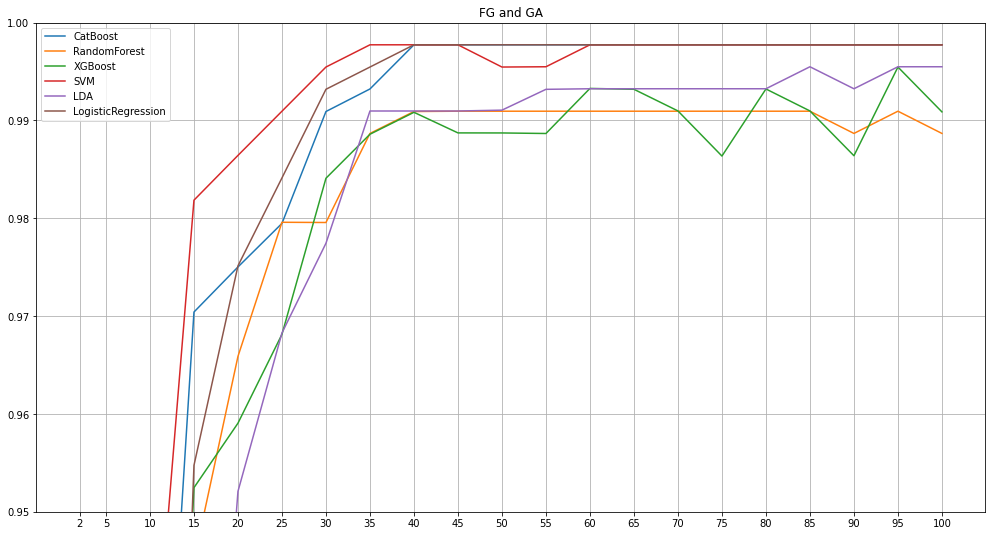

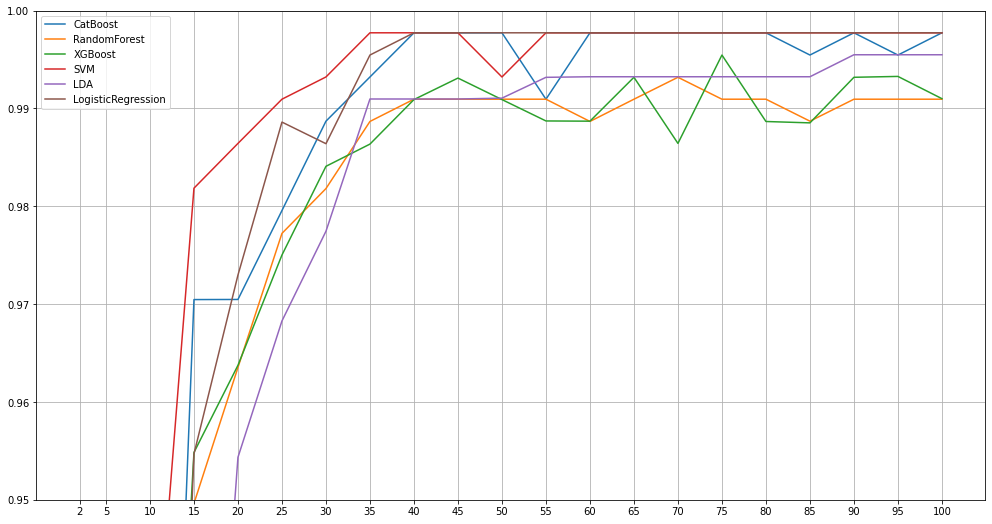

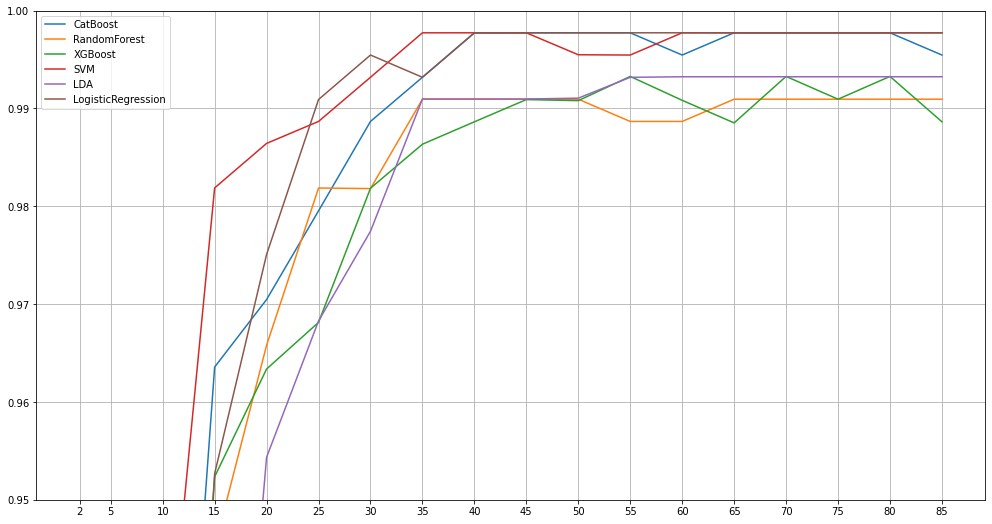

In [30]:
needed_data_tags = ['all', 'fg', 'ga']
for needed_data in needed_data_tags:
    metrics_array = plot_metrics(needed_data, models, [0.95, 1])

### Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
def get_confusion_matrix(
    model_name,
    model_class,
    components,
    needed_data,
    random_state=42,
):
    X, y = get_decomposed_data(
        fg_file="dataSrc/fg3_1-12.csv", 
        ga_file="dataSrc/ga_2_3_5_6.csv",
        n_components=components,
        needed_data=needed_data
    )
    with open(f'best_params/{components}/{needed_data}_{model_name}.yml', 'r') as f:
        parameters = yaml.safe_load(f)
        
    metrics, (_, y_pred, test_indexes) = ml_class_train_template(
        X,
        y,
        model_class,
        args=parameters,
        k_folds = 5,
        test_size = 0.2,
        method = "choice",
        random_state=random_state,
        custom_folds_strategy=True,
    )
    
    conf_matrix = confusion_matrix(y[test_indexes], y_pred, labels=np.unique(y[test_indexes]))
    
    
    return np.round(conf_matrix, 2)

In [34]:
cf = get_confusion_matrix(
    "SVM",
    SVC,
    100,
    "all"
)

In [35]:
def make_confusion_matrix(
    cf,
    group_names=None,
    categories='auto',
    count=True,
    percent=True,
    cbar=True,
    xyticks=True,
    xyplotlabels=True,
    sum_stats=True,
    figsize=None,
    cmap='Blues',
    title=None,
    base_font_size=10,
):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
#         print(np.ones((cf.shape[0], cf.shape[0]))*np.sum(cf, axis=1).reshape(1, -1))
        new_cf = [
            value for value in cf.flatten()/(np.ones(cf.shape)*np.sum(cf, axis=1).reshape(1, -1)).flatten()
        ]
        group_percentages = ["{0:.2%}\n".format(value) for value in new_cf]
        new_cf = np.array(new_cf).reshape(cf.shape)
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_percentages,group_counts)]
#     print(box_labels)
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


#     # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
#     if figsize==None:
#         #Get default figure size if not set
#         figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize, dpi=300)
#     print(box_labels)
    res = sns.heatmap(
        new_cf,
        annot=box_labels,
        fmt='',
        cmap=cmap,
        cbar=cbar,
        xticklabels=categories,
        yticklabels=categories,
        annot_kws={
                'fontsize': base_font_size*1.6
        }
    )
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = base_font_size*1.3)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = base_font_size*1.3)

    if xyplotlabels:
        plt.ylabel('True label', fontsize=base_font_size*1.5)
        plt.xlabel('Predicted label' + stats_text, fontsize=base_font_size*1.5)
    else:
        plt.xlabel(stats_text, fontsize=base_font_size*1.5)
    
    if title:
        plt.title(title, fontsize=base_font_size*2.5)
        

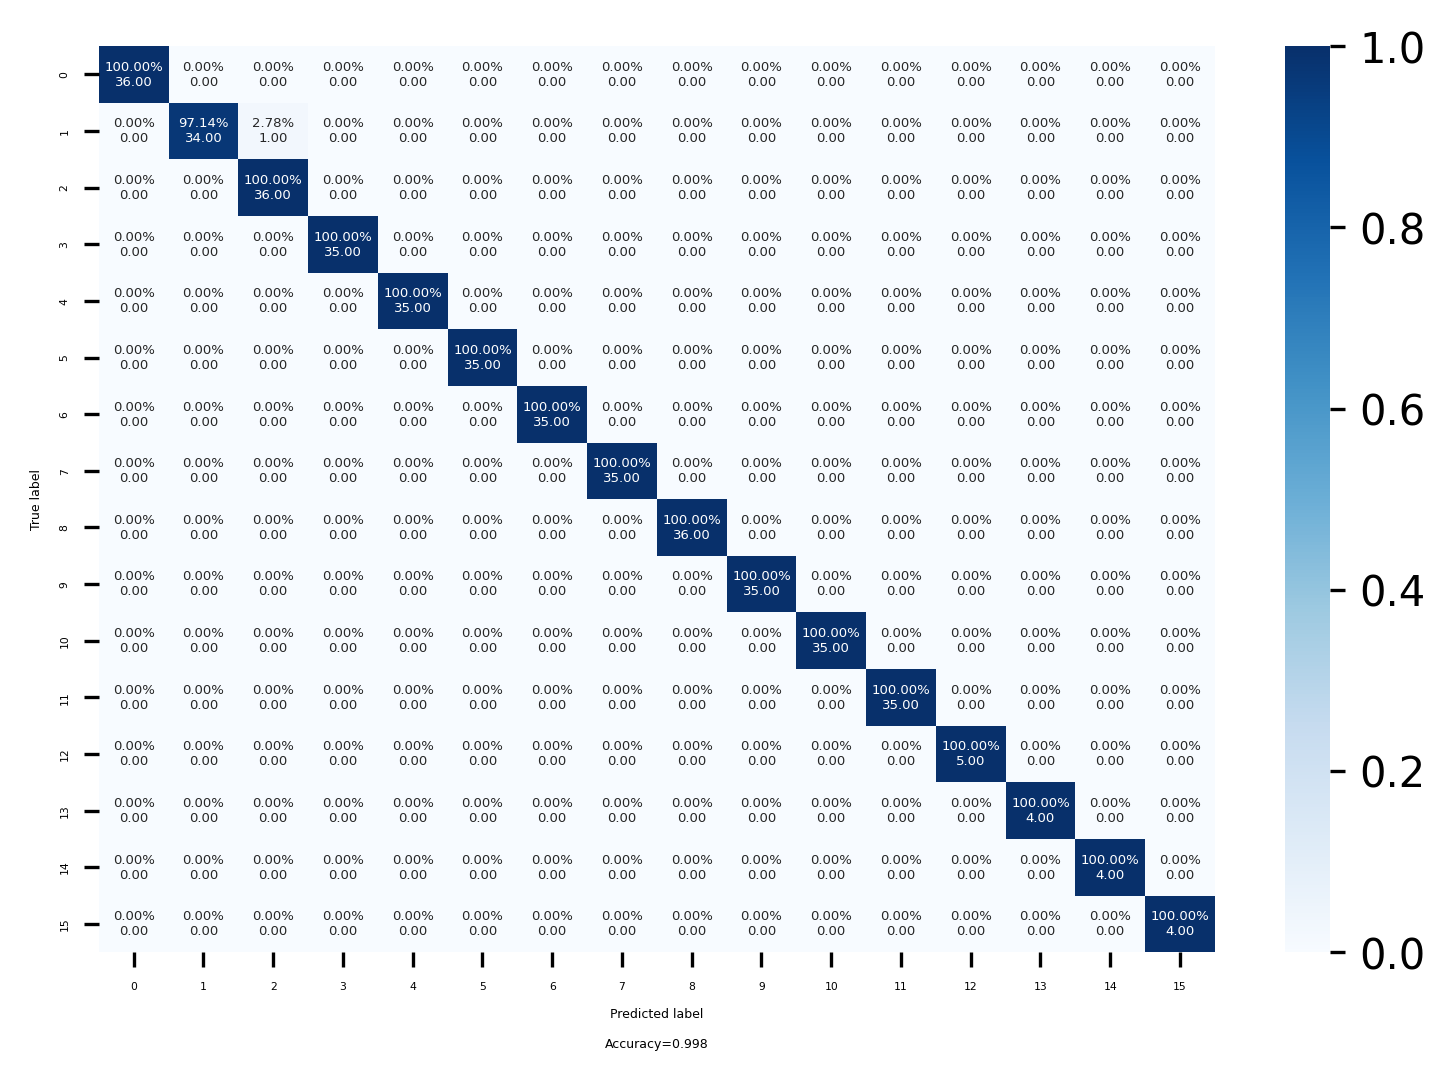

In [36]:
make_confusion_matrix(
    cf,
    group_names=None,
    categories='auto',
    count=True,
    percent=True,
    cbar=True,
    xyticks=True,
    xyplotlabels=True,
    sum_stats=True,
    figsize=None,
    cmap='Blues',
    title=None,
    base_font_size=2,
)

## Other

### Прошлые функции

In [6]:
def get_threshold(
    classes,
    n_components,
    title,
#     xlim,
    method='mean',
    figsize=(9, 6),
    print_plots=True,
):
    if classes is not "fibrinogen_b":
        X_first, y_first, X_second, y_second = split_dataset(
            X=None,
            y=None,
            first_file="dataSrc/ga_2_3_5_6.csv", 
            second_file="dataSrc/fg_1-5_7-11.csv", 
            header='infer',
            classes=classes
        )
    else:
        X_first, y_first, X_second, y_second = split_dataset_new()

    datasets = [(X_first, y_first), (X_second, y_second),]# (np.vstack((X_first, X_second)), )]
    data_names = ['before_hydrolysis', 'after_hydrolysis',]# 'Full dataset']
    colors = ['r', 'g']
    right_n_comp = dict()
    if print_plots:
        plt.figure(dpi=300, figsize=figsize)
    for dataset, names, color in zip(datasets, data_names, colors):
        pca = PCA(n_components=min(n_components, dataset[0].shape[0]))
        X_decomposed = pca.fit_transform(dataset[0])
        cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)
#         cumsum = pca.explained_variance_ratio_ * 100
        if print_plots:
            plt.plot(
                np.arange(1, pca.n_components_ + 1),
                cumsum,
                c=color,
                label=names.replace("_", " ") + ",\n accumulated variance"
            )
            plt.grid()
            plt.ylabel('% of explained variance')
            plt.xlabel('Number of PCA components')
        array = []
        print(len(dataset[0]) -1)
        print(pca.singular_values_.shape, dataset[0].shape)
        full_dataset_variance = (pca.singular_values_**2 / (len(dataset[0]) -1)).sum()
        for class_num in np.unique(dataset[1]):
            new_dataset = dataset[0][dataset[1] == class_num]

            pca = PCA(n_components=min(n_components, new_dataset.shape[0]))
            X_decomposed = pca.fit(new_dataset)
            array.append([len(new_dataset), (pca.singular_values_**2 / (len(dataset[0]) -1)).sum()])
        if method == 'mean':
            class_variance = 1 - sum([arr[0] * arr[1] for arr in array]) / sum([arr[0] for arr in array]) / full_dataset_variance
        elif method == 'min':
            class_variance = 1 - min([arr[1] for arr in array]) / full_dataset_variance
        elif method == 'max':
            class_variance = 1 - max([arr[1] for arr in array]) / full_dataset_variance
        else:
            raise Exception(f"'method' argument must be in ('mean', 'min', 'max'), not {method}")
        class_variance *= 100
        
        var_array = cumsum < class_variance
        argmax = var_array.sum() + 1
        right_n_comp[classes+"_"+names] = argmax
        if print_plots:
            plt.plot(
                np.arange(min(n_components, dataset[0].shape[0])), 
                np.ones(min(n_components, dataset[0].shape[0])) * class_variance, 
                linestyle="--",
                linewidth=1,
                c=color,
                label=names.replace("_", " ")+f",\n target variance at {argmax} PC," + f"\n{round(class_variance, 1)}%"
            )
            plt.scatter(argmax, class_variance, c=color, s=10)

    if print_plots:
#         plt.title(title.capitalize())
#         plt.xlim(xlim)
        plt.legend()
        plt.grid()
#         plt.ylim((10, 0))
#         plt.yscale('log')
        plt.show()
    return right_n_comp

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_27748/366172539.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if classes is not "fibrinogen_b":


In [7]:
get_threshold(
#     classes = "fibrinogen&albumin",
#     classes = "fibrinogen_b",
#     classes = "fibrinogen",
    classes = "albumin",
    n_components = 120,
    title='Fibrinogen, mean',
#     xlim=(0, 40),
    figsize=(3, 8),
    method='min',
    print_plots=True
)

/tmp/ipykernel_27748/366172539.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if classes is not "fibrinogen_b":
/tmp/ipykernel_27748/366172539.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if classes is not "fibrinogen_b":
/tmp/ipykernel_27748/366172539.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if classes is not "fibrinogen_b":
/tmp/ipykernel_27748/366172539.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if classes is not "fibrinogen_b":


NameError: name 'split_dataset' is not defined

In [364]:
def train_models(
    X,
    y,
    models,
    models_names,
    args_tuple,
    array_of_components,
    decomposition_class,
    k_folds=5,
    test_size=0.2,
    feature_importances=False,
    file_name=None
):
#     print(type(args_tuple), args_tuple)
    metrics_result = []
    for components in array_of_components:
#         print(components)
        if components >= min(X.shape[0], X.shape[1]):
            break
        X_decomp = make_decomposition(
            X, 
            components,
            decomposition_class
        )
        
        metrics_dict = dict()
        for index, (model, args, name) in enumerate(zip(models, args_tuple, models_names)):
            metrics, _ = ml_class_train_template(
                X=X_decomp, 
                y=y, 
                model_class=model,
                args=args,
                k_folds=k_folds,
                test_size=test_size,
                file_name=None,
                feature_importances=feature_importances,
            )
            metrics_dict[name] = metrics
        metrics_result.append(metrics_dict)
    if file_name is not None:
        with open(file_name, 'wb') as f:
            pickle.dump(metrics_result, f)
    return metrics_result

In [694]:
def train_all(
    models,
    models_names,
    args_tuple,
    array_of_components,
    decomposition_class,
    k_folds=5,
    test_size=0.2,
    tag="",
    feature_importances=False,
    save=False
):
    metrics_dict = dict()
#     for name in ['albumin', 'fibrinogen', 'fibrinogen&albumin']:
    for name in ['fibrinogen']:
#         X_first, y_first, X_second, y_second = split_dataset_new(
        X_first, y_first, X_second, y_second = split_dataset(
            X=None,
            y=None,
#             first_file="dataSrc/fg-new_123.csv", 
#             second_file="dataSrc/fg-new_456.csv", 
            first_file="dataSrc/ga_2_3_5_6.csv", 
            second_file="dataSrc/fg_1-5_7-11.csv", 
            classes="fibrinogen",
            header='infer',
        )
#         print(y_first, y_second)
        for X, y, description in zip(
            (X_first, X_second), 
            (y_first, y_second),
            ("before_hydrolysis", "after_hydrolysis"),
        ):
            metrics = train_models(
                X=X,
                y=y,
                models=models,
                models_names=models_names,
                args_tuple=args_tuple,
                array_of_components=array_of_components,
                decomposition_class=decomposition_class,
                k_folds=5,
                test_size=0.2,
                feature_importances=feature_importances,
                file_name=None,
            )
            metrics_dict[name+"_"+description] = metrics
    if save:
        with open(f'pca_metrics/metrics/additional_final_result{save}.pickle', 'wb') as f:
            pickle.dump(metrics_dict, f)
    return metrics_dict

In [378]:
tracker = eco2ai.Tracker(
    project_name="Raman Spectra",
    experiment_description="Calculating final averaged metrics for RandomForest, SVM, LDA",
    measure_period=30,
)
tracker.start_training(start_epoch=12)

In [380]:
num_iterations = 20
final_result = []
for i in tqdm(range(num_iterations)):
    final_result.append(
        train_all(
            models=[LinearDiscriminantAnalysis, SVC, ExtraTreesClassifier],#, CatBoostClassifier),
            models_names=["LDA", "SVM", "RandomForest"],#, "CatBoost"),
            args_tuple=(
                {
                    "solver": "svd"
                },
                {
                    "C": 1,
                    "kernel": "linear",
                },
                {
                    "n_estimators": 200,
                    "n_jobs": -1,
                    "warm_start": False,
                },
            ),
            array_of_components=np.arange(1, 658),
            decomposition_class=PCA,
            k_folds=5,
            test_size=0.2,
            tag="max_comp",
            feature_importances=False,
            save=str(i+1)
        )
    )
    tracker.new_epoch({"num_iter": i+1})

  0%|          | 0/20 [00:00<?, ?it/s]

/home/lazarev/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lazarev/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lazarev/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lazarev/.local/lib/python3.7/si

In [381]:
tracker.stop_training()

In [596]:
final_result = []
for i in range(20):
# for i in range(19):
    with open(f'pca_metrics/metrics/additional_final_result{i+1}.pickle', 'rb') as f:
#     with open(f'pca_metrics/metrics/final_metrics{i+1}.pickle', 'rb') as f:
        final_result.append(pickle.load(f))
len(final_result)

20

In [526]:
def process_metric_array(
    metric_array,
    models,
    components,
):
    metrics_dict = {
        model: []
        for model in models
    }
            
    for index in range(len(components)):
        for model in models:
#             metrics_dict[model]["accuracy"].append(float(metric_array[index][model]["accuracy"]))
            metrics_dict[model].append(float(metric_array[index][model]["weighted avg"]["f1-score"]))
    return metrics_dict

(48, 994) (48,) (41, 994) (41,)
47
(48,) (48, 994)
40
(41,) (41, 994)


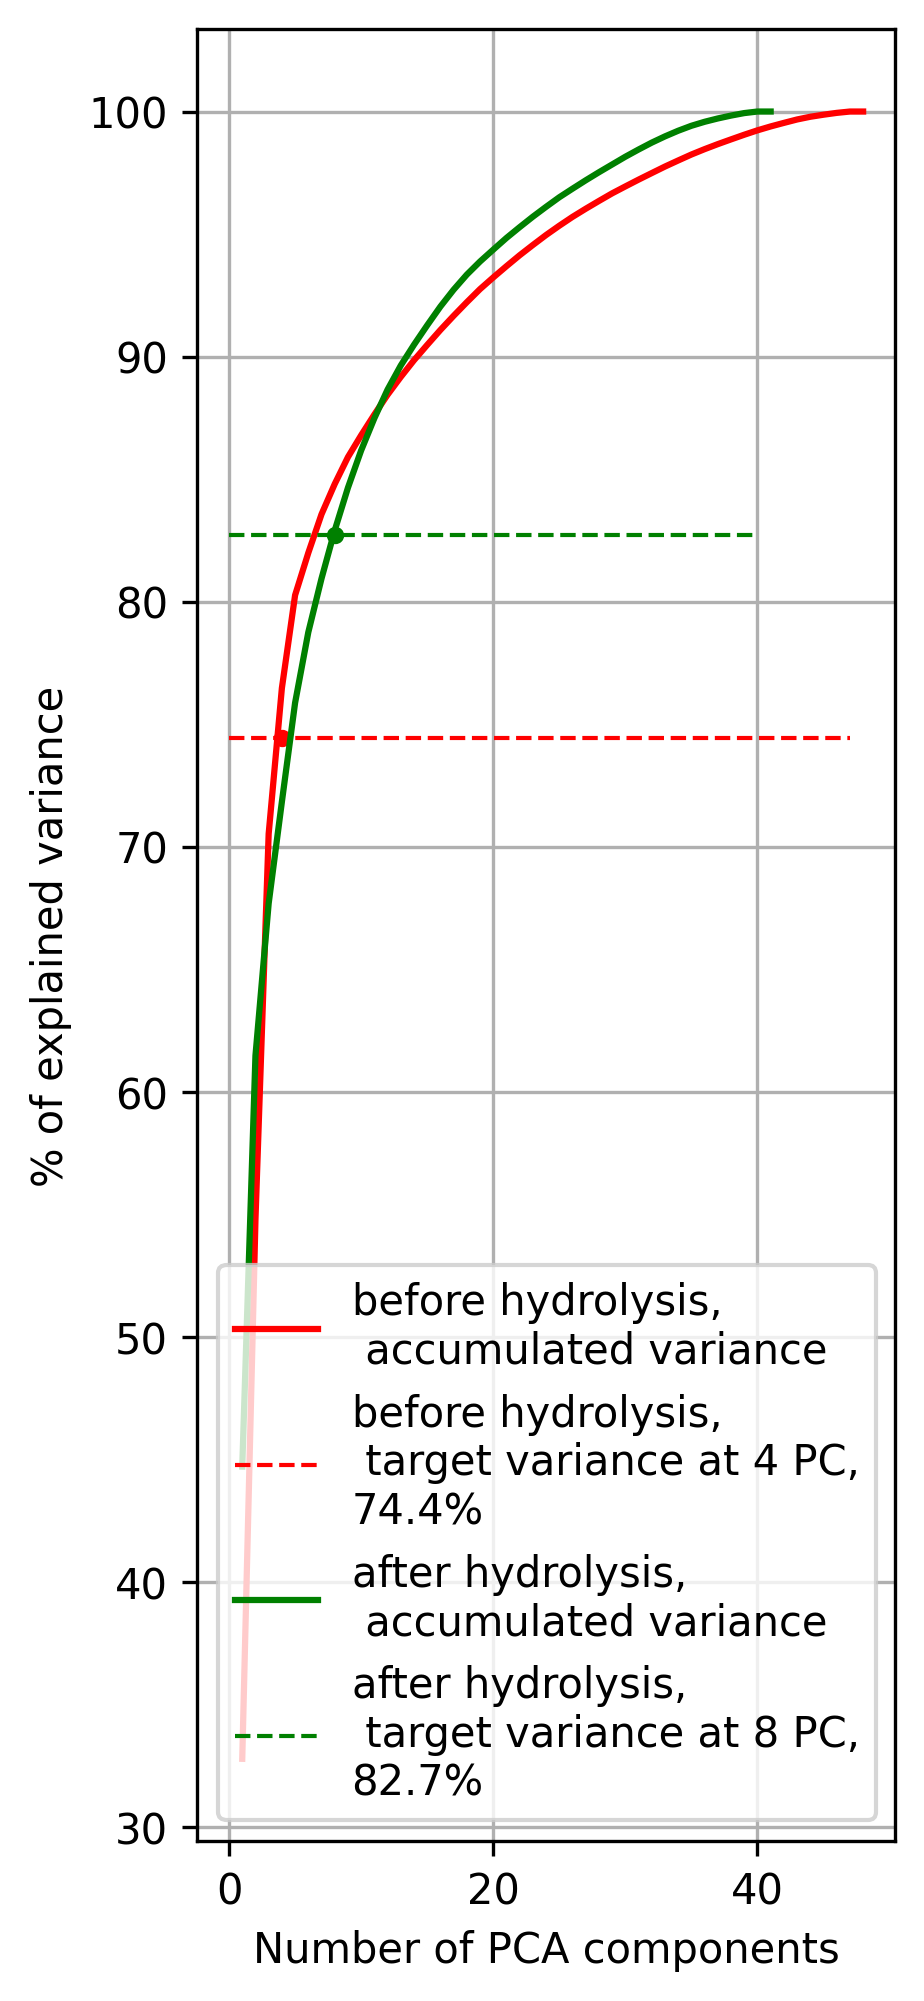

(340, 994) (340,) (229, 994) (229,)
339
(90,) (340, 994)
228
(90,) (229, 994)


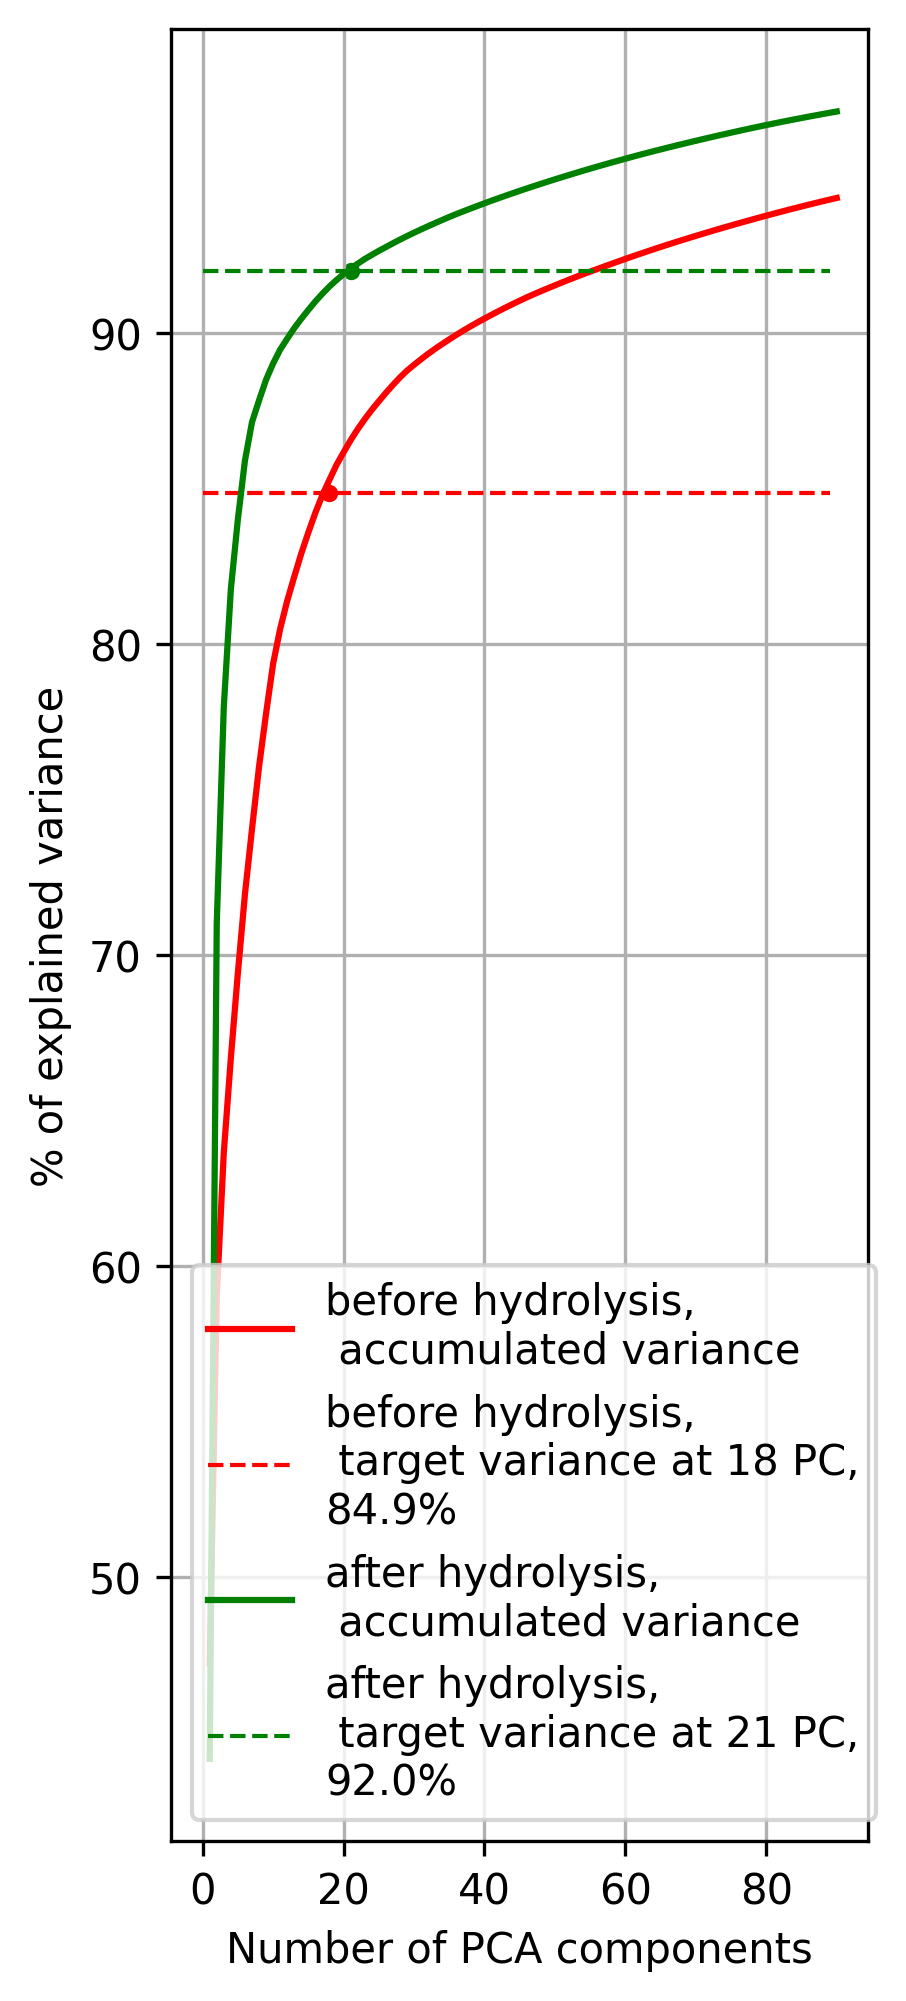

147
(90,) (148, 994)
147
(90,) (148, 994)


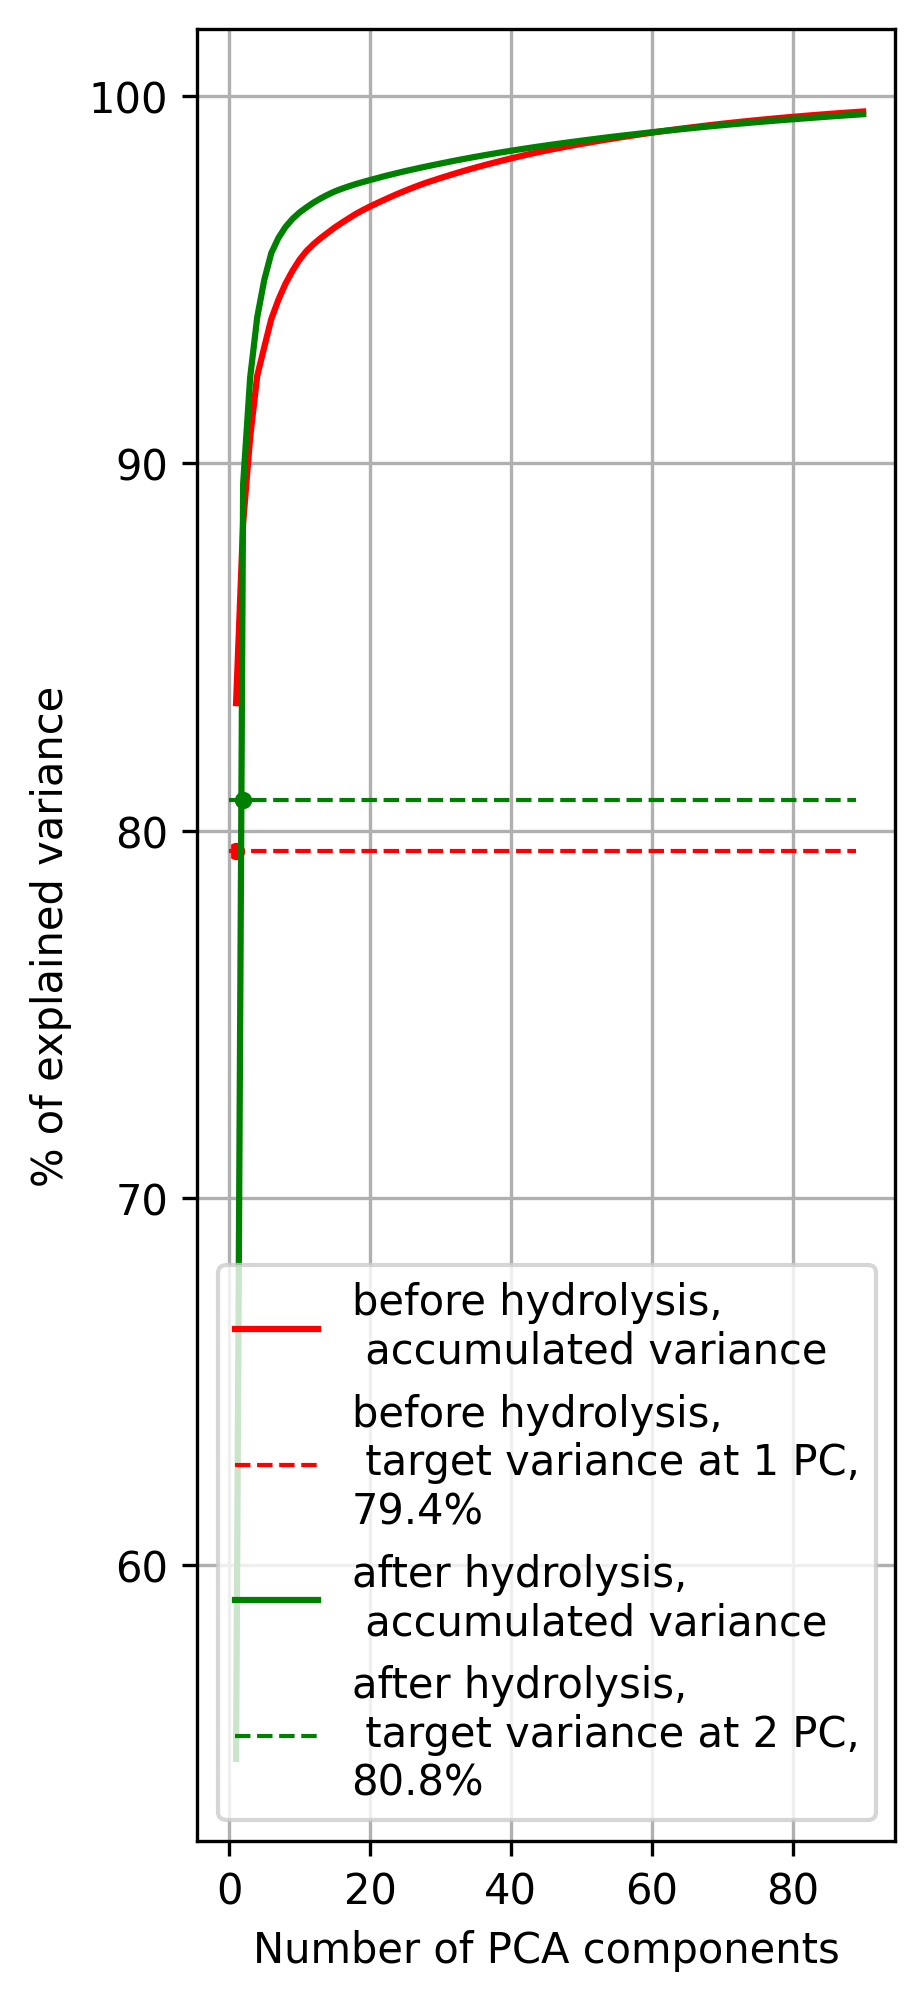

In [624]:
result_threashold_dict = dict()
method = "min"
# for name in ["fibrinogen"]:
for name in ["albumin", "fibrinogen", "fibrinogen_b", ]:
    tmp_dict = get_threshold(
        classes = name,
    #     classes = "fibrinogen",
        # classes = "albumin",
        n_components = 90,
        title=f"{name}",
#         xlim=(0, 90),
        method=method,
        figsize=(3, 8),
        print_plots=True
    )
    for key in tmp_dict.keys():
        result_threashold_dict[key] = tmp_dict[key]

### Conf Matrix

In [655]:
def make_confusion_matrix(
    cf,
    group_names=None,
    categories='auto',
    count=True,
    percent=True,
    cbar=True,
    xyticks=True,
    xyplotlabels=True,
    sum_stats=True,
    figsize=None,
    cmap='Blues',
    title=None,
    base_font_size=10,
):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
#         print(np.ones((cf.shape[0], cf.shape[0]))*np.sum(cf, axis=1).reshape(1, -1))
        new_cf = [
            value for value in cf.flatten()/(np.ones(cf.shape)*np.sum(cf, axis=1).reshape(1, -1)).flatten()
        ]
        group_percentages = ["{0:.2%}\n".format(value) for value in new_cf]
        new_cf = np.array(new_cf).reshape(cf.shape)
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_percentages,group_counts)]
#     print(box_labels)
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


#     # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
#     if figsize==None:
#         #Get default figure size if not set
#         figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize, dpi=300)
#     print(box_labels)
    res = sns.heatmap(
        new_cf,
        annot=box_labels,
        fmt='',
        cmap=cmap,
        cbar=cbar,
        xticklabels=categories,
        yticklabels=categories,
        annot_kws={
                'fontsize': base_font_size*1.6
        }
    )
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = base_font_size*1.3)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = base_font_size*1.3)

    if xyplotlabels:
        plt.ylabel('True label', fontsize=base_font_size*1.5)
        plt.xlabel('Predicted label' + stats_text, fontsize=base_font_size*1.5)
    else:
        plt.xlabel(stats_text, fontsize=base_font_size*1.5)
    
    if title:
        plt.title(title, fontsize=base_font_size*2.5)
        

In [662]:
result_mean.keys()

dict_keys(['albumin_before_hydrolysis', 'albumin_after_hydrolysis', 'fibrinogen_before_hydrolysis', 'fibrinogen_after_hydrolysis', 'fibrinogen&albumin_before_hydrolysis', 'fibrinogen&albumin_after_hydrolysis'])

In [635]:
def get_confusion_matrix(
    metric_array,
    model,
    components,
    threshold,
):
#     print(len(metric_array), len(components))
    if len(metric_array) < len(components):
        
        components = components[:len(metric_array)]
    components = components[threshold:]
#     print(len(metric_array), len(components))
    result_matrix = np.zeros_like(
        metric_array[0][model]['confusion_matrix']
    )
    for component in components:
#         print(component)
        np.add(
            result_matrix, 
            metric_array[component][model]['confusion_matrix'], 
            out=result_matrix, 
            casting="unsafe"
        )
#         result_matrix += metric_array[component][model]['confusion_matrix']
    result_matrix = result_matrix.astype('float64')
    result_matrix /= len(components)
    
    return np.round(result_matrix, 2)

[[4.98 0.02]
 [0.   5.  ]]
[[5.   0.  ]
 [0.03 3.97]]
[[14.27  0.    0.    0.    0.73]
 [ 0.   11.96  0.04  0.    0.  ]
 [ 0.    0.   10.81  1.19  0.  ]
 [ 0.    0.    0.36 14.59  0.06]
 [ 0.    0.    0.    0.14 13.86]]
[[ 9.81  0.    0.    0.    0.19]
 [ 0.    6.    0.    0.    0.  ]
 [ 0.    0.   10.    0.    0.  ]
 [ 0.    0.    0.    9.    0.  ]
 [ 0.07  0.    0.    0.   10.93]]


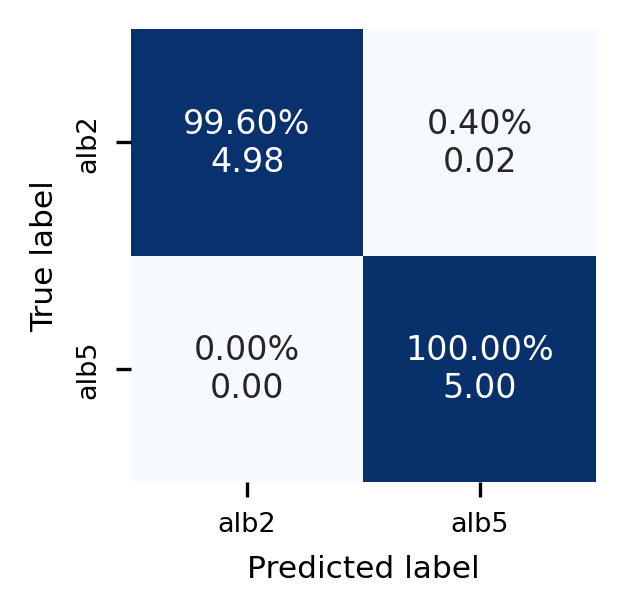

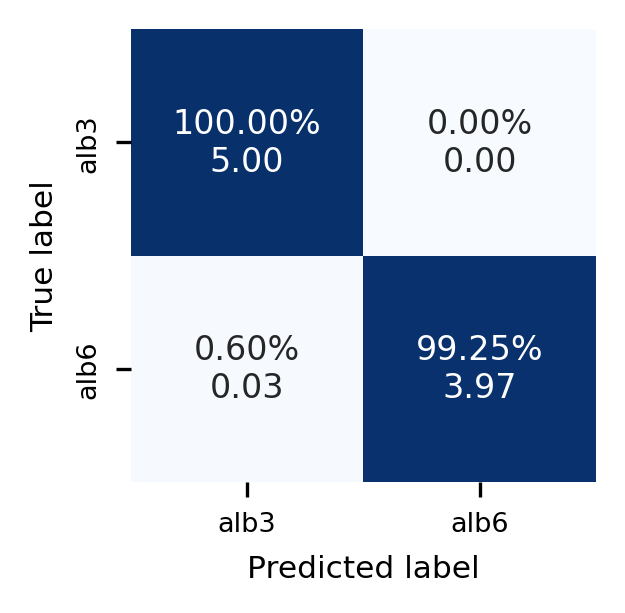

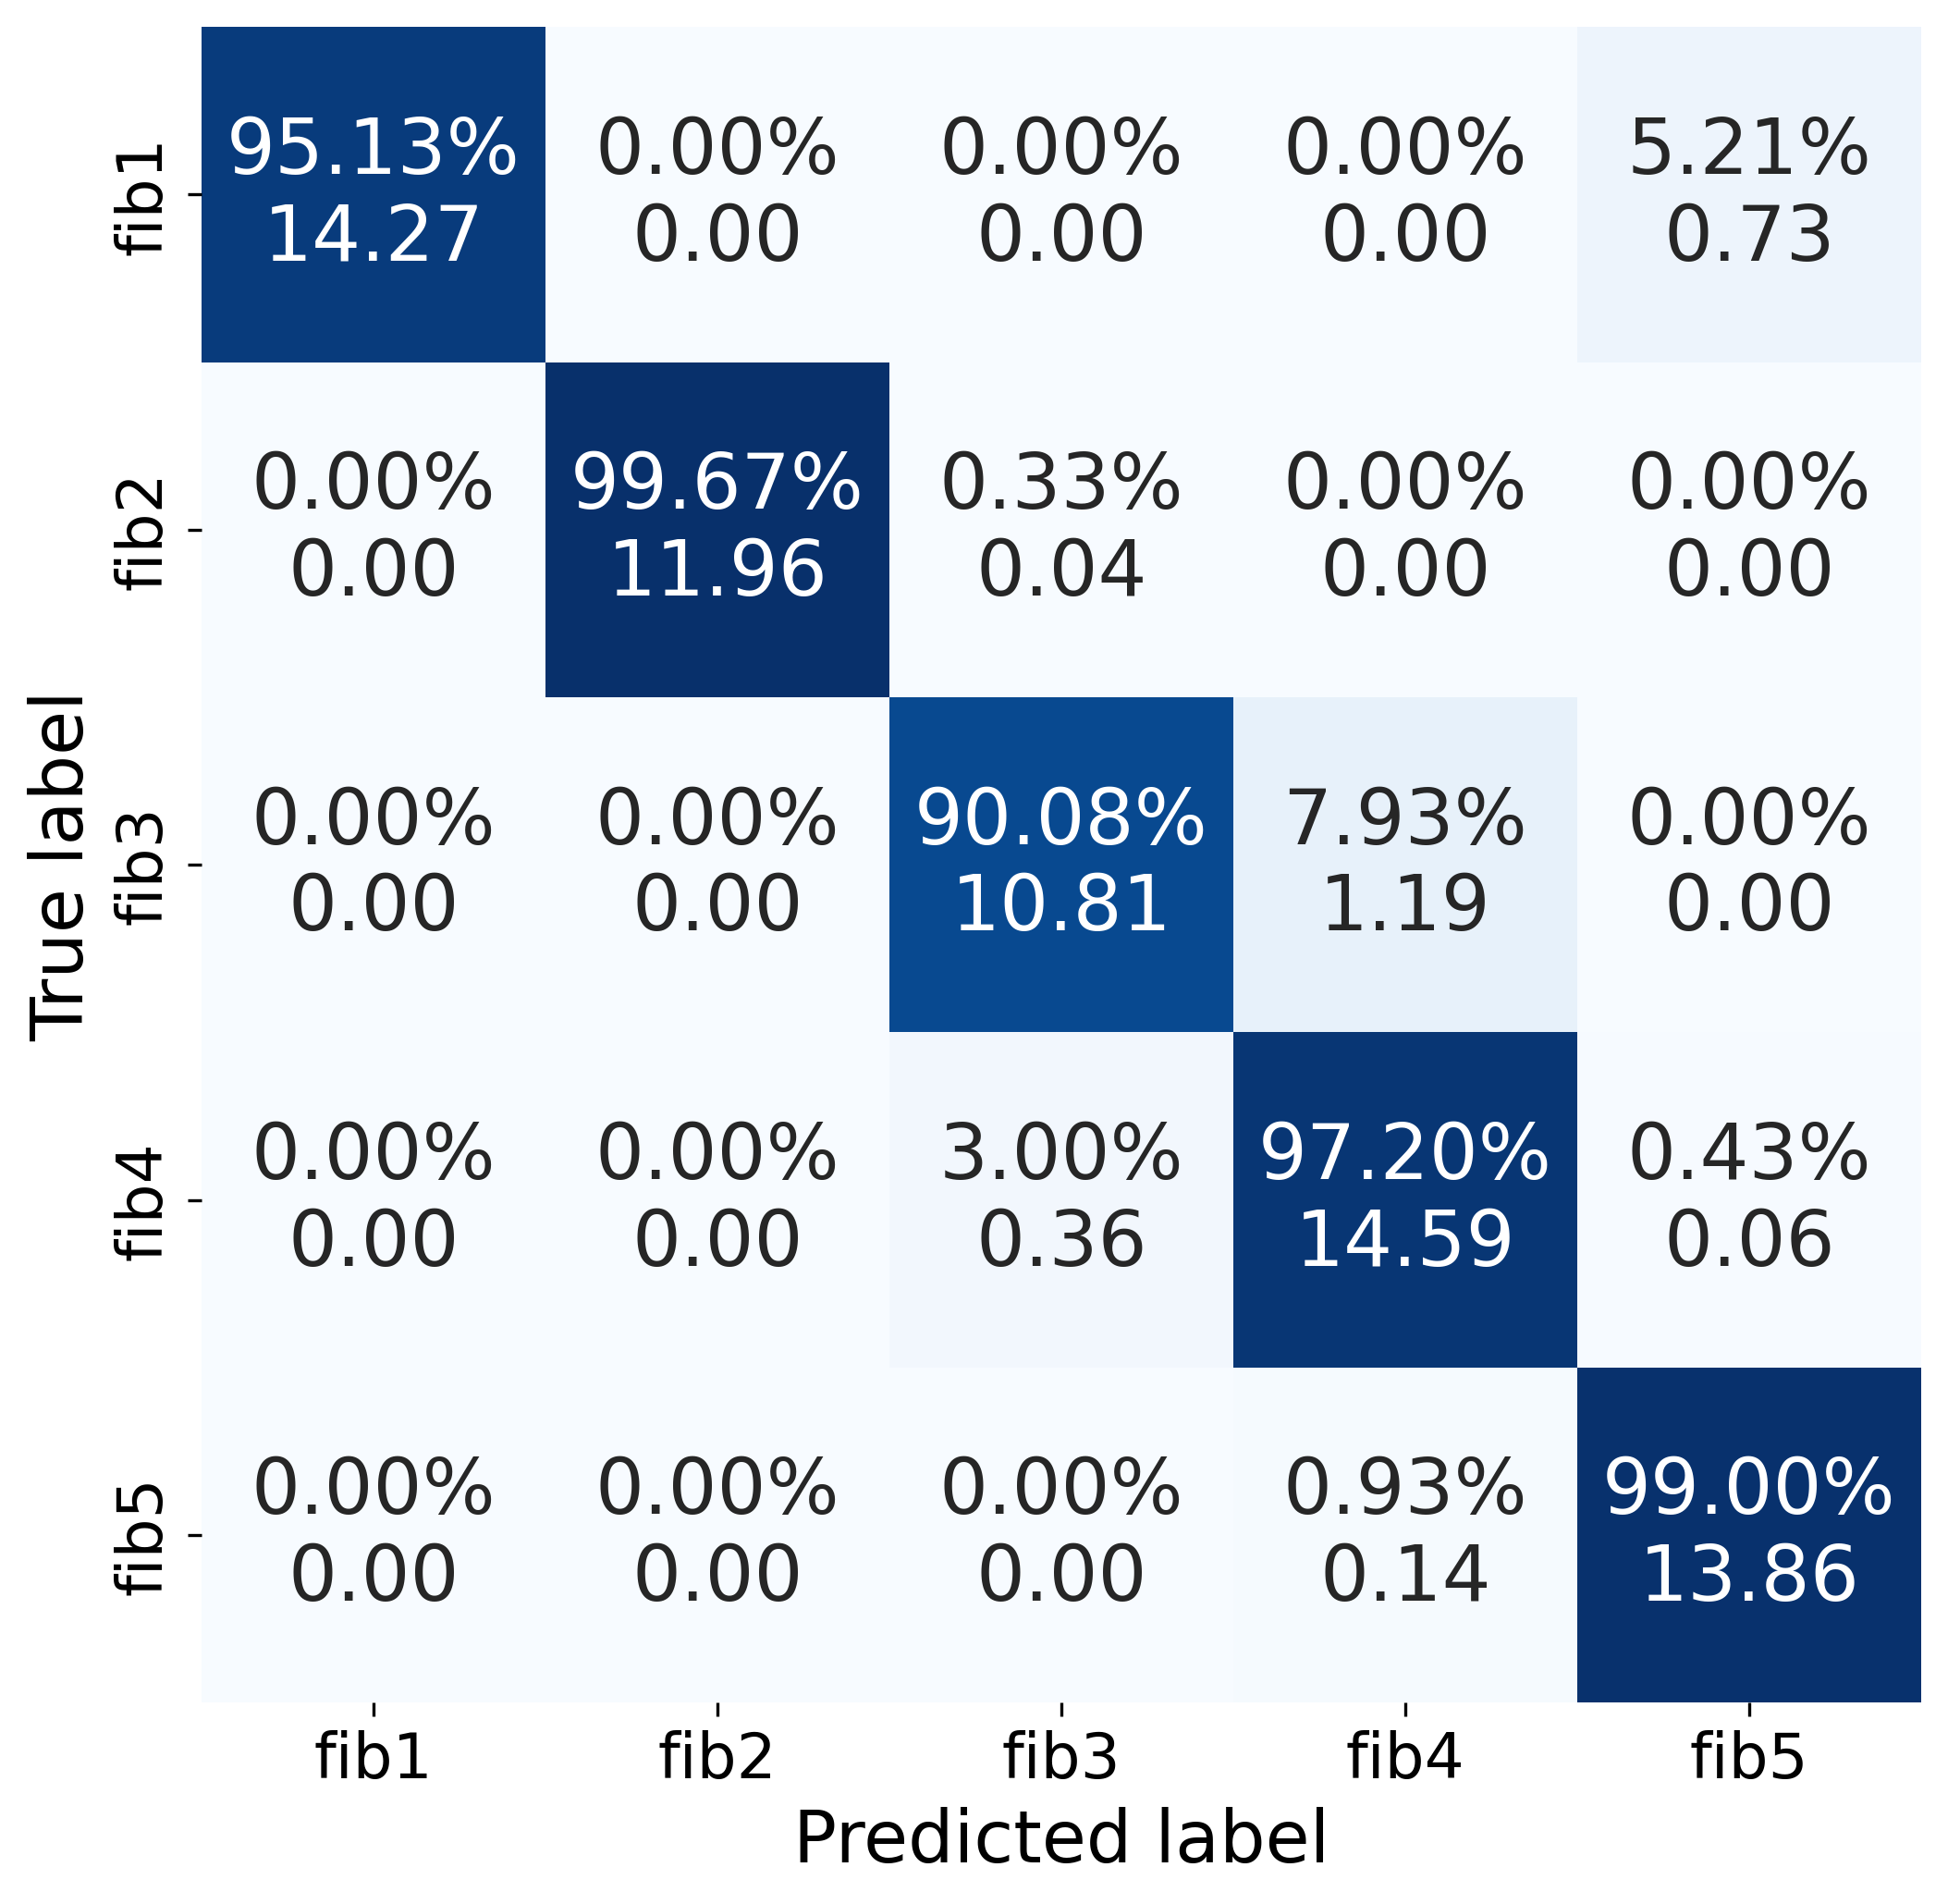

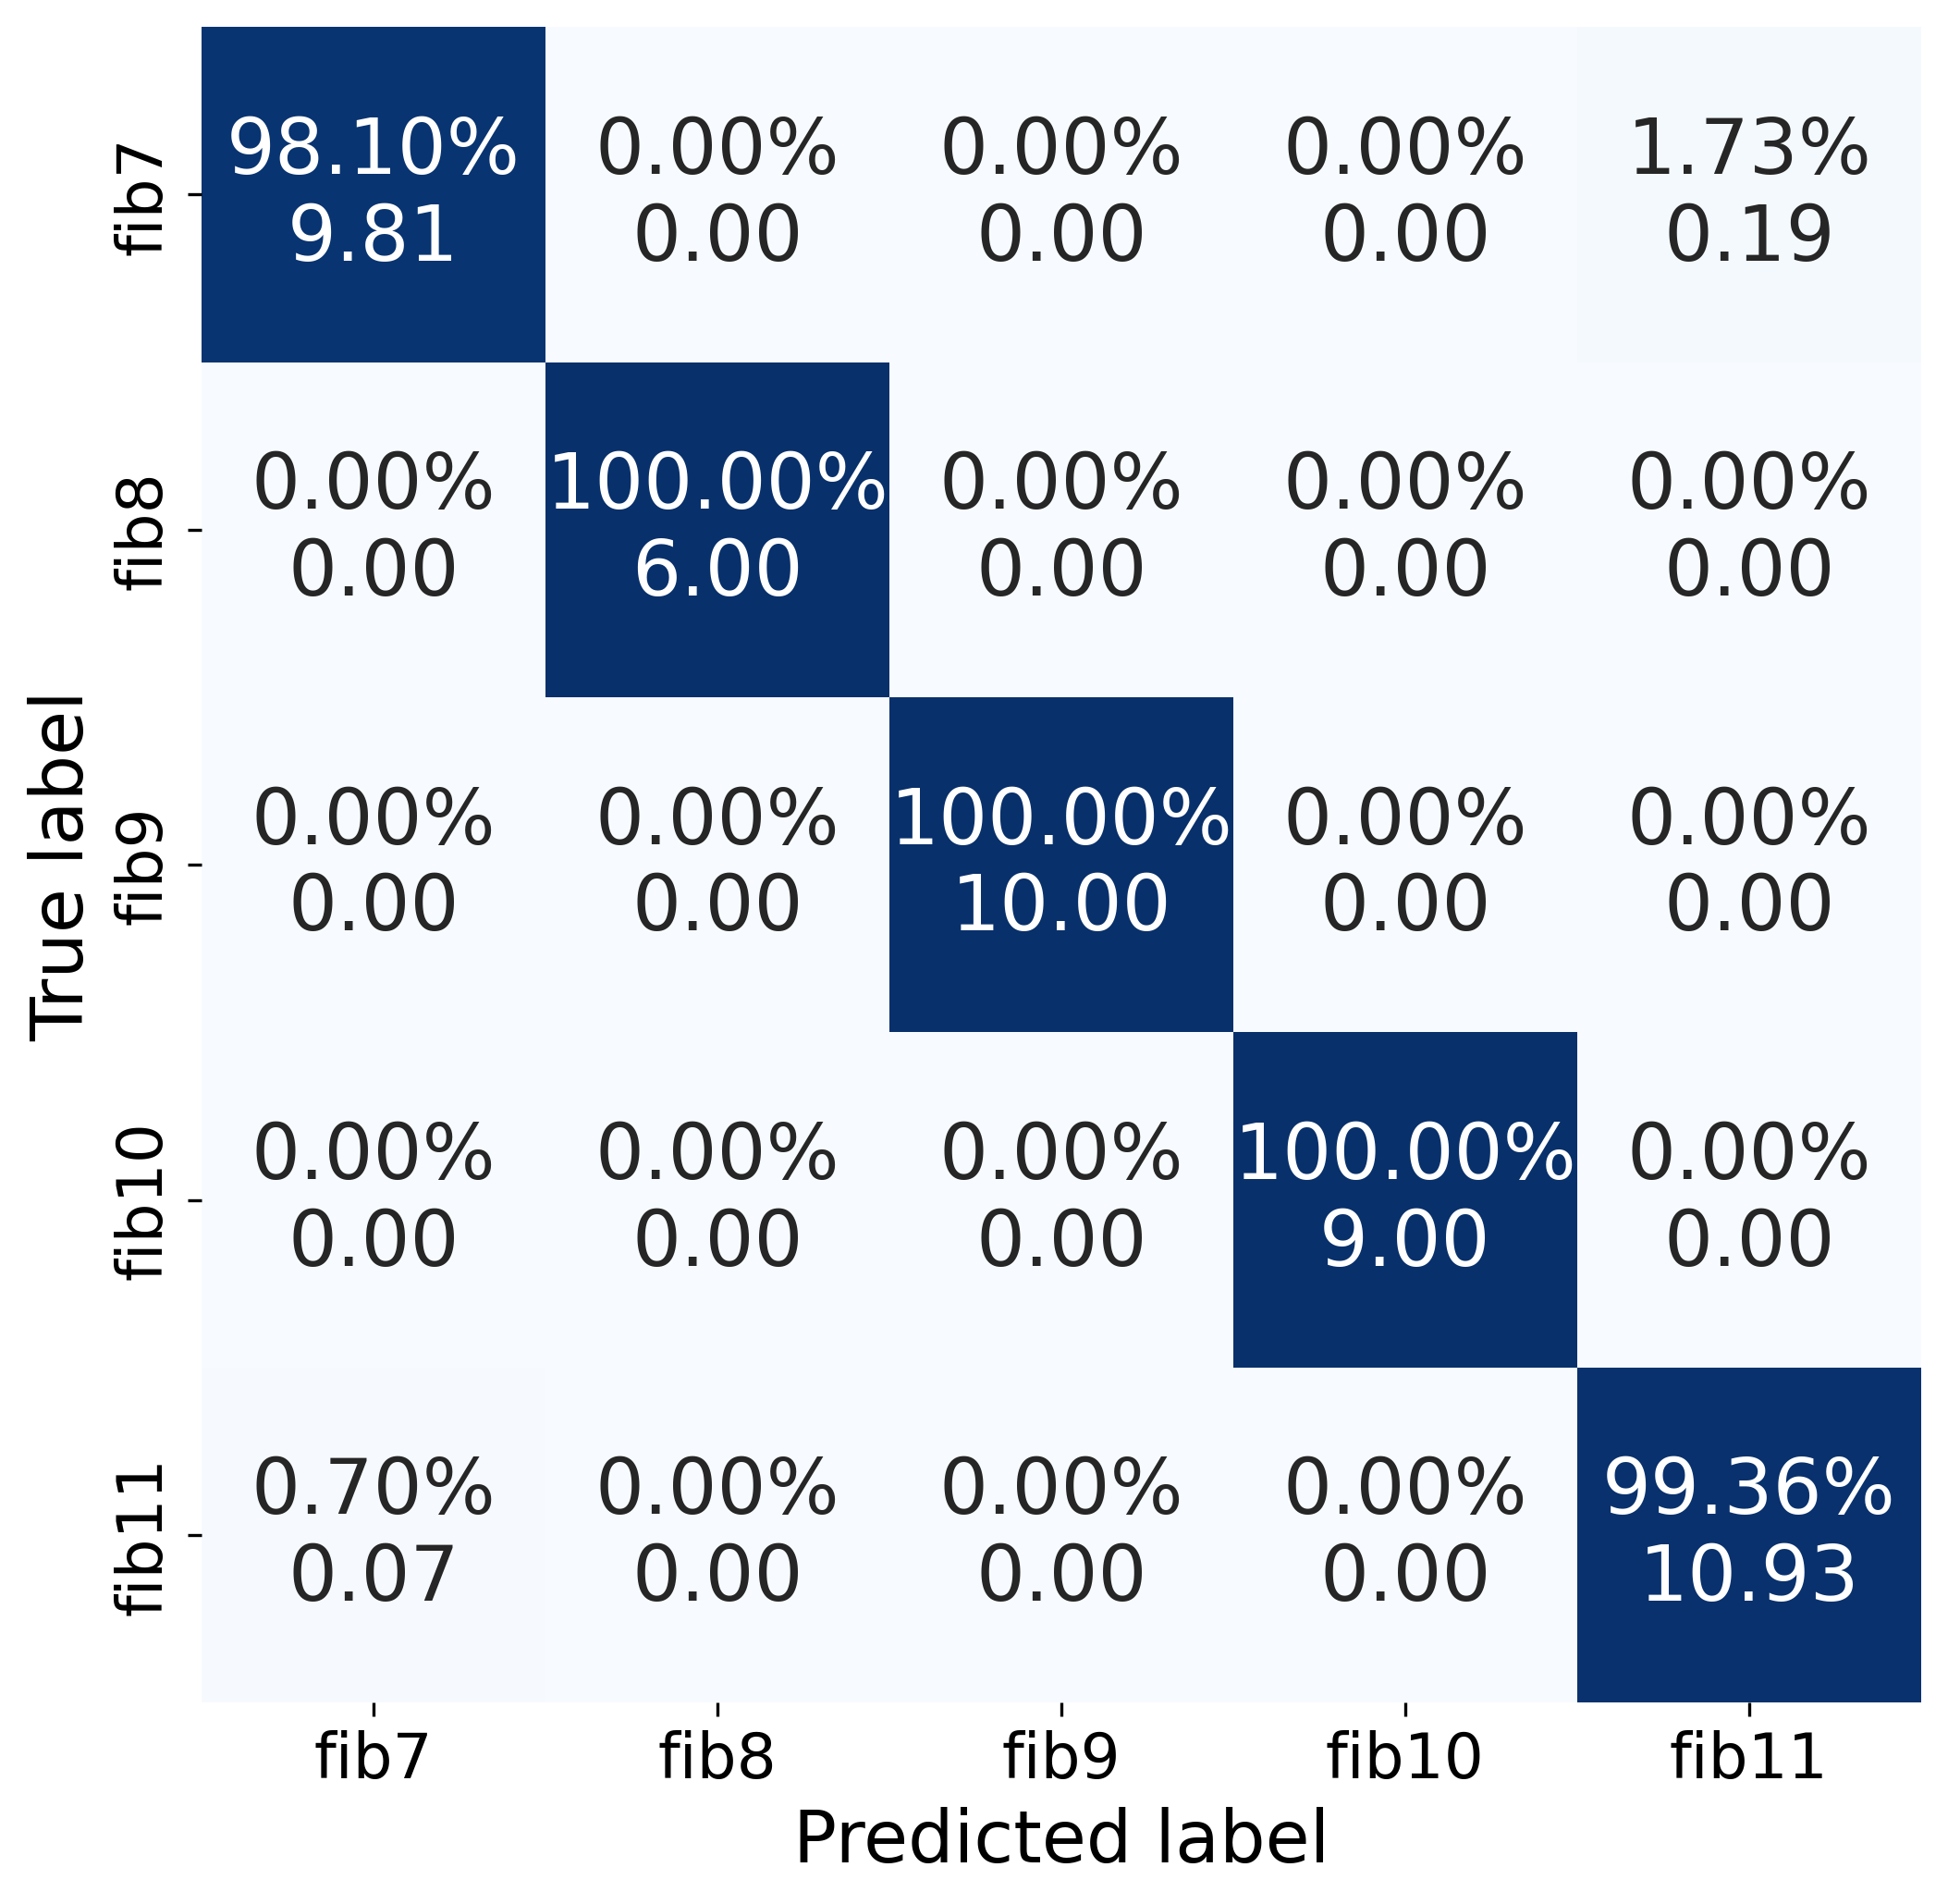

In [666]:
classes_groups = [
    ["alb2", "alb5"],
    ["alb3", "alb6"],
    ["fib1", "fib2", "fib3" ,"fib4" ,"fib5"],
    ["fib7" ,"fib8" ,"fib9" ,"fib10" ,"fib11"],
#     ["fib1", "fib2", "fib3"],
#     ["fib4" ,"fib5" ,"fib6"],
]
datasets = [
    'albumin_before_hydrolysis', 
    'albumin_after_hydrolysis', 
    'fibrinogen_before_hydrolysis', 
    'fibrinogen_after_hydrolysis' 
]
multiplier = 2
syllable = 2
for key, group, dataset in zip(result_mean.keys(), classes_groups, datasets):
#     print(key)
    con_matrix = get_confusion_matrix(
        result_mean[key],
        model="SVM",
        components=np.arange(2, 90)-2,
        threshold=result_threashold_dict[key]
    )
    print(con_matrix)

    make_confusion_matrix(
        con_matrix,
        group_names=None,
        categories=group,
        count=True,
        percent=True,
        cbar=False,
        xyticks=True,
        xyplotlabels=True,
        sum_stats=False,
        figsize=(len(group)*multiplier - syllable, len(group)*multiplier-syllable),
        cmap='Blues',
        title=False,
        base_font_size=2.5*len(group)
    )

In [487]:
import copy

In [640]:
final_result = []
# for i in range(20):
for i in range(19):
#     with open(f'pca_metrics/metrics/additional_final_result{i+1}.pickle', 'rb') as f:
    with open(f'pca_metrics/metrics/final_metrics{i+1}.pickle', 'rb') as f:
        final_result.append(pickle.load(f))
len(final_result)

19

In [697]:
count = 20

datasets = [
#     'albumin_before_hydrolysis', 'albumin_after_hydrolysis', 
    'fibrinogen_before_hydrolysis', 'fibrinogen_after_hydrolysis', 
#     'fibrinogen&albumin_before_hydrolysis', 'fibrinogen&albumin_after_hydrolysis'
]
models = ['SVM']
# models = ['SVM', 'LDA', 'RandomForest']
result_mean = copy.deepcopy(final_result[0])

for dataset in datasets:
    for index in range(len(final_result[0][dataset])):
        for model in models:
            result_mean[dataset][index][model]["accuracy"] = (
                statistics.mean([final_result[i][dataset][index][model]["accuracy"] for i in range(count)])
            )
            result_mean[dataset][index][model]["weighted avg"]["f1-score"] = (
                statistics.mean([final_result[i][dataset][index][model]["weighted avg"]["f1-score"] for i in range(count)])
            )

            
result_std = copy.deepcopy(final_result[0])

for dataset in datasets:
    for index in range(len(final_result[0][dataset])):
        for model in models:
            result_std[dataset][index][model]["accuracy"] = (
                statistics.stdev([final_result[i][dataset][index][model]["accuracy"] for i in range(count)])
            )
            result_std[dataset][index][model]["weighted avg"]["f1-score"] = (
                statistics.stdev([final_result[i][dataset][index][model]["weighted avg"]["f1-score"] for i in range(count)])
            )

In [643]:
result_mean.keys()

dict_keys(['albumin_before_hydrolysis', 'albumin_after_hydrolysis', 'fibrinogen_before_hydrolysis', 'fibrinogen_after_hydrolysis', 'fibrinogen&albumin_before_hydrolysis', 'fibrinogen&albumin_after_hydrolysis'])

In [547]:
# def get_max_metric_full(
#     metrics_array_mean,
# #     metrics_array_std,
#     models,
#     components=np.arange(2, 568),
# ):
#     if len(metrics_array_mean) < len(components):
#         components = components[:len(metrics_array_mean[0])]
#     processed_metrics_mean = {
#         model: [] for model in models
#     }
#     for metric_array in tqdm(metrics_array_mean):
# #         print(metric_array)
#         tmp_dict = process_metric_array(
#             metric_array=metric_array,
#             models=models,
#             components=components,
#         )
#         for model in models:
#             processed_metrics_mean[model]+=tmp_dict[model]
            
# #     print(processed_metrics_mean)
# #         break
# #     processed_metrics_std = process_metric_array(
# #         metric_array=metrics_array_std,
# #         models=models,
# #         components=components,
# #     )
#     for model in models:
#         tmp_array_mean = processed_metrics_mean[model]
#         counts, intervals, _ = plt.hist(tmp_array_mean, bins=np.linspace(0, 1, 101), label=model)
# #         print(counts, intervals)
#         index_max = counts.argmax()
        
#         plt.show()
# #         max_metric = max(tmp_array_mean)
# #         index_max = tmp_array_mean.index(max_metric)
# #         std_error = processed_metrics_std[model]["f1-score"][index_max]
# #         print(f"{model}: {round(max_metric, 3)}+-{round(std_error, 3)}, num_comp={components[index_max]}")
# #         break
#     print()
#     return 

# datasets = [
# #     'albumin_before_hydrolysis', 
# #     'albumin_after_hydrolysis', 
#     'fibrinogen_before_hydrolysis', 
# #     'fibrinogen_after_hydrolysis', 
# ]
# models = ['SVM', 'LDA', 'RandomForest']

# for dataset in datasets:
#     print(dataset)
#     get_max_metric_full(
#         metrics_array_mean = [final_result[i][dataset] for i in range(count)],
# #         metrics_array_std = result_std[dataset],
#         models=["SVM", "LDA", "RandomForest"]
#     )
#     break

fibrinogen_before_hydrolysis
model: SVM. Counts = 55.0: 35.0
model: LDA. Counts = 8.0: 35.0
model: RandomForest. Counts = 12.0: 115.0

fibrinogen_after_hydrolysis
model: SVM. Counts = 103.0: 5.0
model: LDA. Counts = 36.0: 5.0
model: RandomForest. Counts = 20.0: 15.0



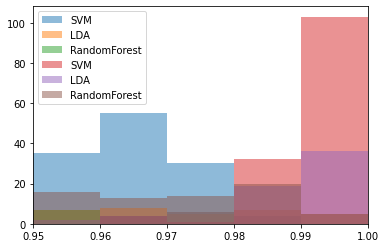

In [595]:
def get_max_metric(
    metrics_array_mean,
    metrics_array_std,
    models,
    components=np.arange(2, 568),
):
    if len(metrics_array_mean) < len(components):
        components = components[:len(metrics_array_mean)]
    processed_metrics_mean = process_metric_array(
        metric_array=metrics_array_mean,
        models=models,
        components=components,
    )
    processed_metrics_std = process_metric_array(
        metric_array=metrics_array_std,
        models=models,
        components=components,
    )
    for model in models:
        tmp_array_mean = processed_metrics_mean[model]
        counts, intervals, _ = plt.hist(tmp_array_mean, bins=np.linspace(0, 1, 101), alpha=0.5, label=model)
#         print(counts, intervals)
        index_max = counts.shape[0] - 1 - counts[::-1].argmax()
        print(f"model: {model}. Counts = {counts[index_max]}: {round((1-(intervals[index_max+1]+intervals[index_max])/2)*1000, 1)}")
#               ({round(intervals[index_max], 3)}, {round(intervals[index_max+1], 3)})")
#               
#               {round(1- intervals[index_max], 3)}, {round(1- intervals[index_max-1], 3)})")
#         max_metric = max(tmp_array_mean)
#         index_max = tmp_array_mean.index(max_metric)
#         std_error = processed_metrics_std[model]["f1-score"][index_max]
#         print(f"{model}: {round(max_metric, 3)}+-{round(std_error, 3)}, num_comp={components[index_max]}")
#         break
    print()
    return 

datasets = [
#     'albumin_before_hydrolysis', 
#     'albumin_after_hydrolysis', 
    'fibrinogen_before_hydrolysis', 
    'fibrinogen_after_hydrolysis', 
]
models = ['SVM', 'LDA', 'RandomForest']

for dataset in datasets:
    print(dataset)
    get_max_metric(
        metrics_array_mean = result_mean[dataset],
        metrics_array_std = result_std[dataset],
        models=["SVM", "LDA", "RandomForest"]
    )
    plt.xlim(0.95, 1)
    plt.legend()
#     break

In [424]:
def plot_metrics(
    metric_array,
    models,
    components,
    dataset,
    threshold_dict,
    ylim=(0.7, 1.01)
):
    if len(metric_array) < len(components):
        components = components[:len(metric_array)]
    metrics = process_metric_array(
        metric_array=metric_array,
        models=models,
        components=components,
    )
    
    plt.figure(dpi=300)
    plt.axvline(
        x=threshold_dict[dataset],
        label=f"target PC number = {threshold_dict[dataset]}",
        c='b'
            )
    return_result = dict()
    for model in models:
        for metric in ["f1-score"]:
#             mean_metric = sum(metrics[model][metric][threshold_dict[dataset]:threshold_dict[dataset]+30])
#             mean_metric /= len(metrics[model][metric][threshold_dict[dataset]:threshold_dict[dataset]+30])
#             mean_metric = round(mean_metric, 3)
            plt.plot(
                components, 
                metrics[model][metric],
                label=f"{metric} on {model}: {metrics[model][metric][threshold_dict[dataset]-2]}",
                c='r'
            )
            return_result[f"x_{dataset}_{model}"] = list(components)
            return_result[f"y_{dataset}_{model}"] = list(metrics[model][metric])
    plt.title(f"{dataset.replace('_', ' ').capitalize()}")
    plt.legend()
    plt.ylim(ylim)
    plt.grid()
    plt.show()
    
    return return_result

TypeError: list indices must be integers or slices, not str

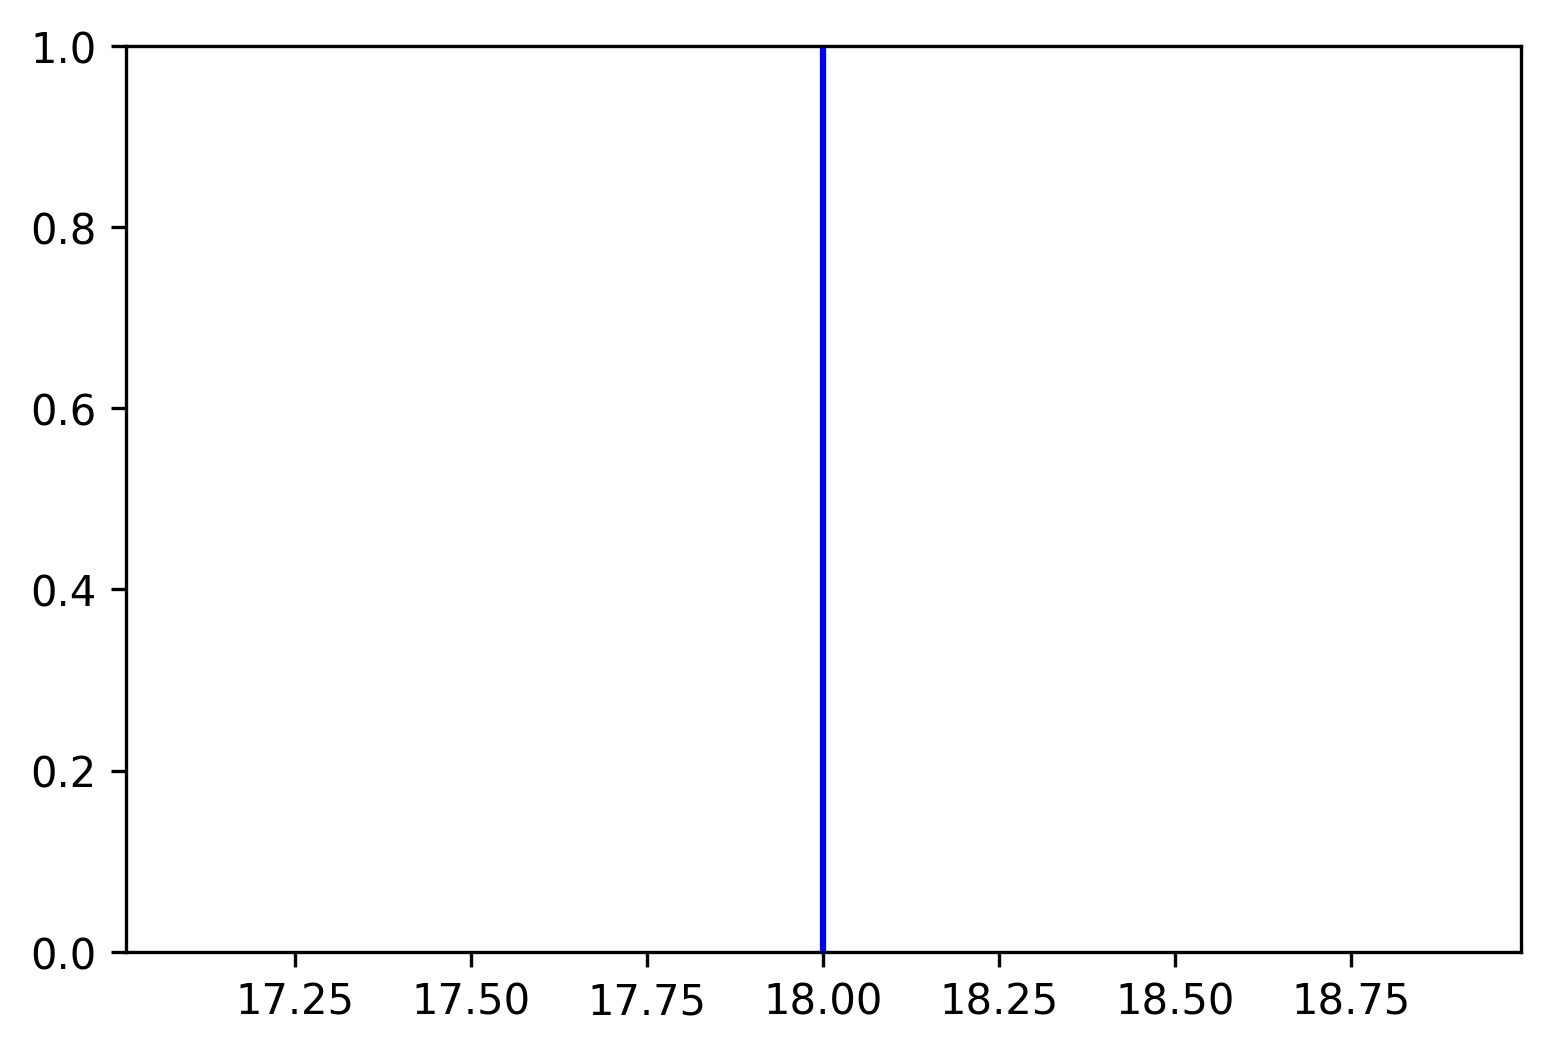

In [699]:
final_metrics_dict = dict()
# model = "RandomForest"
# model = "LDA"
model = "SVM"
for key in result.keys():
#     print(len(result[key]))
    final_metrics_dict.update(
        plot_metrics(
            metric_array=result[key],
            models=[model],
            components=np.arange(2, 568),
            dataset=key,
            threshold_dict=result_threashold_dict,
    #         ylim=(0, 0.2)
        )
    )

In [400]:
max_len = 0# max[len(final_metrics_dict[i]) for i in final_metrics_dict]
for i in final_metrics_dict:
    if len(final_metrics_dict[i]) > max_len:
        max_len = len(final_metrics_dict[i])
#     print(i)

for i in final_metrics_dict:
    final_metrics_dict[i] += [None for j in range(max_len - len(final_metrics_dict[i]))]
    
max_len = 0# max[len(final_metrics_dict[i]) for i in final_metrics_dict]
for i in final_metrics_dict:
    if len(final_metrics_dict[i]) > max_len:
        max_len = len(final_metrics_dict[i])
max_len

pd.DataFrame(final_metrics_dict).to_csv(f"{model}_model_additional.csv", index=False)

In [403]:
pd.concat(
    (
        pd.read_csv("RandomForest_model_additional.csv"),
        pd.read_csv("SVM_model_additional.csv"),
        pd.read_csv("LDA_model_additional.csv")
    ),
    axis=1, 
    join='inner'
).to_csv("all_models_additional.csv", index=False)

In [710]:
# def train_models(
#     X,
#     y,
#     num_estimators=500,
#     def_tuple=(random_forest_train, catboost_train), 
#     description_tuple=None, 
#     file_names_tuple=None,
#     calc_metrics=False
# ):
#     metrics_array = []
#     metrics_per_class = []
#     for index, func in enumerate(def_tuple):
#         X_train, X_test, y_train, y_test = train_test_split(
#             X, 
#             y, 
#             test_size=0.33, 
#             stratify=y
#         )
#         metrics, models = func(
#             data=X_train, 
#             y=y_train, 
#             k_folds=5,
#             num_estimators=num_estimators, 
#             description=None if description_tuple is None else description_tuple[index], 
#             class_type='class', 
#             calc_metrics=calc_metrics,
#             file_name=None if file_names_tuple is None else file_names_tuple[index],
#             printing_metrics=False
#         )
        
#         unique_classes = np.unique(y_test[:, 1])
#         metrics_per_class_tmp = np.zeros(unique_classes.shape)
# #         print(metrics_per_class_tmp, unique_classes)
        
#         for model in models:
#             y_pred = models[model].predict((X_test))
#             matrix = confusion_matrix(y_test[:, 1], y_pred)
#             metrics_per_class_tmp += matrix.diagonal() / matrix.sum(axis=1)
            
#         metrics_array.append(metrics)
#         metrics_per_class.append(metrics_per_class_tmp / len(models))
#     return metrics_array, metrics_per_class

In [711]:
# report = train_models(
#     X_first,
#     y_first,
#     num_estimators=500,
#     def_tuple=(random_forest_train, catboost_train), 
#     description_tuple=None, 
#     file_names_tuple=None,
#     calc_metrics=False
# )

In [712]:
for name in ['albumin', 'fibrinogen', 'fibrinogen&albumin']:
    X_first, y_first, X_second, y_second = split_dataset(
        X=None,
        y=None,
        first_file="dataSrc/ga_2_3_5_6.csv", 
        second_file="dataSrc/fg_1-5_7-11.csv", 
        header='infer',
        classes=name
    )
    
    metrics_dict_first_dataset_PCA = classification_task_on_decomposed_data(
        X_first, 
        y_first, 
        n_components_list=np.arange(2, min(60, X_first.shape[0])), 
        decomposition_class=PCA, 
        dataset=f'{name} dataset',
        decomposition_method='PCA'
    )
    with open(f'pca_metrics/metrics/fixed_metrics_dict_before_hydrolysis_{name}_dataset_pca.pickle', 'wb') as f:
        pickle.dump(metrics_dict_first_dataset_PCA, f)
    plot_metrics(metrics_dict_first_dataset_PCA, f'PCA on before hydrolysis {name} dataset')
    
    metrics_dict_second_dataset_PCA = classification_task_on_decomposed_data(
        X_second, 
        y_second, 
        n_components_list=np.arange(2, min(60, X_second.shape[0])), 
        decomposition_class=PCA, 
        dataset=f'{name} dataset',
        decomposition_method='PCA'
    )
    with open(f'pca_metrics/metrics/fixed_metrics_dict_after_hydrolysis_{name}_dataset_pca.pickle', 'wb') as f:
        pickle.dump(metrics_dict_second_dataset_PCA, f)
    plot_metrics(metrics_dict_second_dataset_PCA, f'PCA on after hydrolysis {name} dataset')

NameError: name 'classification_task_on_decomposed_data' is not defined

In [ ]:
metrics_dict_second_dataset_PCA

  0%|          | 0/3 [00:00<?, ?it/s]

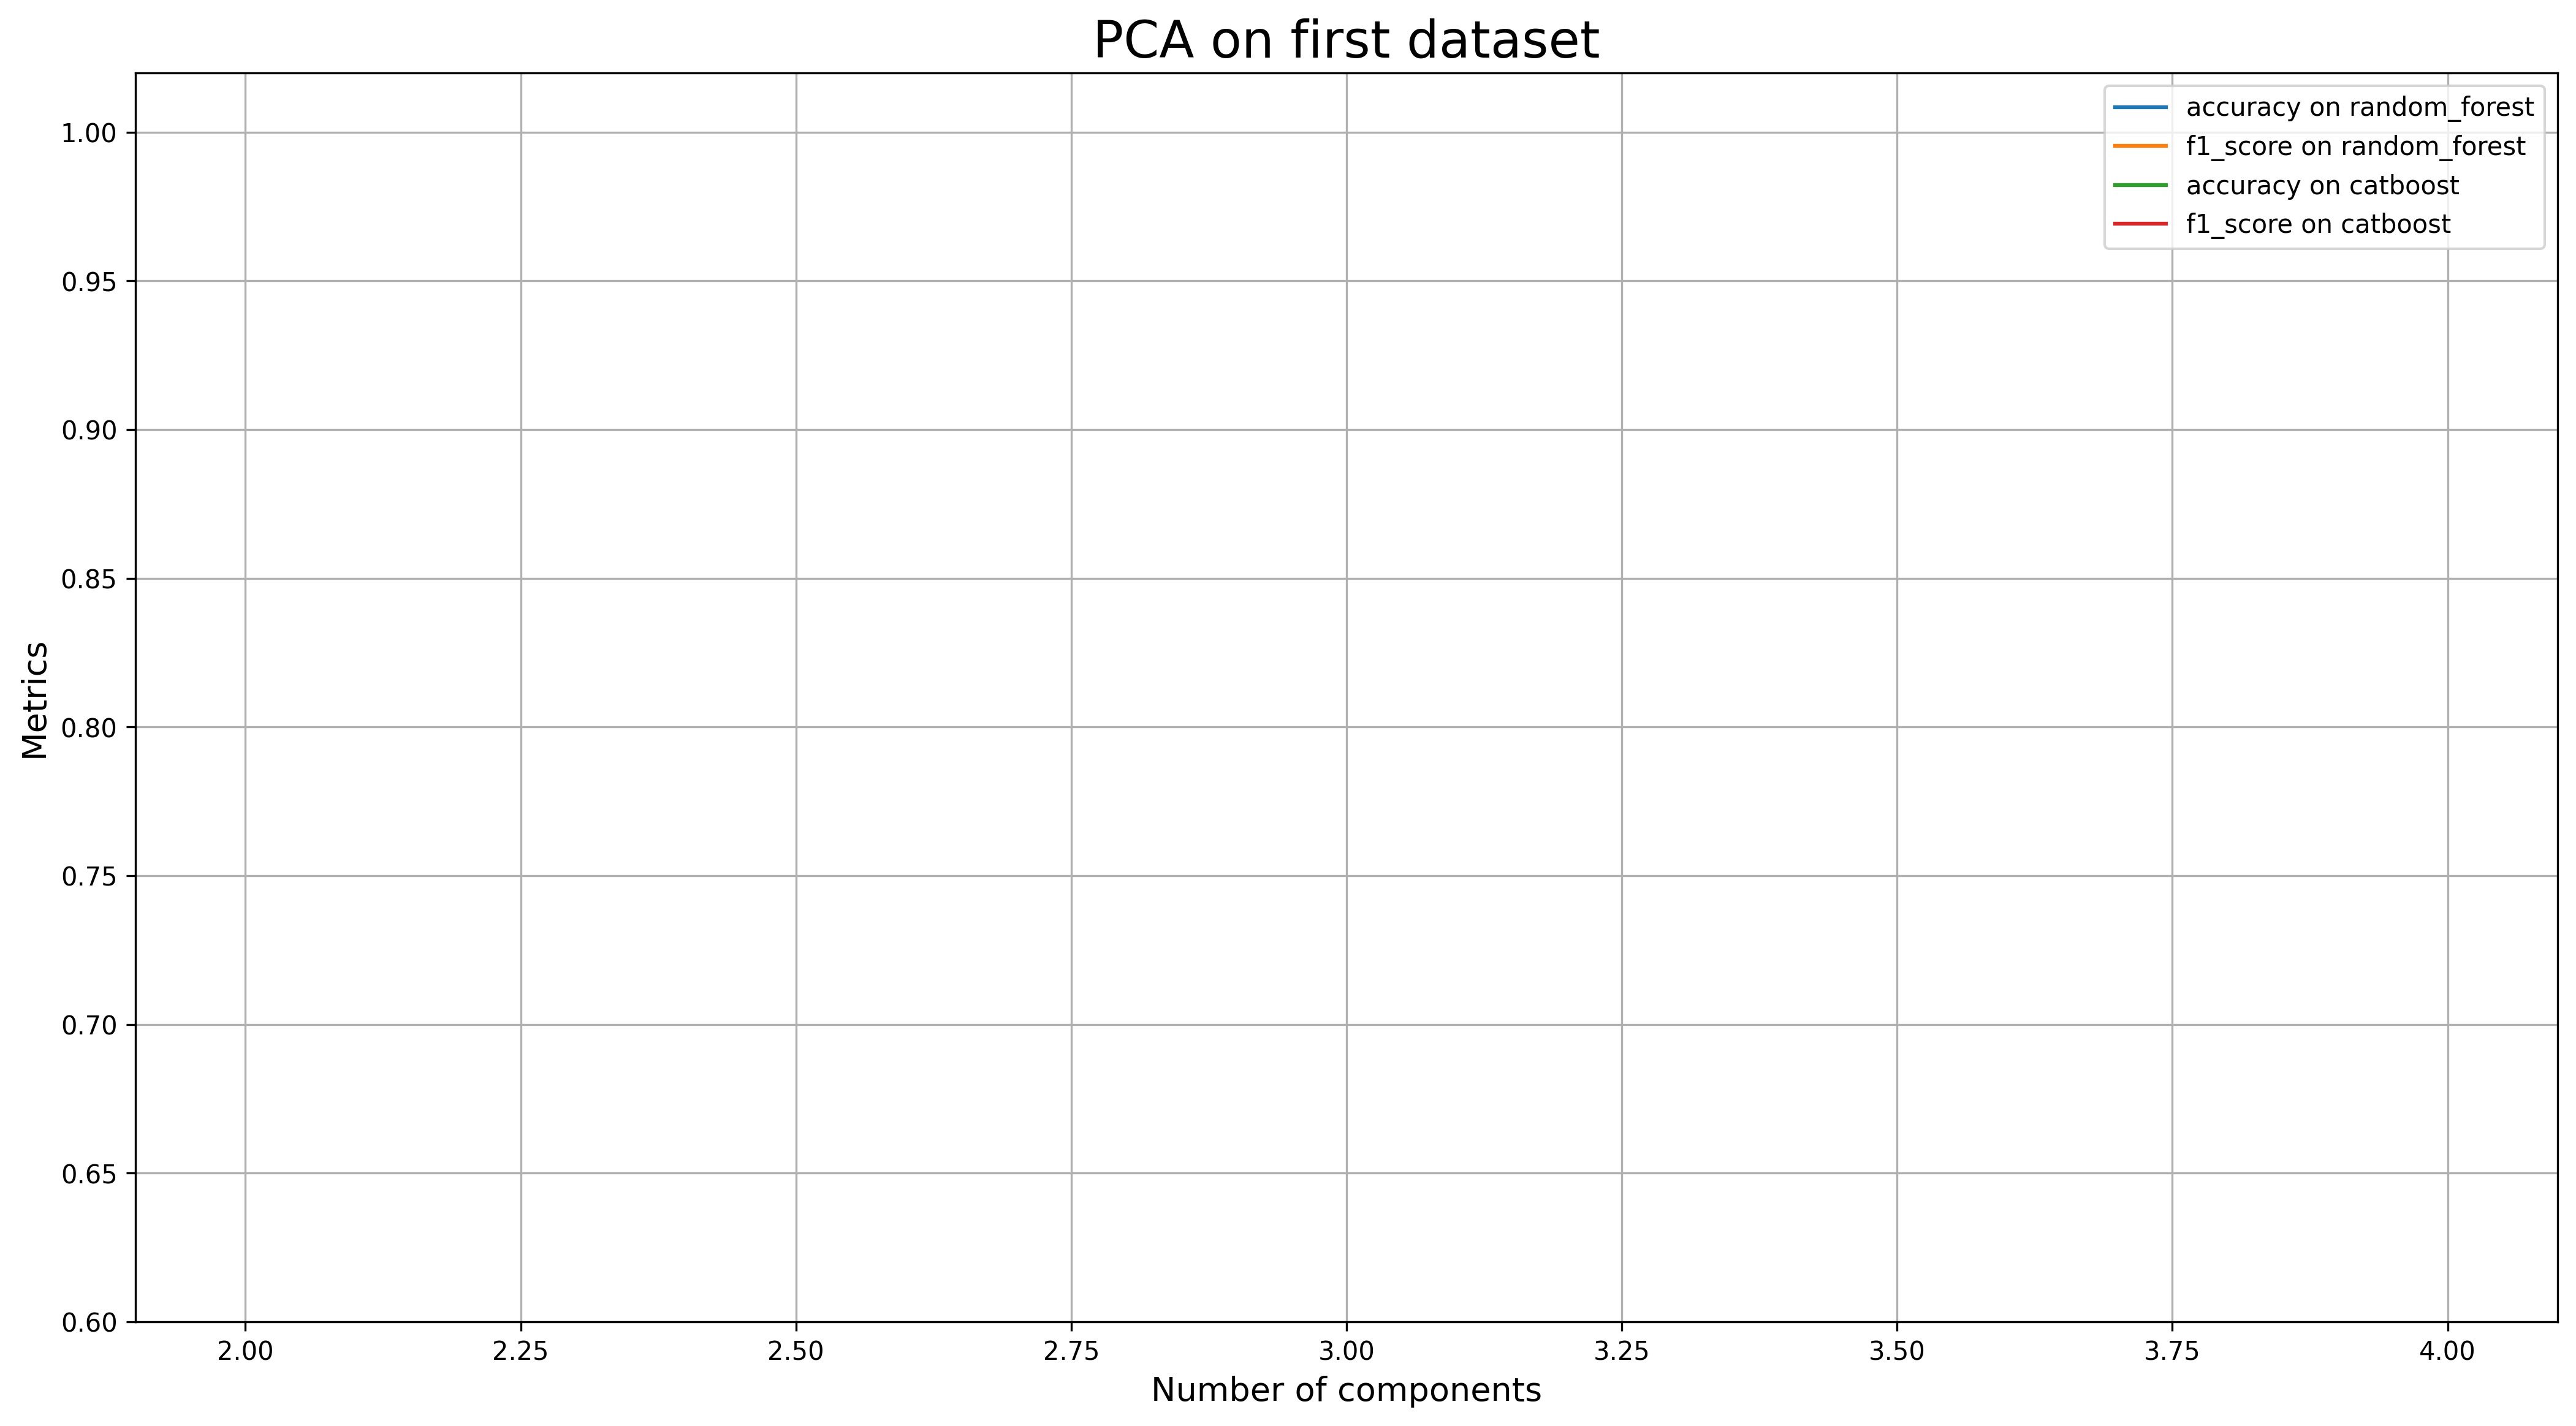

In [198]:
metrics_dict_first_dataset_PCA = classification_task_on_decomposed_data(
    X_first, 
    y_first, 
    n_components_list=np.arange(2, 5), 
    decomposition_class=PCA, 
    dataset='first dataset',
    decomposition_method='PCA'
)
with open('fixed_metrics_dict_first_dataset_pca.pickle', 'wb') as f:
    pickle.dump(metrics_dict_first_dataset_PCA, f)
plot_metrics(metrics_dict_first_dataset_PCA, 'PCA on first dataset')

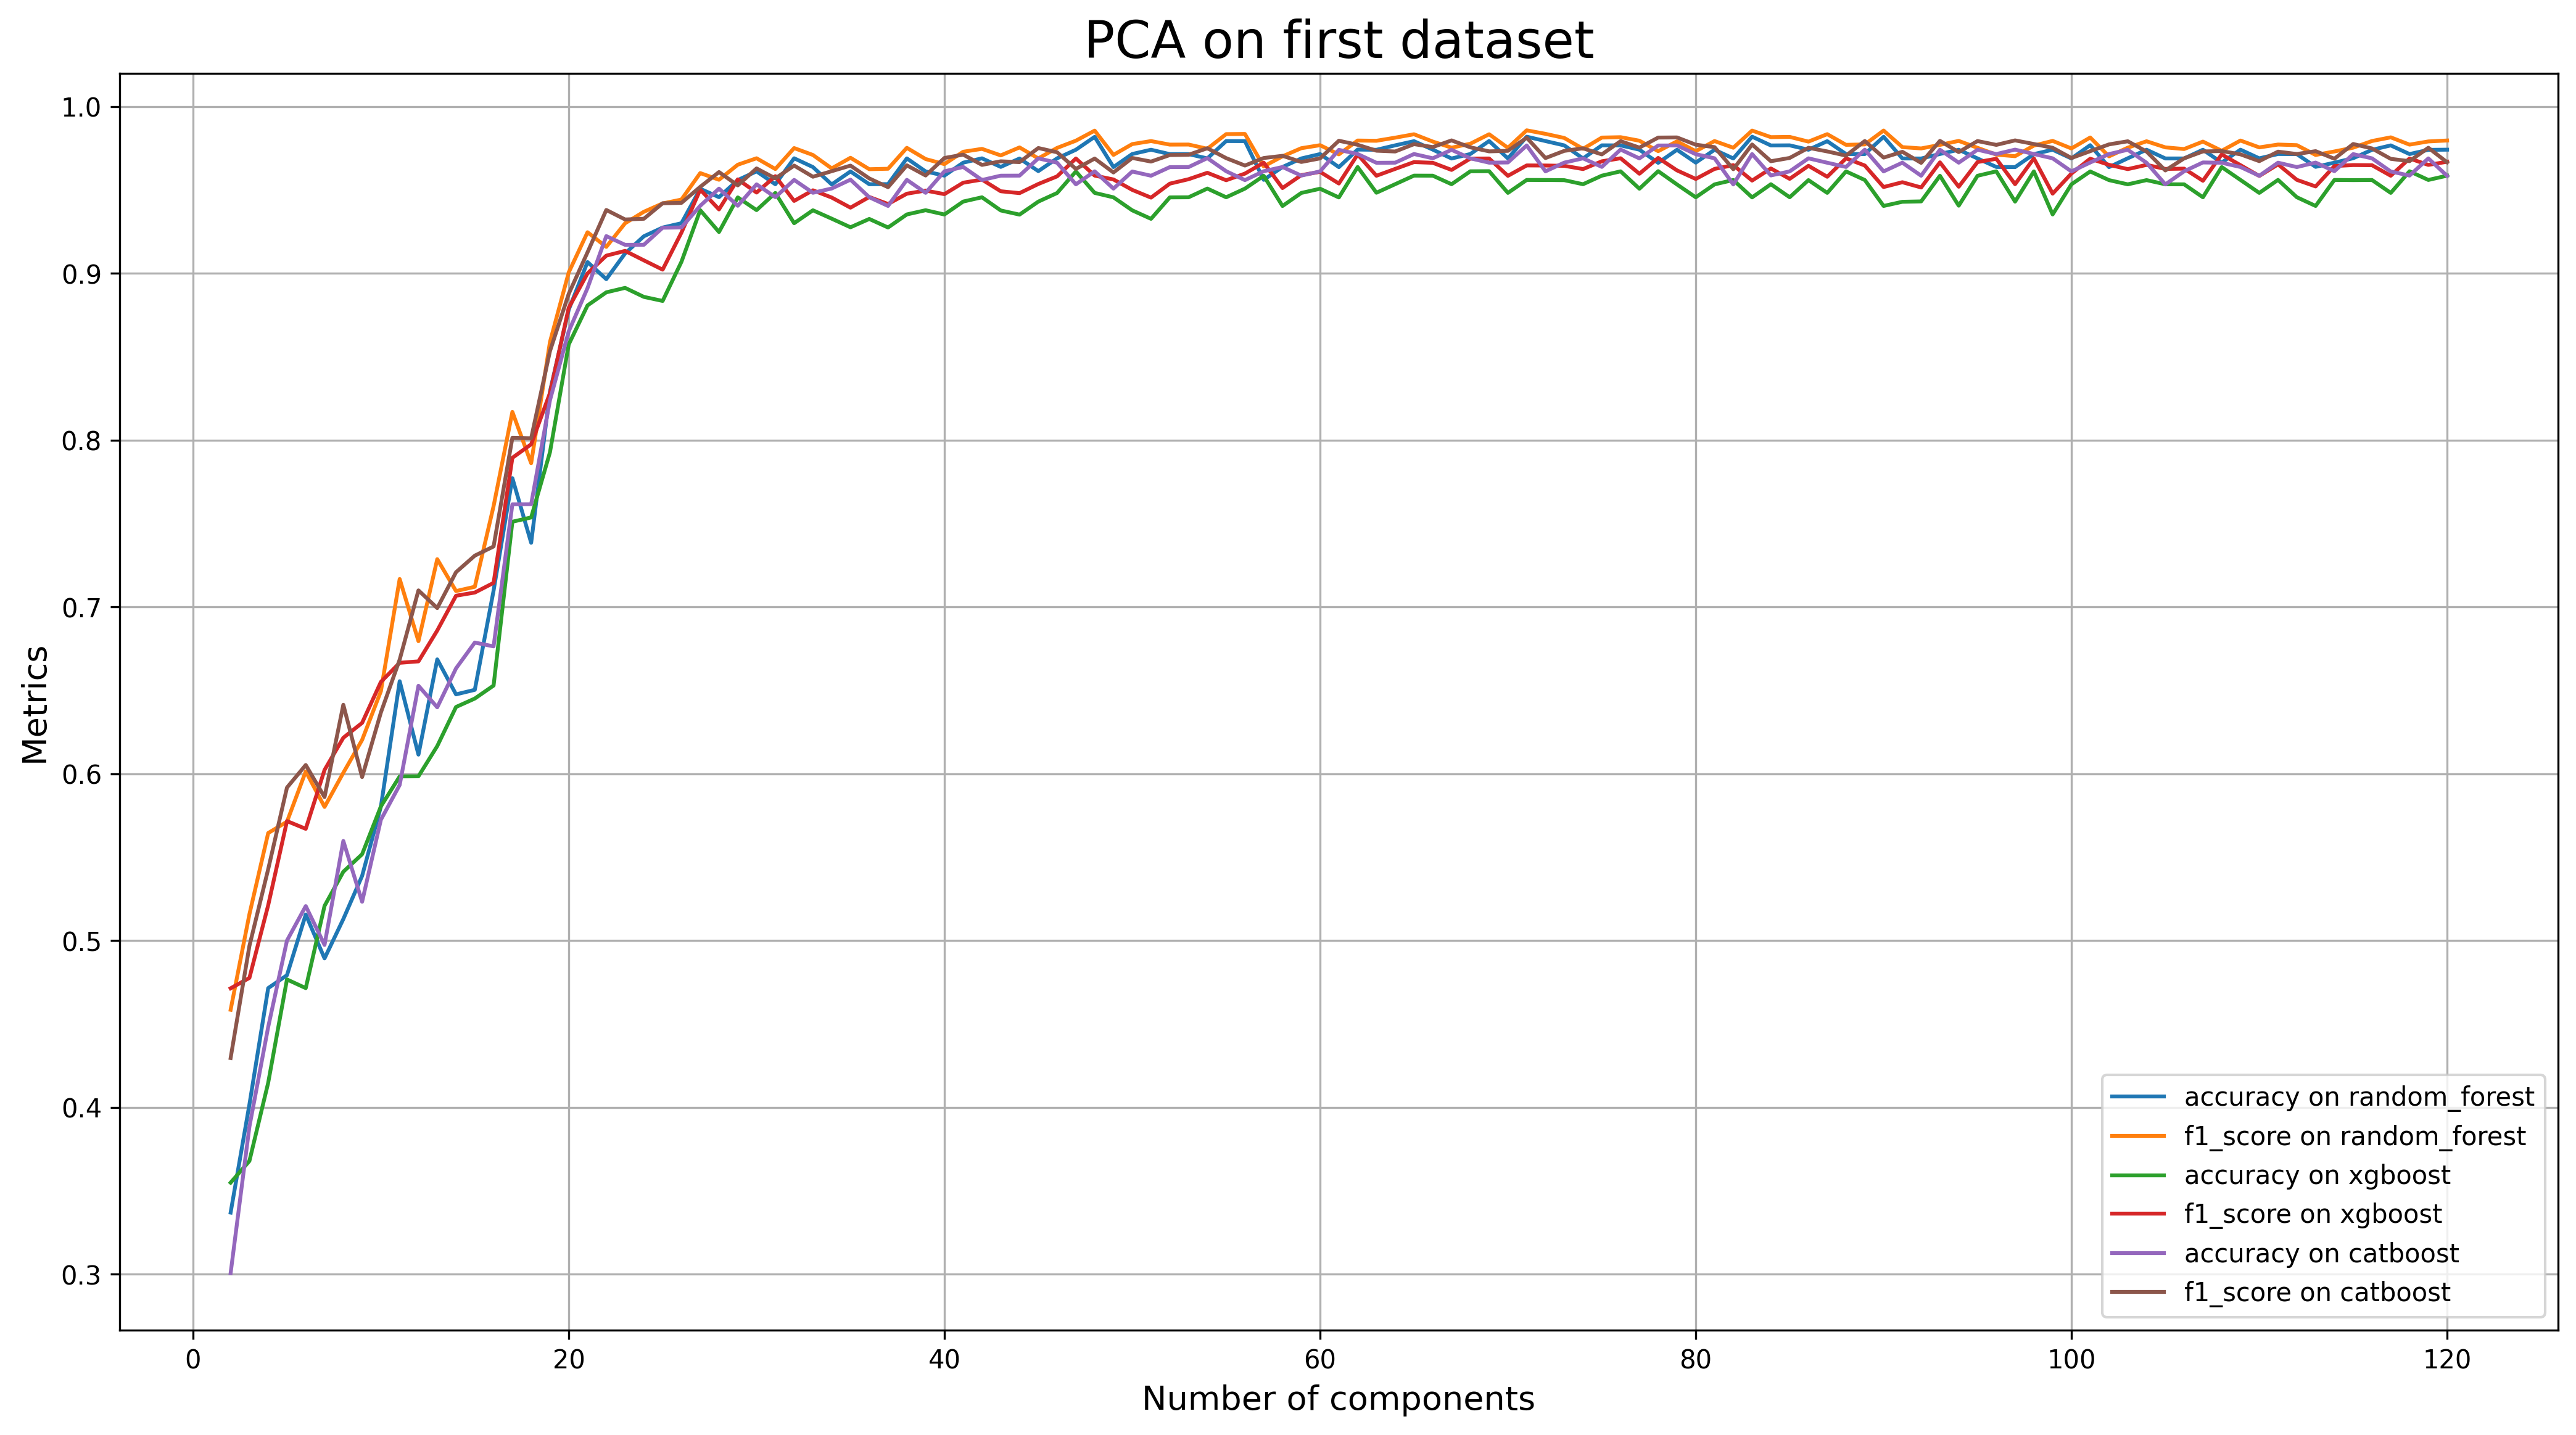

  0%|          | 0/119 [00:00<?, ?it/s]

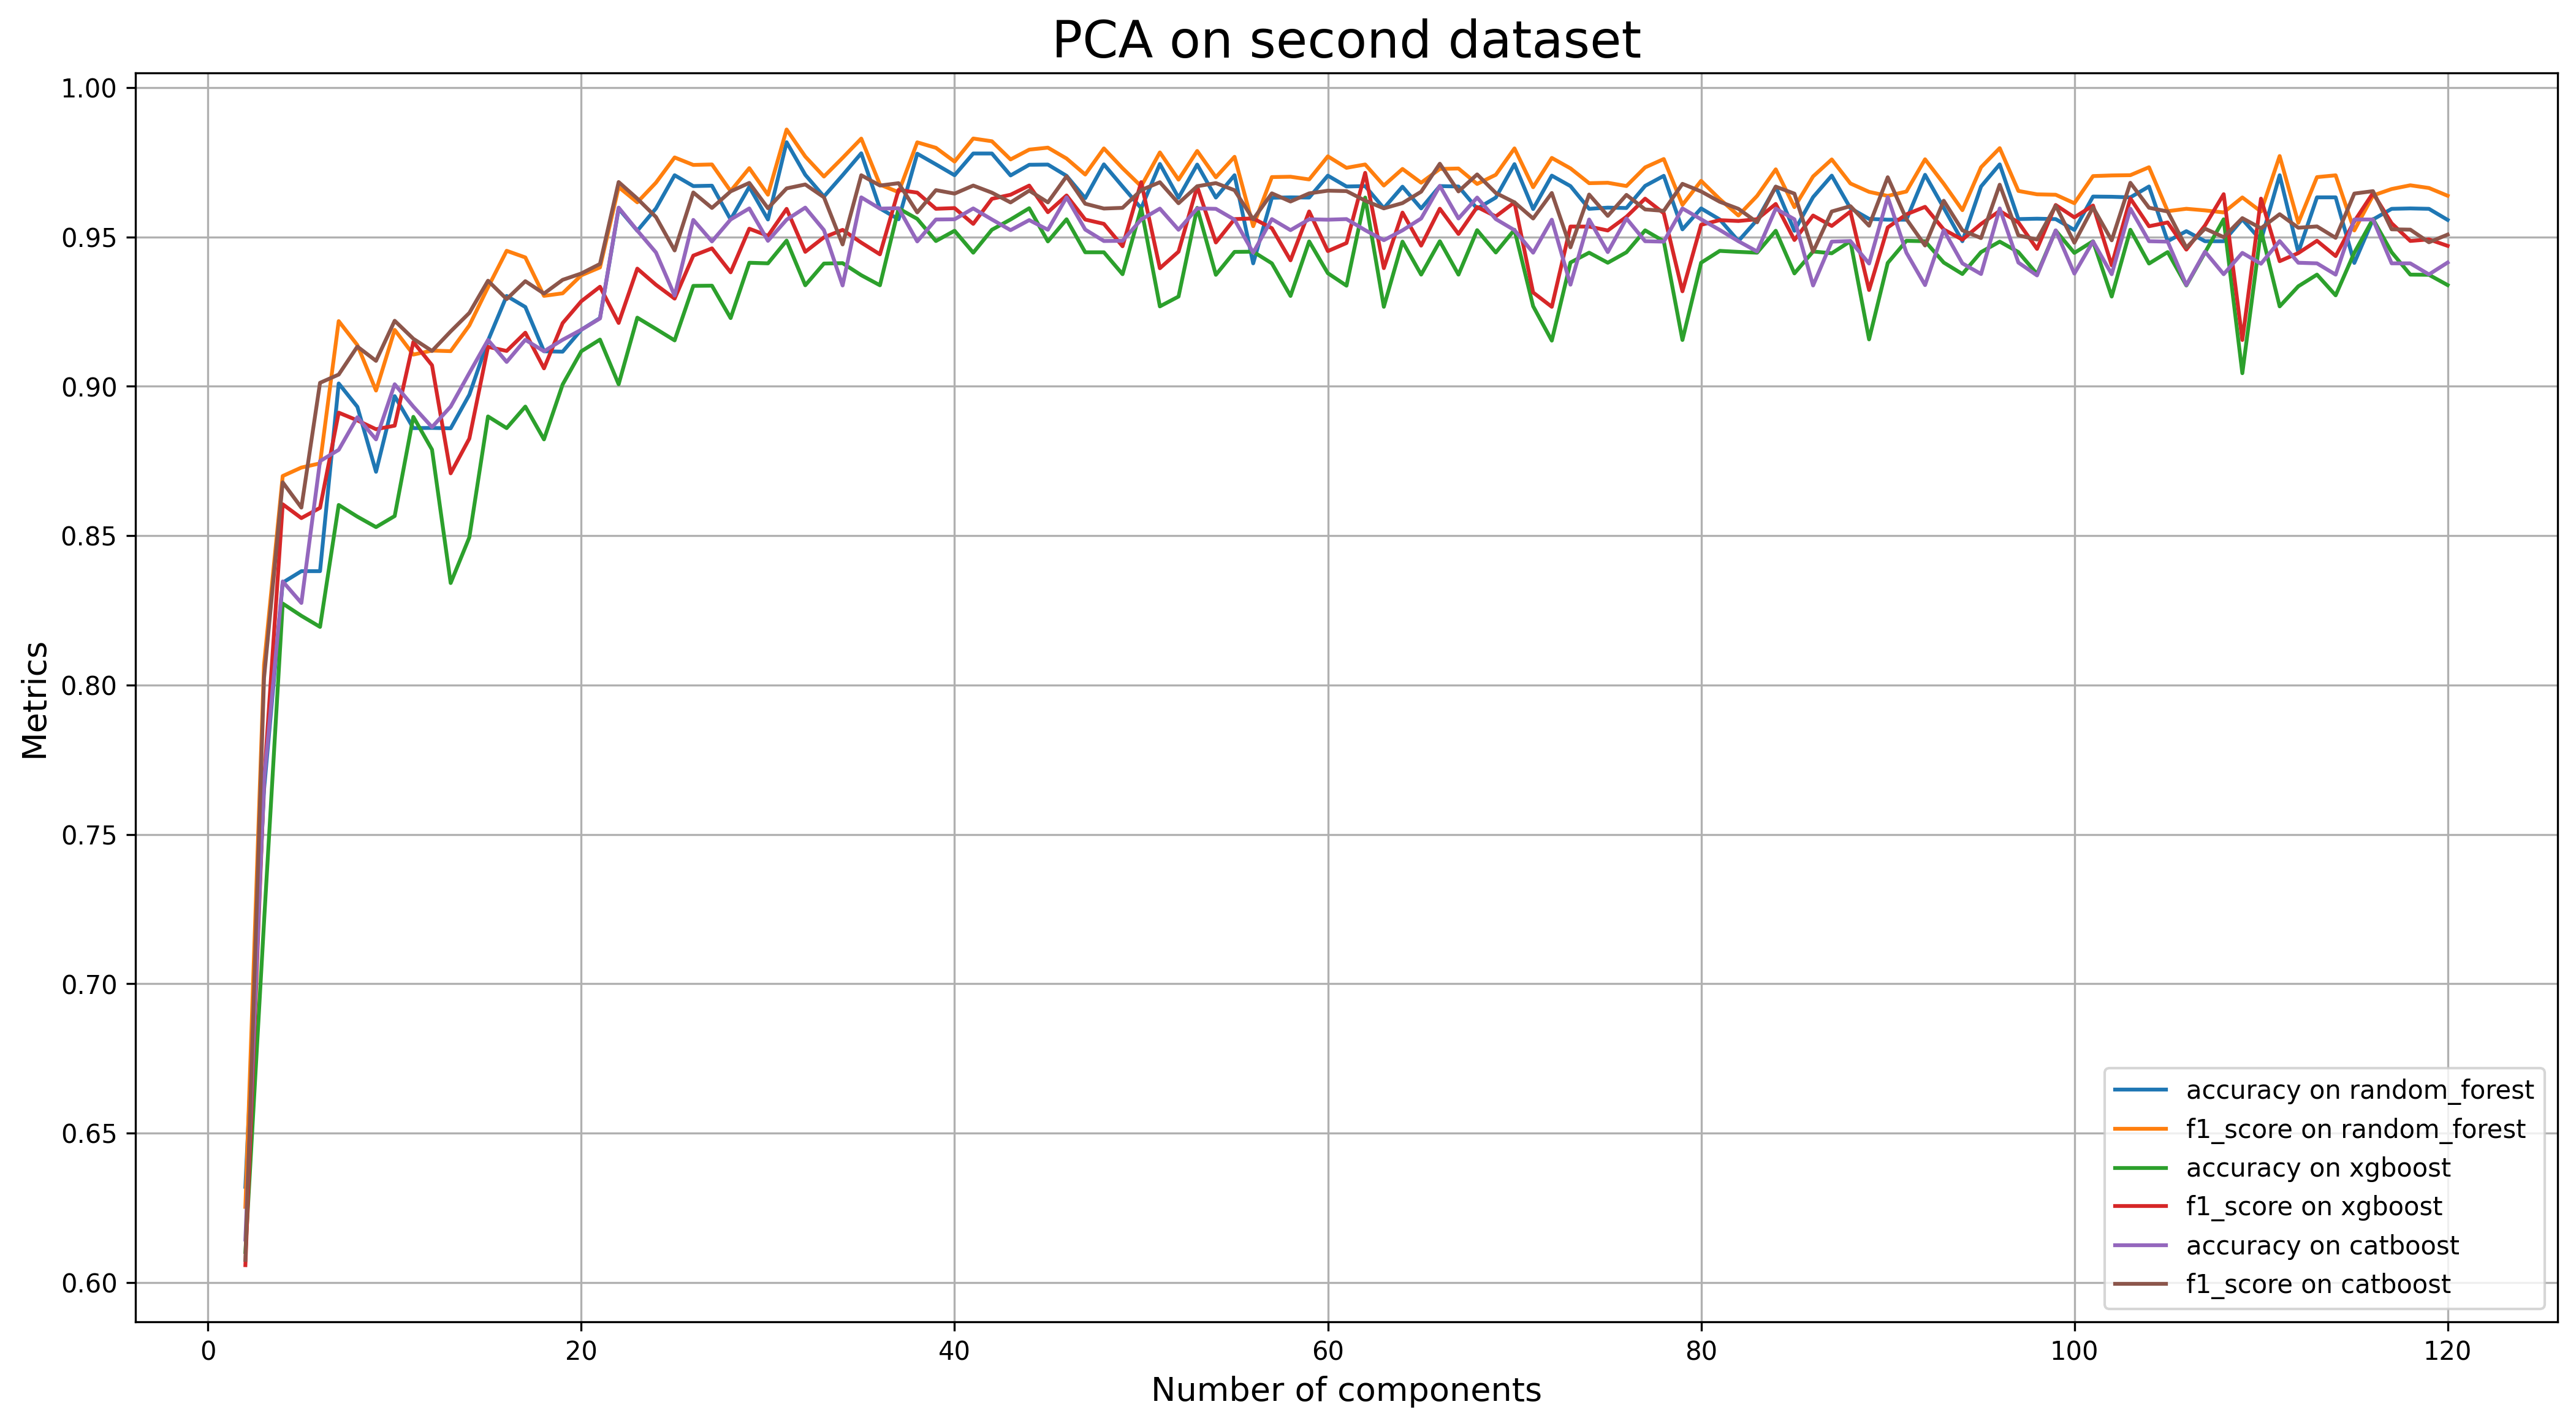

In [34]:
import warnings
warnings.filterwarnings('ignore')

metrics_dict_first_dataset_PCA = classification_task_on_decomposed_data(
    X_first, 
    y_first, 
    n_components_list=np.arange(2, 121), 
    decomposition_class=PCA, 
    dataset='first dataset',
    decomposition_method='PCA'
)
with open('metrics_dict_first_dataset_pca.pickle', 'wb') as f:
    pickle.dump(metrics_dict_first_dataset_PCA, f)
plot_metrics(metrics_dict_first_dataset_PCA, 'PCA on first dataset')


metrics_dict_second_dataset_PCA = classification_task_on_decomposed_data(
    X_second, 
    y_second, 
    n_components_list=np.arange(2, 121), 
    decomposition_class=PCA, 
    dataset='second dataset',
    decomposition_method='PCA'
)
with open('metrics_dict_second_dataset_tsne.pickle', 'wb') as f:
    pickle.dump(metrics_dict_second_dataset_PCA, f)
plot_metrics(metrics_dict_second_dataset_PCA, 'PCA on second dataset')

In [69]:
# with open('metrics_dict_first_dataset_pca.pickle', 'wb') as f:
#     pickle.dump(metrics_dict_first_dataset_PCA, f)

# with open('metrics_dict_second_dataset_pca.pickle', 'wb') as f:
#     pickle.dump(metrics_dict_second_dataset_PCA, f)

In [71]:
with open('pca_metrics/metrics/fixed_metrics_dict_before_hydrolysis_fibrinogen_dataset_pca.pickle', 'rb') as f:
    metrics_dict_first_dataset_PCA = pickle.load(f)
    
with open('pca_metrics/metrics/fixed_metrics_dict_after_hydrolysis_fibrinogen_dataset_pca.pickle', 'rb') as f:
    metrics_dict_second_dataset_PCA = pickle.load(f)

In [37]:
def plot_metrics(mertics_dict, title):
    plt.figure(figsize=(17, 9), dpi=300)
    models = ['random_forest', 'xgboost', 'catboost']
    metrics = ['accuracy', 'f1_score']
    for model in models:
        for metric in metrics:
            plt.plot(
                mertics_dict['x_axis'], 
                mertics_dict[model][metric], 
                label=f'{metric} on {model}, {round(sum(mertics_dict[model][metric][39:]) / len(mertics_dict[model][metric][39:]) * 100, 1) }%'
            )
    plt.grid()
    plt.legend(fontsize=15)
    plt.xlabel('Number of components', fontsize=13)
    plt.ylabel('Metrics', fontsize=13)
    plt.ylim(0.6, 1)
    plt.title(title, fontsize=20)
    plt.show()

In [33]:
mertics_dict = metrics_dict_first_dataset_PCA
models = ['random_forest', 'xgboost', 'catboost']
metrics = ['accuracy', 'f1_score']
for model in models:
    for metric in metrics:
        print(
            model, 
            metric,
            round(sum(mertics_dict[model][metric][39:]) / len(mertics_dict[model][metric][39:]) * 100, 1) 
        )

random_forest accuracy 97.2
random_forest f1_score 97.7
xgboost accuracy 95.1
xgboost f1_score 96.1
catboost accuracy 96.6
catboost f1_score 97.2


In [34]:
mertics_dict = metrics_dict_second_dataset_PCA
models = ['random_forest', 'xgboost', 'catboost']
metrics = ['accuracy', 'f1_score']
for model in models:
    for metric in metrics:
        print(
            model, 
            metric,
            round(sum(mertics_dict[model][metric][39:]) / len(mertics_dict[model][metric][39:]) * 100, 1) 
        )

random_forest accuracy 96.2
random_forest f1_score 96.9
xgboost accuracy 94.2
xgboost f1_score 95.3
catboost accuracy 95.0
catboost f1_score 96.0


In [22]:
len(metrics_dict_first_dataset_PCA['random_forest']['accuracy'])

119

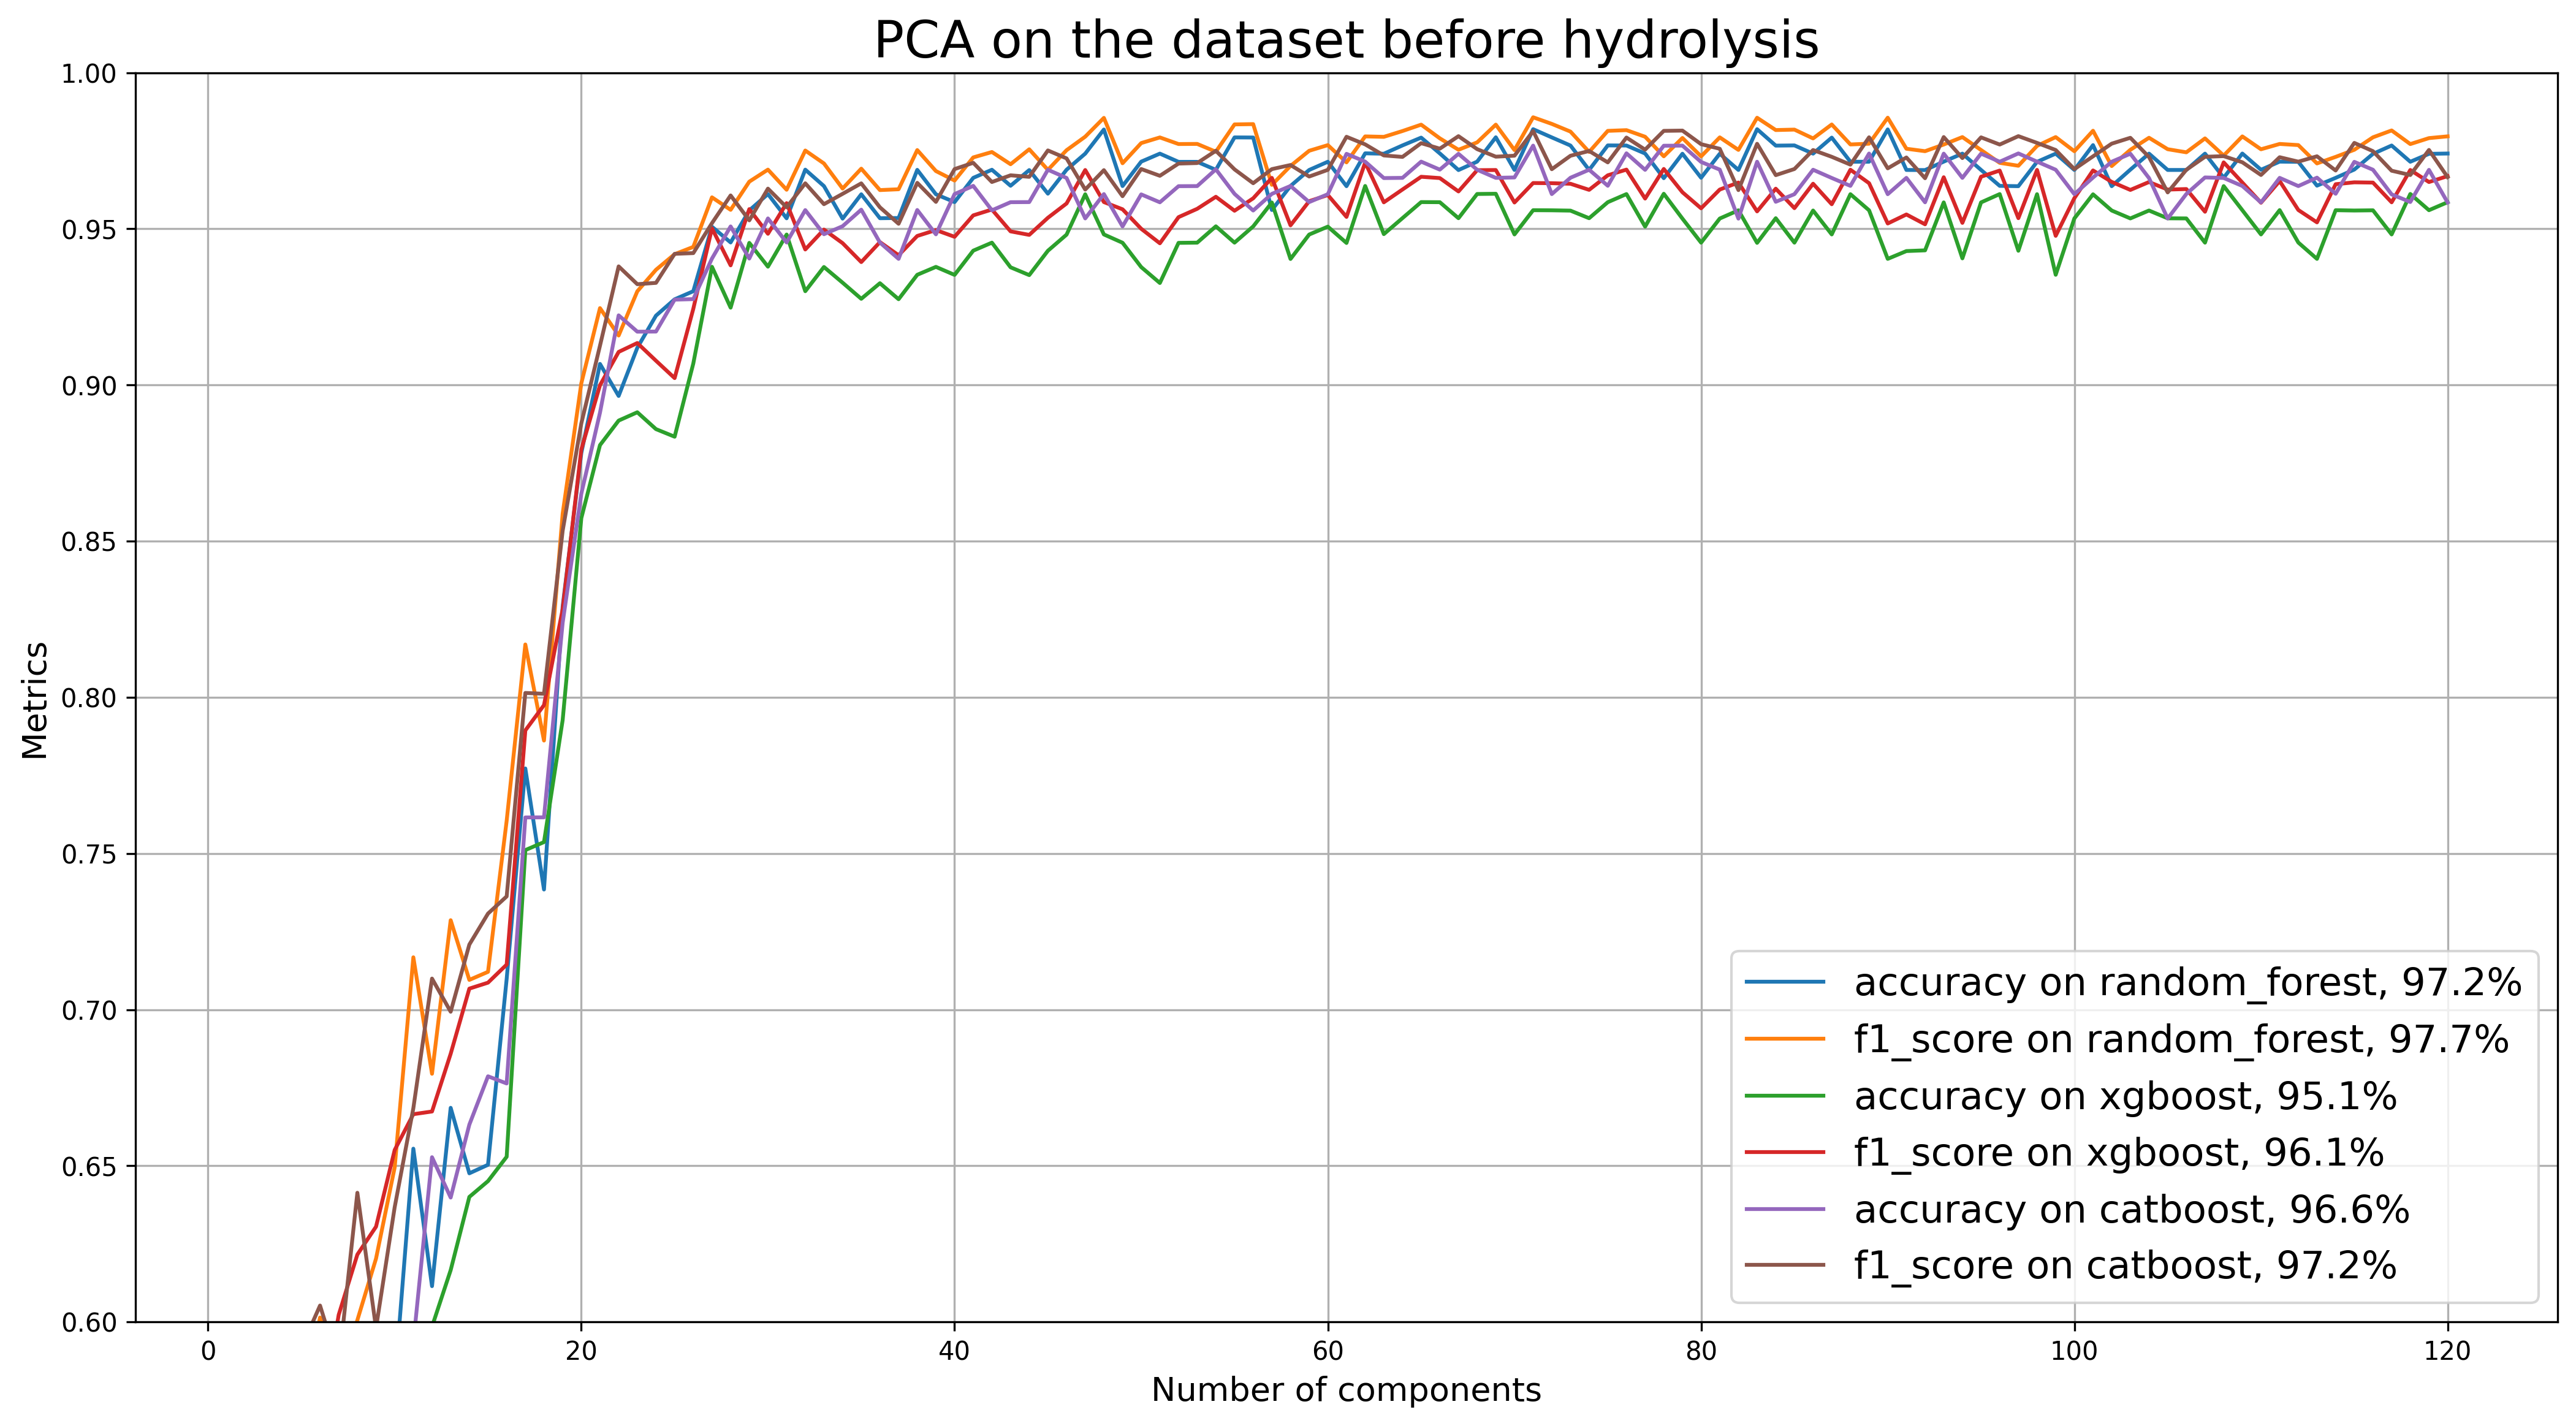

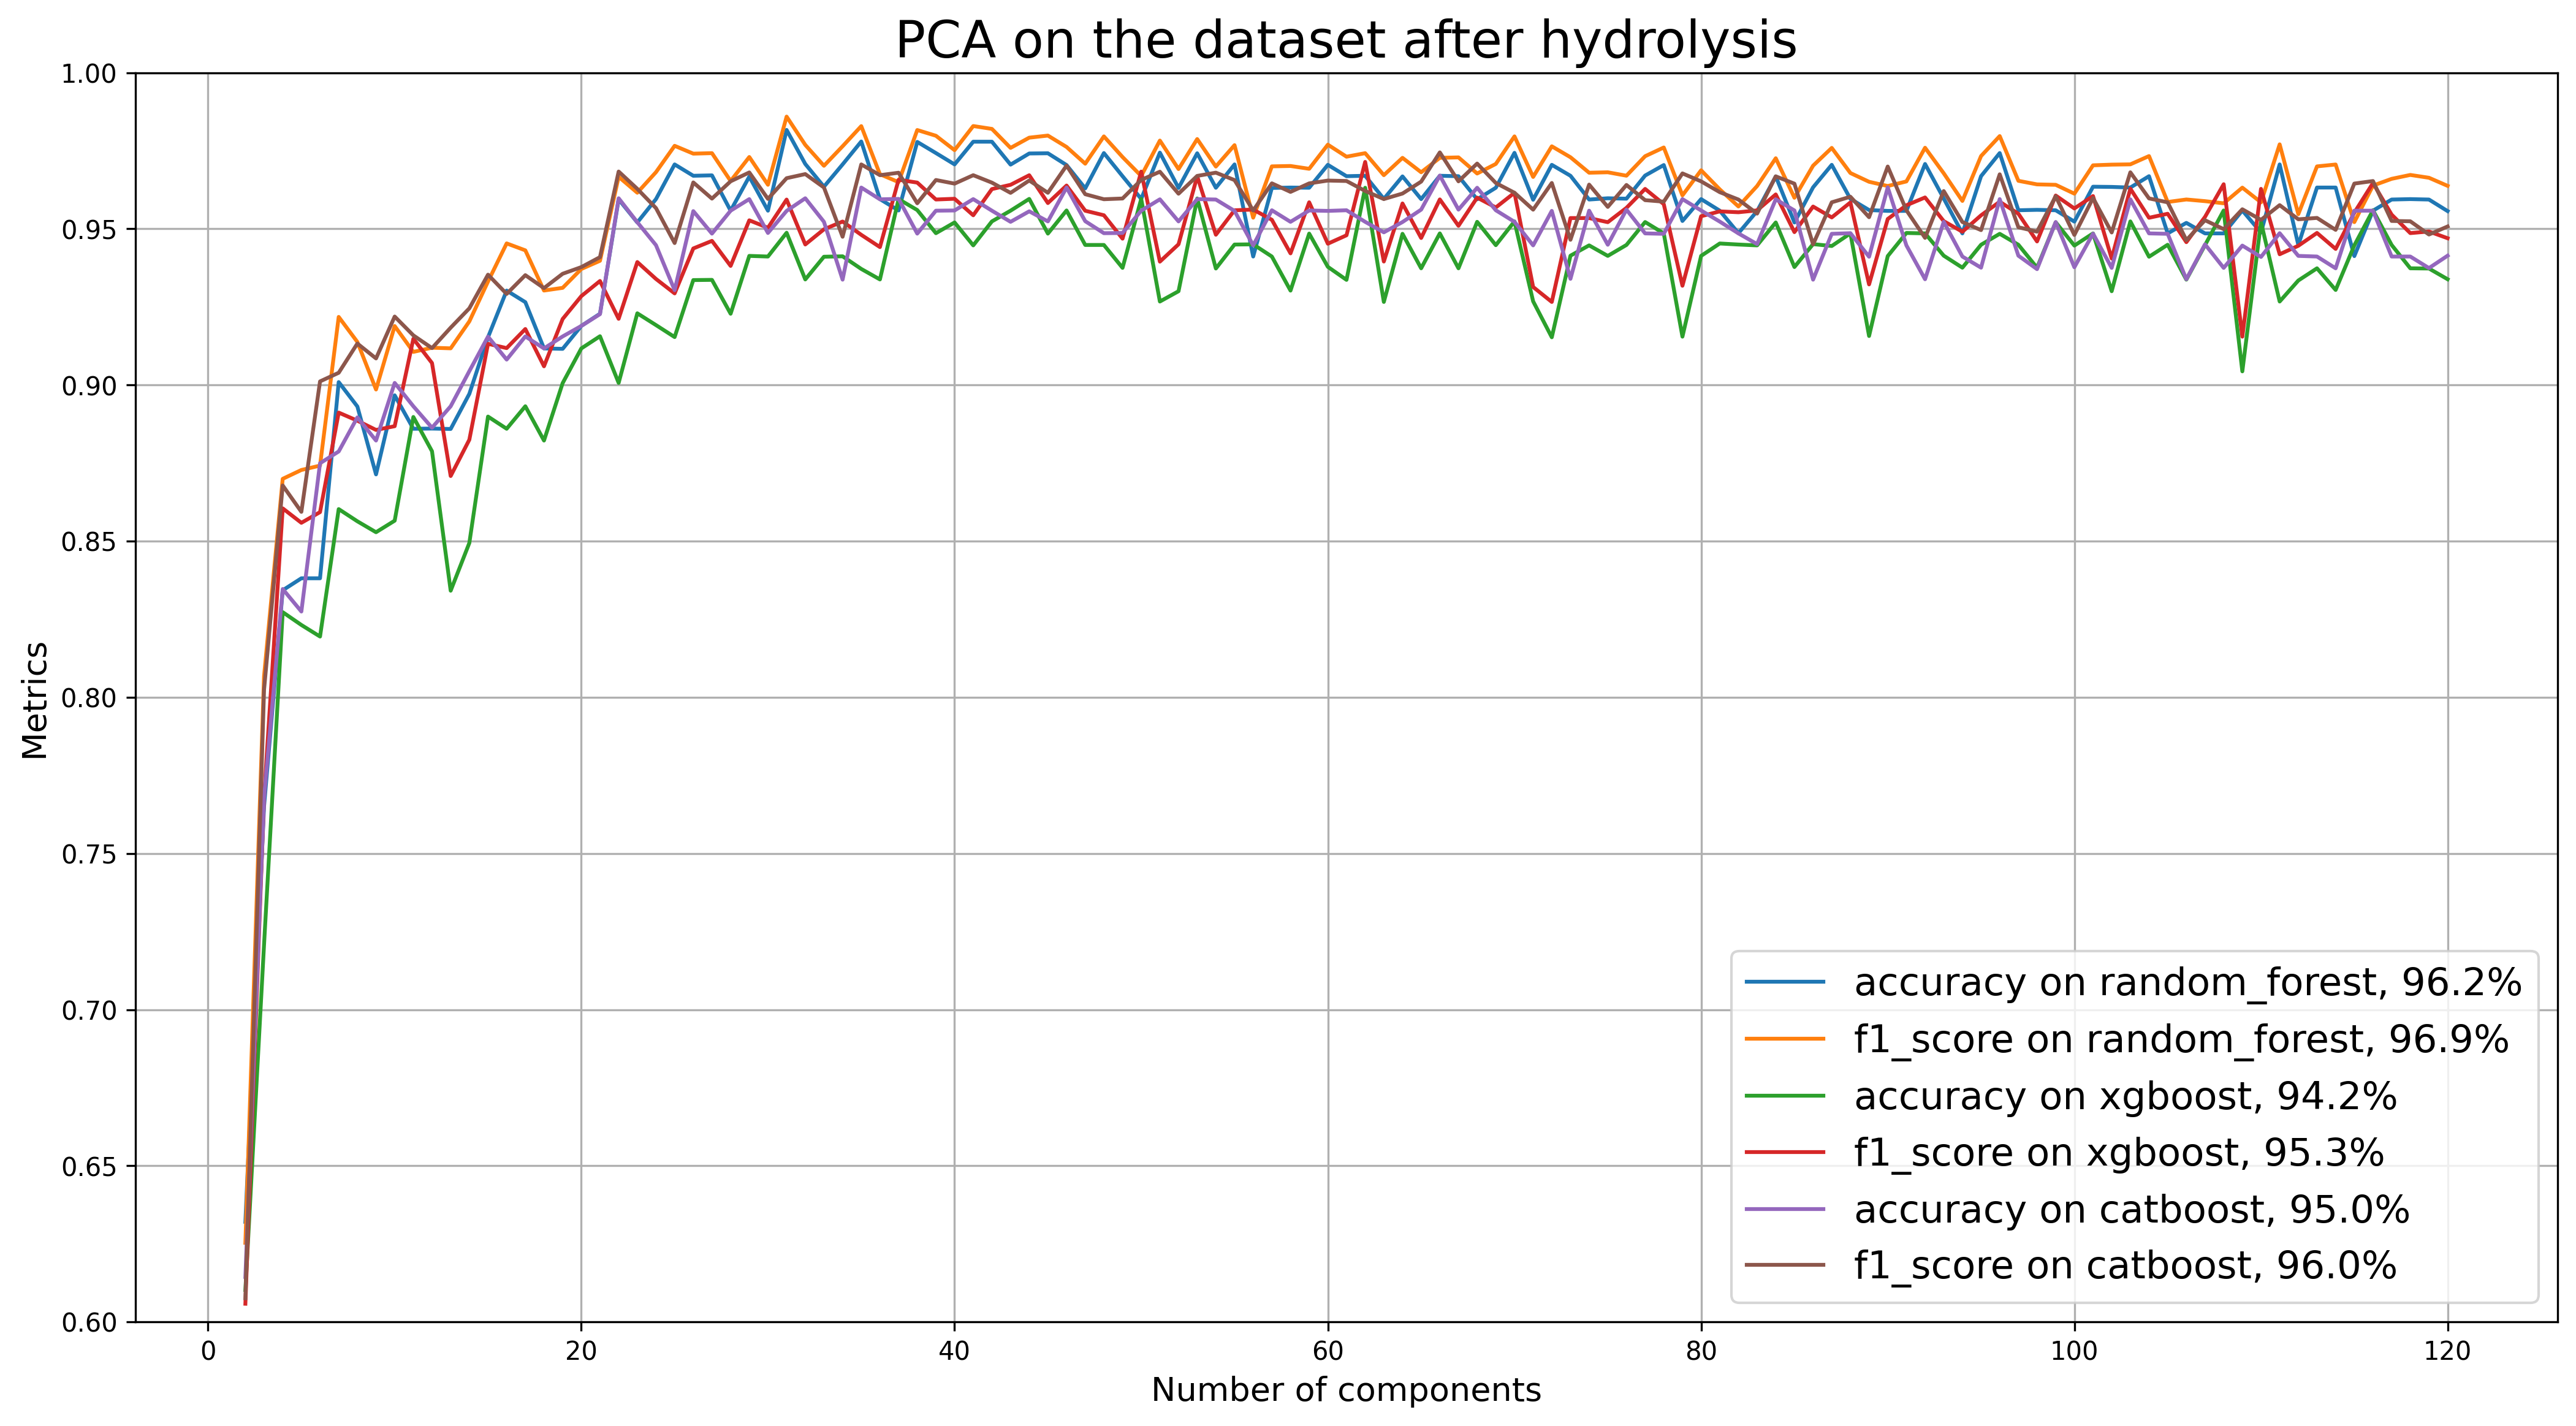

In [38]:
plot_metrics(metrics_dict_first_dataset_PCA, 'PCA on the dataset before hydrolysis')
plot_metrics(metrics_dict_second_dataset_PCA, 'PCA on the dataset after hydrolysis')

In [69]:
def plot_metrics_both(metrics_dict_first, metrics_dict_second, title):
    plt.figure(figsize=(17, 9), dpi=300)
    models = ['random_forest']
    
    metrics = ['accuracy', 'f1_score']
#     x_axis = mertics_dict_first['x_axis']
    for index, metrics_dict in enumerate([metrics_dict_first, metrics_dict_second]):
        for model in models:
            for metric in metrics:
#                 print(metrics_dict['x_axis'])
                if index == 0:
                    plt.plot(
                        metrics_dict['x_axis'], 
                        metrics_dict[model][metric], 
                        label=f'{metric} on {model} before hydrolysis, {round(sum(metrics_dict[model][metric][39:]) / len(metrics_dict[model][metric][39:]) * 100, 1) }%'
                    )
                else: 
                    plt.plot(
                        metrics_dict['x_axis'], 
                        metrics_dict[model][metric], 
                        label=f'{metric} on {model} after hydrolysis, {round(sum(metrics_dict[model][metric][39:]) / len(metrics_dict[model][metric][39:]) * 100, 1) }%'
                    )
                    
    plt.grid()
    plt.legend(fontsize=15)
    plt.xlabel('Number of components', fontsize=13)
    plt.ylabel('Metrics', fontsize=13)
    plt.ylim(0.6, 1)
    plt.title(title, fontsize=20)
    plt.show()

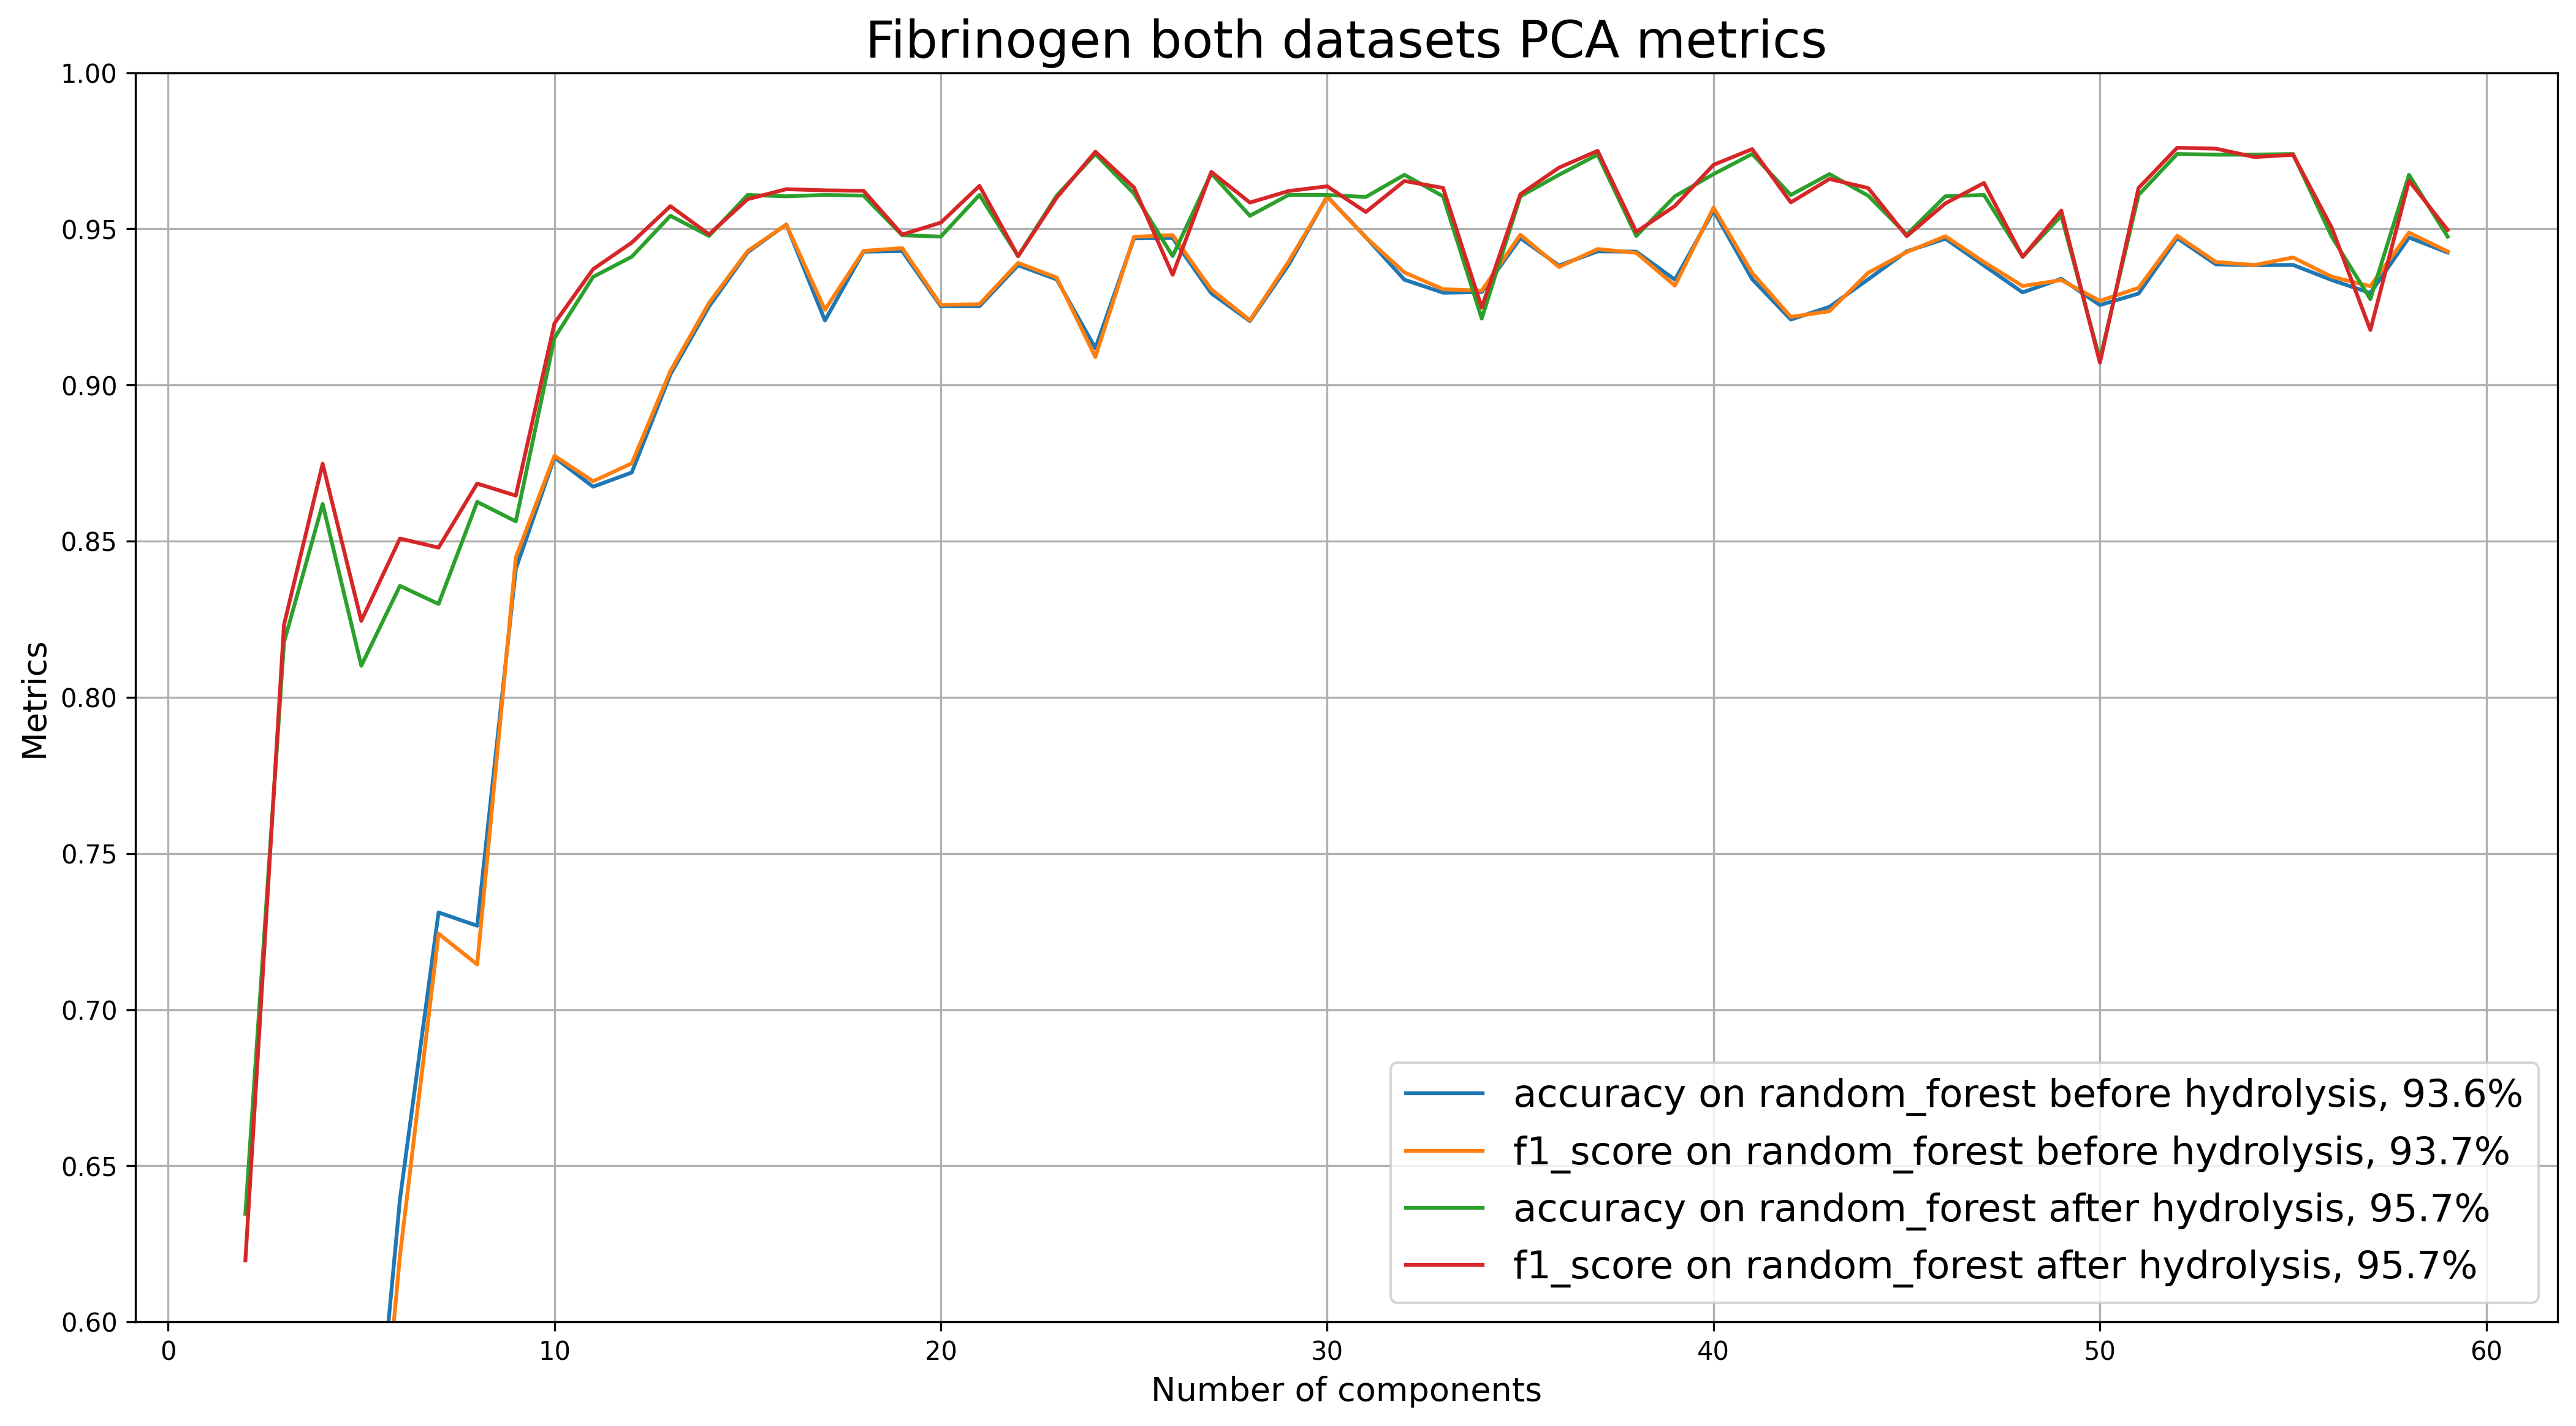

In [73]:
plot_metrics_both(metrics_dict_first_dataset_PCA, metrics_dict_second_dataset_PCA, 'Fibrinogen both datasets PCA metrics')